# Oblivious Decision Tree

In [232]:
import numpy as np
import sklearn.datasets as ds
import pylab as pl
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import random as r
import sys
%pylab inline

def MSE(x, y):
    return ((x - y)**2).sum() / float(len(x))

#calculate variance of set
def variance_calculate(X):
#     print "CALCULATE VAR", X
    return np.var(X)
    
# search best split in X_list of split_feature
#X_list - list of all X value in this depth 
def search_best_split_of_feat(nodes_list, X_list, Y_list, split_feature, orig_var):
#     print "Search_best_split_of_feat"
#     print "\tnodes_list", len(nodes_list)
#     print "\tX_list", X_list
#     print "\tY_list", Y_list
#     print "\tsplit_feat", split_feature
#     print "\torig_var", orig_var
    best_gain = 0
    best_split_value = None
    res_X_l = []
    res_X_r = []
    res_Y_l = []
    res_Y_r = []
    
    #потенциальное значение предиката выбирается из всех множеств X на заданной глубине
    potentional_split_value = list(set(reduce(lambda x, y: x + y[:, split_feature].reshape(-1).tolist()\
                                              if y.shape[0] != 0 else x, X_list, \
                                              [])))
#     print "potentionl_split_value", potentional_split_value
    
    for split_value in potentional_split_value:
        ind_l = [np.where(X[:, split_feature] < split_value)\
                  if X.shape[0] != 0 else (np.asarray([]), None) for X in X_list]
        ind_r = [np.where(X[:, split_feature] >= split_value)\
                  if X.shape[0] != 0 else (np.asarray([]), None) for X in X_list]

        X_l = [X[ind_l[idx]] if len(list(ind_l[idx][0])) != 0 else np.asarray([])\
                                                   for idx, X in enumerate(X_list)]
    
        X_r = [X[ind_r[idx]] if len(list(ind_r[idx][0])) != 0 else  np.asarray([])\
                                                   for idx, X in enumerate(X_list)]
        
        Y_l = [Y[ind_l[idx]] if len(list(ind_l[idx][0])) != 0 else np.asarray([[0]])\
                                                   for idx, Y in enumerate(Y_list)]
        
        Y_r = [Y[ind_r[idx]] if len(list(ind_r[idx][0])) != 0 else np.asarray([[0]])\
                                                   for idx, Y in enumerate(Y_list)]


#         for ind in ind_l:
#             print list(ind[0]), len(list(ind[0])), np.asarray(ind).shape

#         for idx in range(len(Y_l)):
#             if len(Y_l[idx]) == 0 or len(Y_r[idx]) == 0:
#                 bad_split = 1
#                 break
#         print split_value, bad_split
#         if not bad_split:
    #         print "split_value: ", split_value
#             print "X_L", X_l
#             print "X_r", X_r
#             print "Y_l", Y_l
#             print "Y_r", Y_r
        var_l = sum([(len(Y_l_) / float(len(Y_list[i]))) * variance_calculate(Y_l_) \
                                                     for i, Y_l_ in enumerate(Y_l)])
        var_r = sum([(len(Y_r_) / float(len(Y_list[i]))) * variance_calculate(Y_r_) \
                                                        for i, Y_r_ in enumerate(Y_r)])

#             print orig_var, var_l, var_r, "\n"
#             if (orig_var - (len(Y_l) / float(len(Y))) * var_l - (len(Y_r) / float(len(Y))) * var_r), best_gain
#                 if (orig_var - var_l - var_r) > best_gain:
        if (orig_var - var_l - var_r) > best_gain:
            best_gain = orig_var - var_l - var_r
            best_split_value = split_value
            res_X_l = X_l
            res_X_r = X_r
            res_Y_l = Y_l
            res_Y_r = Y_r
    
    return best_gain, best_split_value, res_X_l, res_X_r, res_Y_l, res_Y_r

class ObliviousTree:
    def __init__(self, split_feature = None, split_value = None,\
                 left = None, right = None, n_points = None, depth = None):
        self.split_feature = split_feature
        self.split_value = split_value
        self.left = left
        self.right = right
        self.data = None
        self.n_points = n_points
        self.depth = depth
    
    #return MSE
    def score(self, X, Y):
        predicted = self.predict(X)
        MSE = ((predicted - Y)**2).sum() / float(len(X))
        print "MSE: ", MSE

    def predict_one(self, sample):
        if self.data is not None:
            return self.data * (self.n_points\
                                    / float(self.n_points + 1 + self.n_points))

        if sample[self.split_feature] >= self.split_value:
            return self.right.predict_one(sample)
        else:
            return self.left.predict_one(sample)

    def predict(self, X):
        predicted = []
        for sample in X:
#             print sample
            predicted.append(self.predict_one(sample))
        return np.asarray(predicted)
    
    def search_best_split(self, nodes_list, X_list, Y_list, leaf_regularization):
        best_gain = 0
        res_split_value = 0
        res_split_feature = None
        res_X_r = []
        res_X_l = []
        res_Y_l = []
        res_Y_r = []
        # начальная вариация - сумма вариаций в вершинах
        orig_var = sum([variance_calculate(Y) for Y in Y_list]) 
        
        n_feat = X.shape[1]
        for feat in xrange(n_feat):
#             print 
#             print "Analusys of feature ", feat
            gain, split_value, X_l , X_r, Y_l, Y_r = search_best_split_of_feat(nodes_list, X_list, Y_list, \
                                                                               feat, orig_var)
            if gain > best_gain:
                best_gain = gain
                res_split_value = split_value
                res_split_feature = feat
                res_X_r = X_r
                res_X_l = X_l
                res_Y_l = Y_l
                res_Y_r = Y_r
        
#         print "BEST SPLIT: "
#         print res_split_feature, res_split_value
#         print res_X_l, res_X_r, res_Y_l, res_Y_r
#         print "X_L", res_X_l
#         print "X_r", res_X_r
#         print "Y_L", res_Y_l
#         print "Y_r", res_Y_r  
#         print len(res_X_l), len(res_X_r), len(res_Y_l), len(res_Y_r)
#         print 
        
        if best_gain > 0:
            need_continue = 1
#             print "BEST GAIN > 0", res_split_feature, res_split_value
            #если разбиение нашлось - для каждой вершины на заданном уровне устанавливается заданный предикат
            for node in nodes_list:
                node.split_feature = res_split_feature
                node.split_value = res_split_value
                
            return nodes_list, res_X_l, res_X_r, res_Y_l, res_Y_r    
        else:
#             print "BEST GAIN = 0"
            #если дальнейшего разбиения нет - каждой вершине присваивается среднее значение ее данных 
            for idx, node in enumerate(nodes_list):
                node.n_points = len(Y_list[idx])
#                 print "IS END", leaf_regularization
                if leaf_regularization:
#                     node.data = Y_list[idx].mean() * (len(Y_list[idx])\
#                                                     / float(len(Y_list[idx]) + 1 + np.sqrt(len(Y_list[idx]))))
                    node.data = Y_list[idx].mean()
                else:
                    node.data = Y_list[idx].mean()
                
                    
            return nodes_list, None, res_X_r, res_Y_l, res_Y_r   


    def fit(self, X, Y, leaf_regularization = False):
        #   список вершин на данной глубине
        nodes_list = [self]
        X_list = [X]
        Y_list = [Y]
        deep = 0
        is_end = 0
        while (self.depth is None) or (deep < self.depth):
#             print "deep"
            nodes_list, X_l, X_r, Y_l, Y_r = self.search_best_split(nodes_list, X_list,\
                                                                         Y_list, leaf_regularization)
            if X_l is not None:
                next_nodes_list = []
                next_X_list = []
                next_Y_list = []
                for idx, X_l_ in enumerate(X_l):
                    nodes_list[idx].left = ObliviousTree()
                    nodes_list[idx].right = ObliviousTree()
                    next_X_list.append(X_l_)
                    next_Y_list.append(Y_l[idx])
                    next_X_list.append(X_r[idx])
                    next_Y_list.append(Y_r[idx])
                    next_nodes_list.append(nodes_list[idx].left)
                    next_nodes_list.append(nodes_list[idx].right)
                    
                nodes_list = next_nodes_list
                X_list = next_X_list
                Y_list = next_Y_list
                deep +=1
            else:
                #не найдено наилучшего разбиения
#                 print "IS_END - BESTGAIN = 0"
                is_end = 1
                break
        
        if not is_end:
            for idx, node in enumerate(nodes_list):
#                 print "NOT IS END", leaf_regularization
                node.n_points = len(Y_list[idx])
                if leaf_regularization:
#                     node.data = Y_list[idx].mean() * (len(Y_list[idx]) \
#                                                       / float(len(Y_list[idx]) + 1 + np.sqrt(len(Y_list[idx]))))
                    node.data = Y_list[idx].mean()
                else:
                    node.data = Y_list[idx].mean()
        
        return self
            
    def print_tree(self):
        if self.data != None:
            print str(self.data)
        else:
            print str(self.split_feature) + ": " + str(self.split_value) + "?"
            print "\t T->"
            if (self.right):
                self.right.print_tree()
            print "\t F->"
            if self.left:
                self.left.print_tree()

Populating the interactive namespace from numpy and matplotlib


In [183]:
print np.asarray([]).shape

(0,)


In [184]:
print np.asarray

<function asarray at 0x7f2154405a28>


In [185]:
class Gradient_Boosting:
    def __init__(self, n_estimators=10, shrinkage=0.05, max_depth=10, min_samples_leaf=1):
        self.estimators_list = []
        self.n_estimators = n_estimators
        self.shrinkage = shrinkage
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, Y, verbose = 0, X_test = None, Y_test = None, leaf_regularization = False):
        
        cur_test_predict = 0
        error_statistic = []
        
        self.estimators_list = []
        first_estimator = ObliviousTree(depth= self.max_depth).fit(X, Y, leaf_regularization)
        self.estimators_list.append(first_estimator)
        
        current_predict = first_estimator.predict(X)
        if verbose:
            cur_test_predict = first_estimator.predict(X_test)
#         sys.stderr.write('\rLearning estimator number: 0'+ "/" + str(self.n_estimators))
#         print  "\tLearning estimator number: 0 ; MSE error on train dataset: ", MSE(current_predict, Y)
        
        for i in xrange(1, self.n_estimators):
            antigrad = Y - current_predict
            
            new_estimator = ObliviousTree(depth=self.max_depth)
            new_estimator = new_estimator.fit(X, antigrad, leaf_regularization)
#             new_estimator.print_tree()
            
#             print set(antigrad)
#             print new_estimator.predict(X)[:10]
            current_predict += self.shrinkage * new_estimator.predict(X)
            
#             if i % 10 == 0:
#                 print "\tLearning estimator number: ", i,\
#                         "; MSE error on train dataset: ", MSE(current_predict, Y)
            
            sys.stderr.write('\rLearning estimator number: '+ str(i)+"/" + str(self.n_estimators) \
                             + "; MSE error on train dataset: " + str(MSE(current_predict, Y)))
            self.estimators_list.append(new_estimator)
            
                        
            if verbose:
                cur_test_predict +=  self.shrinkage * new_estimator.predict(X_test)
                error_test =  MSE(cur_test_predict, Y_test)
                error_train =  MSE(current_predict, Y)
                print "MSE on test Dataset:", error_test, "Iteration of Boosting:", i
                print "MSE on train Dataset:", error_train, "Iteration of Boosting:", i
                error_statistic.append(error_test)
                
        return error_statistic
    
    def predict(self, X):
        y =  self.estimators_list[0].predict(X)
#         print len(y)
        for estimator in self.estimators_list[1:]:
            y += estimator.predict(X) * self.shrinkage
#             print MSE(y, Y)
        return y


In [186]:
X = np.array([[1, 0, 5], [2, 3, 5], [2, 3, 4], [2, 9, 1], [2, 9, 4], [1, 2, 1]])
Y = np.array([1, 0, 3, 6, 4, 1])

In [187]:
X1 = np.array([[1, 2, 1], [1, 2, 2], [1, 4, 1], [1, 4, 1]])
Y1 = np.array([1, 2, 3, 4])

In [192]:
test = ObliviousTree(depth=None).fit(X, Y, leaf_regularization = False)

In [189]:
test1 = ObliviousTree(depth=2).fit(X1, Y1)

In [190]:
%%time
gb_avto = Gradient_Boosting(n_estimators=10, max_depth=3, shrinkage=0.1)    
error_without_reg = gb_avto.fit(X, Y, True,X, Y, leaf_regularization = False)

print "MSE Error on train dataset: ", MSE(gb_avto.predict(X),Y)
# print "MSE Error on test dataset: ", MSE(gb_avto.predict(avto_data[350:]), avto_target[350:])

MSE on test Dataset: 4.40250396708 Iteration of Boosting: 1
MSE on train Dataset: 4.40250396708 Iteration of Boosting: 1
MSE on test Dataset: 4.11900321344 Iteration of Boosting: 2
MSE on train Dataset: 4.11900321344 Iteration of Boosting: 2
MSE on test Dataset: 3.85411535087 Iteration of Boosting: 3
MSE on train Dataset: 3.85411535087 Iteration of Boosting: 3
MSE on test Dataset: 3.60661801817 Iteration of Boosting: 4
MSE on train Dataset: 3.60661801817 Iteration of Boosting: 4
MSE on test Dataset: 3.37536915782 Iteration of Boosting: 5
MSE on train Dataset: 3.37536915782 Iteration of Boosting: 5
MSE on test Dataset: 3.15930173826 Iteration of Boosting: 6
MSE on train Dataset: 3.15930173826 Iteration of Boosting: 6
MSE on test Dataset: 2.95741882311 Iteration of Boosting: 7
MSE on train Dataset: 2.95741882311 Iteration of Boosting: 7
MSE on test Dataset: 2.76878896467 Iteration of Boosting: 8
MSE on train Dataset: 2.76878896467 Iteration of Boosting: 8
MSE on test Dataset: 2.592541900

Learning estimator number: 9/10; MSE error on train dataset: 2.59254190024

In [193]:
print test.predict([[1, 2, 1]])
test.print_tree()

[ 0.33333333]
1: 9?
	 T->
2: 4?
	 T->
2: 5?
	 T->
0: 2?
	 T->
0.0
	 F->
0.0
	 F->
0: 2?
	 T->
4.0
	 F->
0.0
	 F->
2: 5?
	 T->
0: 2?
	 T->
0.0
	 F->
0.0
	 F->
0: 2?
	 T->
6.0
	 F->
0.0
	 F->
2: 4?
	 T->
2: 5?
	 T->
0: 2?
	 T->
0.0
	 F->
1.0
	 F->
0: 2?
	 T->
3.0
	 F->
0.0
	 F->
2: 5?
	 T->
0: 2?
	 T->
0.0
	 F->
0.0
	 F->
0: 2?
	 T->
0.0
	 F->
1.0


In [116]:
x = np.asarray([1, 2, 3])
x.tolist()

[1, 2, 3]

In [117]:
tree_1.predict([[1, 2, 3],[8,-2,6]])

NameError: name 'tree_1' is not defined

In [530]:
print tree_1.print_tree()

NameError: name 'tree_1' is not defined

### Avto-dataset

на деревьях глубины 2 или 3 не тащит

In [118]:
avto = pd.read_csv("./data/auto-mpg.data.csv", sep='\t',header=None)
avto = avto.values
print avto.shape
print avto

(392, 9)
[[18.0 8 307.0 ..., 70 1 'chevrolet chevelle malibu']
 [15.0 8 350.0 ..., 70 1 'buick skylark 320']
 [18.0 8 318.0 ..., 70 1 'plymouth satellite']
 ..., 
 [32.0 4 135.0 ..., 82 1 'dodge rampage']
 [28.0 4 120.0 ..., 82 1 'ford ranger']
 [31.0 4 119.0 ..., 82 1 'chevy s-10']]


In [119]:
avto_data = avto[:, 1:8]
avto_target = avto[:, 0]

In [120]:
print avto_data
print avto_target[:5]

[[8 307.0 130.0 ..., 12.0 70 1]
 [8 350.0 165.0 ..., 11.5 70 1]
 [8 318.0 150.0 ..., 11.0 70 1]
 ..., 
 [4 135.0 84.0 ..., 11.6 82 1]
 [4 120.0 79.0 ..., 18.6 82 1]
 [4 119.0 82.0 ..., 19.4 82 1]]
[18.0 15.0 18.0 16.0 17.0]


In [121]:
print avto_data[:10]
print avto_target[:10]

[[8 307.0 130.0 3504.0 12.0 70 1]
 [8 350.0 165.0 3693.0 11.5 70 1]
 [8 318.0 150.0 3436.0 11.0 70 1]
 [8 304.0 150.0 3433.0 12.0 70 1]
 [8 302.0 140.0 3449.0 10.5 70 1]
 [8 429.0 198.0 4341.0 10.0 70 1]
 [8 454.0 220.0 4354.0 9.0 70 1]
 [8 440.0 215.0 4312.0 8.5 70 1]
 [8 455.0 225.0 4425.0 10.0 70 1]
 [8 390.0 190.0 3850.0 8.5 70 1]]
[18.0 15.0 18.0 16.0 17.0 15.0 14.0 14.0 14.0 15.0]


In [122]:
%%time
tree_avto_obl = ObliviousTree(depth = 4).fit(avto_data[:350], avto_target[:350])

BEST GAIN > 0 0 6
BEST GAIN > 0 2 71.0
BEST GAIN > 0 1 302.0
BEST GAIN > 0 1 96.0

CPU times: user 344 ms, sys: 16 ms, total: 360 ms
Wall time: 351 ms


In [124]:
sk_avto = DecisionTreeRegressor(max_depth=4).fit(avto_data[:300], avto_target[:300])
skl_predict = sk_avto.predict(avto_data[300:392])
print ((skl_predict - avto_target[300:392])**2 / float(len(skl_predict))).sum()

sk_avto = GradientBoostingRegressor(criterion='mse', max_depth=3, learning_rate=0.1).fit(avto_data[:350], \
                                                                                         avto_target[:350])
skl_predict = sk_avto.predict(avto_data[350:392])
print ((skl_predict - avto_target[350:392])**2 / float(len(skl_predict))).sum()

46.560603679
17.8466719683


In [128]:
boo_list = range(1, 400, 1)
skl_error = [MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=3, n_estimators=boo).fit(avto_data[:350], \
                                                                                              avto_target[:350]).predict(avto_data[350:392]), avto_target[350:392]) \
            for boo in boo_list]

In [125]:
%%time
gb_avto = Gradient_Boosting(n_estimators=400, max_depth=3, shrinkage=0.1)    
error_without_reg = gb_avto.fit(avto_data[:350], avto_target[:350],1, avto_data[350:],  avto_target[350:], leaf_regularization = False)

print "MSE Error on train dataset: ", MSE(gb_avto.predict(avto_data[:350]), avto_target[:350])
print "MSE Error on test dataset: ", MSE(gb_avto.predict(avto_data[350:]), avto_target[350:])



MSE on test Dataset: 41.395533324 Iteration of Boosting: 1
MSE on train Dataset: 13.4619935593 Iteration of Boosting: 1


Learning estimator number: 2/400; MSE error on train dataset: 13.1738608761


MSE on test Dataset: 41.3835637964 Iteration of Boosting: 2
MSE on train Dataset: 13.1738608761 Iteration of Boosting: 2

MSE on test Dataset: 40.8411677558 Iteration of Boosting: 3
MSE on train Dataset: 12.9389419871 Iteration of Boosting: 3


Learning estimator number: 4/400; MSE error on train dataset: 12.7076432607


MSE on test Dataset: 40.8309513709 Iteration of Boosting: 4
MSE on train Dataset: 12.7076432607 Iteration of Boosting: 4

MSE on test Dataset: 40.3751625886 Iteration of Boosting: 5
MSE on train Dataset: 12.5785486107 Iteration of Boosting: 5


Learning estimator number: 6/400; MSE error on train dataset: 12.3592303671


MSE on test Dataset: 39.9517346491 Iteration of Boosting: 6
MSE on train Dataset: 12.3592303671 Iteration of Boosting: 6

MSE on test Dataset: 40.0904220517 Iteration of Boosting: 7
MSE on train Dataset: 12.1706539604 Iteration of Boosting: 7


Learning estimator number: 8/400; MSE error on train dataset: 12.0861447794


MSE on test Dataset: 39.8366844384 Iteration of Boosting: 8
MSE on train Dataset: 12.0861447794 Iteration of Boosting: 8

MSE on test Dataset: 39.4781740035 Iteration of Boosting: 9
MSE on train Dataset: 11.980994985 Iteration of Boosting: 9


Learning estimator number: 10/400; MSE error on train dataset: 11.8285922506


MSE on test Dataset: 39.6062389584 Iteration of Boosting: 10
MSE on train Dataset: 11.8285922506 Iteration of Boosting: 10

MSE on test Dataset: 39.3534048578 Iteration of Boosting: 11
MSE on train Dataset: 11.6770165502 Iteration of Boosting: 11


Learning estimator number: 12/400; MSE error on train dataset: 11.4075839975


MSE on test Dataset: 39.4263225896 Iteration of Boosting: 12
MSE on train Dataset: 11.4075839975 Iteration of Boosting: 12

MSE on test Dataset: 39.3408023707 Iteration of Boosting: 13
MSE on train Dataset: 11.2796969351 Iteration of Boosting: 13


Learning estimator number: 14/400; MSE error on train dataset: 11.1942911875


MSE on test Dataset: 39.0301180925 Iteration of Boosting: 14
MSE on train Dataset: 11.1942911875 Iteration of Boosting: 14

MSE on test Dataset: 38.7087722104 Iteration of Boosting: 15
MSE on train Dataset: 11.0706371239 Iteration of Boosting: 15


Learning estimator number: 16/400; MSE error on train dataset: 10.9557166663


MSE on test Dataset: 38.8349360174 Iteration of Boosting: 16
MSE on train Dataset: 10.9557166663 Iteration of Boosting: 16

MSE on test Dataset: 38.5862943278 Iteration of Boosting: 17
MSE on train Dataset: 10.8862458789 Iteration of Boosting: 17


Learning estimator number: 18/400; MSE error on train dataset: 10.8278390934


MSE on test Dataset: 38.4528658749 Iteration of Boosting: 18
MSE on train Dataset: 10.8278390934 Iteration of Boosting: 18

MSE on test Dataset: 38.7662860582 Iteration of Boosting: 19
MSE on train Dataset: 10.6394467475 Iteration of Boosting: 19


Learning estimator number: 20/400; MSE error on train dataset: 10.5401055697


MSE on test Dataset: 38.610145455 Iteration of Boosting: 20
MSE on train Dataset: 10.5401055697 Iteration of Boosting: 20

MSE on test Dataset: 38.535016289 Iteration of Boosting: 21
MSE on train Dataset: 10.5051167217 Iteration of Boosting: 21


Learning estimator number: 22/400; MSE error on train dataset: 10.3274471082


MSE on test Dataset: 38.6557481253 Iteration of Boosting: 22
MSE on train Dataset: 10.3274471082 Iteration of Boosting: 22

MSE on test Dataset: 38.6089791025 Iteration of Boosting: 23
MSE on train Dataset: 10.2327598882 Iteration of Boosting: 23


Learning estimator number: 24/400; MSE error on train dataset: 10.1997923695


MSE on test Dataset: 38.5236794332 Iteration of Boosting: 24
MSE on train Dataset: 10.1997923695 Iteration of Boosting: 24

MSE on test Dataset: 38.3888950882 Iteration of Boosting: 25
MSE on train Dataset: 10.1683868393 Iteration of Boosting: 25


Learning estimator number: 26/400; MSE error on train dataset: 10.013966859


MSE on test Dataset: 38.5149291892 Iteration of Boosting: 26
MSE on train Dataset: 10.013966859 Iteration of Boosting: 26

MSE on test Dataset: 38.8408751055 Iteration of Boosting: 27
MSE on train Dataset: 9.87796519374 Iteration of Boosting: 27


Learning estimator number: 27/400; MSE error on train dataset: 9.87796519374


MSE on test Dataset: 38.7556004993 Iteration of Boosting: 28
MSE on train Dataset: 9.79128504538 Iteration of Boosting: 28


Learning estimator number: 28/400; MSE error on train dataset: 9.79128504538


MSE on test Dataset: 38.6837241702 Iteration of Boosting: 29
MSE on train Dataset: 9.7656457674 Iteration of Boosting: 29


Learning estimator number: 29/400; MSE error on train dataset: 9.7656457674


MSE on test Dataset: 38.5571264805 Iteration of Boosting: 30
MSE on train Dataset: 9.70838626421 Iteration of Boosting: 30

MSE on test Dataset: 38.4710183855 Iteration of Boosting: 31
MSE on train Dataset: 9.6194514757 Iteration of Boosting: 31


Learning estimator number: 31/400; MSE error on train dataset: 9.6194514757


MSE on test Dataset: 38.3909494417 Iteration of Boosting: 32
MSE on train Dataset: 9.59744446848 Iteration of Boosting: 32

MSE on test Dataset: 38.6967638729 Iteration of Boosting: 33
MSE on train Dataset: 9.49343884126 Iteration of Boosting: 33


Learning estimator number: 33/400; MSE error on train dataset: 9.49343884126


MSE on test Dataset: 38.828983298 Iteration of Boosting: 34
MSE on train Dataset: 9.40620127258 Iteration of Boosting: 34

MSE on test Dataset: 38.8060988456 Iteration of Boosting: 35
MSE on train Dataset: 9.33727000573 Iteration of Boosting: 35


Learning estimator number: 35/400; MSE error on train dataset: 9.33727000573


MSE on test Dataset: 38.9282800386 Iteration of Boosting: 36
MSE on train Dataset: 9.26513954833 Iteration of Boosting: 36

MSE on test Dataset: 38.7994237417 Iteration of Boosting: 37
MSE on train Dataset: 9.20884830495 Iteration of Boosting: 37


Learning estimator number: 37/400; MSE error on train dataset: 9.20884830495


MSE on test Dataset: 38.733862358 Iteration of Boosting: 38
MSE on train Dataset: 9.19379565203 Iteration of Boosting: 38

MSE on test Dataset: 38.7131008196 Iteration of Boosting: 39
MSE on train Dataset: 9.15296433124 Iteration of Boosting: 39


Learning estimator number: 39/400; MSE error on train dataset: 9.15296433124


MSE on test Dataset: 38.6406362408 Iteration of Boosting: 40
MSE on train Dataset: 9.09242807902 Iteration of Boosting: 40

MSE on test Dataset: 38.6231995564 Iteration of Boosting: 41
MSE on train Dataset: 9.05860821516 Iteration of Boosting: 41


Learning estimator number: 41/400; MSE error on train dataset: 9.05860821516


MSE on test Dataset: 39.1020520426 Iteration of Boosting: 42
MSE on train Dataset: 8.99480773991 Iteration of Boosting: 42

MSE on test Dataset: 39.0342494631 Iteration of Boosting: 43
MSE on train Dataset: 8.97822423406 Iteration of Boosting: 43


Learning estimator number: 43/400; MSE error on train dataset: 8.97822423406


MSE on test Dataset: 39.1050731166 Iteration of Boosting: 44
MSE on train Dataset: 8.90787296836 Iteration of Boosting: 44

MSE on test Dataset: 38.8799387354 Iteration of Boosting: 45
MSE on train Dataset: 8.81667786034 Iteration of Boosting: 45


Learning estimator number: 45/400; MSE error on train dataset: 8.81667786034


MSE on test Dataset: 38.9441569825 Iteration of Boosting: 46
MSE on train Dataset: 8.7562365897 Iteration of Boosting: 46

MSE on test Dataset: 39.0629856623 Iteration of Boosting: 47
MSE on train Dataset: 8.70162789794 Iteration of Boosting: 47


Learning estimator number: 47/400; MSE error on train dataset: 8.70162789794


MSE on test Dataset: 39.0304913615 Iteration of Boosting: 48
MSE on train Dataset: 8.62554553819 Iteration of Boosting: 48


Learning estimator number: 48/400; MSE error on train dataset: 8.62554553819


MSE on test Dataset: 39.0655961552 Iteration of Boosting: 49
MSE on train Dataset: 8.56548534646 Iteration of Boosting: 49

MSE on test Dataset: 39.0550647963 Iteration of Boosting: 50
MSE on train Dataset: 8.53829739117 Iteration of Boosting: 50


Learning estimator number: 50/400; MSE error on train dataset: 8.53829739117


MSE on test Dataset: 39.1327043725 Iteration of Boosting: 51
MSE on train Dataset: 8.48102832434 Iteration of Boosting: 51

MSE on test Dataset: 39.2434607706 Iteration of Boosting: 52
MSE on train Dataset: 8.43453251145 Iteration of Boosting: 52


Learning estimator number: 52/400; MSE error on train dataset: 8.43453251145


MSE on test Dataset: 39.0968338291 Iteration of Boosting: 53
MSE on train Dataset: 8.36276579306 Iteration of Boosting: 53

MSE on test Dataset: 39.0829211719 Iteration of Boosting: 54
MSE on train Dataset: 8.29870727591 Iteration of Boosting: 54


Learning estimator number: 54/400; MSE error on train dataset: 8.29870727591


MSE on test Dataset: 38.9394239198 Iteration of Boosting: 55
MSE on train Dataset: 8.25233137303 Iteration of Boosting: 55

MSE on test Dataset: 38.8505300987 Iteration of Boosting: 56
MSE on train Dataset: 8.22800002492 Iteration of Boosting: 56


Learning estimator number: 56/400; MSE error on train dataset: 8.22800002492


MSE on test Dataset: 39.273337895 Iteration of Boosting: 57
MSE on train Dataset: 8.18637618049 Iteration of Boosting: 57

MSE on test Dataset: 39.3437202815 Iteration of Boosting: 58
MSE on train Dataset: 8.14776194021 Iteration of Boosting: 58


Learning estimator number: 58/400; MSE error on train dataset: 8.14776194021


MSE on test Dataset: 39.4145026754 Iteration of Boosting: 59
MSE on train Dataset: 8.1036279922 Iteration of Boosting: 59

MSE on test Dataset: 39.5160169931 Iteration of Boosting: 60
MSE on train Dataset: 8.06740048145 Iteration of Boosting: 60


Learning estimator number: 60/400; MSE error on train dataset: 8.06740048145


MSE on test Dataset: 39.4974566569 Iteration of Boosting: 61
MSE on train Dataset: 8.01205353009 Iteration of Boosting: 61


Learning estimator number: 61/400; MSE error on train dataset: 8.01205353009


MSE on test Dataset: 39.6037749853 Iteration of Boosting: 62
MSE on train Dataset: 7.93924128294 Iteration of Boosting: 62


Learning estimator number: 62/400; MSE error on train dataset: 7.93924128294


MSE on test Dataset: 39.6351960801 Iteration of Boosting: 63
MSE on train Dataset: 7.9054178683 Iteration of Boosting: 63

MSE on test Dataset: 39.5534142698 Iteration of Boosting: 64
MSE on train Dataset: 7.84941657229 Iteration of Boosting: 64


Learning estimator number: 64/400; MSE error on train dataset: 7.84941657229


MSE on test Dataset: 39.619020078 Iteration of Boosting: 65
MSE on train Dataset: 7.81511035015 Iteration of Boosting: 65

MSE on test Dataset: 39.6225719308 Iteration of Boosting: 66
MSE on train Dataset: 7.78313216954 Iteration of Boosting: 66


Learning estimator number: 66/400; MSE error on train dataset: 7.78313216954


MSE on test Dataset: 39.6419604936 Iteration of Boosting: 67
MSE on train Dataset: 7.74112330594 Iteration of Boosting: 67

MSE on test Dataset: 39.6126421157 Iteration of Boosting: 68
MSE on train Dataset: 7.73139571758 Iteration of Boosting: 68


Learning estimator number: 68/400; MSE error on train dataset: 7.73139571758


MSE on test Dataset: 39.5337362414 Iteration of Boosting: 69
MSE on train Dataset: 7.70282405195 Iteration of Boosting: 69



Learning estimator number: 70/400; MSE error on train dataset: 7.67017429482

MSE on test Dataset: 39.5730495348 Iteration of Boosting: 70
MSE on train Dataset: 7.67017429482 Iteration of Boosting: 70

MSE on test Dataset: 39.635701715 Iteration of Boosting: 71
MSE on train Dataset: 7.64233438082 Iteration of Boosting: 71

MSE on test Dataset: 39.6380524594 Iteration of Boosting: 72
MSE on train Dataset: 7.61611730937 Iteration of Boosting: 72


Learning estimator number: 72/400; MSE error on train dataset: 7.61611730937


MSE on test Dataset: 39.6248094752 Iteration of Boosting: 73
MSE on train Dataset: 7.59359106223 Iteration of Boosting: 73

MSE on test Dataset: 39.5832349845 Iteration of Boosting: 74
MSE on train Dataset: 7.54868653997 Iteration of Boosting: 74


Learning estimator number: 74/400; MSE error on train dataset: 7.54868653997


MSE on test Dataset: 39.5434365908 Iteration of Boosting: 75
MSE on train Dataset: 7.50332509558 Iteration of Boosting: 75

MSE on test Dataset: 39.6557447897 Iteration of Boosting: 76
MSE on train Dataset: 7.44722368146 Iteration of Boosting: 76


Learning estimator number: 76/400; MSE error on train dataset: 7.44722368146


MSE on test Dataset: 39.6744412295 Iteration of Boosting: 77
MSE on train Dataset: 7.4080803214 Iteration of Boosting: 77


Learning estimator number: 77/400; MSE error on train dataset: 7.4080803214


MSE on test Dataset: 39.6118099919 Iteration of Boosting: 78
MSE on train Dataset: 7.39648942178 Iteration of Boosting: 78


Learning estimator number: 78/400; MSE error on train dataset: 7.39648942178


MSE on test Dataset: 39.6530078321 Iteration of Boosting: 79
MSE on train Dataset: 7.36565175415 Iteration of Boosting: 79

MSE on test Dataset: 39.6286551637 Iteration of Boosting: 80
MSE on train Dataset: 7.3571536675 Iteration of Boosting: 80


Learning estimator number: 80/400; MSE error on train dataset: 7.3571536675


MSE on test Dataset: 39.5683636435 Iteration of Boosting: 81
MSE on train Dataset: 7.3233898325 Iteration of Boosting: 81

MSE on test Dataset: 39.6259369405 Iteration of Boosting: 82
MSE on train Dataset: 7.30202358607 Iteration of Boosting: 82


Learning estimator number: 82/400; MSE error on train dataset: 7.30202358607


MSE on test Dataset: 39.6295546927 Iteration of Boosting: 83
MSE on train Dataset: 7.28263111234 Iteration of Boosting: 83

MSE on test Dataset: 39.5513070004 Iteration of Boosting: 84
MSE on train Dataset: 7.24948850416 Iteration of Boosting: 84


Learning estimator number: 84/400; MSE error on train dataset: 7.24948850416


MSE on test Dataset: 39.615382009 Iteration of Boosting: 85
MSE on train Dataset: 7.19763761534 Iteration of Boosting: 85

MSE on test Dataset: 39.6081837008 Iteration of Boosting: 86
MSE on train Dataset: 7.18132877146 Iteration of Boosting: 86


Learning estimator number: 86/400; MSE error on train dataset: 7.18132877146


MSE on test Dataset: 39.6101304964 Iteration of Boosting: 87
MSE on train Dataset: 7.16019045664 Iteration of Boosting: 87

MSE on test Dataset: 39.6180355803 Iteration of Boosting: 88
MSE on train Dataset: 7.14035684935 Iteration of Boosting: 88


Learning estimator number: 88/400; MSE error on train dataset: 7.14035684935


MSE on test Dataset: 39.5891051893 Iteration of Boosting: 89
MSE on train Dataset: 7.13231583159 Iteration of Boosting: 89

MSE on test Dataset: 39.6126649094 Iteration of Boosting: 90
MSE on train Dataset: 7.11392268008 Iteration of Boosting: 90


Learning estimator number: 90/400; MSE error on train dataset: 7.11392268008


MSE on test Dataset: 39.6159755226 Iteration of Boosting: 91
MSE on train Dataset: 7.087212754 Iteration of Boosting: 91

MSE on test Dataset: 39.9709285865 Iteration of Boosting: 92
MSE on train Dataset: 7.06782411659 Iteration of Boosting: 92


Learning estimator number: 92/400; MSE error on train dataset: 7.06782411659


MSE on test Dataset: 39.9134874361 Iteration of Boosting: 93
MSE on train Dataset: 7.05894598683 Iteration of Boosting: 93

MSE on test Dataset: 39.882809749 Iteration of Boosting: 94
MSE on train Dataset: 7.02319488708 Iteration of Boosting: 94


Learning estimator number: 94/400; MSE error on train dataset: 7.02319488708


MSE on test Dataset: 39.9022135255 Iteration of Boosting: 95
MSE on train Dataset: 6.99481769811 Iteration of Boosting: 95

MSE on test Dataset: 39.9067472201 Iteration of Boosting: 96
MSE on train Dataset: 6.97733652054 Iteration of Boosting: 96


Learning estimator number: 96/400; MSE error on train dataset: 6.97733652054


MSE on test Dataset: 39.9056681109 Iteration of Boosting: 97
MSE on train Dataset: 6.94931292595 Iteration of Boosting: 97

MSE on test Dataset: 39.9577365199 Iteration of Boosting: 98
MSE on train Dataset: 6.93424812119 Iteration of Boosting: 98


Learning estimator number: 98/400; MSE error on train dataset: 6.93424812119


MSE on test Dataset: 39.988921173 Iteration of Boosting: 99
MSE on train Dataset: 6.9047029588 Iteration of Boosting: 99

MSE on test Dataset: 39.9914119775 Iteration of Boosting: 100
MSE on train Dataset: 6.88251043423 Iteration of Boosting: 100


Learning estimator number: 100/400; MSE error on train dataset: 6.88251043423


MSE on test Dataset: 39.934963968 Iteration of Boosting: 101
MSE on train Dataset: 6.85382196237 Iteration of Boosting: 101

MSE on test Dataset: 39.9106908667 Iteration of Boosting: 102
MSE on train Dataset: 6.84489924099 Iteration of Boosting: 102


Learning estimator number: 102/400; MSE error on train dataset: 6.84489924099


MSE on test Dataset: 39.9838129552 Iteration of Boosting: 103
MSE on train Dataset: 6.81807364789 Iteration of Boosting: 103


Learning estimator number: 103/400; MSE error on train dataset: 6.81807364789


MSE on test Dataset: 39.9358447597 Iteration of Boosting: 104
MSE on train Dataset: 6.81129223293 Iteration of Boosting: 104

MSE on test Dataset: 39.9950312358 Iteration of Boosting: 105
MSE on train Dataset: 6.79292410491 Iteration of Boosting: 105


Learning estimator number: 105/400; MSE error on train dataset: 6.79292410491


MSE on test Dataset: 40.0844309897 Iteration of Boosting: 106
MSE on train Dataset: 6.77062882486 Iteration of Boosting: 106

MSE on test Dataset: 40.0831755171 Iteration of Boosting: 107
MSE on train Dataset: 6.74508290501 Iteration of Boosting: 107


Learning estimator number: 107/400; MSE error on train dataset: 6.74508290501


MSE on test Dataset: 40.398440752 Iteration of Boosting: 108
MSE on train Dataset: 6.73147057424 Iteration of Boosting: 108

MSE on test Dataset: 40.3810323086 Iteration of Boosting: 109
MSE on train Dataset: 6.70660442048 Iteration of Boosting: 109


Learning estimator number: 109/400; MSE error on train dataset: 6.70660442048


MSE on test Dataset: 40.3663154556 Iteration of Boosting: 110
MSE on train Dataset: 6.70104858592 Iteration of Boosting: 110


Learning estimator number: 110/400; MSE error on train dataset: 6.70104858592


MSE on test Dataset: 40.3613000592 Iteration of Boosting: 111
MSE on train Dataset: 6.68196749637 Iteration of Boosting: 111

MSE on test Dataset: 40.2413519432 Iteration of Boosting: 112
MSE on train Dataset: 6.6593075733 Iteration of Boosting: 112


Learning estimator number: 112/400; MSE error on train dataset: 6.6593075733


MSE on test Dataset: 40.1916872518 Iteration of Boosting: 113
MSE on train Dataset: 6.64212133865 Iteration of Boosting: 113

MSE on test Dataset: 40.1756778575 Iteration of Boosting: 114
MSE on train Dataset: 6.62059818141 Iteration of Boosting: 114


Learning estimator number: 114/400; MSE error on train dataset: 6.62059818141


MSE on test Dataset: 40.1286662638 Iteration of Boosting: 115
MSE on train Dataset: 6.59792247688 Iteration of Boosting: 115

MSE on test Dataset: 40.131970079 Iteration of Boosting: 116
MSE on train Dataset: 6.56193267223 Iteration of Boosting: 116


Learning estimator number: 116/400; MSE error on train dataset: 6.56193267223


MSE on test Dataset: 40.1679749314 Iteration of Boosting: 117
MSE on train Dataset: 6.54246853051 Iteration of Boosting: 117


Learning estimator number: 118/400; MSE error on train dataset: 6.53712933369


MSE on test Dataset: 40.13973022 Iteration of Boosting: 118
MSE on train Dataset: 6.53712933369 Iteration of Boosting: 118

MSE on test Dataset: 40.117165817 Iteration of Boosting: 119
MSE on train Dataset: 6.52310847276 Iteration of Boosting: 119


Learning estimator number: 119/400; MSE error on train dataset: 6.52310847276


MSE on test Dataset: 40.120511416 Iteration of Boosting: 120
MSE on train Dataset: 6.5019968059 Iteration of Boosting: 120

MSE on test Dataset: 40.1081297763 Iteration of Boosting: 121
MSE on train Dataset: 6.49794379069 Iteration of Boosting: 121


Learning estimator number: 121/400; MSE error on train dataset: 6.49794379069


MSE on test Dataset: 40.1221945158 Iteration of Boosting: 122
MSE on train Dataset: 6.47723261251 Iteration of Boosting: 122

MSE on test Dataset: 40.0351456832 Iteration of Boosting: 123
MSE on train Dataset: 6.44347940971 Iteration of Boosting: 123


Learning estimator number: 123/400; MSE error on train dataset: 6.44347940971


MSE on test Dataset: 39.9780971162 Iteration of Boosting: 124
MSE on train Dataset: 6.41983206116 Iteration of Boosting: 124

MSE on test Dataset: 39.8089460852 Iteration of Boosting: 125
MSE on train Dataset: 6.39566692876 Iteration of Boosting: 125


Learning estimator number: 125/400; MSE error on train dataset: 6.39566692876


MSE on test Dataset: 39.7968824301 Iteration of Boosting: 126
MSE on train Dataset: 6.38390312753 Iteration of Boosting: 126

MSE on test Dataset: 39.8089217416 Iteration of Boosting: 127
MSE on train Dataset: 6.32110391747 Iteration of Boosting: 127


Learning estimator number: 127/400; MSE error on train dataset: 6.32110391747


MSE on test Dataset: 39.8095601931 Iteration of Boosting: 128
MSE on train Dataset: 6.30147768626 Iteration of Boosting: 128

MSE on test Dataset: 39.8051621043 Iteration of Boosting: 129
MSE on train Dataset: 6.28750780207 Iteration of Boosting: 129


Learning estimator number: 129/400; MSE error on train dataset: 6.28750780207


MSE on test Dataset: 39.7992053316 Iteration of Boosting: 130
MSE on train Dataset: 6.27356290466 Iteration of Boosting: 130

MSE on test Dataset: 39.7990109749 Iteration of Boosting: 131
MSE on train Dataset: 6.26168203847 Iteration of Boosting: 131


Learning estimator number: 131/400; MSE error on train dataset: 6.26168203847


MSE on test Dataset: 39.6571818876 Iteration of Boosting: 132
MSE on train Dataset: 6.24724448123 Iteration of Boosting: 132

MSE on test Dataset: 39.5576068971 Iteration of Boosting: 133
MSE on train Dataset: 6.23031805961 Iteration of Boosting: 133


Learning estimator number: 133/400; MSE error on train dataset: 6.23031805961


MSE on test Dataset: 39.5372167596 Iteration of Boosting: 134
MSE on train Dataset: 6.21002377402 Iteration of Boosting: 134

MSE on test Dataset: 39.4669310239 Iteration of Boosting: 135
MSE on train Dataset: 6.1833784251 Iteration of Boosting: 135


Learning estimator number: 135/400; MSE error on train dataset: 6.1833784251


MSE on test Dataset: 39.3092409731 Iteration of Boosting: 136
MSE on train Dataset: 6.16274127048 Iteration of Boosting: 136

MSE on test Dataset: 39.2994379558 Iteration of Boosting: 137
MSE on train Dataset: 6.15428184325 Iteration of Boosting: 137


Learning estimator number: 137/400; MSE error on train dataset: 6.15428184325


MSE on test Dataset: 39.1701737327 Iteration of Boosting: 138
MSE on train Dataset: 6.13718021469 Iteration of Boosting: 138

MSE on test Dataset: 39.2912372083 Iteration of Boosting: 139
MSE on train Dataset: 6.10735725644 Iteration of Boosting: 139


Learning estimator number: 139/400; MSE error on train dataset: 6.10735725644


MSE on test Dataset: 39.2807021733 Iteration of Boosting: 140
MSE on train Dataset: 6.10419971697 Iteration of Boosting: 140

MSE on test Dataset: 39.2216879345 Iteration of Boosting: 141
MSE on train Dataset: 6.08205084373 Iteration of Boosting: 141


Learning estimator number: 141/400; MSE error on train dataset: 6.08205084373


MSE on test Dataset: 39.1010929907 Iteration of Boosting: 142
MSE on train Dataset: 6.07213494718 Iteration of Boosting: 142

MSE on test Dataset: 38.9939285497 Iteration of Boosting: 143
MSE on train Dataset: 6.04776938814 Iteration of Boosting: 143


Learning estimator number: 143/400; MSE error on train dataset: 6.04776938814


MSE on test Dataset: 39.0092847054 Iteration of Boosting: 144
MSE on train Dataset: 5.99517910114 Iteration of Boosting: 144

MSE on test Dataset: 38.9897805213 Iteration of Boosting: 145
MSE on train Dataset: 5.97354813443 Iteration of Boosting: 145


Learning estimator number: 145/400; MSE error on train dataset: 5.97354813443


MSE on test Dataset: 38.9919131346 Iteration of Boosting: 146
MSE on train Dataset: 5.95970324702 Iteration of Boosting: 146

MSE on test Dataset: 38.9855162155 Iteration of Boosting: 147
MSE on train Dataset: 5.95027417356 Iteration of Boosting: 147


Learning estimator number: 147/400; MSE error on train dataset: 5.95027417356


MSE on test Dataset: 38.9760383166 Iteration of Boosting: 148
MSE on train Dataset: 5.94771546011 Iteration of Boosting: 148

MSE on test Dataset: 38.8633442027 Iteration of Boosting: 149
MSE on train Dataset: 5.93391876305 Iteration of Boosting: 149


Learning estimator number: 149/400; MSE error on train dataset: 5.93391876305


MSE on test Dataset: 38.8805981322 Iteration of Boosting: 150
MSE on train Dataset: 5.924152478 Iteration of Boosting: 150

MSE on test Dataset: 38.8611167536 Iteration of Boosting: 151
MSE on train Dataset: 5.89930960063 Iteration of Boosting: 151


Learning estimator number: 151/400; MSE error on train dataset: 5.89930960063


MSE on test Dataset: 38.8556366122 Iteration of Boosting: 152
MSE on train Dataset: 5.89152027644 Iteration of Boosting: 152

MSE on test Dataset: 38.8185582767 Iteration of Boosting: 153
MSE on train Dataset: 5.88012733708 Iteration of Boosting: 153


Learning estimator number: 153/400; MSE error on train dataset: 5.88012733708


MSE on test Dataset: 38.785640153 Iteration of Boosting: 154
MSE on train Dataset: 5.8697221856 Iteration of Boosting: 154

MSE on test Dataset: 38.8835028396 Iteration of Boosting: 155
MSE on train Dataset: 5.86162909513 Iteration of Boosting: 155


Learning estimator number: 155/400; MSE error on train dataset: 5.86162909513


MSE on test Dataset: 38.8398527933 Iteration of Boosting: 156
MSE on train Dataset: 5.84414732776 Iteration of Boosting: 156

MSE on test Dataset: 38.7296014096 Iteration of Boosting: 157
MSE on train Dataset: 5.83610098579 Iteration of Boosting: 157


Learning estimator number: 157/400; MSE error on train dataset: 5.83610098579


MSE on test Dataset: 38.6524400359 Iteration of Boosting: 158
MSE on train Dataset: 5.81611167945 Iteration of Boosting: 158

MSE on test Dataset: 38.6341096504 Iteration of Boosting: 159
MSE on train Dataset: 5.79607768317 Iteration of Boosting: 159


Learning estimator number: 159/400; MSE error on train dataset: 5.79607768317


MSE on test Dataset: 38.5472147547 Iteration of Boosting: 160
MSE on train Dataset: 5.77994656029 Iteration of Boosting: 160

MSE on test Dataset: 38.5452490497 Iteration of Boosting: 161
MSE on train Dataset: 5.77364949365 Iteration of Boosting: 161


Learning estimator number: 161/400; MSE error on train dataset: 5.77364949365


MSE on test Dataset: 38.5057805653 Iteration of Boosting: 162
MSE on train Dataset: 5.7488580695 Iteration of Boosting: 162

MSE on test Dataset: 38.5695527274 Iteration of Boosting: 163
MSE on train Dataset: 5.73772595348 Iteration of Boosting: 163


Learning estimator number: 163/400; MSE error on train dataset: 5.73772595348


MSE on test Dataset: 38.5550127159 Iteration of Boosting: 164
MSE on train Dataset: 5.7215392883 Iteration of Boosting: 164

MSE on test Dataset: 38.5657258312 Iteration of Boosting: 165
MSE on train Dataset: 5.70719864433 Iteration of Boosting: 165


Learning estimator number: 165/400; MSE error on train dataset: 5.70719864433


MSE on test Dataset: 38.5495783862 Iteration of Boosting: 166
MSE on train Dataset: 5.69641805031 Iteration of Boosting: 166

MSE on test Dataset: 38.5281886216 Iteration of Boosting: 167
MSE on train Dataset: 5.6926669186 Iteration of Boosting: 167


Learning estimator number: 167/400; MSE error on train dataset: 5.6926669186


MSE on test Dataset: 38.4980100932 Iteration of Boosting: 168
MSE on train Dataset: 5.67240021381 Iteration of Boosting: 168

MSE on test Dataset: 38.5083097134 Iteration of Boosting: 169
MSE on train Dataset: 5.66961510978 Iteration of Boosting: 169


Learning estimator number: 169/400; MSE error on train dataset: 5.66961510978


MSE on test Dataset: 38.3826162165 Iteration of Boosting: 170
MSE on train Dataset: 5.65513539674 Iteration of Boosting: 170

MSE on test Dataset: 38.345509965 Iteration of Boosting: 171
MSE on train Dataset: 5.63982388706 Iteration of Boosting: 171


Learning estimator number: 171/400; MSE error on train dataset: 5.63982388706


MSE on test Dataset: 38.2875607576 Iteration of Boosting: 172
MSE on train Dataset: 5.62388876032 Iteration of Boosting: 172

MSE on test Dataset: 38.2687704364 Iteration of Boosting: 173
MSE on train Dataset: 5.60772359971 Iteration of Boosting: 173


Learning estimator number: 173/400; MSE error on train dataset: 5.60772359971


MSE on test Dataset: 38.2566842712 Iteration of Boosting: 174
MSE on train Dataset: 5.59439408971 Iteration of Boosting: 174

MSE on test Dataset: 38.273295129 Iteration of Boosting: 175
MSE on train Dataset: 5.58335095257 Iteration of Boosting: 175


Learning estimator number: 175/400; MSE error on train dataset: 5.58335095257


MSE on test Dataset: 38.2848805899 Iteration of Boosting: 176
MSE on train Dataset: 5.57640060798 Iteration of Boosting: 176

MSE on test Dataset: 38.2980000125 Iteration of Boosting: 177
MSE on train Dataset: 5.56785404864 Iteration of Boosting: 177


Learning estimator number: 177/400; MSE error on train dataset: 5.56785404864


MSE on test Dataset: 38.1859601396 Iteration of Boosting: 178
MSE on train Dataset: 5.56143182209 Iteration of Boosting: 178

MSE on test Dataset: 38.2777419939 Iteration of Boosting: 179
MSE on train Dataset: 5.5412778775 Iteration of Boosting: 179


Learning estimator number: 179/400; MSE error on train dataset: 5.5412778775


MSE on test Dataset: 38.2808867033 Iteration of Boosting: 180
MSE on train Dataset: 5.52934869745 Iteration of Boosting: 180

MSE on test Dataset: 38.2972727311 Iteration of Boosting: 181
MSE on train Dataset: 5.52021088457 Iteration of Boosting: 181


Learning estimator number: 181/400; MSE error on train dataset: 5.52021088457


MSE on test Dataset: 38.2030115181 Iteration of Boosting: 182
MSE on train Dataset: 5.51426645808 Iteration of Boosting: 182

MSE on test Dataset: 38.1304661943 Iteration of Boosting: 183
MSE on train Dataset: 5.50202409877 Iteration of Boosting: 183


Learning estimator number: 183/400; MSE error on train dataset: 5.50202409877


MSE on test Dataset: 38.1238707529 Iteration of Boosting: 184
MSE on train Dataset: 5.4803095588 Iteration of Boosting: 184

MSE on test Dataset: 38.1085277403 Iteration of Boosting: 185
MSE on train Dataset: 5.47242148277 Iteration of Boosting: 185


Learning estimator number: 185/400; MSE error on train dataset: 5.47242148277


MSE on test Dataset: 38.0623161614 Iteration of Boosting: 186
MSE on train Dataset: 5.46019088832 Iteration of Boosting: 186

MSE on test Dataset: 37.9590103415 Iteration of Boosting: 187
MSE on train Dataset: 5.45532945737 Iteration of Boosting: 187


Learning estimator number: 187/400; MSE error on train dataset: 5.45532945737


MSE on test Dataset: 38.0163609828 Iteration of Boosting: 188
MSE on train Dataset: 5.44646989707 Iteration of Boosting: 188

MSE on test Dataset: 38.0067471745 Iteration of Boosting: 189
MSE on train Dataset: 5.43890760216 Iteration of Boosting: 189


Learning estimator number: 189/400; MSE error on train dataset: 5.43890760216


MSE on test Dataset: 38.0099967724 Iteration of Boosting: 190
MSE on train Dataset: 5.4263500656 Iteration of Boosting: 190

MSE on test Dataset: 38.0438020091 Iteration of Boosting: 191
MSE on train Dataset: 5.41703297721 Iteration of Boosting: 191


Learning estimator number: 191/400; MSE error on train dataset: 5.41703297721


MSE on test Dataset: 38.069215846 Iteration of Boosting: 192
MSE on train Dataset: 5.39132733956 Iteration of Boosting: 192

MSE on test Dataset: 38.165228843 Iteration of Boosting: 193
MSE on train Dataset: 5.38050651843 Iteration of Boosting: 193


Learning estimator number: 193/400; MSE error on train dataset: 5.38050651843


MSE on test Dataset: 38.2380820498 Iteration of Boosting: 194
MSE on train Dataset: 5.37792863045 Iteration of Boosting: 194

MSE on test Dataset: 38.2285241756 Iteration of Boosting: 195
MSE on train Dataset: 5.36702983897 Iteration of Boosting: 195


Learning estimator number: 195/400; MSE error on train dataset: 5.36702983897


MSE on test Dataset: 38.2974570255 Iteration of Boosting: 196
MSE on train Dataset: 5.35241942746 Iteration of Boosting: 196

MSE on test Dataset: 38.2912858475 Iteration of Boosting: 197
MSE on train Dataset: 5.34998809818 Iteration of Boosting: 197


Learning estimator number: 197/400; MSE error on train dataset: 5.34998809818


MSE on test Dataset: 38.2736180978 Iteration of Boosting: 198
MSE on train Dataset: 5.33646227205 Iteration of Boosting: 198

MSE on test Dataset: 38.2673560808 Iteration of Boosting: 199
MSE on train Dataset: 5.32359456837 Iteration of Boosting: 199


Learning estimator number: 199/400; MSE error on train dataset: 5.32359456837


MSE on test Dataset: 38.2706582825 Iteration of Boosting: 200
MSE on train Dataset: 5.31361334096 Iteration of Boosting: 200

MSE on test Dataset: 38.2955030617 Iteration of Boosting: 201
MSE on train Dataset: 5.27908255408 Iteration of Boosting: 201


Learning estimator number: 201/400; MSE error on train dataset: 5.27908255408


MSE on test Dataset: 38.4211927713 Iteration of Boosting: 202
MSE on train Dataset: 5.27675966679 Iteration of Boosting: 202

MSE on test Dataset: 38.4089494927 Iteration of Boosting: 203
MSE on train Dataset: 5.26555784005 Iteration of Boosting: 203


Learning estimator number: 203/400; MSE error on train dataset: 5.26555784005


MSE on test Dataset: 38.3343819396 Iteration of Boosting: 204
MSE on train Dataset: 5.26086952121 Iteration of Boosting: 204

MSE on test Dataset: 38.3353589254 Iteration of Boosting: 205
MSE on train Dataset: 5.24762823758 Iteration of Boosting: 205


Learning estimator number: 205/400; MSE error on train dataset: 5.24762823758


MSE on test Dataset: 38.2717893662 Iteration of Boosting: 206
MSE on train Dataset: 5.23773655504 Iteration of Boosting: 206

MSE on test Dataset: 38.3550342148 Iteration of Boosting: 207
MSE on train Dataset: 5.22252774723 Iteration of Boosting: 207


Learning estimator number: 207/400; MSE error on train dataset: 5.22252774723


MSE on test Dataset: 38.3298740654 Iteration of Boosting: 208
MSE on train Dataset: 5.21186193727 Iteration of Boosting: 208

MSE on test Dataset: 38.3599136624 Iteration of Boosting: 209
MSE on train Dataset: 5.20489972968 Iteration of Boosting: 209


Learning estimator number: 209/400; MSE error on train dataset: 5.20489972968


MSE on test Dataset: 38.3191617552 Iteration of Boosting: 210
MSE on train Dataset: 5.19468542496 Iteration of Boosting: 210

MSE on test Dataset: 38.2120443043 Iteration of Boosting: 211
MSE on train Dataset: 5.1903805376 Iteration of Boosting: 211


Learning estimator number: 211/400; MSE error on train dataset: 5.1903805376


MSE on test Dataset: 38.1991668356 Iteration of Boosting: 212
MSE on train Dataset: 5.18395535347 Iteration of Boosting: 212

MSE on test Dataset: 38.193720888 Iteration of Boosting: 213
MSE on train Dataset: 5.18199361289 Iteration of Boosting: 213


Learning estimator number: 213/400; MSE error on train dataset: 5.18199361289


MSE on test Dataset: 38.1663522184 Iteration of Boosting: 214
MSE on train Dataset: 5.1748899282 Iteration of Boosting: 214

MSE on test Dataset: 38.0540147181 Iteration of Boosting: 215
MSE on train Dataset: 5.16271460804 Iteration of Boosting: 215


Learning estimator number: 215/400; MSE error on train dataset: 5.16271460804


MSE on test Dataset: 38.0687179863 Iteration of Boosting: 216
MSE on train Dataset: 5.15583700616 Iteration of Boosting: 216

MSE on test Dataset: 38.0731619188 Iteration of Boosting: 217
MSE on train Dataset: 5.14648762504 Iteration of Boosting: 217


Learning estimator number: 217/400; MSE error on train dataset: 5.14648762504


MSE on test Dataset: 38.080025553 Iteration of Boosting: 218
MSE on train Dataset: 5.13860102399 Iteration of Boosting: 218

MSE on test Dataset: 37.9723207184 Iteration of Boosting: 219
MSE on train Dataset: 5.12936487136 Iteration of Boosting: 219


Learning estimator number: 219/400; MSE error on train dataset: 5.12936487136


MSE on test Dataset: 37.9731268871 Iteration of Boosting: 220
MSE on train Dataset: 5.11671368445 Iteration of Boosting: 220

MSE on test Dataset: 38.0488799721 Iteration of Boosting: 221
MSE on train Dataset: 5.11111981272 Iteration of Boosting: 221


Learning estimator number: 221/400; MSE error on train dataset: 5.11111981272


MSE on test Dataset: 38.0420607793 Iteration of Boosting: 222
MSE on train Dataset: 5.10069367165 Iteration of Boosting: 222

MSE on test Dataset: 38.0928757977 Iteration of Boosting: 223
MSE on train Dataset: 5.08768912255 Iteration of Boosting: 223


Learning estimator number: 223/400; MSE error on train dataset: 5.08768912255


MSE on test Dataset: 38.0703053295 Iteration of Boosting: 224
MSE on train Dataset: 5.08201377794 Iteration of Boosting: 224

MSE on test Dataset: 38.0413017528 Iteration of Boosting: 225
MSE on train Dataset: 5.07333567457 Iteration of Boosting: 225


Learning estimator number: 225/400; MSE error on train dataset: 5.07333567457


MSE on test Dataset: 38.1017840666 Iteration of Boosting: 226
MSE on train Dataset: 5.07153194855 Iteration of Boosting: 226

MSE on test Dataset: 38.0347495128 Iteration of Boosting: 227
MSE on train Dataset: 5.06726623016 Iteration of Boosting: 227


Learning estimator number: 227/400; MSE error on train dataset: 5.06726623016


MSE on test Dataset: 37.9810336483 Iteration of Boosting: 228
MSE on train Dataset: 5.05980321386 Iteration of Boosting: 228

MSE on test Dataset: 37.9894828745 Iteration of Boosting: 229
MSE on train Dataset: 5.05813345804 Iteration of Boosting: 229


Learning estimator number: 229/400; MSE error on train dataset: 5.05813345804


MSE on test Dataset: 37.9668627024 Iteration of Boosting: 230
MSE on train Dataset: 5.05231779517 Iteration of Boosting: 230

MSE on test Dataset: 37.9546175371 Iteration of Boosting: 231
MSE on train Dataset: 5.03831370072 Iteration of Boosting: 231


Learning estimator number: 231/400; MSE error on train dataset: 5.03831370072


MSE on test Dataset: 37.9597327 Iteration of Boosting: 232
MSE on train Dataset: 5.02766790483 Iteration of Boosting: 232

MSE on test Dataset: 38.0576177481 Iteration of Boosting: 233
MSE on train Dataset: 5.00710463448 Iteration of Boosting: 233


Learning estimator number: 233/400; MSE error on train dataset: 5.00710463448


MSE on test Dataset: 38.0622630779 Iteration of Boosting: 234
MSE on train Dataset: 4.99752958784 Iteration of Boosting: 234

MSE on test Dataset: 38.1348398041 Iteration of Boosting: 235
MSE on train Dataset: 4.98687963136 Iteration of Boosting: 235


Learning estimator number: 235/400; MSE error on train dataset: 4.98687963136


MSE on test Dataset: 38.1458865332 Iteration of Boosting: 236
MSE on train Dataset: 4.98009787868 Iteration of Boosting: 236

MSE on test Dataset: 38.124907063 Iteration of Boosting: 237
MSE on train Dataset: 4.96733992021 Iteration of Boosting: 237


Learning estimator number: 237/400; MSE error on train dataset: 4.96733992021


MSE on test Dataset: 38.1504681784 Iteration of Boosting: 238
MSE on train Dataset: 4.94239881272 Iteration of Boosting: 238

MSE on test Dataset: 38.0195592092 Iteration of Boosting: 239
MSE on train Dataset: 4.93307419611 Iteration of Boosting: 239


Learning estimator number: 239/400; MSE error on train dataset: 4.93307419611


MSE on test Dataset: 37.9259991135 Iteration of Boosting: 240
MSE on train Dataset: 4.92339474572 Iteration of Boosting: 240

MSE on test Dataset: 37.9814141424 Iteration of Boosting: 241
MSE on train Dataset: 4.92190654565 Iteration of Boosting: 241


Learning estimator number: 241/400; MSE error on train dataset: 4.92190654565


MSE on test Dataset: 37.9635281501 Iteration of Boosting: 242
MSE on train Dataset: 4.91466398831 Iteration of Boosting: 242

MSE on test Dataset: 38.0046652215 Iteration of Boosting: 243
MSE on train Dataset: 4.90913944839 Iteration of Boosting: 243


Learning estimator number: 243/400; MSE error on train dataset: 4.90913944839


MSE on test Dataset: 37.9801919044 Iteration of Boosting: 244
MSE on train Dataset: 4.90039869437 Iteration of Boosting: 244

MSE on test Dataset: 38.0310052912 Iteration of Boosting: 245
MSE on train Dataset: 4.89912881318 Iteration of Boosting: 245


Learning estimator number: 245/400; MSE error on train dataset: 4.89912881318


MSE on test Dataset: 38.0094925133 Iteration of Boosting: 246
MSE on train Dataset: 4.89430977493 Iteration of Boosting: 246

MSE on test Dataset: 37.9137980002 Iteration of Boosting: 247
MSE on train Dataset: 4.88462430349 Iteration of Boosting: 247


Learning estimator number: 247/400; MSE error on train dataset: 4.88462430349


MSE on test Dataset: 37.9291132419 Iteration of Boosting: 248
MSE on train Dataset: 4.87874382585 Iteration of Boosting: 248

MSE on test Dataset: 37.9254640283 Iteration of Boosting: 249
MSE on train Dataset: 4.87735769079 Iteration of Boosting: 249


Learning estimator number: 249/400; MSE error on train dataset: 4.87735769079


MSE on test Dataset: 37.9636842063 Iteration of Boosting: 250
MSE on train Dataset: 4.86535885692 Iteration of Boosting: 250

MSE on test Dataset: 37.9602154551 Iteration of Boosting: 251
MSE on train Dataset: 4.85766717567 Iteration of Boosting: 251


Learning estimator number: 251/400; MSE error on train dataset: 4.85766717567


MSE on test Dataset: 37.9840023298 Iteration of Boosting: 252
MSE on train Dataset: 4.83788785116 Iteration of Boosting: 252

MSE on test Dataset: 37.828658677 Iteration of Boosting: 253
MSE on train Dataset: 4.8277323361 Iteration of Boosting: 253


Learning estimator number: 253/400; MSE error on train dataset: 4.8277323361


MSE on test Dataset: 37.88016138 Iteration of Boosting: 254
MSE on train Dataset: 4.82259944088 Iteration of Boosting: 254

MSE on test Dataset: 37.8541524956 Iteration of Boosting: 255
MSE on train Dataset: 4.81669758654 Iteration of Boosting: 255


Learning estimator number: 255/400; MSE error on train dataset: 4.81669758654


MSE on test Dataset: 37.9205266291 Iteration of Boosting: 256
MSE on train Dataset: 4.80769887651 Iteration of Boosting: 256

MSE on test Dataset: 37.9275501451 Iteration of Boosting: 257
MSE on train Dataset: 4.80096798134 Iteration of Boosting: 257


Learning estimator number: 257/400; MSE error on train dataset: 4.80096798134


MSE on test Dataset: 37.8954683418 Iteration of Boosting: 258
MSE on train Dataset: 4.79486834276 Iteration of Boosting: 258

MSE on test Dataset: 37.9482552251 Iteration of Boosting: 259
MSE on train Dataset: 4.79377735889 Iteration of Boosting: 259


Learning estimator number: 259/400; MSE error on train dataset: 4.79377735889


MSE on test Dataset: 38.0049967823 Iteration of Boosting: 260
MSE on train Dataset: 4.78071253196 Iteration of Boosting: 260

MSE on test Dataset: 38.0132802038 Iteration of Boosting: 261
MSE on train Dataset: 4.77799527101 Iteration of Boosting: 261


Learning estimator number: 261/400; MSE error on train dataset: 4.77799527101


MSE on test Dataset: 37.9543580496 Iteration of Boosting: 262
MSE on train Dataset: 4.77525173716 Iteration of Boosting: 262

MSE on test Dataset: 37.8548178961 Iteration of Boosting: 263
MSE on train Dataset: 4.76699715476 Iteration of Boosting: 263


Learning estimator number: 263/400; MSE error on train dataset: 4.76699715476


MSE on test Dataset: 37.8682098059 Iteration of Boosting: 264
MSE on train Dataset: 4.75085978931 Iteration of Boosting: 264

MSE on test Dataset: 37.8587247175 Iteration of Boosting: 265
MSE on train Dataset: 4.74484905328 Iteration of Boosting: 265


Learning estimator number: 265/400; MSE error on train dataset: 4.74484905328


MSE on test Dataset: 37.840430991 Iteration of Boosting: 266
MSE on train Dataset: 4.73703292496 Iteration of Boosting: 266

MSE on test Dataset: 37.9006390835 Iteration of Boosting: 267
MSE on train Dataset: 4.72586862423 Iteration of Boosting: 267


Learning estimator number: 267/400; MSE error on train dataset: 4.72586862423


MSE on test Dataset: 37.8878882394 Iteration of Boosting: 268
MSE on train Dataset: 4.72133158916 Iteration of Boosting: 268

MSE on test Dataset: 37.9301872586 Iteration of Boosting: 269
MSE on train Dataset: 4.72043976869 Iteration of Boosting: 269


Learning estimator number: 269/400; MSE error on train dataset: 4.72043976869


MSE on test Dataset: 37.9105011876 Iteration of Boosting: 270
MSE on train Dataset: 4.71454281022 Iteration of Boosting: 270

MSE on test Dataset: 37.955787494 Iteration of Boosting: 271
MSE on train Dataset: 4.70547708408 Iteration of Boosting: 271


Learning estimator number: 271/400; MSE error on train dataset: 4.70547708408


MSE on test Dataset: 37.963724819 Iteration of Boosting: 272
MSE on train Dataset: 4.70336983825 Iteration of Boosting: 272

MSE on test Dataset: 37.829437048 Iteration of Boosting: 273
MSE on train Dataset: 4.6954345094 Iteration of Boosting: 273


Learning estimator number: 273/400; MSE error on train dataset: 4.6954345094


MSE on test Dataset: 37.8173566738 Iteration of Boosting: 274
MSE on train Dataset: 4.69147263371 Iteration of Boosting: 274

MSE on test Dataset: 37.7951621161 Iteration of Boosting: 275
MSE on train Dataset: 4.68583005789 Iteration of Boosting: 275


Learning estimator number: 275/400; MSE error on train dataset: 4.68583005789


MSE on test Dataset: 37.8321867251 Iteration of Boosting: 276
MSE on train Dataset: 4.68509194903 Iteration of Boosting: 276

MSE on test Dataset: 37.7834488283 Iteration of Boosting: 277
MSE on train Dataset: 4.68190489213 Iteration of Boosting: 277


Learning estimator number: 277/400; MSE error on train dataset: 4.68190489213


MSE on test Dataset: 37.7975213404 Iteration of Boosting: 278
MSE on train Dataset: 4.6772463834 Iteration of Boosting: 278

MSE on test Dataset: 37.7704630202 Iteration of Boosting: 279
MSE on train Dataset: 4.67221645799 Iteration of Boosting: 279


Learning estimator number: 279/400; MSE error on train dataset: 4.67221645799


MSE on test Dataset: 37.8331560158 Iteration of Boosting: 280
MSE on train Dataset: 4.66271395033 Iteration of Boosting: 280

MSE on test Dataset: 37.8753091349 Iteration of Boosting: 281
MSE on train Dataset: 4.65521498298 Iteration of Boosting: 281


Learning estimator number: 281/400; MSE error on train dataset: 4.65521498298


MSE on test Dataset: 37.7835833927 Iteration of Boosting: 282
MSE on train Dataset: 4.64818827761 Iteration of Boosting: 282

MSE on test Dataset: 37.7901182924 Iteration of Boosting: 283
MSE on train Dataset: 4.64643544957 Iteration of Boosting: 283


Learning estimator number: 283/400; MSE error on train dataset: 4.64643544957


MSE on test Dataset: 37.8094390681 Iteration of Boosting: 284
MSE on train Dataset: 4.6346763119 Iteration of Boosting: 284

MSE on test Dataset: 37.7913846219 Iteration of Boosting: 285
MSE on train Dataset: 4.6299252102 Iteration of Boosting: 285


Learning estimator number: 285/400; MSE error on train dataset: 4.6299252102


MSE on test Dataset: 37.7512254021 Iteration of Boosting: 286
MSE on train Dataset: 4.62462897892 Iteration of Boosting: 286

MSE on test Dataset: 37.7480332016 Iteration of Boosting: 287
MSE on train Dataset: 4.62276052333 Iteration of Boosting: 287


Learning estimator number: 287/400; MSE error on train dataset: 4.62276052333


MSE on test Dataset: 37.7304104713 Iteration of Boosting: 288
MSE on train Dataset: 4.61283480609 Iteration of Boosting: 288

MSE on test Dataset: 37.7347276934 Iteration of Boosting: 289
MSE on train Dataset: 4.60698927719 Iteration of Boosting: 289


Learning estimator number: 289/400; MSE error on train dataset: 4.60698927719


MSE on test Dataset: 37.7782651183 Iteration of Boosting: 290
MSE on train Dataset: 4.60312487981 Iteration of Boosting: 290

MSE on test Dataset: 37.7817517937 Iteration of Boosting: 291
MSE on train Dataset: 4.59836192562 Iteration of Boosting: 291


Learning estimator number: 291/400; MSE error on train dataset: 4.59836192562


MSE on test Dataset: 37.7618629277 Iteration of Boosting: 292
MSE on train Dataset: 4.59446531006 Iteration of Boosting: 292

MSE on test Dataset: 37.7332725432 Iteration of Boosting: 293
MSE on train Dataset: 4.58981979048 Iteration of Boosting: 293


Learning estimator number: 293/400; MSE error on train dataset: 4.58981979048


MSE on test Dataset: 37.7416305143 Iteration of Boosting: 294
MSE on train Dataset: 4.58824829742 Iteration of Boosting: 294

MSE on test Dataset: 37.7150348699 Iteration of Boosting: 295
MSE on train Dataset: 4.57961584208 Iteration of Boosting: 295


Learning estimator number: 295/400; MSE error on train dataset: 4.57961584208


MSE on test Dataset: 37.7725548145 Iteration of Boosting: 296
MSE on train Dataset: 4.57883139846 Iteration of Boosting: 296

MSE on test Dataset: 37.7581524877 Iteration of Boosting: 297
MSE on train Dataset: 4.57494473539 Iteration of Boosting: 297


Learning estimator number: 297/400; MSE error on train dataset: 4.57494473539


MSE on test Dataset: 37.7336866262 Iteration of Boosting: 298
MSE on train Dataset: 4.57077599067 Iteration of Boosting: 298

MSE on test Dataset: 37.7401706541 Iteration of Boosting: 299
MSE on train Dataset: 4.56630268462 Iteration of Boosting: 299


Learning estimator number: 299/400; MSE error on train dataset: 4.56630268462


MSE on test Dataset: 37.7968107584 Iteration of Boosting: 300
MSE on train Dataset: 4.56560600579 Iteration of Boosting: 300

MSE on test Dataset: 37.6876045575 Iteration of Boosting: 301
MSE on train Dataset: 4.55948473208 Iteration of Boosting: 301


Learning estimator number: 301/400; MSE error on train dataset: 4.55948473208


MSE on test Dataset: 37.6514063156 Iteration of Boosting: 302
MSE on train Dataset: 4.55721461249 Iteration of Boosting: 302

MSE on test Dataset: 37.5808113461 Iteration of Boosting: 303
MSE on train Dataset: 4.54971952732 Iteration of Boosting: 303


Learning estimator number: 303/400; MSE error on train dataset: 4.54971952732


MSE on test Dataset: 37.5585255652 Iteration of Boosting: 304
MSE on train Dataset: 4.54285869316 Iteration of Boosting: 304

MSE on test Dataset: 37.5010068766 Iteration of Boosting: 305
MSE on train Dataset: 4.52841090662 Iteration of Boosting: 305


Learning estimator number: 305/400; MSE error on train dataset: 4.52841090662


MSE on test Dataset: 37.6063097949 Iteration of Boosting: 306
MSE on train Dataset: 4.51204238041 Iteration of Boosting: 306

MSE on test Dataset: 37.6167503146 Iteration of Boosting: 307
MSE on train Dataset: 4.49594801126 Iteration of Boosting: 307


Learning estimator number: 307/400; MSE error on train dataset: 4.49594801126


MSE on test Dataset: 37.6073292871 Iteration of Boosting: 308
MSE on train Dataset: 4.48866109764 Iteration of Boosting: 308

MSE on test Dataset: 37.6097541367 Iteration of Boosting: 309
MSE on train Dataset: 4.47784983474 Iteration of Boosting: 309


Learning estimator number: 309/400; MSE error on train dataset: 4.47784983474


MSE on test Dataset: 37.6137090368 Iteration of Boosting: 310
MSE on train Dataset: 4.47345871244 Iteration of Boosting: 310

MSE on test Dataset: 37.6186473007 Iteration of Boosting: 311
MSE on train Dataset: 4.46557869568 Iteration of Boosting: 311


Learning estimator number: 311/400; MSE error on train dataset: 4.46557869568


MSE on test Dataset: 37.6214205437 Iteration of Boosting: 312
MSE on train Dataset: 4.45681807863 Iteration of Boosting: 312

MSE on test Dataset: 37.6059315998 Iteration of Boosting: 313
MSE on train Dataset: 4.45348589384 Iteration of Boosting: 313


Learning estimator number: 313/400; MSE error on train dataset: 4.45348589384


MSE on test Dataset: 37.588709131 Iteration of Boosting: 314
MSE on train Dataset: 4.44949106622 Iteration of Boosting: 314

MSE on test Dataset: 37.5953760259 Iteration of Boosting: 315
MSE on train Dataset: 4.44566486597 Iteration of Boosting: 315


Learning estimator number: 315/400; MSE error on train dataset: 4.44566486597


MSE on test Dataset: 37.595760171 Iteration of Boosting: 316
MSE on train Dataset: 4.44326910164 Iteration of Boosting: 316

MSE on test Dataset: 37.5890928183 Iteration of Boosting: 317
MSE on train Dataset: 4.43740536939 Iteration of Boosting: 317


Learning estimator number: 317/400; MSE error on train dataset: 4.43740536939


MSE on test Dataset: 37.5975501699 Iteration of Boosting: 318
MSE on train Dataset: 4.43526657454 Iteration of Boosting: 318

MSE on test Dataset: 37.664670454 Iteration of Boosting: 319
MSE on train Dataset: 4.42675008942 Iteration of Boosting: 319


Learning estimator number: 319/400; MSE error on train dataset: 4.42675008942


MSE on test Dataset: 37.6881305819 Iteration of Boosting: 320
MSE on train Dataset: 4.42232566934 Iteration of Boosting: 320

MSE on test Dataset: 37.6705021319 Iteration of Boosting: 321
MSE on train Dataset: 4.41459685486 Iteration of Boosting: 321


Learning estimator number: 321/400; MSE error on train dataset: 4.41459685486


MSE on test Dataset: 37.5972835034 Iteration of Boosting: 322
MSE on train Dataset: 4.40938344641 Iteration of Boosting: 322

MSE on test Dataset: 37.6642086303 Iteration of Boosting: 323
MSE on train Dataset: 4.40197762117 Iteration of Boosting: 323


Learning estimator number: 323/400; MSE error on train dataset: 4.40197762117


MSE on test Dataset: 37.6479118585 Iteration of Boosting: 324
MSE on train Dataset: 4.39745377938 Iteration of Boosting: 324

MSE on test Dataset: 37.6505127774 Iteration of Boosting: 325
MSE on train Dataset: 4.39449067317 Iteration of Boosting: 325


Learning estimator number: 325/400; MSE error on train dataset: 4.39449067317


MSE on test Dataset: 37.6251082396 Iteration of Boosting: 326
MSE on train Dataset: 4.39069096447 Iteration of Boosting: 326

MSE on test Dataset: 37.5854353228 Iteration of Boosting: 327
MSE on train Dataset: 4.38574842851 Iteration of Boosting: 327


Learning estimator number: 327/400; MSE error on train dataset: 4.38574842851


MSE on test Dataset: 37.5996051064 Iteration of Boosting: 328
MSE on train Dataset: 4.38437992506 Iteration of Boosting: 328

MSE on test Dataset: 37.6432451349 Iteration of Boosting: 329
MSE on train Dataset: 4.37868018648 Iteration of Boosting: 329


Learning estimator number: 329/400; MSE error on train dataset: 4.37868018648


MSE on test Dataset: 37.6557829228 Iteration of Boosting: 330
MSE on train Dataset: 4.37826594286 Iteration of Boosting: 330

MSE on test Dataset: 37.8798051124 Iteration of Boosting: 331
MSE on train Dataset: 4.35156064255 Iteration of Boosting: 331


Learning estimator number: 331/400; MSE error on train dataset: 4.35156064255


MSE on test Dataset: 37.8567224224 Iteration of Boosting: 332
MSE on train Dataset: 4.34851539655 Iteration of Boosting: 332

MSE on test Dataset: 37.8835046756 Iteration of Boosting: 333
MSE on train Dataset: 4.3341198082 Iteration of Boosting: 333


Learning estimator number: 333/400; MSE error on train dataset: 4.3341198082


MSE on test Dataset: 37.9853035937 Iteration of Boosting: 334
MSE on train Dataset: 4.32795622449 Iteration of Boosting: 334

MSE on test Dataset: 37.9700147224 Iteration of Boosting: 335
MSE on train Dataset: 4.32512140391 Iteration of Boosting: 335


Learning estimator number: 335/400; MSE error on train dataset: 4.32512140391


MSE on test Dataset: 37.9809617682 Iteration of Boosting: 336
MSE on train Dataset: 4.31658302983 Iteration of Boosting: 336

MSE on test Dataset: 38.0172731007 Iteration of Boosting: 337
MSE on train Dataset: 4.31087552863 Iteration of Boosting: 337


Learning estimator number: 337/400; MSE error on train dataset: 4.31087552863


MSE on test Dataset: 37.9939536129 Iteration of Boosting: 338
MSE on train Dataset: 4.30768734594 Iteration of Boosting: 338

MSE on test Dataset: 38.0601550259 Iteration of Boosting: 339
MSE on train Dataset: 4.29328422368 Iteration of Boosting: 339


Learning estimator number: 339/400; MSE error on train dataset: 4.29328422368


MSE on test Dataset: 38.0754632644 Iteration of Boosting: 340
MSE on train Dataset: 4.29285829184 Iteration of Boosting: 340

MSE on test Dataset: 37.9086646326 Iteration of Boosting: 341
MSE on train Dataset: 4.28781478548 Iteration of Boosting: 341


Learning estimator number: 341/400; MSE error on train dataset: 4.28781478548


MSE on test Dataset: 37.9369572023 Iteration of Boosting: 342
MSE on train Dataset: 4.28730040845 Iteration of Boosting: 342

MSE on test Dataset: 37.9395216119 Iteration of Boosting: 343
MSE on train Dataset: 4.28383090441 Iteration of Boosting: 343


Learning estimator number: 343/400; MSE error on train dataset: 4.28383090441


MSE on test Dataset: 37.7897207061 Iteration of Boosting: 344
MSE on train Dataset: 4.27971928498 Iteration of Boosting: 344

MSE on test Dataset: 37.8015108568 Iteration of Boosting: 345
MSE on train Dataset: 4.27938730491 Iteration of Boosting: 345


Learning estimator number: 345/400; MSE error on train dataset: 4.27938730491


MSE on test Dataset: 37.8049458485 Iteration of Boosting: 346
MSE on train Dataset: 4.27589375124 Iteration of Boosting: 346

MSE on test Dataset: 37.7767397322 Iteration of Boosting: 347
MSE on train Dataset: 4.27419960518 Iteration of Boosting: 347


Learning estimator number: 347/400; MSE error on train dataset: 4.27419960518


MSE on test Dataset: 37.7799226235 Iteration of Boosting: 348
MSE on train Dataset: 4.26713871982 Iteration of Boosting: 348

MSE on test Dataset: 37.7507589773 Iteration of Boosting: 349
MSE on train Dataset: 4.25849347426 Iteration of Boosting: 349


Learning estimator number: 349/400; MSE error on train dataset: 4.25849347426


MSE on test Dataset: 37.7910328409 Iteration of Boosting: 350
MSE on train Dataset: 4.25371166968 Iteration of Boosting: 350

MSE on test Dataset: 37.7596684962 Iteration of Boosting: 351
MSE on train Dataset: 4.25029512753 Iteration of Boosting: 351


Learning estimator number: 351/400; MSE error on train dataset: 4.25029512753


MSE on test Dataset: 37.765276758 Iteration of Boosting: 352
MSE on train Dataset: 4.2456200884 Iteration of Boosting: 352

MSE on test Dataset: 37.7815110032 Iteration of Boosting: 353
MSE on train Dataset: 4.23398001914 Iteration of Boosting: 353


Learning estimator number: 353/400; MSE error on train dataset: 4.23398001914


MSE on test Dataset: 37.7611700751 Iteration of Boosting: 354
MSE on train Dataset: 4.22988407317 Iteration of Boosting: 354

MSE on test Dataset: 37.7689736433 Iteration of Boosting: 355
MSE on train Dataset: 4.22813220248 Iteration of Boosting: 355


Learning estimator number: 355/400; MSE error on train dataset: 4.22813220248


MSE on test Dataset: 37.7809918287 Iteration of Boosting: 356
MSE on train Dataset: 4.21972657201 Iteration of Boosting: 356

MSE on test Dataset: 37.7692288467 Iteration of Boosting: 357
MSE on train Dataset: 4.21699669461 Iteration of Boosting: 357


Learning estimator number: 357/400; MSE error on train dataset: 4.21699669461


MSE on test Dataset: 37.7528212032 Iteration of Boosting: 358
MSE on train Dataset: 4.21450813351 Iteration of Boosting: 358

MSE on test Dataset: 37.8197861395 Iteration of Boosting: 359
MSE on train Dataset: 4.20239111645 Iteration of Boosting: 359


Learning estimator number: 359/400; MSE error on train dataset: 4.20239111645


MSE on test Dataset: 37.8037666659 Iteration of Boosting: 360
MSE on train Dataset: 4.19693992722 Iteration of Boosting: 360


Learning estimator number: 360/400; MSE error on train dataset: 4.19693992722


MSE on test Dataset: 37.7784847269 Iteration of Boosting: 361
MSE on train Dataset: 4.18981323156 Iteration of Boosting: 361


Learning estimator number: 361/400; MSE error on train dataset: 4.18981323156


MSE on test Dataset: 37.7964289454 Iteration of Boosting: 362
MSE on train Dataset: 4.18619894531 Iteration of Boosting: 362

MSE on test Dataset:

Learning estimator number: 363/400; MSE error on train dataset: 4.17638713386

 37.7956969855 Iteration of Boosting: 363
MSE on train Dataset: 4.17638713386 Iteration of Boosting: 363

MSE on test Dataset: 37.7613696844 Iteration of Boosting: 364
MSE on train Dataset: 4.17193255349 Iteration of Boosting: 364


Learning estimator number: 365/400; MSE error on train dataset: 4.16735098055


MSE on test Dataset: 37.7581526254 Iteration of Boosting: 365
MSE on train Dataset: 4.16735098055 Iteration of Boosting: 365

MSE on test Dataset: 37.7659027115 Iteration of Boosting: 366
MSE on train Dataset: 4.1658830122 Iteration of Boosting: 366


Learning estimator number: 367/400; MSE error on train dataset: 4.15788392273


MSE on test Dataset: 37.770366576 Iteration of Boosting: 367
MSE on train Dataset: 4.15788392273 Iteration of Boosting: 367

MSE on test Dataset: 37.7818700534 Iteration of Boosting: 368
MSE on train Dataset: 4.15383341653 Iteration of Boosting: 368

MSE on test Dataset: 37.7571465107 Iteration of Boosting: 369
MSE on train Dataset: 4.15105066833 Iteration of Boosting: 369


Learning estimator number: 369/400; MSE error on train dataset: 4.15105066833


MSE on test Dataset: 37.766161754 Iteration of Boosting: 370
MSE on train Dataset: 4.1452647781 Iteration of Boosting: 370

MSE on test Dataset: 37.7443073119 Iteration of Boosting: 371
MSE on train Dataset: 4.13949911859 Iteration of Boosting: 371


Learning estimator number: 371/400; MSE error on train dataset: 4.13949911859


MSE on test Dataset: 37.7608485918 Iteration of Boosting: 372
MSE on train Dataset: 4.13642324705 Iteration of Boosting: 372

MSE on test Dataset: 37.7720855263 Iteration of Boosting: 373
MSE on train Dataset: 4.12996552647 Iteration of Boosting: 373


Learning estimator number: 373/400; MSE error on train dataset: 4.12996552647


MSE on test Dataset: 37.7726974988 Iteration of Boosting: 374
MSE on train Dataset: 4.12612463005 Iteration of Boosting: 374

MSE on test Dataset: 37.7420301072 Iteration of Boosting: 375
MSE on train Dataset: 4.12296194995 Iteration of Boosting: 375


Learning estimator number: 375/400; MSE error on train dataset: 4.12296194995


MSE on test Dataset: 37.6881178288 Iteration of Boosting: 376
MSE on train Dataset: 4.11869026557 Iteration of Boosting: 376

MSE on test Dataset: 37.6971674484 Iteration of Boosting: 377
MSE on train Dataset: 4.10978697632 Iteration of Boosting: 377


Learning estimator number: 377/400; MSE error on train dataset: 4.10978697632


MSE on test Dataset: 37.6892604155 Iteration of Boosting: 378
MSE on train Dataset: 4.10722463805 Iteration of Boosting: 378


Learning estimator number: 378/400; MSE error on train dataset: 4.10722463805


MSE on test Dataset: 37.7491488567 Iteration of Boosting: 379
MSE on train Dataset: 4.10155456262 Iteration of Boosting: 379

MSE on test Dataset: 37.7275526754 Iteration of Boosting: 380
MSE on train Dataset: 4.09901450019 Iteration of Boosting: 380


Learning estimator number: 380/400; MSE error on train dataset: 4.09901450019


MSE on test Dataset: 37.7336063478 Iteration of Boosting: 381
MSE on train Dataset: 4.09422908422 Iteration of Boosting: 381


Learning estimator number: 381/400; MSE error on train dataset: 4.09422908422


MSE on test Dataset: 37.7689797957 Iteration of Boosting: 382
MSE on train Dataset: 4.08949703843 Iteration of Boosting: 382


Learning estimator number: 382/400; MSE error on train dataset: 4.08949703843


MSE on test Dataset: 37.738829147 Iteration of Boosting: 383
MSE on train Dataset: 4.08676350112 Iteration of Boosting: 383

MSE on test Dataset: 37.7480172589 Iteration of Boosting: 384
MSE on train Dataset: 4.07913951735 Iteration of Boosting: 384


Learning estimator number: 384/400; MSE error on train dataset: 4.07913951735


MSE on test Dataset: 37.7581994639 Iteration of Boosting: 385
MSE on train Dataset: 4.07595273574 Iteration of Boosting: 385


Learning estimator number: 385/400; MSE error on train dataset: 4.07595273574


MSE on test Dataset: 37.7626548404 Iteration of Boosting: 386
MSE on train Dataset: 4.07188254317 Iteration of Boosting: 386


Learning estimator number: 386/400; MSE error on train dataset: 4.07188254317


MSE on test Dataset: 37.7694742315 Iteration of Boosting: 387
MSE on train Dataset: 4.07069253768 Iteration of Boosting: 387


Learning estimator number: 387/400; MSE error on train dataset: 4.07069253768


MSE on test Dataset: 37.7797673703 Iteration of Boosting: 388
MSE on train Dataset: 4.06340309607 Iteration of Boosting: 388


Learning estimator number: 388/400; MSE error on train dataset: 4.06340309607


MSE on test Dataset: 37.7606244692 Iteration of Boosting: 389
MSE on train Dataset: 4.05697133216 Iteration of Boosting: 389


Learning estimator number: 389/400; MSE error on train dataset: 4.05697133216


MSE on test Dataset: 37.8069132982 Iteration of Boosting: 390
MSE on train Dataset: 4.05155222809 Iteration of Boosting: 390


Learning estimator number: 390/400; MSE error on train dataset: 4.05155222809


MSE on test Dataset: 37.7902386707 Iteration of Boosting: 391
MSE on train Dataset: 4.04608861595 Iteration of Boosting: 391


Learning estimator number: 392/400; MSE error on train dataset: 4.04169859824


MSE on test Dataset: 37.8737493662 Iteration of Boosting: 392
MSE on train Dataset: 4.04169859824 Iteration of Boosting: 392

MSE on test Dataset: 37.8575306674 Iteration of Boosting: 393
MSE on train Dataset: 4.03625809836 Iteration of Boosting: 393


Learning estimator number: 394/400; MSE error on train dataset: 4.03446934088


MSE on test Dataset: 37.854583512 Iteration of Boosting: 394
MSE on train Dataset: 4.03446934088 Iteration of Boosting: 394

MSE on test Dataset: 37.8716867631 Iteration of Boosting: 395
MSE on train Dataset: 4.03406121012 Iteration of Boosting: 395


Learning estimator number: 395/400; MSE error on train dataset: 4.03406121012


MSE on test Dataset: 37.9475628617 Iteration of Boosting: 396
MSE on train Dataset: 4.01333474693 Iteration of Boosting: 396

MSE on test Dataset: 37.9384065465 Iteration of Boosting: 397
MSE on train Dataset: 4.01024316382 Iteration of Boosting: 397


Learning estimator number: 397/400; MSE error on train dataset: 4.01024316382


MSE on test Dataset: 37.9572262049 Iteration of Boosting: 398
MSE on train Dataset: 4.00982559248 Iteration of Boosting: 398


Learning estimator number: 398/400; MSE error on train dataset: 4.00982559248


MSE on test Dataset: 38.0322327639 Iteration of Boosting: 399
MSE on train Dataset: 3.99294809933 Iteration of Boosting: 399
MSE Error on train dataset: 

Learning estimator number: 399/400; MSE error on train dataset: 3.99294809933

 3.99294809933
MSE Error on test dataset:  38.0322327639
CPU times: user 1min 4s, sys: 524 ms, total: 1min 4s
Wall time: 1min 4s


In [126]:
%%time
gb_avto = Gradient_Boosting(n_estimators=400, max_depth=3, shrinkage=0.1)    
error_with_reg = gb_avto.fit(avto_data[:350], avto_target[:350],1, avto_data[350:],  \
                             avto_target[350:], leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_avto.predict(avto_data[:350]), avto_target[:350])
print "MSE Error on test dataset: ", MSE(gb_avto.predict(avto_data[350:]), avto_target[350:])



MSE on test Dataset: 70.3926154542 Iteration of Boosting: 1
MSE on train Dataset: 18.916569145 Iteration of Boosting: 1


Learning estimator number: 2/400; MSE error on train dataset: 17.723152571


MSE on test Dataset: 66.7437618779 Iteration of Boosting: 2
MSE on train Dataset: 17.723152571 Iteration of Boosting: 2

MSE on test Dataset: 63.9421903147 Iteration of Boosting: 3
MSE on train Dataset: 16.7311952429 Iteration of Boosting: 3


Learning estimator number: 4/400; MSE error on train dataset: 15.8870093035


MSE on test Dataset: 61.122172137 Iteration of Boosting: 4
MSE on train Dataset: 15.8870093035 Iteration of Boosting: 4

MSE on test Dataset: 58.9633717692 Iteration of Boosting: 5
MSE on train Dataset: 15.1719245634 Iteration of Boosting: 5


Learning estimator number: 6/400; MSE error on train dataset: 14.5813747983


MSE on test Dataset: 56.7688410263 Iteration of Boosting: 6
MSE on train Dataset: 14.5813747983 Iteration of Boosting: 6

MSE on test Dataset: 55.0934432505 Iteration of Boosting: 7
MSE on train Dataset: 14.0550210982 Iteration of Boosting: 7


Learning estimator number: 8/400; MSE error on train dataset: 13.6379804459


MSE on test Dataset: 53.3524154573 Iteration of Boosting: 8
MSE on train Dataset: 13.6379804459 Iteration of Boosting: 8

MSE on test Dataset: 51.9538486096 Iteration of Boosting: 9
MSE on train Dataset: 13.2861777826 Iteration of Boosting: 9


Learning estimator number: 10/400; MSE error on train dataset: 13.0037776226


MSE on test Dataset: 50.5510420338 Iteration of Boosting: 10
MSE on train Dataset: 13.0037776226 Iteration of Boosting: 10

MSE on test Dataset: 49.2897307188 Iteration of Boosting: 11
MSE on train Dataset: 12.7251366162 Iteration of Boosting: 11


Learning estimator number: 12/400; MSE error on train dataset: 12.5176955546


MSE on test Dataset: 48.1516910773 Iteration of Boosting: 12
MSE on train Dataset: 12.5176955546 Iteration of Boosting: 12

MSE on test Dataset: 47.4714094491 Iteration of Boosting: 13
MSE on train Dataset: 12.2325021016 Iteration of Boosting: 13


Learning estimator number: 14/400; MSE error on train dataset: 12.0487056941


MSE on test Dataset: 46.6603644146 Iteration of Boosting: 14
MSE on train Dataset: 12.0487056941 Iteration of Boosting: 14

MSE on test Dataset: 45.7957290588 Iteration of Boosting: 15
MSE on train Dataset: 11.9086158445 Iteration of Boosting: 15


Learning estimator number: 16/400; MSE error on train dataset: 11.7905903786


MSE on test Dataset: 45.0148779278 Iteration of Boosting: 16
MSE on train Dataset: 11.7905903786 Iteration of Boosting: 16

MSE on test Dataset: 44.5691206636 Iteration of Boosting: 17
MSE on train Dataset: 11.6053339453 Iteration of Boosting: 17


Learning estimator number: 18/400; MSE error on train dataset: 11.4725570287


MSE on test Dataset: 43.7626303712 Iteration of Boosting: 18
MSE on train Dataset: 11.4725570287 Iteration of Boosting: 18

MSE on test Dataset: 43.1457607882 Iteration of Boosting: 19
MSE on train Dataset: 11.3911792367 Iteration of Boosting: 19


Learning estimator number: 20/400; MSE error on train dataset: 11.2175818937


MSE on test Dataset: 42.8726892869 Iteration of Boosting: 20
MSE on train Dataset: 11.2175818937 Iteration of Boosting: 20

MSE on test Dataset: 42.3662494401 Iteration of Boosting: 21
MSE on train Dataset: 11.1086477995 Iteration of Boosting: 21


Learning estimator number: 22/400; MSE error on train dataset: 11.045387641


MSE on test Dataset: 41.9049315551 Iteration of Boosting: 22
MSE on train Dataset: 11.045387641 Iteration of Boosting: 22

MSE on test Dataset: 41.7321383642 Iteration of Boosting: 23
MSE on train Dataset: 10.8994924598 Iteration of Boosting: 23


Learning estimator number: 24/400; MSE error on train dataset: 10.8521739507


MSE on test Dataset: 41.3247599087 Iteration of Boosting: 24
MSE on train Dataset: 10.8521739507 Iteration of Boosting: 24

MSE on test Dataset: 40.9765168691 Iteration of Boosting: 25
MSE on train Dataset: 10.7616650806 Iteration of Boosting: 25


Learning estimator number: 26/400; MSE error on train dataset: 10.6655959328


MSE on test Dataset: 40.879535524 Iteration of Boosting: 26
MSE on train Dataset: 10.6655959328 Iteration of Boosting: 26

MSE on test Dataset: 40.5467742649 Iteration of Boosting: 27
MSE on train Dataset: 10.5924899647 Iteration of Boosting: 27


Learning estimator number: 28/400; MSE error on train dataset: 10.5086521969


MSE on test Dataset: 40.4826933511 Iteration of Boosting: 28
MSE on train Dataset: 10.5086521969 Iteration of Boosting: 28

MSE on test Dataset: 40.4356495457 Iteration of Boosting: 29
MSE on train Dataset: 10.3978314695 Iteration of Boosting: 29


Learning estimator number: 30/400; MSE error on train dataset: 10.3585801962


MSE on test Dataset: 40.1774143689 Iteration of Boosting: 30
MSE on train Dataset: 10.3585801962 Iteration of Boosting: 30

MSE on test Dataset: 39.9166148384 Iteration of Boosting: 31
MSE on train Dataset: 10.2937501714 Iteration of Boosting: 31


Learning estimator number: 32/400; MSE error on train dataset: 10.1961653827


MSE on test Dataset: 39.9065043785 Iteration of Boosting: 32
MSE on train Dataset: 10.1961653827 Iteration of Boosting: 32

MSE on test Dataset: 39.8184530879 Iteration of Boosting: 33
MSE on train Dataset: 10.1359872779 Iteration of Boosting: 33


Learning estimator number: 34/400; MSE error on train dataset: 10.1064891253


MSE on test Dataset: 39.5860015502 Iteration of Boosting: 34
MSE on train Dataset: 10.1064891253 Iteration of Boosting: 34

MSE on test Dataset: 39.6003265771 Iteration of Boosting: 35
MSE on train Dataset: 10.0433183878 Iteration of Boosting: 35


Learning estimator number: 36/400; MSE error on train dataset: 10.0204287804


MSE on test Dataset: 39.44990435 Iteration of Boosting: 36
MSE on train Dataset: 10.0204287804 Iteration of Boosting: 36

MSE on test Dataset: 39.476455298 Iteration of Boosting: 37
MSE on train Dataset: 9.96452723455 Iteration of Boosting: 37


Learning estimator number: 38/400; MSE error on train dataset: 9.88685811206


MSE on test Dataset: 39.516134839 Iteration of Boosting: 38
MSE on train Dataset: 9.88685811206 Iteration of Boosting: 38

MSE on test Dataset: 39.3817894242 Iteration of Boosting: 39
MSE on train Dataset: 9.82618945252 Iteration of Boosting: 39


Learning estimator number: 40/400; MSE error on train dataset: 9.80439353777


MSE on test Dataset: 39.2165221625 Iteration of Boosting: 40
MSE on train Dataset: 9.80439353777 Iteration of Boosting: 40

MSE on test Dataset: 39.2617413181 Iteration of Boosting: 41
MSE on train Dataset: 9.75740349195 Iteration of Boosting: 41


Learning estimator number: 42/400; MSE error on train dataset: 9.74100438361


MSE on test Dataset: 39.1710087553 Iteration of Boosting: 42
MSE on train Dataset: 9.74100438361 Iteration of Boosting: 42

MSE on test Dataset: 39.032994557 Iteration of Boosting: 43
MSE on train Dataset: 9.72291837347 Iteration of Boosting: 43


Learning estimator number: 44/400; MSE error on train dataset: 9.68145227054


MSE on test Dataset: 39.0862187877 Iteration of Boosting: 44
MSE on train Dataset: 9.68145227054 Iteration of Boosting: 44

MSE on test Dataset: 39.0601483081 Iteration of Boosting: 45
MSE on train Dataset: 9.62461472318 Iteration of Boosting: 45


Learning estimator number: 46/400; MSE error on train dataset: 9.60867068151


MSE on test Dataset: 38.9376374479 Iteration of Boosting: 46
MSE on train Dataset: 9.60867068151 Iteration of Boosting: 46

MSE on test Dataset: 38.9937122566 Iteration of Boosting: 47
MSE on train Dataset: 9.57207207133 Iteration of Boosting: 47


Learning estimator number: 48/400; MSE error on train dataset: 9.55626562457


MSE on test Dataset: 38.9136160593 Iteration of Boosting: 48
MSE on train Dataset: 9.55626562457 Iteration of Boosting: 48

MSE on test Dataset: 38.9881219056 Iteration of Boosting: 49
MSE on train Dataset: 9.45987565364 Iteration of Boosting: 49


Learning estimator number: 50/400; MSE error on train dataset: 9.44616876502


MSE on test Dataset: 38.8860199177 Iteration of Boosting: 50
MSE on train Dataset: 9.44616876502 Iteration of Boosting: 50

MSE on test Dataset: 39.0699128831 Iteration of Boosting: 51
MSE on train Dataset: 9.36250568229 Iteration of Boosting: 51


Learning estimator number: 52/400; MSE error on train dataset: 9.35044286722


MSE on test Dataset: 39.0170106394 Iteration of Boosting: 52
MSE on train Dataset: 9.35044286722 Iteration of Boosting: 52

MSE on test Dataset: 38.9264571252 Iteration of Boosting: 53
MSE on train Dataset: 9.31281643265 Iteration of Boosting: 53


Learning estimator number: 54/400; MSE error on train dataset: 9.24047838883


MSE on test Dataset: 39.1046048044 Iteration of Boosting: 54
MSE on train Dataset: 9.24047838883 Iteration of Boosting: 54

MSE on test Dataset: 39.0467355413 Iteration of Boosting: 55
MSE on train Dataset: 9.22833498902 Iteration of Boosting: 55


Learning estimator number: 56/400; MSE error on train dataset: 9.21842669021


MSE on test Dataset: 38.9742239441 Iteration of Boosting: 56
MSE on train Dataset: 9.21842669021 Iteration of Boosting: 56

MSE on test Dataset: 39.0389542662 Iteration of Boosting: 57
MSE on train Dataset: 9.17669892839 Iteration of Boosting: 57


Learning estimator number: 58/400; MSE error on train dataset: 9.16741617931


MSE on test Dataset: 38.9985095773 Iteration of Boosting: 58
MSE on train Dataset: 9.16741617931 Iteration of Boosting: 58

MSE on test Dataset: 39.0774949575 Iteration of Boosting: 59
MSE on train Dataset: 9.12010104718 Iteration of Boosting: 59


Learning estimator number: 60/400; MSE error on train dataset: 9.06244630064


MSE on test Dataset: 39.2468379297 Iteration of Boosting: 60
MSE on train Dataset: 9.06244630064 Iteration of Boosting: 60

MSE on test Dataset: 39.3219228689 Iteration of Boosting: 61
MSE on train Dataset: 9.02381173256 Iteration of Boosting: 61


Learning estimator number: 62/400; MSE error on train dataset: 8.99126110653


MSE on test Dataset: 39.2600143056 Iteration of Boosting: 62
MSE on train Dataset: 8.99126110653 Iteration of Boosting: 62

MSE on test Dataset: 39.3189572787 Iteration of Boosting: 63
MSE on train Dataset: 8.94110717771 Iteration of Boosting: 63


Learning estimator number: 64/400; MSE error on train dataset: 8.89318739428


MSE on test Dataset: 39.4766009028 Iteration of Boosting: 64
MSE on train Dataset: 8.89318739428 Iteration of Boosting: 64

MSE on test Dataset: 39.5449921291 Iteration of Boosting: 65
MSE on train Dataset: 8.86165806261 Iteration of Boosting: 65


Learning estimator number: 66/400; MSE error on train dataset: 8.81018092312


MSE on test Dataset: 39.551468454 Iteration of Boosting: 66
MSE on train Dataset: 8.81018092312 Iteration of Boosting: 66

MSE on test Dataset: 39.5486210269 Iteration of Boosting: 67
MSE on train Dataset: 8.78069498912 Iteration of Boosting: 67


Learning estimator number: 68/400; MSE error on train dataset: 8.7724933307


MSE on test Dataset: 39.5149780702 Iteration of Boosting: 68
MSE on train Dataset: 8.7724933307 Iteration of Boosting: 68

MSE on test Dataset: 39.6648928007 Iteration of Boosting: 69
MSE on train Dataset: 8.7323045195 Iteration of Boosting: 69


Learning estimator number: 70/400; MSE error on train dataset: 8.70806227711


MSE on test Dataset: 39.8209415966 Iteration of Boosting: 70
MSE on train Dataset: 8.70806227711 Iteration of Boosting: 70

MSE on test Dataset: 39.8856118161 Iteration of Boosting: 71
MSE on train Dataset: 8.68210370048 Iteration of Boosting: 71


Learning estimator number: 72/400; MSE error on train dataset: 8.66075405603


MSE on test Dataset: 39.8339516391 Iteration of Boosting: 72
MSE on train Dataset: 8.66075405603 Iteration of Boosting: 72

MSE on test Dataset: 39.7780391198 Iteration of Boosting: 73
MSE on train Dataset: 8.63146355535 Iteration of Boosting: 73


Learning estimator number: 74/400; MSE error on train dataset: 8.62274720216


MSE on test Dataset: 39.7380816194 Iteration of Boosting: 74
MSE on train Dataset: 8.62274720216 Iteration of Boosting: 74

MSE on test Dataset: 39.7969972755 Iteration of Boosting: 75
MSE on train Dataset: 8.58163458776 Iteration of Boosting: 75


Learning estimator number: 76/400; MSE error on train dataset: 8.55636354098


MSE on test Dataset: 39.7982009044 Iteration of Boosting: 76
MSE on train Dataset: 8.55636354098 Iteration of Boosting: 76

MSE on test Dataset: 39.7678135028 Iteration of Boosting: 77
MSE on train Dataset: 8.52268509123 Iteration of Boosting: 77


Learning estimator number: 78/400; MSE error on train dataset: 8.50203202822


MSE on test Dataset: 39.915698978 Iteration of Boosting: 78
MSE on train Dataset: 8.50203202822 Iteration of Boosting: 78

MSE on test Dataset: 40.0530563313 Iteration of Boosting: 79
MSE on train Dataset: 8.47196094365 Iteration of Boosting: 79


Learning estimator number: 80/400; MSE error on train dataset: 8.4494970769


MSE on test Dataset: 40.0506631885 Iteration of Boosting: 80
MSE on train Dataset: 8.4494970769 Iteration of Boosting: 80

MSE on test Dataset: 40.0272923257 Iteration of Boosting: 81
MSE on train Dataset: 8.44293801202 Iteration of Boosting: 81


Learning estimator number: 82/400; MSE error on train dataset: 8.42950116273


MSE on test Dataset: 40.0352678171 Iteration of Boosting: 82
MSE on train Dataset: 8.42950116273 Iteration of Boosting: 82

MSE on test Dataset: 40.176118457 Iteration of Boosting: 83
MSE on train Dataset: 8.41223703791 Iteration of Boosting: 83


Learning estimator number: 84/400; MSE error on train dataset: 8.36460872603


MSE on test Dataset: 40.1854049416 Iteration of Boosting: 84
MSE on train Dataset: 8.36460872603 Iteration of Boosting: 84

MSE on test Dataset: 40.2012493397 Iteration of Boosting: 85
MSE on train Dataset: 8.33518794421 Iteration of Boosting: 85


Learning estimator number: 86/400; MSE error on train dataset: 8.31571667134


MSE on test Dataset: 40.1987532287 Iteration of Boosting: 86
MSE on train Dataset: 8.31571667134 Iteration of Boosting: 86

MSE on test Dataset: 40.2580119839 Iteration of Boosting: 87
MSE on train Dataset: 8.28814097804 Iteration of Boosting: 87


Learning estimator number: 88/400; MSE error on train dataset: 8.26086402071


MSE on test Dataset: 40.2326520235 Iteration of Boosting: 88
MSE on train Dataset: 8.26086402071 Iteration of Boosting: 88

MSE on test Dataset: 40.315446059 Iteration of Boosting: 89
MSE on train Dataset: 8.20921838046 Iteration of Boosting: 89


Learning estimator number: 90/400; MSE error on train dataset: 8.18520096578


MSE on test Dataset: 40.3258688842 Iteration of Boosting: 90
MSE on train Dataset: 8.18520096578 Iteration of Boosting: 90

MSE on test Dataset: 40.3018339437 Iteration of Boosting: 91
MSE on train Dataset: 8.14851989691 Iteration of Boosting: 91


Learning estimator number: 92/400; MSE error on train dataset: 8.12809478386


MSE on test Dataset: 40.2910319586 Iteration of Boosting: 92
MSE on train Dataset: 8.12809478386 Iteration of Boosting: 92

MSE on test Dataset: 40.2841449308 Iteration of Boosting: 93
MSE on train Dataset: 8.11156857527 Iteration of Boosting: 93


Learning estimator number: 94/400; MSE error on train dataset: 8.08407914992


MSE on test Dataset: 40.2323921955 Iteration of Boosting: 94
MSE on train Dataset: 8.08407914992 Iteration of Boosting: 94

MSE on test Dataset: 40.2353399463 Iteration of Boosting: 95
MSE on train Dataset: 8.0564143955 Iteration of Boosting: 95


Learning estimator number: 96/400; MSE error on train dataset: 8.03380830255


MSE on test Dataset: 40.2866100278 Iteration of Boosting: 96
MSE on train Dataset: 8.03380830255 Iteration of Boosting: 96

MSE on test Dataset: 40.2858861097 Iteration of Boosting: 97
MSE on train Dataset: 8.02247324513 Iteration of Boosting: 97


Learning estimator number: 98/400; MSE error on train dataset: 8.01566034664


MSE on test Dataset: 40.2511365897 Iteration of Boosting: 98
MSE on train Dataset: 8.01566034664 Iteration of Boosting: 98

MSE on test Dataset: 40.2511164465 Iteration of Boosting: 99
MSE on train Dataset: 8.00524536885 Iteration of Boosting: 99


Learning estimator number: 100/400; MSE error on train dataset: 7.99218409357


MSE on test Dataset: 40.3792690936 Iteration of Boosting: 100
MSE on train Dataset: 7.99218409357 Iteration of Boosting: 100

MSE on test Dataset: 40.3485806901 Iteration of Boosting: 101
MSE on train Dataset: 7.98389926245 Iteration of Boosting: 101


Learning estimator number: 102/400; MSE error on train dataset: 7.9584753751


MSE on test Dataset: 40.3393897636 Iteration of Boosting: 102
MSE on train Dataset: 7.9584753751 Iteration of Boosting: 102

MSE on test Dataset: 40.3336178053 Iteration of Boosting: 103
MSE on train Dataset: 7.94278275195 Iteration of Boosting: 103


Learning estimator number: 104/400; MSE error on train dataset: 7.92313009104


MSE on test Dataset: 40.3869370796 Iteration of Boosting: 104
MSE on train Dataset: 7.92313009104 Iteration of Boosting: 104

MSE on test Dataset: 40.3484734745 Iteration of Boosting: 105
MSE on train Dataset: 7.91655818487 Iteration of Boosting: 105


Learning estimator number: 106/400; MSE error on train dataset: 7.89416012396


MSE on test Dataset: 40.3423778657 Iteration of Boosting: 106
MSE on train Dataset: 7.89416012396 Iteration of Boosting: 106

MSE on test Dataset: 40.3549603737 Iteration of Boosting: 107
MSE on train Dataset: 7.87409273569 Iteration of Boosting: 107


Learning estimator number: 108/400; MSE error on train dataset: 7.85006123885


MSE on test Dataset: 40.3673412262 Iteration of Boosting: 108
MSE on train Dataset: 7.85006123885 Iteration of Boosting: 108

MSE on test Dataset: 40.416780307 Iteration of Boosting: 109
MSE on train Dataset: 7.83301856967 Iteration of Boosting: 109


Learning estimator number: 110/400; MSE error on train dataset: 7.82366132293


MSE on test Dataset: 40.4138595863 Iteration of Boosting: 110
MSE on train Dataset: 7.82366132293 Iteration of Boosting: 110

MSE on test Dataset: 40.4194035847 Iteration of Boosting: 111
MSE on train Dataset: 7.78938297048 Iteration of Boosting: 111


Learning estimator number: 112/400; MSE error on train dataset: 7.77555161463


MSE on test Dataset: 40.409755386 Iteration of Boosting: 112
MSE on train Dataset: 7.77555161463 Iteration of Boosting: 112

MSE on test Dataset: 40.3930824574 Iteration of Boosting: 113
MSE on train Dataset: 7.77052191567 Iteration of Boosting: 113


Learning estimator number: 114/400; MSE error on train dataset: 7.75507233517


MSE on test Dataset: 40.38219638 Iteration of Boosting: 114
MSE on train Dataset: 7.75507233517 Iteration of Boosting: 114

MSE on test Dataset: 40.331907263 Iteration of Boosting: 115
MSE on train Dataset: 7.7486849913 Iteration of Boosting: 115


Learning estimator number: 116/400; MSE error on train dataset: 7.7300795988


MSE on test Dataset: 40.3253541235 Iteration of Boosting: 116
MSE on train Dataset: 7.7300795988 Iteration of Boosting: 116

MSE on test Dataset: 40.3709449328 Iteration of Boosting: 117
MSE on train Dataset: 7.70930908434 Iteration of Boosting: 117


Learning estimator number: 118/400; MSE error on train dataset: 7.6939105352


MSE on test Dataset: 40.4064726847 Iteration of Boosting: 118
MSE on train Dataset: 7.6939105352 Iteration of Boosting: 118

MSE on test Dataset: 40.4385601643 Iteration of Boosting: 119
MSE on train Dataset: 7.66111392705 Iteration of Boosting: 119


Learning estimator number: 120/400; MSE error on train dataset: 7.65290381239


MSE on test Dataset: 40.4386688257 Iteration of Boosting: 120
MSE on train Dataset: 7.65290381239 Iteration of Boosting: 120

MSE on test Dataset: 40.4373889726 Iteration of Boosting: 121
MSE on train Dataset: 7.62602165973 Iteration of Boosting: 121


Learning estimator number: 122/400; MSE error on train dataset: 7.61845812177


MSE on test Dataset: 40.4375586294 Iteration of Boosting: 122
MSE on train Dataset: 7.61845812177 Iteration of Boosting: 122

MSE on test Dataset: 40.5592042279 Iteration of Boosting: 123
MSE on train Dataset: 7.60863846743 Iteration of Boosting: 123


Learning estimator number: 124/400; MSE error on train dataset: 7.59525684809


MSE on test Dataset: 40.6039204039 Iteration of Boosting: 124
MSE on train Dataset: 7.59525684809 Iteration of Boosting: 124

MSE on test Dataset: 40.6016249582 Iteration of Boosting: 125
MSE on train Dataset: 7.58845386508 Iteration of Boosting: 125


Learning estimator number: 126/400; MSE error on train dataset: 7.56063111886


MSE on test Dataset: 40.6094778836 Iteration of Boosting: 126
MSE on train Dataset: 7.56063111886 Iteration of Boosting: 126

MSE on test Dataset: 40.5937414714 Iteration of Boosting: 127
MSE on train Dataset: 7.53240087254 Iteration of Boosting: 127


Learning estimator number: 128/400; MSE error on train dataset: 7.52177947387


MSE on test Dataset: 40.5815463711 Iteration of Boosting: 128
MSE on train Dataset: 7.52177947387 Iteration of Boosting: 128

MSE on test Dataset: 40.5961168524 Iteration of Boosting: 129
MSE on train Dataset: 7.50291052735 Iteration of Boosting: 129


Learning estimator number: 130/400; MSE error on train dataset: 7.4857863752


MSE on test Dataset: 40.5927736917 Iteration of Boosting: 130
MSE on train Dataset: 7.4857863752 Iteration of Boosting: 130

MSE on test Dataset: 40.5762006849 Iteration of Boosting: 131
MSE on train Dataset: 7.48153219921 Iteration of Boosting: 131


Learning estimator number: 132/400; MSE error on train dataset: 7.46081931945


MSE on test Dataset: 40.5205140514 Iteration of Boosting: 132
MSE on train Dataset: 7.46081931945 Iteration of Boosting: 132

MSE on test Dataset: 40.5124116435 Iteration of Boosting: 133
MSE on train Dataset: 7.44869900382 Iteration of Boosting: 133


Learning estimator number: 134/400; MSE error on train dataset: 7.44389017995


MSE on test Dataset: 40.4735034925 Iteration of Boosting: 134
MSE on train Dataset: 7.44389017995 Iteration of Boosting: 134

MSE on test Dataset: 40.4709295411 Iteration of Boosting: 135
MSE on train Dataset: 7.42953348412 Iteration of Boosting: 135


Learning estimator number: 136/400; MSE error on train dataset: 7.4257944815


MSE on test Dataset: 40.4573169291 Iteration of Boosting: 136
MSE on train Dataset: 7.4257944815 Iteration of Boosting: 136

MSE on test Dataset: 40.4510353249 Iteration of Boosting: 137
MSE on train Dataset: 7.41507732808 Iteration of Boosting: 137


Learning estimator number: 138/400; MSE error on train dataset: 7.3966630835


MSE on test Dataset: 40.3820835204 Iteration of Boosting: 138
MSE on train Dataset: 7.3966630835 Iteration of Boosting: 138

MSE on test Dataset: 40.3470723175 Iteration of Boosting: 139
MSE on train Dataset: 7.39232675552 Iteration of Boosting: 139


Learning estimator number: 140/400; MSE error on train dataset: 7.36888242981


MSE on test Dataset: 40.3524893154 Iteration of Boosting: 140
MSE on train Dataset: 7.36888242981 Iteration of Boosting: 140

MSE on test Dataset: 40.3186773621 Iteration of Boosting: 141
MSE on train Dataset: 7.36490646969 Iteration of Boosting: 141


Learning estimator number: 142/400; MSE error on train dataset: 7.34902735447


MSE on test Dataset: 40.2517940609 Iteration of Boosting: 142
MSE on train Dataset: 7.34902735447 Iteration of Boosting: 142

MSE on test Dataset: 40.2789503212 Iteration of Boosting: 143
MSE on train Dataset: 7.3425532632 Iteration of Boosting: 143


Learning estimator number: 143/400; MSE error on train dataset: 7.3425532632


MSE on test Dataset: 40.3051132349 Iteration of Boosting: 144
MSE on train Dataset: 7.31934975714 Iteration of Boosting: 144


Learning estimator number: 144/400; MSE error on train dataset: 7.31934975714


MSE on test Dataset: 40.2640809035 Iteration of Boosting: 145
MSE on train Dataset: 7.29732547549 Iteration of Boosting: 145

MSE on test Dataset: 40.2775797643 Iteration of Boosting: 146
MSE on train Dataset: 7.28239386817 Iteration of Boosting: 146


Learning estimator number: 146/400; MSE error on train dataset: 7.28239386817


MSE on test Dataset: 40.3156711524 Iteration of Boosting: 147
MSE on train Dataset: 7.26480630259 Iteration of Boosting: 147

MSE on test Dataset: 40.1969159897 Iteration of Boosting: 148
MSE on train Dataset: 7.24675823147 Iteration of Boosting: 148


Learning estimator number: 148/400; MSE error on train dataset: 7.24675823147


MSE on test Dataset: 40.1834409925 Iteration of Boosting: 149
MSE on train Dataset: 7.2435364508 Iteration of Boosting: 149

MSE on test Dataset: 40.1760032991 Iteration of Boosting: 150
MSE on train Dataset: 7.23516437231 Iteration of Boosting: 150


Learning estimator number: 150/400; MSE error on train dataset: 7.23516437231


MSE on test Dataset: 40.1734916188 Iteration of Boosting: 151
MSE on train Dataset: 7.22357861474 Iteration of Boosting: 151

MSE on test Dataset: 40.1620804204 Iteration of Boosting: 152
MSE on train Dataset: 7.22069986679 Iteration of Boosting: 152


Learning estimator number: 152/400; MSE error on train dataset: 7.22069986679


MSE on test Dataset: 40.1557738003 Iteration of Boosting: 153
MSE on train Dataset: 7.21320594834 Iteration of Boosting: 153

MSE on test Dataset: 40.101953454 Iteration of Boosting: 154
MSE on train Dataset: 7.20432153741 Iteration of Boosting: 154


Learning estimator number: 154/400; MSE error on train dataset: 7.20432153741


MSE on test Dataset: 40.1418685954 Iteration of Boosting: 155
MSE on train Dataset: 7.19249910509 Iteration of Boosting: 155

MSE on test Dataset: 40.1279198102 Iteration of Boosting: 156
MSE on train Dataset: 7.16994638846 Iteration of Boosting: 156


Learning estimator number: 156/400; MSE error on train dataset: 7.16994638846


MSE on test Dataset: 40.1222298259 Iteration of Boosting: 157
MSE on train Dataset: 7.14968965191 Iteration of Boosting: 157

MSE on test Dataset: 40.1397813109 Iteration of Boosting: 158
MSE on train Dataset: 7.13186794322 Iteration of Boosting: 158


Learning estimator number: 158/400; MSE error on train dataset: 7.13186794322


MSE on test Dataset: 40.2508285549 Iteration of Boosting: 159
MSE on train Dataset: 7.11797285074 Iteration of Boosting: 159

MSE on test Dataset: 40.2014231946 Iteration of Boosting: 160
MSE on train Dataset: 7.09577685935 Iteration of Boosting: 160


Learning estimator number: 160/400; MSE error on train dataset: 7.09577685935


MSE on test Dataset: 40.1268487315 Iteration of Boosting: 161
MSE on train Dataset: 7.0840151438 Iteration of Boosting: 161

MSE on test Dataset: 40.1165390926 Iteration of Boosting: 162
MSE on train Dataset: 7.06191277911 Iteration of Boosting: 162


Learning estimator number: 162/400; MSE error on train dataset: 7.06191277911


MSE on test Dataset: 40.0896602857 Iteration of Boosting: 163
MSE on train Dataset: 7.03563045391 Iteration of Boosting: 163

MSE on test Dataset: 40.1236872604 Iteration of Boosting: 164
MSE on train Dataset: 7.01117916069 Iteration of Boosting: 164


Learning estimator number: 164/400; MSE error on train dataset: 7.01117916069


MSE on test Dataset: 40.1279092276 Iteration of Boosting: 165
MSE on train Dataset: 7.00857420227 Iteration of Boosting: 165

MSE on test Dataset: 40.16381864 Iteration of Boosting: 166
MSE on train Dataset: 6.99462363721 Iteration of Boosting: 166


Learning estimator number: 166/400; MSE error on train dataset: 6.99462363721


MSE on test Dataset: 40.152503843 Iteration of Boosting: 167
MSE on train Dataset: 6.98688563597 Iteration of Boosting: 167

MSE on test Dataset: 40.185862664 Iteration of Boosting: 168
MSE on train Dataset: 6.97891393498 Iteration of Boosting: 168


Learning estimator number: 168/400; MSE error on train dataset: 6.97891393498


MSE on test Dataset: 40.1898163049 Iteration of Boosting: 169
MSE on train Dataset: 6.97663716742 Iteration of Boosting: 169

MSE on test Dataset: 40.1158638677 Iteration of Boosting: 170
MSE on train Dataset: 6.9662533043 Iteration of Boosting: 170


Learning estimator number: 170/400; MSE error on train dataset: 6.9662533043


MSE on test Dataset: 40.0737509113 Iteration of Boosting: 171
MSE on train Dataset: 6.94709042669 Iteration of Boosting: 171

MSE on test Dataset: 40.0901874588 Iteration of Boosting: 172
MSE on train Dataset: 6.93212736484 Iteration of Boosting: 172


Learning estimator number: 172/400; MSE error on train dataset: 6.93212736484


MSE on test Dataset: 40.0749838015 Iteration of Boosting: 173
MSE on train Dataset: 6.9302068921 Iteration of Boosting: 173

MSE on test Dataset: 40.0692109712 Iteration of Boosting: 174
MSE on train Dataset: 6.89739562263 Iteration of Boosting: 174


Learning estimator number: 174/400; MSE error on train dataset: 6.89739562263


MSE on test Dataset: 40.0587807046 Iteration of Boosting: 175
MSE on train Dataset: 6.88232202015 Iteration of Boosting: 175

MSE on test Dataset: 39.9525155009 Iteration of Boosting: 176
MSE on train Dataset: 6.87524276218 Iteration of Boosting: 176


Learning estimator number: 176/400; MSE error on train dataset: 6.87524276218


MSE on test Dataset: 39.9571753845 Iteration of Boosting: 177
MSE on train Dataset: 6.85840446122 Iteration of Boosting: 177

MSE on test Dataset: 39.9733696944 Iteration of Boosting: 178
MSE on train Dataset: 6.84517144199 Iteration of Boosting: 178


Learning estimator number: 178/400; MSE error on train dataset: 6.84517144199


MSE on test Dataset: 39.9653667623 Iteration of Boosting: 179
MSE on train Dataset: 6.83864661088 Iteration of Boosting: 179

MSE on test Dataset: 39.9570087261 Iteration of Boosting: 180
MSE on train Dataset: 6.82541156833 Iteration of Boosting: 180


Learning estimator number: 180/400; MSE error on train dataset: 6.82541156833


MSE on test Dataset: 39.9814775758 Iteration of Boosting: 181
MSE on train Dataset: 6.8197088733 Iteration of Boosting: 181

MSE on test Dataset: 40.0030781339 Iteration of Boosting: 182
MSE on train Dataset: 6.81476718707 Iteration of Boosting: 182


Learning estimator number: 182/400; MSE error on train dataset: 6.81476718707


MSE on test Dataset: 40.0130225882 Iteration of Boosting: 183
MSE on train Dataset: 6.79886429606 Iteration of Boosting: 183

MSE on test Dataset: 40.0051994969 Iteration of Boosting: 184
MSE on train Dataset: 6.7802082296 Iteration of Boosting: 184


Learning estimator number: 184/400; MSE error on train dataset: 6.7802082296


MSE on test Dataset: 40.0199841894 Iteration of Boosting: 185
MSE on train Dataset: 6.75556713542 Iteration of Boosting: 185

MSE on test Dataset: 40.0134699954 Iteration of Boosting: 186
MSE on train Dataset: 6.74379697425 Iteration of Boosting: 186


Learning estimator number: 186/400; MSE error on train dataset: 6.74379697425


MSE on test Dataset: 40.0031490288 Iteration of Boosting: 187
MSE on train Dataset: 6.7373711617 Iteration of Boosting: 187

MSE on test Dataset: 39.9519390468 Iteration of Boosting: 188
MSE on train Dataset: 6.72979182686 Iteration of Boosting: 188


Learning estimator number: 188/400; MSE error on train dataset: 6.72979182686


MSE on test Dataset: 39.9443762441 Iteration of Boosting: 189
MSE on train Dataset: 6.72392736067 Iteration of Boosting: 189

MSE on test Dataset: 39.9680245244 Iteration of Boosting: 190
MSE on train Dataset: 6.71947426787 Iteration of Boosting: 190


Learning estimator number: 190/400; MSE error on train dataset: 6.71947426787


MSE on test Dataset: 39.9936487473 Iteration of Boosting: 191
MSE on train Dataset: 6.70163257697 Iteration of Boosting: 191

MSE on test Dataset: 39.9576744818 Iteration of Boosting: 192
MSE on train Dataset: 6.68266892502 Iteration of Boosting: 192


Learning estimator number: 192/400; MSE error on train dataset: 6.68266892502


MSE on test Dataset: 39.9476941679 Iteration of Boosting: 193
MSE on train Dataset: 6.66563294588 Iteration of Boosting: 193

MSE on test Dataset: 39.924111314 Iteration of Boosting: 194
MSE on train Dataset: 6.64980830103 Iteration of Boosting: 194


Learning estimator number: 194/400; MSE error on train dataset: 6.64980830103


MSE on test Dataset: 39.9037745793 Iteration of Boosting: 195
MSE on train Dataset: 6.64310899997 Iteration of Boosting: 195

MSE on test Dataset: 39.916779399 Iteration of Boosting: 196
MSE on train Dataset: 6.62027919956 Iteration of Boosting: 196


Learning estimator number: 196/400; MSE error on train dataset: 6.62027919956


MSE on test Dataset: 39.8477020329 Iteration of Boosting: 197
MSE on train Dataset: 6.60690999076 Iteration of Boosting: 197

MSE on test Dataset: 39.8382817307 Iteration of Boosting: 198
MSE on train Dataset: 6.60148029075 Iteration of Boosting: 198


Learning estimator number: 198/400; MSE error on train dataset: 6.60148029075


MSE on test Dataset: 39.7855506179 Iteration of Boosting: 199
MSE on train Dataset: 6.59416209125 Iteration of Boosting: 199

MSE on test Dataset: 39.8845227581 Iteration of Boosting: 200
MSE on train Dataset: 6.58475944518 Iteration of Boosting: 200


Learning estimator number: 200/400; MSE error on train dataset: 6.58475944518


MSE on test Dataset: 39.7023687213 Iteration of Boosting: 201
MSE on train Dataset: 6.57279894925 Iteration of Boosting: 201

MSE on test Dataset: 39.706655217 Iteration of Boosting: 202
MSE on train Dataset: 6.55818619747 Iteration of Boosting: 202


Learning estimator number: 202/400; MSE error on train dataset: 6.55818619747


MSE on test Dataset: 39.7253889305 Iteration of Boosting: 203
MSE on train Dataset: 6.54562319933 Iteration of Boosting: 203

MSE on test Dataset: 39.7391609492 Iteration of Boosting: 204
MSE on train Dataset: 6.52438444664 Iteration of Boosting: 204


Learning estimator number: 204/400; MSE error on train dataset: 6.52438444664


MSE on test Dataset: 39.7337584318 Iteration of Boosting: 205
MSE on train Dataset: 6.51951702106 Iteration of Boosting: 205

MSE on test Dataset: 39.6835720184 Iteration of Boosting: 206
MSE on train Dataset: 6.51288935609 Iteration of Boosting: 206


Learning estimator number: 206/400; MSE error on train dataset: 6.51288935609


MSE on test Dataset: 39.6805694278 Iteration of Boosting: 207
MSE on train Dataset: 6.50843008316 Iteration of Boosting: 207

MSE on test Dataset: 39.6333845452 Iteration of Boosting: 208
MSE on train Dataset: 6.50224522169 Iteration of Boosting: 208


Learning estimator number: 208/400; MSE error on train dataset: 6.50224522169


MSE on test Dataset: 39.640195725 Iteration of Boosting: 209
MSE on train Dataset: 6.50057557298 Iteration of Boosting: 209

MSE on test Dataset: 39.6743944532 Iteration of Boosting: 210
MSE on train Dataset: 6.49189244992 Iteration of Boosting: 210


Learning estimator number: 210/400; MSE error on train dataset: 6.49189244992


MSE on test Dataset: 39.6731812707 Iteration of Boosting: 211
MSE on train Dataset: 6.48780936831 Iteration of Boosting: 211

MSE on test Dataset: 39.6284213287 Iteration of Boosting: 212
MSE on train Dataset: 6.48202518317 Iteration of Boosting: 212


Learning estimator number: 212/400; MSE error on train dataset: 6.48202518317


MSE on test Dataset: 39.6289614351 Iteration of Boosting: 213
MSE on train Dataset: 6.47827163929 Iteration of Boosting: 213

MSE on test Dataset: 39.5866593013 Iteration of Boosting: 214
MSE on train Dataset: 6.4728720694 Iteration of Boosting: 214


Learning estimator number: 214/400; MSE error on train dataset: 6.4728720694


MSE on test Dataset: 39.5715551184 Iteration of Boosting: 215
MSE on train Dataset: 6.45648151463 Iteration of Boosting: 215

MSE on test Dataset: 39.5639529837 Iteration of Boosting: 216
MSE on train Dataset: 6.44095343681 Iteration of Boosting: 216


Learning estimator number: 216/400; MSE error on train dataset: 6.44095343681


MSE on test Dataset: 39.5047394378 Iteration of Boosting: 217
MSE on train Dataset: 6.42827811309 Iteration of Boosting: 217

MSE on test Dataset: 39.495775555 Iteration of Boosting: 218
MSE on train Dataset: 6.4143966624 Iteration of Boosting: 218


Learning estimator number: 218/400; MSE error on train dataset: 6.4143966624


MSE on test Dataset: 39.5048147128 Iteration of Boosting: 219
MSE on train Dataset: 6.39483818962 Iteration of Boosting: 219

MSE on test Dataset: 39.5881751391 Iteration of Boosting: 220
MSE on train Dataset: 6.38789198171 Iteration of Boosting: 220


Learning estimator number: 220/400; MSE error on train dataset: 6.38789198171


MSE on test Dataset: 39.6937501877 Iteration of Boosting: 221
MSE on train Dataset: 6.36310561237 Iteration of Boosting: 221

MSE on test Dataset: 39.7010010221 Iteration of Boosting: 222
MSE on train Dataset: 6.34490765468 Iteration of Boosting: 222


Learning estimator number: 222/400; MSE error on train dataset: 6.34490765468


MSE on test Dataset: 39.718820661 Iteration of Boosting: 223
MSE on train Dataset: 6.33350281855 Iteration of Boosting: 223

MSE on test Dataset: 39.6585480064 Iteration of Boosting: 224
MSE on train Dataset: 6.32279420092 Iteration of Boosting: 224


Learning estimator number: 224/400; MSE error on train dataset: 6.32279420092


MSE on test Dataset: 39.6577331127 Iteration of Boosting: 225
MSE on train Dataset: 6.3192763961 Iteration of Boosting: 225

MSE on test Dataset: 39.5944167035 Iteration of Boosting: 226
MSE on train Dataset: 6.31447322585 Iteration of Boosting: 226


Learning estimator number: 226/400; MSE error on train dataset: 6.31447322585


MSE on test Dataset: 39.5889433254 Iteration of Boosting: 227
MSE on train Dataset: 6.29219352217 Iteration of Boosting: 227

MSE on test Dataset: 39.5795901951 Iteration of Boosting: 228
MSE on train Dataset: 6.29091213495 Iteration of Boosting: 228


Learning estimator number: 228/400; MSE error on train dataset: 6.29091213495


MSE on test Dataset: 39.5312967498 Iteration of Boosting: 229
MSE on train Dataset: 6.27348027867 Iteration of Boosting: 229

MSE on test Dataset: 39.5223725695 Iteration of Boosting: 230
MSE on train Dataset: 6.25634981356 Iteration of Boosting: 230


Learning estimator number: 230/400; MSE error on train dataset: 6.25634981356


MSE on test Dataset: 39.5384612868 Iteration of Boosting: 231
MSE on train Dataset: 6.23254523541 Iteration of Boosting: 231

MSE on test Dataset: 39.5413535987 Iteration of Boosting: 232
MSE on train Dataset: 6.22960023005 Iteration of Boosting: 232


Learning estimator number: 232/400; MSE error on train dataset: 6.22960023005


MSE on test Dataset: 39.533357969 Iteration of Boosting: 233
MSE on train Dataset: 6.22365894728 Iteration of Boosting: 233

MSE on test Dataset: 39.5063798682 Iteration of Boosting: 234
MSE on train Dataset: 6.21125315367 Iteration of Boosting: 234


Learning estimator number: 234/400; MSE error on train dataset: 6.21125315367


MSE on test Dataset: 39.5055618159 Iteration of Boosting: 235
MSE on train Dataset: 6.19074613623 Iteration of Boosting: 235

MSE on test Dataset: 39.497985067 Iteration of Boosting: 236
MSE on train Dataset: 6.1854024625 Iteration of Boosting: 236


Learning estimator number: 236/400; MSE error on train dataset: 6.1854024625


MSE on test Dataset: 39.4740367739 Iteration of Boosting: 237
MSE on train Dataset: 6.17586477718 Iteration of Boosting: 237

MSE on test Dataset: 39.4848992813 Iteration of Boosting: 238
MSE on train Dataset: 6.17033869513 Iteration of Boosting: 238


Learning estimator number: 238/400; MSE error on train dataset: 6.17033869513


MSE on test Dataset: 39.4833924796 Iteration of Boosting: 239
MSE on train Dataset: 6.15153898529 Iteration of Boosting: 239

MSE on test Dataset: 39.4928102124 Iteration of Boosting: 240
MSE on train Dataset: 6.13298067038 Iteration of Boosting: 240


Learning estimator number: 240/400; MSE error on train dataset: 6.13298067038


MSE on test Dataset: 39.4978151499 Iteration of Boosting: 241
MSE on train Dataset: 6.12261766094 Iteration of Boosting: 241

MSE on test Dataset: 39.5315662836 Iteration of Boosting: 242
MSE on train Dataset: 6.10742867461 Iteration of Boosting: 242


Learning estimator number: 242/400; MSE error on train dataset: 6.10742867461


MSE on test Dataset: 39.6348456517 Iteration of Boosting: 243
MSE on train Dataset: 6.08759750177 Iteration of Boosting: 243

MSE on test Dataset: 39.653496506 Iteration of Boosting: 244
MSE on train Dataset: 6.06641386747 Iteration of Boosting: 244


Learning estimator number: 244/400; MSE error on train dataset: 6.06641386747


MSE on test Dataset: 39.6267491985 Iteration of Boosting: 245
MSE on train Dataset: 6.05590414333 Iteration of Boosting: 245

MSE on test Dataset: 39.6034360855 Iteration of Boosting: 246
MSE on train Dataset: 6.04737236121 Iteration of Boosting: 246


Learning estimator number: 246/400; MSE error on train dataset: 6.04737236121


MSE on test Dataset: 39.5680097467 Iteration of Boosting: 247
MSE on train Dataset: 6.04247438203 Iteration of Boosting: 247

MSE on test Dataset: 39.6114969351 Iteration of Boosting: 248
MSE on train Dataset: 6.0398118585 Iteration of Boosting: 248


Learning estimator number: 248/400; MSE error on train dataset: 6.0398118585


MSE on test Dataset: 39.6033461001 Iteration of Boosting: 249
MSE on train Dataset: 6.03631159348 Iteration of Boosting: 249

MSE on test Dataset: 39.5959344803 Iteration of Boosting: 250
MSE on train Dataset: 6.03204054902 Iteration of Boosting: 250


Learning estimator number: 250/400; MSE error on train dataset: 6.03204054902


MSE on test Dataset: 39.566357798 Iteration of Boosting: 251
MSE on train Dataset: 6.02924208392 Iteration of Boosting: 251

MSE on test Dataset: 39.5776618113 Iteration of Boosting: 252
MSE on train Dataset: 6.01227637518 Iteration of Boosting: 252


Learning estimator number: 252/400; MSE error on train dataset: 6.01227637518


MSE on test Dataset: 39.6705444538 Iteration of Boosting: 253
MSE on train Dataset: 5.99953335815 Iteration of Boosting: 253

MSE on test Dataset: 39.6148001639 Iteration of Boosting: 254
MSE on train Dataset: 5.99507077739 Iteration of Boosting: 254


Learning estimator number: 254/400; MSE error on train dataset: 5.99507077739


MSE on test Dataset: 39.6074784447 Iteration of Boosting: 255
MSE on train Dataset: 5.98222478059 Iteration of Boosting: 255

MSE on test Dataset: 39.649504448 Iteration of Boosting: 256
MSE on train Dataset: 5.97527411797 Iteration of Boosting: 256


Learning estimator number: 256/400; MSE error on train dataset: 5.97527411797


MSE on test Dataset: 39.7396873925 Iteration of Boosting: 257
MSE on train Dataset: 5.96369817351 Iteration of Boosting: 257

MSE on test Dataset: 39.7185791828 Iteration of Boosting: 258
MSE on train Dataset: 5.95608636646 Iteration of Boosting: 258


Learning estimator number: 258/400; MSE error on train dataset: 5.95608636646


MSE on test Dataset: 39.7732018161 Iteration of Boosting: 259
MSE on train Dataset: 5.94972032077 Iteration of Boosting: 259

MSE on test Dataset: 39.8157602529 Iteration of Boosting: 260
MSE on train Dataset: 5.94737774491 Iteration of Boosting: 260


Learning estimator number: 260/400; MSE error on train dataset: 5.94737774491


MSE on test Dataset: 39.8097371527 Iteration of Boosting: 261
MSE on train Dataset: 5.94233474882 Iteration of Boosting: 261

MSE on test Dataset: 39.7901070236 Iteration of Boosting: 262
MSE on train Dataset: 5.93544440268 Iteration of Boosting: 262


Learning estimator number: 262/400; MSE error on train dataset: 5.93544440268


MSE on test Dataset: 39.7976120859 Iteration of Boosting: 263
MSE on train Dataset: 5.93404616407 Iteration of Boosting: 263

MSE on test Dataset: 39.8376424757 Iteration of Boosting: 264
MSE on train Dataset: 5.93199490544 Iteration of Boosting: 264


Learning estimator number: 264/400; MSE error on train dataset: 5.93199490544


MSE on test Dataset: 39.7872349268 Iteration of Boosting: 265
MSE on train Dataset: 5.9274325918 Iteration of Boosting: 265

MSE on test Dataset: 39.8244330869 Iteration of Boosting: 266
MSE on train Dataset: 5.91625721996 Iteration of Boosting: 266


Learning estimator number: 266/400; MSE error on train dataset: 5.91625721996


MSE on test Dataset: 39.8037500547 Iteration of Boosting: 267
MSE on train Dataset: 5.91024239849 Iteration of Boosting: 267

MSE on test Dataset: 39.7523108546 Iteration of Boosting: 268
MSE on train Dataset: 5.90145249611 Iteration of Boosting: 268


Learning estimator number: 268/400; MSE error on train dataset: 5.90145249611


MSE on test Dataset: 39.8030887173 Iteration of Boosting: 269
MSE on train Dataset: 5.89572177963 Iteration of Boosting: 269

MSE on test Dataset: 39.8404581879 Iteration of Boosting: 270
MSE on train Dataset: 5.89383222553 Iteration of Boosting: 270


Learning estimator number: 270/400; MSE error on train dataset: 5.89383222553


MSE on test Dataset: 39.8609690379 Iteration of Boosting: 271
MSE on train Dataset: 5.88538180049 Iteration of Boosting: 271

MSE on test Dataset: 39.8265076796 Iteration of Boosting: 272
MSE on train Dataset: 5.87243113884 Iteration of Boosting: 272


Learning estimator number: 272/400; MSE error on train dataset: 5.87243113884


MSE on test Dataset: 39.8638321848 Iteration of Boosting: 273
MSE on train Dataset: 5.87076404891 Iteration of Boosting: 273

MSE on test Dataset: 39.7943988533 Iteration of Boosting: 274
MSE on train Dataset: 5.86247091392 Iteration of Boosting: 274


Learning estimator number: 274/400; MSE error on train dataset: 5.86247091392


MSE on test Dataset: 39.8175368525 Iteration of Boosting: 275
MSE on train Dataset: 5.85857748112 Iteration of Boosting: 275

MSE on test Dataset: 39.8261026917 Iteration of Boosting: 276
MSE on train Dataset: 5.84360562801 Iteration of Boosting: 276


Learning estimator number: 276/400; MSE error on train dataset: 5.84360562801


MSE on test Dataset: 39.8074178244 Iteration of Boosting: 277
MSE on train Dataset: 5.84093951169 Iteration of Boosting: 277

MSE on test Dataset: 39.8167293081 Iteration of Boosting: 278
MSE on train Dataset: 5.82736999903 Iteration of Boosting: 278


Learning estimator number: 278/400; MSE error on train dataset: 5.82736999903


MSE on test Dataset: 39.8242324165 Iteration of Boosting: 279
MSE on train Dataset: 5.82609463822 Iteration of Boosting: 279

MSE on test Dataset: 39.7996733187 Iteration of Boosting: 280
MSE on train Dataset: 5.82061581459 Iteration of Boosting: 280


Learning estimator number: 280/400; MSE error on train dataset: 5.82061581459


MSE on test Dataset: 39.7510517467 Iteration of Boosting: 281
MSE on train Dataset: 5.81673228315 Iteration of Boosting: 281

MSE on test Dataset: 39.7024725089 Iteration of Boosting: 282
MSE on train Dataset: 5.81258078178 Iteration of Boosting: 282


Learning estimator number: 282/400; MSE error on train dataset: 5.81258078178


MSE on test Dataset: 39.7123631828 Iteration of Boosting: 283
MSE on train Dataset: 5.80031000367 Iteration of Boosting: 283

MSE on test Dataset: 39.7323528584 Iteration of Boosting: 284
MSE on train Dataset: 5.79109226729 Iteration of Boosting: 284


Learning estimator number: 284/400; MSE error on train dataset: 5.79109226729


MSE on test Dataset: 39.8166749491 Iteration of Boosting: 285
MSE on train Dataset: 5.78106147659 Iteration of Boosting: 285

MSE on test Dataset: 39.8064977543 Iteration of Boosting: 286
MSE on train Dataset: 5.77300769148 Iteration of Boosting: 286


Learning estimator number: 286/400; MSE error on train dataset: 5.77300769148


MSE on test Dataset: 39.7938433157 Iteration of Boosting: 287
MSE on train Dataset: 5.76889397525 Iteration of Boosting: 287

MSE on test Dataset: 39.7667777468 Iteration of Boosting: 288
MSE on train Dataset: 5.75843040158 Iteration of Boosting: 288


Learning estimator number: 288/400; MSE error on train dataset: 5.75843040158


MSE on test Dataset: 39.7298005942 Iteration of Boosting: 289
MSE on train Dataset: 5.75406948208 Iteration of Boosting: 289

MSE on test Dataset: 39.6820233002 Iteration of Boosting: 290
MSE on train Dataset: 5.75067415438 Iteration of Boosting: 290


Learning estimator number: 290/400; MSE error on train dataset: 5.75067415438


MSE on test Dataset: 39.7196783776 Iteration of Boosting: 291
MSE on train Dataset: 5.74920139977 Iteration of Boosting: 291

MSE on test Dataset: 39.7114596808 Iteration of Boosting: 292
MSE on train Dataset: 5.74522079713 Iteration of Boosting: 292


Learning estimator number: 292/400; MSE error on train dataset: 5.74522079713


MSE on test Dataset: 39.6487506922 Iteration of Boosting: 293
MSE on train Dataset: 5.73804282406 Iteration of Boosting: 293

MSE on test Dataset: 39.6300093461 Iteration of Boosting: 294
MSE on train Dataset: 5.73343089913 Iteration of Boosting: 294


Learning estimator number: 294/400; MSE error on train dataset: 5.73343089913


MSE on test Dataset: 39.6194337412 Iteration of Boosting: 295
MSE on train Dataset: 5.72493547024 Iteration of Boosting: 295

MSE on test Dataset: 39.6130810802 Iteration of Boosting: 296
MSE on train Dataset: 5.71372645755 Iteration of Boosting: 296


Learning estimator number: 296/400; MSE error on train dataset: 5.71372645755


MSE on test Dataset: 39.6927372501 Iteration of Boosting: 297
MSE on train Dataset: 5.70501992859 Iteration of Boosting: 297

MSE on test Dataset: 39.6772622256 Iteration of Boosting: 298
MSE on train Dataset: 5.69951213516 Iteration of Boosting: 298


Learning estimator number: 298/400; MSE error on train dataset: 5.69951213516


MSE on test Dataset: 39.6415112218 Iteration of Boosting: 299
MSE on train Dataset: 5.69539776673 Iteration of Boosting: 299

MSE on test Dataset: 39.6780487325 Iteration of Boosting: 300
MSE on train Dataset: 5.69408492407 Iteration of Boosting: 300


Learning estimator number: 300/400; MSE error on train dataset: 5.69408492407


MSE on test Dataset: 39.7219297778 Iteration of Boosting: 301
MSE on train Dataset: 5.69273895745 Iteration of Boosting: 301

MSE on test Dataset: 39.7111728877 Iteration of Boosting: 302
MSE on train Dataset: 5.69002860424 Iteration of Boosting: 302


Learning estimator number: 302/400; MSE error on train dataset: 5.69002860424


MSE on test Dataset: 39.7064793457 Iteration of Boosting: 303
MSE on train Dataset: 5.68356381013 Iteration of Boosting: 303

MSE on test Dataset: 39.7408460339 Iteration of Boosting: 304
MSE on train Dataset: 5.68245201218 Iteration of Boosting: 304


Learning estimator number: 304/400; MSE error on train dataset: 5.68245201218


MSE on test Dataset: 39.6953046654 Iteration of Boosting: 305
MSE on train Dataset: 5.6796752398 Iteration of Boosting: 305

MSE on test Dataset: 39.7683314543 Iteration of Boosting: 306
MSE on train Dataset: 5.66743432845 Iteration of Boosting: 306


Learning estimator number: 306/400; MSE error on train dataset: 5.66743432845


MSE on test Dataset: 39.7235741232 Iteration of Boosting: 307
MSE on train Dataset: 5.6633451934 Iteration of Boosting: 307

MSE on test Dataset: 39.7466530655 Iteration of Boosting: 308
MSE on train Dataset: 5.65503474685 Iteration of Boosting: 308


Learning estimator number: 308/400; MSE error on train dataset: 5.65503474685


MSE on test Dataset: 39.7034276292 Iteration of Boosting: 309
MSE on train Dataset: 5.64743735186 Iteration of Boosting: 309

MSE on test Dataset: 39.6692366316 Iteration of Boosting: 310
MSE on train Dataset: 5.63385852626 Iteration of Boosting: 310


Learning estimator number: 310/400; MSE error on train dataset: 5.63385852626


MSE on test Dataset: 39.6902052612 Iteration of Boosting: 311
MSE on train Dataset: 5.62637929696 Iteration of Boosting: 311

MSE on test Dataset: 39.6786017244 Iteration of Boosting: 312
MSE on train Dataset: 5.61908891382 Iteration of Boosting: 312


Learning estimator number: 312/400; MSE error on train dataset: 5.61908891382


MSE on test Dataset: 39.6175264109 Iteration of Boosting: 313
MSE on train Dataset: 5.61272928704 Iteration of Boosting: 313

MSE on test Dataset: 39.6363601639 Iteration of Boosting: 314
MSE on train Dataset: 5.60967698151 Iteration of Boosting: 314


Learning estimator number: 314/400; MSE error on train dataset: 5.60967698151


MSE on test Dataset: 39.5963675697 Iteration of Boosting: 315
MSE on train Dataset: 5.60108244197 Iteration of Boosting: 315

MSE on test Dataset: 39.6250904806 Iteration of Boosting: 316
MSE on train Dataset: 5.58613942076 Iteration of Boosting: 316


Learning estimator number: 316/400; MSE error on train dataset: 5.58613942076


MSE on test Dataset: 39.6162125553 Iteration of Boosting: 317
MSE on train Dataset: 5.57658016435 Iteration of Boosting: 317

MSE on test Dataset: 39.6887894569 Iteration of Boosting: 318
MSE on train Dataset: 5.56869408775 Iteration of Boosting: 318


Learning estimator number: 318/400; MSE error on train dataset: 5.56869408775


MSE on test Dataset: 39.6767255891 Iteration of Boosting: 319
MSE on train Dataset: 5.56507721494 Iteration of Boosting: 319

MSE on test Dataset: 39.7071746993 Iteration of Boosting: 320
MSE on train Dataset: 5.56404310496 Iteration of Boosting: 320


Learning estimator number: 320/400; MSE error on train dataset: 5.56404310496


MSE on test Dataset: 39.6922367847 Iteration of Boosting: 321
MSE on train Dataset: 5.5520074051 Iteration of Boosting: 321

MSE on test Dataset: 39.6857662921 Iteration of Boosting: 322
MSE on train Dataset: 5.55086430271 Iteration of Boosting: 322


Learning estimator number: 322/400; MSE error on train dataset: 5.55086430271


MSE on test Dataset: 39.7197008899 Iteration of Boosting: 323
MSE on train Dataset: 5.54995769099 Iteration of Boosting: 323

MSE on test Dataset: 39.6726935389 Iteration of Boosting: 324
MSE on train Dataset: 5.5475058606 Iteration of Boosting: 324


Learning estimator number: 324/400; MSE error on train dataset: 5.5475058606


MSE on test Dataset: 39.6300222447 Iteration of Boosting: 325
MSE on train Dataset: 5.54380790554 Iteration of Boosting: 325

MSE on test Dataset: 39.6386221661 Iteration of Boosting: 326
MSE on train Dataset: 5.5374701332 Iteration of Boosting: 326


Learning estimator number: 326/400; MSE error on train dataset: 5.5374701332


MSE on test Dataset: 39.6007373204 Iteration of Boosting: 327
MSE on train Dataset: 5.5295797769 Iteration of Boosting: 327

MSE on test Dataset: 39.5685704602 Iteration of Boosting: 328
MSE on train Dataset: 5.51741842239 Iteration of Boosting: 328


Learning estimator number: 328/400; MSE error on train dataset: 5.51741842239


MSE on test Dataset: 39.4857227739 Iteration of Boosting: 329
MSE on train Dataset: 5.51196888957 Iteration of Boosting: 329

MSE on test Dataset: 39.4415900379 Iteration of Boosting: 330
MSE on train Dataset: 5.50963964075 Iteration of Boosting: 330


Learning estimator number: 330/400; MSE error on train dataset: 5.50963964075


MSE on test Dataset: 39.4625504665 Iteration of Boosting: 331
MSE on train Dataset: 5.50369265571 Iteration of Boosting: 331

MSE on test Dataset: 39.512362034 Iteration of Boosting: 332
MSE on train Dataset: 5.49980491089 Iteration of Boosting: 332


Learning estimator number: 332/400; MSE error on train dataset: 5.49980491089


MSE on test Dataset: 39.5044818892 Iteration of Boosting: 333
MSE on train Dataset: 5.49402900704 Iteration of Boosting: 333

MSE on test Dataset: 39.5129619773 Iteration of Boosting: 334
MSE on train Dataset: 5.49062159535 Iteration of Boosting: 334


Learning estimator number: 334/400; MSE error on train dataset: 5.49062159535


MSE on test Dataset: 39.5521414868 Iteration of Boosting: 335
MSE on train Dataset: 5.48006907595 Iteration of Boosting: 335

MSE on test Dataset: 39.516623501 Iteration of Boosting: 336
MSE on train Dataset: 5.47621476795 Iteration of Boosting: 336


Learning estimator number: 336/400; MSE error on train dataset: 5.47621476795


MSE on test Dataset: 39.5276568956 Iteration of Boosting: 337
MSE on train Dataset: 5.47351055091 Iteration of Boosting: 337

MSE on test Dataset: 39.5367230413 Iteration of Boosting: 338
MSE on train Dataset: 5.47067338373 Iteration of Boosting: 338


Learning estimator number: 338/400; MSE error on train dataset: 5.47067338373


MSE on test Dataset: 39.496311239 Iteration of Boosting: 339
MSE on train Dataset: 5.46722141348 Iteration of Boosting: 339

MSE on test Dataset: 39.4444797429 Iteration of Boosting: 340
MSE on train Dataset: 5.45987327199 Iteration of Boosting: 340


Learning estimator number: 340/400; MSE error on train dataset: 5.45987327199


MSE on test Dataset: 39.4395768513 Iteration of Boosting: 341
MSE on train Dataset: 5.45912807995 Iteration of Boosting: 341

MSE on test Dataset: 39.4400749467 Iteration of Boosting: 342
MSE on train Dataset: 5.45294911542 Iteration of Boosting: 342


Learning estimator number: 342/400; MSE error on train dataset: 5.45294911542


MSE on test Dataset: 39.4771953881 Iteration of Boosting: 343
MSE on train Dataset: 5.44377366866 Iteration of Boosting: 343

MSE on test Dataset: 39.4444598271 Iteration of Boosting: 344
MSE on train Dataset: 5.44015200613 Iteration of Boosting: 344


Learning estimator number: 344/400; MSE error on train dataset: 5.44015200613


MSE on test Dataset: 39.4543256237 Iteration of Boosting: 345
MSE on train Dataset: 5.43753277712 Iteration of Boosting: 345

MSE on test Dataset: 39.4476785615 Iteration of Boosting: 346
MSE on train Dataset: 5.42904875413 Iteration of Boosting: 346


Learning estimator number: 346/400; MSE error on train dataset: 5.42904875413


MSE on test Dataset: 39.3943697726 Iteration of Boosting: 347
MSE on train Dataset: 5.42371138278 Iteration of Boosting: 347

MSE on test Dataset: 39.4045698481 Iteration of Boosting: 348
MSE on train Dataset: 5.42163694127 Iteration of Boosting: 348


Learning estimator number: 348/400; MSE error on train dataset: 5.42163694127


MSE on test Dataset: 39.4079753089 Iteration of Boosting: 349
MSE on train Dataset: 5.41252621857 Iteration of Boosting: 349

MSE on test Dataset: 39.4001186774 Iteration of Boosting: 350
MSE on train Dataset: 5.40467155443 Iteration of Boosting: 350


Learning estimator number: 350/400; MSE error on train dataset: 5.40467155443


MSE on test Dataset: 39.3580138395 Iteration of Boosting: 351
MSE on train Dataset: 5.40213352867 Iteration of Boosting: 351

MSE on test Dataset: 39.3488426142 Iteration of Boosting: 352
MSE on train Dataset: 5.39732688243 Iteration of Boosting: 352


Learning estimator number: 352/400; MSE error on train dataset: 5.39732688243


MSE on test Dataset: 39.3440469135 Iteration of Boosting: 353
MSE on train Dataset: 5.39235867964 Iteration of Boosting: 353

MSE on test Dataset: 39.3755573642 Iteration of Boosting: 354
MSE on train Dataset: 5.391627746 Iteration of Boosting: 354


Learning estimator number: 354/400; MSE error on train dataset: 5.391627746


MSE on test Dataset: 39.3730144892 Iteration of Boosting: 355
MSE on train Dataset: 5.3896615348 Iteration of Boosting: 355

MSE on test Dataset: 39.4160464266 Iteration of Boosting: 356
MSE on train Dataset: 5.38509464303 Iteration of Boosting: 356


Learning estimator number: 356/400; MSE error on train dataset: 5.38509464303


MSE on test Dataset: 39.4229337382 Iteration of Boosting: 357
MSE on train Dataset: 5.37657416297 Iteration of Boosting: 357

MSE on test Dataset: 39.3696533602 Iteration of Boosting: 358
MSE on train Dataset: 5.37341755352 Iteration of Boosting: 358


Learning estimator number: 358/400; MSE error on train dataset: 5.37341755352


MSE on test Dataset: 39.3654920202 Iteration of Boosting: 359
MSE on train Dataset: 5.37243160952 Iteration of Boosting: 359

MSE on test Dataset: 39.3591480769 Iteration of Boosting: 360
MSE on train Dataset: 5.36535750774 Iteration of Boosting: 360


Learning estimator number: 360/400; MSE error on train dataset: 5.36535750774


MSE on test Dataset: 39.3646754215 Iteration of Boosting: 361
MSE on train Dataset: 5.35950956205 Iteration of Boosting: 361

MSE on test Dataset: 39.3610440445 Iteration of Boosting: 362
MSE on train Dataset: 5.35491050557 Iteration of Boosting: 362


Learning estimator number: 362/400; MSE error on train dataset: 5.35491050557


MSE on test Dataset: 39.3430884598 Iteration of Boosting: 363
MSE on train Dataset: 5.35027142947 Iteration of Boosting: 363

MSE on test Dataset: 39.352622857 Iteration of Boosting: 364
MSE on train Dataset: 5.34486063015 Iteration of Boosting: 364


Learning estimator number: 364/400; MSE error on train dataset: 5.34486063015


MSE on test Dataset: 39.3210478491 Iteration of Boosting: 365
MSE on train Dataset: 5.33798641443 Iteration of Boosting: 365

MSE on test Dataset: 39.3099691842 Iteration of Boosting: 366
MSE on train Dataset: 5.33201866891 Iteration of Boosting: 366


Learning estimator number: 366/400; MSE error on train dataset: 5.33201866891


MSE on test Dataset: 39.2997410422 Iteration of Boosting: 367
MSE on train Dataset: 5.32783174748 Iteration of Boosting: 367

MSE on test Dataset: 39.2632837307 Iteration of Boosting: 368
MSE on train Dataset: 5.32478807168 Iteration of Boosting: 368


Learning estimator number: 368/400; MSE error on train dataset: 5.32478807168


MSE on test Dataset: 39.2210282845 Iteration of Boosting: 369
MSE on train Dataset: 5.31967361553 Iteration of Boosting: 369

MSE on test Dataset: 39.1940058209 Iteration of Boosting: 370
MSE on train Dataset: 5.30959241296 Iteration of Boosting: 370


Learning estimator number: 370/400; MSE error on train dataset: 5.30959241296


MSE on test Dataset: 39.1730658658 Iteration of Boosting: 371
MSE on train Dataset: 5.30552827901 Iteration of Boosting: 371

MSE on test Dataset: 39.1274921547 Iteration of Boosting: 372
MSE on train Dataset: 5.29944150223 Iteration of Boosting: 372


Learning estimator number: 372/400; MSE error on train dataset: 5.29944150223


MSE on test Dataset: 39.1116391189 Iteration of Boosting: 373
MSE on train Dataset: 5.2973708028 Iteration of Boosting: 373

MSE on test Dataset: 39.1162526848 Iteration of Boosting: 374
MSE on train Dataset: 5.28983538637 Iteration of Boosting: 374


Learning estimator number: 374/400; MSE error on train dataset: 5.28983538637


MSE on test Dataset: 39.0897462081 Iteration of Boosting: 375
MSE on train Dataset: 5.28646655988 Iteration of Boosting: 375

MSE on test Dataset: 39.0957704712 Iteration of Boosting: 376
MSE on train Dataset: 5.28439706181 Iteration of Boosting: 376


Learning estimator number: 376/400; MSE error on train dataset: 5.28439706181


MSE on test Dataset: 39.1347077777 Iteration of Boosting: 377
MSE on train Dataset: 5.27896983137 Iteration of Boosting: 377

MSE on test Dataset: 39.1285704863 Iteration of Boosting: 378
MSE on train Dataset: 5.27439129486 Iteration of Boosting: 378


Learning estimator number: 378/400; MSE error on train dataset: 5.27439129486


MSE on test Dataset: 39.1033452145 Iteration of Boosting: 379
MSE on train Dataset: 5.2711651206 Iteration of Boosting: 379

MSE on test Dataset: 39.1099265265 Iteration of Boosting: 380
MSE on train Dataset: 5.26928552143 Iteration of Boosting: 380


Learning estimator number: 380/400; MSE error on train dataset: 5.26928552143


MSE on test Dataset: 39.106522626 Iteration of Boosting: 381
MSE on train Dataset: 5.26532496227 Iteration of Boosting: 381

MSE on test Dataset: 39.0849121502 Iteration of Boosting: 382
MSE on train Dataset: 5.25593068048 Iteration of Boosting: 382


Learning estimator number: 382/400; MSE error on train dataset: 5.25593068048


MSE on test Dataset: 39.0595372235 Iteration of Boosting: 383
MSE on train Dataset: 5.25011053333 Iteration of Boosting: 383

MSE on test Dataset: 39.0578191195 Iteration of Boosting: 384
MSE on train Dataset: 5.23817768312 Iteration of Boosting: 384


Learning estimator number: 384/400; MSE error on train dataset: 5.23817768312


MSE on test Dataset: 39.1320849253 Iteration of Boosting: 385
MSE on train Dataset: 5.23202094414 Iteration of Boosting: 385

MSE on test Dataset: 39.0956866855 Iteration of Boosting: 386
MSE on train Dataset: 5.22931589467 Iteration of Boosting: 386


Learning estimator number: 386/400; MSE error on train dataset: 5.22931589467


MSE on test Dataset: 38.9996538938 Iteration of Boosting: 387
MSE on train Dataset: 5.2262337824 Iteration of Boosting: 387

MSE on test Dataset: 38.9675687285 Iteration of Boosting: 388
MSE on train Dataset: 5.22382355426 Iteration of Boosting: 388


Learning estimator number: 388/400; MSE error on train dataset: 5.22382355426


MSE on test Dataset: 38.9809143726 Iteration of Boosting: 389
MSE on train Dataset: 5.21457961063 Iteration of Boosting: 389

MSE on test Dataset: 38.9469093571 Iteration of Boosting: 390
MSE on train Dataset: 5.20998055472 Iteration of Boosting: 390


Learning estimator number: 390/400; MSE error on train dataset: 5.20998055472


MSE on test Dataset: 39.0015173509 Iteration of Boosting: 391
MSE on train Dataset: 5.20434650073 Iteration of Boosting: 391

MSE on test Dataset: 38.9091633923 Iteration of Boosting: 392
MSE on train Dataset: 5.20146740417 Iteration of Boosting: 392


Learning estimator number: 392/400; MSE error on train dataset: 5.20146740417


MSE on test Dataset: 38.8859305146 Iteration of Boosting: 393
MSE on train Dataset: 5.19857783538 Iteration of Boosting: 393

MSE on test Dataset: 38.7975265352 Iteration of Boosting: 394
MSE on train Dataset: 5.19588887187 Iteration of Boosting: 394


Learning estimator number: 394/400; MSE error on train dataset: 5.19588887187


MSE on test Dataset: 38.8270502646 Iteration of Boosting: 395
MSE on train Dataset: 5.19526736989 Iteration of Boosting: 395

MSE on test Dataset: 38.7906107981 Iteration of Boosting: 396
MSE on train Dataset: 5.18987580355 Iteration of Boosting: 396


Learning estimator number: 396/400; MSE error on train dataset: 5.18987580355


MSE on test Dataset: 38.8269216559 Iteration of Boosting: 397
MSE on train Dataset: 5.185562384 Iteration of Boosting: 397

MSE on test Dataset: 38.7813739431 Iteration of Boosting: 398
MSE on train Dataset: 5.18160016059 Iteration of Boosting: 398


Learning estimator number: 398/400; MSE error on train dataset: 5.18160016059


MSE on test Dataset: 38.7783424905 Iteration of Boosting: 399
MSE on train Dataset: 5.18071974294 Iteration of Boosting: 399
MSE Error on train dataset:  5.18071974294
MSE Error on test dataset:  38.7783424905
CPU times: user 59.2 s, sys: 460 ms, total: 59.7 s
Wall time: 59 s


Learning estimator number: 399/400; MSE error on train dataset: 5.18071974294

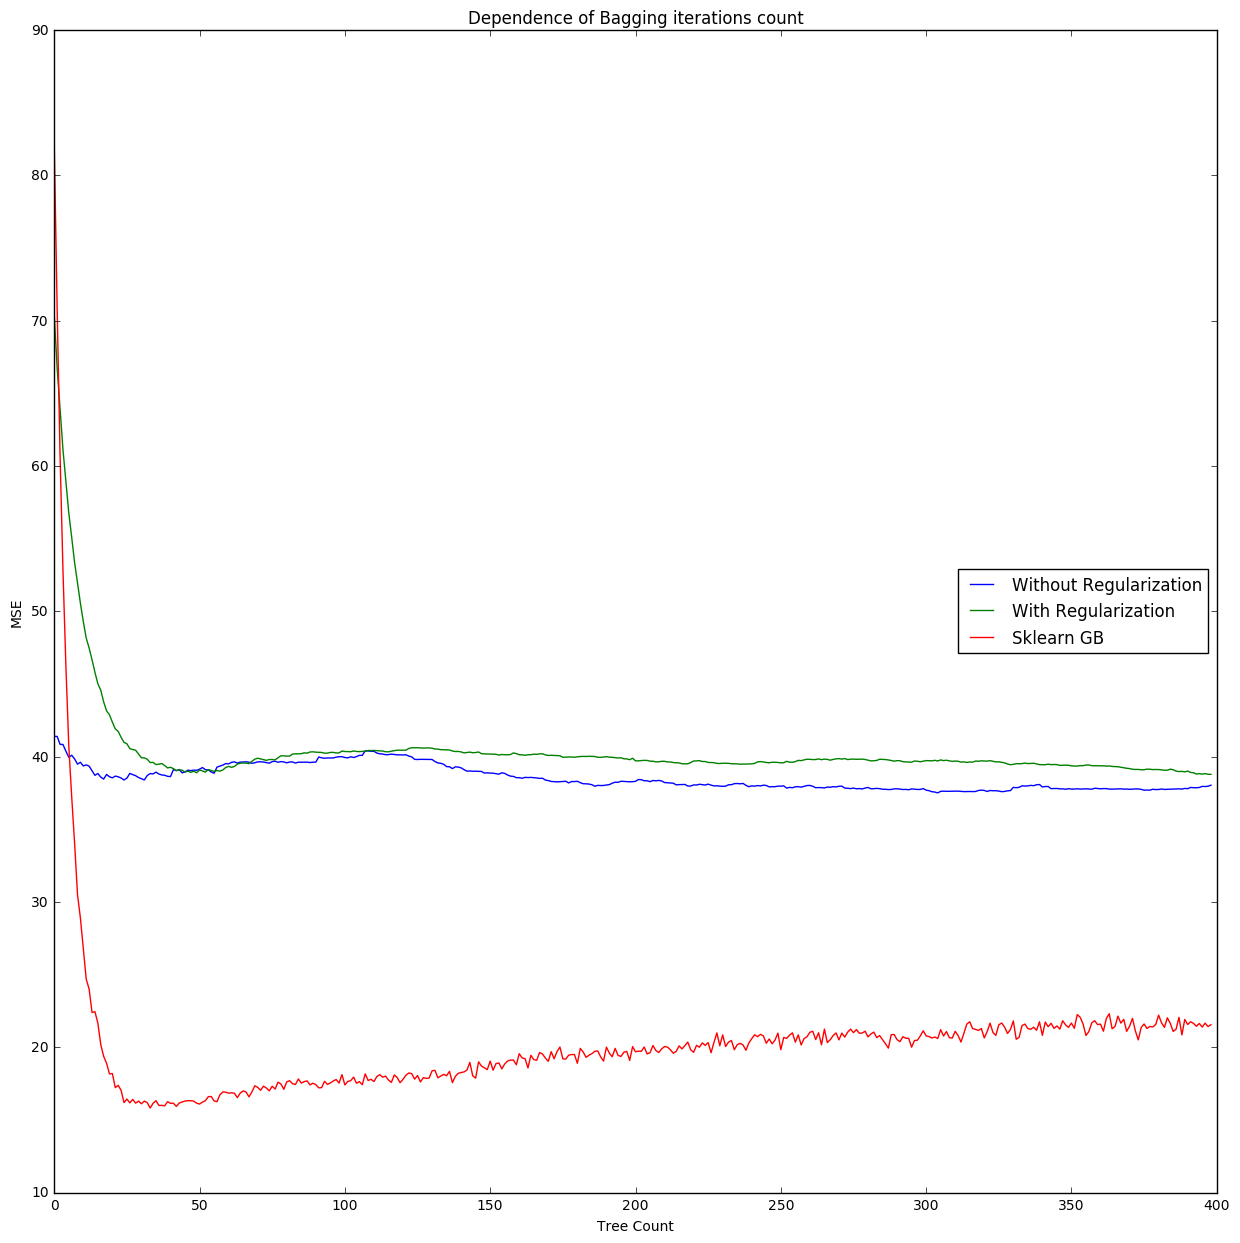

In [129]:
fig, ax = plt.subplots(figsize = (15, 15))
# for k in error_stat.keys():
    
#     plt.plot(range(0, 150), error_stat[k], label='BagBoo, N_Boo = ' + str(k) + \
#                                                  ', max_depth = 3, bagging_ratio=0.2')
    
plt.plot(range(0, 399), error_without_reg, label='Without Regularization')
plt.plot(range(0, 399), error_with_reg, label='With Regularization')
plt.plot(range(0, 399), skl_error, label='Sklearn GB')

ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Tree Count')
ax.set_ylabel('MSE')

In [342]:
tree_avto_obl.print_tree()

2: 97.0?
	 T->
1: 200.0?
	 T->
1: 113.0?
	 T->
1: 340.0?
	 T->
14.5
	 F->
17.25
	 F->
1: 340.0?
	 T->
14.5
	 F->
17.25
	 F->
1: 113.0?
	 T->
1: 340.0?
	 T->
18.0
	 F->
18.0
	 F->
1: 340.0?
	 T->
18.0
	 F->
18.0
	 F->
1: 200.0?
	 T->
1: 113.0?
	 T->
1: 340.0?
	 T->
21.0
	 F->
21.0
	 F->
1: 340.0?
	 T->
21.0
	 F->
21.0
	 F->
1: 113.0?
	 T->
1: 340.0?
	 T->
23.0
	 F->
23.0
	 F->
1: 340.0?
	 T->
26.5
	 F->
26.5


In [336]:
sk_avto = DecisionTreeRegressor(max_depth=4).fit(avto_data[:350], avto_target[:350])
skl_predict = sk_avto.predict(avto_data[350:392])
print ((skl_predict - avto_target[350:392])**2 / float(len(skl_predict))).sum()

24.4742424835


## House-dataset

In [130]:
house = pd.read_csv("./data/housing.data.csv", sep='\t',header=None)
house = house.values
print "Dataset Shape: ", house.shape
house_data = house[:, :13]
house_target = house[:, 13]

house_train_data = house_data[:450]
house_test_data = house_data[450:]
house_train_target = house_target[:450]
house_test_target = house_target[450:]

Dataset Shape:  (506, 14)


In [131]:
boo_list = range(1, 200, 1)
skl_error_house = [MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=3, n_estimators=boo).fit(house_train_data, \
                                        house_train_target).predict(house_test_data), house_test_target) \
            for boo in boo_list]

In [132]:
%%time
gb_house = Gradient_Boosting(n_estimators=200, max_depth=3, shrinkage=0.1)    
error_without_reg_house = gb_house.fit(house_train_data, house_train_target, 1, house_test_data,  \
                               house_test_target, leaf_regularization = False)

print "MSE Error on train dataset: ", MSE(gb_house.predict(house_train_data), house_train_target)
print "MSE Error on test dataset: ", MSE(gb_house.predict(house_test_data), house_test_target)



MSE on test Dataset: 26.3763469283 Iteration of Boosting: 1
MSE on train Dataset: 54.812814511 Iteration of Boosting: 1


Learning estimator number: 1/200; MSE error on train dataset: 54.812814511


MSE on test Dataset: 26.3475031114 Iteration of Boosting: 2
MSE on train Dataset: 54.2917441213 Iteration of Boosting: 2


Learning estimator number: 2/200; MSE error on train dataset: 54.2917441213


MSE on test Dataset: 26.3884526505 Iteration of Boosting: 3
MSE on train Dataset: 53.8601768791 Iteration of Boosting: 3


Learning estimator number: 3/200; MSE error on train dataset: 53.8601768791


MSE on test Dataset: 26.597393414 Iteration of Boosting: 4
MSE on train Dataset: 52.9645736497 Iteration of Boosting: 4


Learning estimator number: 4/200; MSE error on train dataset: 52.9645736497


MSE on test Dataset: 26.5763661276 Iteration of Boosting: 5
MSE on train Dataset: 52.5320282981 Iteration of Boosting: 5


Learning estimator number: 5/200; MSE error on train dataset: 52.5320282981


MSE on test Dataset: 26.4431897003 Iteration of Boosting: 6
MSE on train Dataset: 51.5353651417 Iteration of Boosting: 6


Learning estimator number: 6/200; MSE error on train dataset: 51.5353651417


MSE on test Dataset: 26.4684468601 Iteration of Boosting: 7
MSE on train Dataset: 51.0392501519 Iteration of Boosting: 7


Learning estimator number: 7/200; MSE error on train dataset: 51.0392501519


MSE on test Dataset: 26.3544408426 Iteration of Boosting: 8
MSE on train Dataset: 50.2359201946 Iteration of Boosting: 8


Learning estimator number: 8/200; MSE error on train dataset: 50.2359201946


MSE on test Dataset: 26.3324126452 Iteration of Boosting: 9
MSE on train Dataset: 49.9257313677 Iteration of Boosting: 9


Learning estimator number: 9/200; MSE error on train dataset: 49.9257313677


MSE on test Dataset: 26.3545427237 Iteration of Boosting: 10
MSE on train Dataset: 49.5666617117 Iteration of Boosting: 10


Learning estimator number: 10/200; MSE error on train dataset: 49.5666617117


MSE on test Dataset: 26.2586729145 Iteration of Boosting: 11
MSE on train Dataset: 48.9159787202 Iteration of Boosting: 11


Learning estimator number: 11/200; MSE error on train dataset: 48.9159787202


MSE on test Dataset: 26.2957208949 Iteration of Boosting: 12
MSE on train Dataset: 48.6799558382 Iteration of Boosting: 12


Learning estimator number: 12/200; MSE error on train dataset: 48.6799558382


MSE on test Dataset: 26.2984950219 Iteration of Boosting: 13
MSE on train Dataset: 48.3474568655 Iteration of Boosting: 13


Learning estimator number: 13/200; MSE error on train dataset: 48.3474568655


MSE on test Dataset: 26.2137277387 Iteration of Boosting: 14
MSE on train Dataset: 47.8253507052 Iteration of Boosting: 14


Learning estimator number: 14/200; MSE error on train dataset: 47.8253507052


MSE on test Dataset: 26.1930707448 Iteration of Boosting: 15
MSE on train Dataset: 47.645890288 Iteration of Boosting: 15


Learning estimator number: 15/200; MSE error on train dataset: 47.645890288


MSE on test Dataset: 26.1853583015 Iteration of Boosting: 16
MSE on train Dataset: 47.1585599756 Iteration of Boosting: 16


Learning estimator number: 16/200; MSE error on train dataset: 47.1585599756


MSE on test Dataset: 26.1135952218 Iteration of Boosting: 17
MSE on train Dataset: 46.7937980255 Iteration of Boosting: 17


Learning estimator number: 17/200; MSE error on train dataset: 46.7937980255


MSE on test Dataset: 26.112236902 Iteration of Boosting: 18
MSE on train Dataset: 46.5396877973 Iteration of Boosting: 18


Learning estimator number: 18/200; MSE error on train dataset: 46.5396877973


MSE on test Dataset: 26.0083509757 Iteration of Boosting: 19
MSE on train Dataset: 46.3509151279 Iteration of Boosting: 19


Learning estimator number: 19/200; MSE error on train dataset: 46.3509151279


MSE on test Dataset: 25.9879308588 Iteration of Boosting: 20
MSE on train Dataset: 46.2211114557 Iteration of Boosting: 20


Learning estimator number: 20/200; MSE error on train dataset: 46.2211114557


MSE on test Dataset: 25.919831433 Iteration of Boosting: 21
MSE on train Dataset: 45.9290751326 Iteration of Boosting: 21


Learning estimator number: 21/200; MSE error on train dataset: 45.9290751326


MSE on test Dataset: 25.952128816 Iteration of Boosting: 22
MSE on train Dataset: 45.8725718284 Iteration of Boosting: 22


Learning estimator number: 22/200; MSE error on train dataset: 45.8725718284


MSE on test Dataset: 25.9487168615 Iteration of Boosting: 23
MSE on train Dataset: 45.2702367666 Iteration of Boosting: 23


Learning estimator number: 23/200; MSE error on train dataset: 45.2702367666


MSE on test Dataset: 25.8453118221 Iteration of Boosting: 24
MSE on train Dataset: 44.9923418216 Iteration of Boosting: 24


Learning estimator number: 24/200; MSE error on train dataset: 44.9923418216


MSE on test Dataset: 25.8457827314 Iteration of Boosting: 25
MSE on train Dataset: 44.799726451 Iteration of Boosting: 25


Learning estimator number: 25/200; MSE error on train dataset: 44.799726451


MSE on test Dataset: 25.8759545056 Iteration of Boosting: 26
MSE on train Dataset: 44.7552259951 Iteration of Boosting: 26


Learning estimator number: 26/200; MSE error on train dataset: 44.7552259951


MSE on test Dataset: 25.9119011944 Iteration of Boosting: 27
MSE on train Dataset: 44.3887981851 Iteration of Boosting: 27


Learning estimator number: 27/200; MSE error on train dataset: 44.3887981851


MSE on test Dataset: 25.6345726802 Iteration of Boosting: 28
MSE on train Dataset: 44.3199828992 Iteration of Boosting: 28


Learning estimator number: 28/200; MSE error on train dataset: 44.3199828992


MSE on test Dataset: 25.612848771 Iteration of Boosting: 29
MSE on train Dataset: 44.0538730051 Iteration of Boosting: 29


Learning estimator number: 29/200; MSE error on train dataset: 44.0538730051


MSE on test Dataset: 25.5949331024 Iteration of Boosting: 30
MSE on train Dataset: 43.9563841401 Iteration of Boosting: 30


Learning estimator number: 30/200; MSE error on train dataset: 43.9563841401


MSE on test Dataset: 25.5836779409 Iteration of Boosting: 31
MSE on train Dataset: 43.4937857458 Iteration of Boosting: 31


Learning estimator number: 31/200; MSE error on train dataset: 43.4937857458


MSE on test Dataset: 25.3614597875 Iteration of Boosting: 32
MSE on train Dataset: 43.28901632 Iteration of Boosting: 32


Learning estimator number: 32/200; MSE error on train dataset: 43.28901632


MSE on test Dataset: 25.3960817612 Iteration of Boosting: 33
MSE on train Dataset: 42.9917350844 Iteration of Boosting: 33


Learning estimator number: 33/200; MSE error on train dataset: 42.9917350844


MSE on test Dataset: 25.3754084534 Iteration of Boosting: 34
MSE on train Dataset: 42.7784263853 Iteration of Boosting: 34


Learning estimator number: 34/200; MSE error on train dataset: 42.7784263853


MSE on test Dataset: 25.4015586244 Iteration of Boosting: 35
MSE on train Dataset: 42.7394289159 Iteration of Boosting: 35


Learning estimator number: 35/200; MSE error on train dataset: 42.7394289159


MSE on test Dataset: 25.4009250555 Iteration of Boosting: 36
MSE on train Dataset: 42.3561753817 Iteration of Boosting: 36


Learning estimator number: 36/200; MSE error on train dataset: 42.3561753817


MSE on test Dataset: 25.2016411558 Iteration of Boosting: 37
MSE on train Dataset: 42.1482069505 Iteration of Boosting: 37


Learning estimator number: 37/200; MSE error on train dataset: 42.1482069505


MSE on test Dataset: 25.1503975118 Iteration of Boosting: 38
MSE on train Dataset: 41.6933693988 Iteration of Boosting: 38


Learning estimator number: 38/200; MSE error on train dataset: 41.6933693988


MSE on test Dataset: 25.0856645624 Iteration of Boosting: 39
MSE on train Dataset: 41.5713160456 Iteration of Boosting: 39


Learning estimator number: 39/200; MSE error on train dataset: 41.5713160456


MSE on test Dataset: 25.1190968298 Iteration of Boosting: 40
MSE on train Dataset: 41.3320844751 Iteration of Boosting: 40


Learning estimator number: 40/200; MSE error on train dataset: 41.3320844751


MSE on test Dataset: 25.1001614357 Iteration of Boosting: 41
MSE on train Dataset: 41.1194750995 Iteration of Boosting: 41


Learning estimator number: 41/200; MSE error on train dataset: 41.1194750995


MSE on test Dataset: 25.0970052476 Iteration of Boosting: 42
MSE on train Dataset: 41.0573199321 Iteration of Boosting: 42


Learning estimator number: 42/200; MSE error on train dataset: 41.0573199321


MSE on test Dataset: 25.09271746 Iteration of Boosting: 43
MSE on train Dataset: 40.9112711903 Iteration of Boosting: 43


Learning estimator number: 43/200; MSE error on train dataset: 40.9112711903


MSE on test Dataset: 25.0768531644 Iteration of Boosting: 44
MSE on train Dataset: 40.7439398385 Iteration of Boosting: 44


Learning estimator number: 44/200; MSE error on train dataset: 40.7439398385


MSE on test Dataset: 25.0997211824 Iteration of Boosting: 45
MSE on train Dataset: 40.7145425344 Iteration of Boosting: 45


Learning estimator number: 45/200; MSE error on train dataset: 40.7145425344


MSE on test Dataset: 25.2150266049 Iteration of Boosting: 46
MSE on train Dataset: 40.4998024319 Iteration of Boosting: 46


Learning estimator number: 46/200; MSE error on train dataset: 40.4998024319


MSE on test Dataset: 25.1587613382 Iteration of Boosting: 47
MSE on train Dataset: 40.3950747325 Iteration of Boosting: 47


Learning estimator number: 47/200; MSE error on train dataset: 40.3950747325


MSE on test Dataset: 25.1804259389 Iteration of Boosting: 48
MSE on train Dataset: 40.2478997646 Iteration of Boosting: 48


Learning estimator number: 48/200; MSE error on train dataset: 40.2478997646


MSE on test Dataset: 25.1776840592 Iteration of Boosting: 49
MSE on train Dataset: 40.200836438 Iteration of Boosting: 49


Learning estimator number: 49/200; MSE error on train dataset: 40.200836438


MSE on test Dataset: 25.1733750858 Iteration of Boosting: 50
MSE on train Dataset: 40.0876013718 Iteration of Boosting: 50


Learning estimator number: 50/200; MSE error on train dataset: 40.0876013718


MSE on test Dataset: 25.155304376 Iteration of Boosting: 51
MSE on train Dataset: 39.9146618602 Iteration of Boosting: 51


Learning estimator number: 51/200; MSE error on train dataset: 39.9146618602


MSE on test Dataset: 25.1770777782 Iteration of Boosting: 52
MSE on train Dataset: 39.8880824163 Iteration of Boosting: 52


Learning estimator number: 52/200; MSE error on train dataset: 39.8880824163


MSE on test Dataset: 25.238250875 Iteration of Boosting: 53
MSE on train Dataset: 39.2805685894 Iteration of Boosting: 53


Learning estimator number: 53/200; MSE error on train dataset: 39.2805685894


MSE on test Dataset: 25.0749821738 Iteration of Boosting: 54
MSE on train Dataset: 39.1295730866 Iteration of Boosting: 54


Learning estimator number: 54/200; MSE error on train dataset: 39.1295730866


MSE on test Dataset: 24.9132556172 Iteration of Boosting: 55
MSE on train Dataset: 38.7268842895 Iteration of Boosting: 55


Learning estimator number: 55/200; MSE error on train dataset: 38.7268842895


MSE on test Dataset: 24.8935401428 Iteration of Boosting: 56
MSE on train Dataset: 38.6195069569 Iteration of Boosting: 56


Learning estimator number: 56/200; MSE error on train dataset: 38.6195069569


MSE on test Dataset: 24.9553035357 Iteration of Boosting: 57
MSE on train Dataset: 38.1230628057 Iteration of Boosting: 57


Learning estimator number: 57/200; MSE error on train dataset: 38.1230628057


MSE on test Dataset: 24.8969272171 Iteration of Boosting: 58
MSE on train Dataset: 38.0408181746 Iteration of Boosting: 58


Learning estimator number: 58/200; MSE error on train dataset: 38.0408181746


MSE on test Dataset: 24.8942298682 Iteration of Boosting: 59
MSE on train Dataset: 38.0031043702 Iteration of Boosting: 59


Learning estimator number: 59/200; MSE error on train dataset: 38.0031043702


MSE on test Dataset: 24.7536479168 Iteration of Boosting: 60
MSE on train Dataset: 37.6770182056 Iteration of Boosting: 60


Learning estimator number: 60/200; MSE error on train dataset: 37.6770182056


MSE on test Dataset: 24.1790016158 Iteration of Boosting: 61
MSE on train Dataset: 37.0689477602 Iteration of Boosting: 61


Learning estimator number: 61/200; MSE error on train dataset: 37.0689477602


MSE on test Dataset: 24.1957836346 Iteration of Boosting: 62
MSE on train Dataset: 36.9087507495 Iteration of Boosting: 62


Learning estimator number: 62/200; MSE error on train dataset: 36.9087507495


MSE on test Dataset: 24.1308697769 Iteration of Boosting: 63
MSE on train Dataset: 36.7063906807 Iteration of Boosting: 63


Learning estimator number: 63/200; MSE error on train dataset: 36.7063906807


MSE on test Dataset: 24.1045799792 Iteration of Boosting: 64
MSE on train Dataset: 36.5628960955 Iteration of Boosting: 64


Learning estimator number: 64/200; MSE error on train dataset: 36.5628960955


MSE on test Dataset: 24.2885060417 Iteration of Boosting: 65
MSE on train Dataset: 36.3501188158 Iteration of Boosting: 65


Learning estimator number: 65/200; MSE error on train dataset: 36.3501188158


MSE on test Dataset: 24.2660869946 Iteration of Boosting: 66
MSE on train Dataset: 36.2456181953 Iteration of Boosting: 66


Learning estimator number: 66/200; MSE error on train dataset: 36.2456181953


MSE on test Dataset: 24.2239348286 Iteration of Boosting: 67
MSE on train Dataset: 35.9328421332 Iteration of Boosting: 67


Learning estimator number: 67/200; MSE error on train dataset: 35.9328421332


MSE on test Dataset: 24.0940180381 Iteration of Boosting: 68
MSE on train Dataset: 35.6669229676 Iteration of Boosting: 68


Learning estimator number: 68/200; MSE error on train dataset: 35.6669229676


MSE on test Dataset: 23.6900328424 Iteration of Boosting: 69
MSE on train Dataset: 35.1757669933 Iteration of Boosting: 69


Learning estimator number: 69/200; MSE error on train dataset: 35.1757669933


MSE on test Dataset: 23.6475367684 Iteration of Boosting: 70
MSE on train Dataset: 35.1051386843 Iteration of Boosting: 70


Learning estimator number: 70/200; MSE error on train dataset: 35.1051386843


MSE on test Dataset: 23.4022877161 Iteration of Boosting: 71
MSE on train Dataset: 34.7460107739 Iteration of Boosting: 71


Learning estimator number: 71/200; MSE error on train dataset: 34.7460107739


MSE on test Dataset: 23.2214754206 Iteration of Boosting: 72
MSE on train Dataset: 34.6393825062 Iteration of Boosting: 72


Learning estimator number: 72/200; MSE error on train dataset: 34.6393825062


MSE on test Dataset: 23.2192291403 Iteration of Boosting: 73
MSE on train Dataset: 34.6084181982 Iteration of Boosting: 73


Learning estimator number: 73/200; MSE error on train dataset: 34.6084181982


MSE on test Dataset: 23.3054554552 Iteration of Boosting: 74
MSE on train Dataset: 34.4682719645 Iteration of Boosting: 74


Learning estimator number: 74/200; MSE error on train dataset: 34.4682719645


MSE on test Dataset: 23.2491795197 Iteration of Boosting: 75
MSE on train Dataset: 34.3149863454 Iteration of Boosting: 75


Learning estimator number: 75/200; MSE error on train dataset: 34.3149863454


MSE on test Dataset: 23.0678503147 Iteration of Boosting: 76
MSE on train Dataset: 34.0230107104 Iteration of Boosting: 76


Learning estimator number: 76/200; MSE error on train dataset: 34.0230107104


MSE on test Dataset: 23.0388716831 Iteration of Boosting: 77
MSE on train Dataset: 33.7686604659 Iteration of Boosting: 77


Learning estimator number: 77/200; MSE error on train dataset: 33.7686604659


MSE on test Dataset: 23.0006459969 Iteration of Boosting: 78
MSE on train Dataset: 33.7052585671 Iteration of Boosting: 78


Learning estimator number: 78/200; MSE error on train dataset: 33.7052585671


MSE on test Dataset: 23.0128881501 Iteration of Boosting: 79
MSE on train Dataset: 33.5912631794 Iteration of Boosting: 79


Learning estimator number: 79/200; MSE error on train dataset: 33.5912631794


MSE on test Dataset: 22.9971307537 Iteration of Boosting: 80
MSE on train Dataset: 33.5150429574 Iteration of Boosting: 80


Learning estimator number: 80/200; MSE error on train dataset: 33.5150429574


MSE on test Dataset: 22.8209665939 Iteration of Boosting: 81
MSE on train Dataset: 33.4708278349 Iteration of Boosting: 81


Learning estimator number: 81/200; MSE error on train dataset: 33.4708278349


MSE on test Dataset: 22.7705793225 Iteration of Boosting: 82
MSE on train Dataset: 33.3759033379 Iteration of Boosting: 82


Learning estimator number: 82/200; MSE error on train dataset: 33.3759033379


MSE on test Dataset: 22.8252262274 Iteration of Boosting: 83
MSE on train Dataset: 33.0233038463 Iteration of Boosting: 83


Learning estimator number: 83/200; MSE error on train dataset: 33.0233038463


MSE on test Dataset: 22.6539057658 Iteration of Boosting: 84
MSE on train Dataset: 32.9846886754 Iteration of Boosting: 84


Learning estimator number: 84/200; MSE error on train dataset: 32.9846886754


MSE on test Dataset: 22.6516578659 Iteration of Boosting: 85
MSE on train Dataset: 32.9603944849 Iteration of Boosting: 85


Learning estimator number: 85/200; MSE error on train dataset: 32.9603944849


MSE on test Dataset: 22.659215699 Iteration of Boosting: 86
MSE on train Dataset: 32.7821546014 Iteration of Boosting: 86


Learning estimator number: 86/200; MSE error on train dataset: 32.7821546014


MSE on test Dataset: 22.6446211183 Iteration of Boosting: 87
MSE on train Dataset: 32.7201010094 Iteration of Boosting: 87


Learning estimator number: 87/200; MSE error on train dataset: 32.7201010094


MSE on test Dataset: 22.6557305312 Iteration of Boosting: 88
MSE on train Dataset: 32.6945538535 Iteration of Boosting: 88


Learning estimator number: 88/200; MSE error on train dataset: 32.6945538535


MSE on test Dataset: 22.6642267351 Iteration of Boosting: 89
MSE on train Dataset: 32.6151622711 Iteration of Boosting: 89


Learning estimator number: 89/200; MSE error on train dataset: 32.6151622711


MSE on test Dataset: 22.5111488086 Iteration of Boosting: 90
MSE on train Dataset: 32.2400193618 Iteration of Boosting: 90


Learning estimator number: 90/200; MSE error on train dataset: 32.2400193618


MSE on test Dataset: 22.4835964329 Iteration of Boosting: 91
MSE on train Dataset: 32.1639194079 Iteration of Boosting: 91


Learning estimator number: 91/200; MSE error on train dataset: 32.1639194079


MSE on test Dataset: 22.5190204982 Iteration of Boosting: 92
MSE on train Dataset: 32.0355480853 Iteration of Boosting: 92


Learning estimator number: 92/200; MSE error on train dataset: 32.0355480853


MSE on test Dataset: 22.4798677308 Iteration of Boosting: 93
MSE on train Dataset: 31.9156349673 Iteration of Boosting: 93


Learning estimator number: 93/200; MSE error on train dataset: 31.9156349673


MSE on test Dataset: 22.4480599661 Iteration of Boosting: 94
MSE on train Dataset: 31.8659993785 Iteration of Boosting: 94


Learning estimator number: 94/200; MSE error on train dataset: 31.8659993785


MSE on test Dataset: 22.3566528066 Iteration of Boosting: 95
MSE on train Dataset: 31.6360663229 Iteration of Boosting: 95


Learning estimator number: 95/200; MSE error on train dataset: 31.6360663229


MSE on test Dataset: 22.3671458995 Iteration of Boosting: 96
MSE on train Dataset: 31.614099194 Iteration of Boosting: 96


Learning estimator number: 96/200; MSE error on train dataset: 31.614099194


MSE on test Dataset: 23.0830890138 Iteration of Boosting: 97
MSE on train Dataset: 31.197606256 Iteration of Boosting: 97


Learning estimator number: 97/200; MSE error on train dataset: 31.197606256


MSE on test Dataset: 23.151076848 Iteration of Boosting: 98
MSE on train Dataset: 31.1005203582 Iteration of Boosting: 98


Learning estimator number: 98/200; MSE error on train dataset: 31.1005203582


MSE on test Dataset: 23.1098884919 Iteration of Boosting: 99
MSE on train Dataset: 30.9926089516 Iteration of Boosting: 99


Learning estimator number: 99/200; MSE error on train dataset: 30.9926089516


MSE on test Dataset: 23.1893411802 Iteration of Boosting: 100
MSE on train Dataset: 30.9516793017 Iteration of Boosting: 100


Learning estimator number: 100/200; MSE error on train dataset: 30.9516793017


MSE on test Dataset: 24.1771098306 Iteration of Boosting: 101
MSE on train Dataset: 30.5957708452 Iteration of Boosting: 101


Learning estimator number: 101/200; MSE error on train dataset: 30.5957708452


MSE on test Dataset: 24.180632244 Iteration of Boosting: 102
MSE on train Dataset: 30.5565659895 Iteration of Boosting: 102


Learning estimator number: 102/200; MSE error on train dataset: 30.5565659895


MSE on test Dataset: 24.1487101173 Iteration of Boosting: 103
MSE on train Dataset: 30.4593412785 Iteration of Boosting: 103


Learning estimator number: 103/200; MSE error on train dataset: 30.4593412785


MSE on test Dataset: 24.2126483403 Iteration of Boosting: 104
MSE on train Dataset: 30.3810830339 Iteration of Boosting: 104


Learning estimator number: 104/200; MSE error on train dataset: 30.3810830339


MSE on test Dataset: 24.1760443946 Iteration of Boosting: 105
MSE on train Dataset: 30.3262103097 Iteration of Boosting: 105


Learning estimator number: 105/200; MSE error on train dataset: 30.3262103097


MSE on test Dataset: 24.2799081153 Iteration of Boosting: 106
MSE on train Dataset: 29.9564847509 Iteration of Boosting: 106


Learning estimator number: 106/200; MSE error on train dataset: 29.9564847509


MSE on test Dataset: 24.2231561714 Iteration of Boosting: 107
MSE on train Dataset: 29.7685827407 Iteration of Boosting: 107


Learning estimator number: 107/200; MSE error on train dataset: 29.7685827407


MSE on test Dataset: 24.2417295183 Iteration of Boosting: 108
MSE on train Dataset: 29.7302788431 Iteration of Boosting: 108


Learning estimator number: 108/200; MSE error on train dataset: 29.7302788431


MSE on test Dataset: 24.2473395125 Iteration of Boosting: 109
MSE on train Dataset: 29.6552439936 Iteration of Boosting: 109


Learning estimator number: 109/200; MSE error on train dataset: 29.6552439936


MSE on test Dataset: 24.2466882243 Iteration of Boosting: 110
MSE on train Dataset: 29.6340187725 Iteration of Boosting: 110


Learning estimator number: 110/200; MSE error on train dataset: 29.6340187725


MSE on test Dataset: 24.1074575344 Iteration of Boosting: 111
MSE on train Dataset: 29.6081424062 Iteration of Boosting: 111


Learning estimator number: 111/200; MSE error on train dataset: 29.6081424062


MSE on test Dataset: 24.0628035744 Iteration of Boosting: 112
MSE on train Dataset: 29.3652527175 Iteration of Boosting: 112


Learning estimator number: 112/200; MSE error on train dataset: 29.3652527175


MSE on test Dataset: 26.0489918384 Iteration of Boosting: 113
MSE on train Dataset: 29.0430121488 Iteration of Boosting: 113


Learning estimator number: 113/200; MSE error on train dataset: 29.0430121488


MSE on test Dataset: 26.0329376824 Iteration of Boosting: 114
MSE on train Dataset: 28.9395057587 Iteration of Boosting: 114


Learning estimator number: 114/200; MSE error on train dataset: 28.9395057587


MSE on test Dataset: 26.0363420594 Iteration of Boosting: 115
MSE on train Dataset: 28.8727431413 Iteration of Boosting: 115


Learning estimator number: 115/200; MSE error on train dataset: 28.8727431413


MSE on test Dataset: 25.9702266157 Iteration of Boosting: 116
MSE on train Dataset: 28.688542015 Iteration of Boosting: 116


Learning estimator number: 116/200; MSE error on train dataset: 28.688542015


MSE on test Dataset: 27.1431906755 Iteration of Boosting: 117
MSE on train Dataset: 28.4105543698 Iteration of Boosting: 117


Learning estimator number: 117/200; MSE error on train dataset: 28.4105543698


MSE on test Dataset: 27.044609554 Iteration of Boosting: 118
MSE on train Dataset: 28.3105566801 Iteration of Boosting: 118


Learning estimator number: 118/200; MSE error on train dataset: 28.3105566801


MSE on test Dataset: 27.2050351888 Iteration of Boosting: 119
MSE on train Dataset: 28.203018108 Iteration of Boosting: 119


Learning estimator number: 119/200; MSE error on train dataset: 28.203018108


MSE on test Dataset: 27.1431087232 Iteration of Boosting: 120
MSE on train Dataset: 28.052961603 Iteration of Boosting: 120


Learning estimator number: 120/200; MSE error on train dataset: 28.052961603


MSE on test Dataset: 27.165453728 Iteration of Boosting: 121
MSE on train Dataset: 27.9837246844 Iteration of Boosting: 121


Learning estimator number: 121/200; MSE error on train dataset: 27.9837246844


MSE on test Dataset: 27.0753498472 Iteration of Boosting: 122
MSE on train Dataset: 27.9022928933 Iteration of Boosting: 122


Learning estimator number: 122/200; MSE error on train dataset: 27.9022928933


MSE on test Dataset: 27.0588357458 Iteration of Boosting: 123
MSE on train Dataset: 27.8548930198 Iteration of Boosting: 123


Learning estimator number: 123/200; MSE error on train dataset: 27.8548930198


MSE on test Dataset: 27.1623450864 Iteration of Boosting: 124
MSE on train Dataset: 27.5798325512 Iteration of Boosting: 124


Learning estimator number: 124/200; MSE error on train dataset: 27.5798325512


MSE on test Dataset: 28.6214255007 Iteration of Boosting: 125
MSE on train Dataset: 27.1554255942 Iteration of Boosting: 125


Learning estimator number: 125/200; MSE error on train dataset: 27.1554255942


MSE on test Dataset: 28.5631587286 Iteration of Boosting: 126
MSE on train Dataset: 26.9079065913 Iteration of Boosting: 126


Learning estimator number: 126/200; MSE error on train dataset: 26.9079065913


MSE on test Dataset: 28.503250969 Iteration of Boosting: 127
MSE on train Dataset: 26.784882316 Iteration of Boosting: 127


Learning estimator number: 127/200; MSE error on train dataset: 26.784882316


MSE on test Dataset: 28.5431791216 Iteration of Boosting: 128
MSE on train Dataset: 26.6957691529 Iteration of Boosting: 128


Learning estimator number: 128/200; MSE error on train dataset: 26.6957691529


MSE on test Dataset: 28.5099230628 Iteration of Boosting: 129
MSE on train Dataset: 26.6521508139 Iteration of Boosting: 129


Learning estimator number: 129/200; MSE error on train dataset: 26.6521508139


MSE on test Dataset: 28.4566270251 Iteration of Boosting: 130
MSE on train Dataset: 26.5870233042 Iteration of Boosting: 130


Learning estimator number: 130/200; MSE error on train dataset: 26.5870233042


MSE on test Dataset: 28.4638924352 Iteration of Boosting: 131
MSE on train Dataset: 26.4150770683 Iteration of Boosting: 131


Learning estimator number: 131/200; MSE error on train dataset: 26.4150770683


MSE on test Dataset: 28.365637999 Iteration of Boosting: 132
MSE on train Dataset: 26.200052904 Iteration of Boosting: 132


Learning estimator number: 132/200; MSE error on train dataset: 26.200052904


MSE on test Dataset: 28.3898064882 Iteration of Boosting: 133
MSE on train Dataset: 26.1077645697 Iteration of Boosting: 133


Learning estimator number: 133/200; MSE error on train dataset: 26.1077645697


MSE on test Dataset: 29.715446749 Iteration of Boosting: 134
MSE on train Dataset: 25.8773832999 Iteration of Boosting: 134


Learning estimator number: 134/200; MSE error on train dataset: 25.8773832999


MSE on test Dataset: 29.6774629522 Iteration of Boosting: 135
MSE on train Dataset: 25.811931241 Iteration of Boosting: 135


Learning estimator number: 135/200; MSE error on train dataset: 25.811931241


MSE on test Dataset: 29.6682258475 Iteration of Boosting: 136
MSE on train Dataset: 25.6773391531 Iteration of Boosting: 136


Learning estimator number: 136/200; MSE error on train dataset: 25.6773391531


MSE on test Dataset: 29.6343129692 Iteration of Boosting: 137
MSE on train Dataset: 25.655866369 Iteration of Boosting: 137


Learning estimator number: 137/200; MSE error on train dataset: 25.655866369


MSE on test Dataset: 29.5834520698 Iteration of Boosting: 138
MSE on train Dataset: 25.6057222233 Iteration of Boosting: 138


Learning estimator number: 138/200; MSE error on train dataset: 25.6057222233


MSE on test Dataset: 29.624758822 Iteration of Boosting: 139
MSE on train Dataset: 25.5328628786 Iteration of Boosting: 139


Learning estimator number: 139/200; MSE error on train dataset: 25.5328628786


MSE on test Dataset: 31.0022654067 Iteration of Boosting: 140
MSE on train Dataset: 25.3458902397 Iteration of Boosting: 140


Learning estimator number: 140/200; MSE error on train dataset: 25.3458902397


MSE on test Dataset: 30.9212154571 Iteration of Boosting: 141
MSE on train Dataset: 25.2898117798 Iteration of Boosting: 141


Learning estimator number: 141/200; MSE error on train dataset: 25.2898117798


MSE on test Dataset: 30.9024229534 Iteration of Boosting: 142
MSE on train Dataset: 25.1649017194 Iteration of Boosting: 142


Learning estimator number: 142/200; MSE error on train dataset: 25.1649017194


MSE on test Dataset: 30.8421120793 Iteration of Boosting: 143
MSE on train Dataset: 24.9752927369 Iteration of Boosting: 143


Learning estimator number: 143/200; MSE error on train dataset: 24.9752927369


MSE on test Dataset: 32.9402424204 Iteration of Boosting: 144
MSE on train Dataset: 24.6319591511 Iteration of Boosting: 144


Learning estimator number: 144/200; MSE error on train dataset: 24.6319591511


MSE on test Dataset: 32.9007206855 Iteration of Boosting: 145
MSE on train Dataset: 24.5476867291 Iteration of Boosting: 145


Learning estimator number: 145/200; MSE error on train dataset: 24.5476867291


MSE on test Dataset: 32.8721489489 Iteration of Boosting: 146
MSE on train Dataset: 24.4754831096 Iteration of Boosting: 146


Learning estimator number: 146/200; MSE error on train dataset: 24.4754831096


MSE on test Dataset: 32.8667490833 Iteration of Boosting: 147
MSE on train Dataset: 24.4406078505 Iteration of Boosting: 147


Learning estimator number: 147/200; MSE error on train dataset: 24.4406078505


MSE on test Dataset: 32.8680049828 Iteration of Boosting: 148
MSE on train Dataset: 24.3991509973 Iteration of Boosting: 148


Learning estimator number: 148/200; MSE error on train dataset: 24.3991509973


MSE on test Dataset: 32.8134631578 Iteration of Boosting: 149
MSE on train Dataset: 24.3101104149 Iteration of Boosting: 149


Learning estimator number: 149/200; MSE error on train dataset: 24.3101104149


MSE on test Dataset: 32.8224284996 Iteration of Boosting: 150
MSE on train Dataset: 24.2866212269 Iteration of Boosting: 150


Learning estimator number: 150/200; MSE error on train dataset: 24.2866212269


MSE on test Dataset: 32.8177026736 Iteration of Boosting: 151
MSE on train Dataset: 24.1525514405 Iteration of Boosting: 151


Learning estimator number: 151/200; MSE error on train dataset: 24.1525514405


MSE on test Dataset: 32.7960004469 Iteration of Boosting: 152
MSE on train Dataset: 24.0512361017 Iteration of Boosting: 152


Learning estimator number: 152/200; MSE error on train dataset: 24.0512361017


MSE on test Dataset: 32.7472321761 Iteration of Boosting: 153
MSE on train Dataset: 24.0131515192 Iteration of Boosting: 153


Learning estimator number: 153/200; MSE error on train dataset: 24.0131515192


MSE on test Dataset: 32.7844991879 Iteration of Boosting: 154
MSE on train Dataset: 23.9541989424 Iteration of Boosting: 154


Learning estimator number: 154/200; MSE error on train dataset: 23.9541989424


MSE on test Dataset: 32.7502903208 Iteration of Boosting: 155
MSE on train Dataset: 23.8843852349 Iteration of Boosting: 155


Learning estimator number: 155/200; MSE error on train dataset: 23.8843852349


MSE on test Dataset: 32.7363294035 Iteration of Boosting: 156
MSE on train Dataset: 23.8183141744 Iteration of Boosting: 156


Learning estimator number: 156/200; MSE error on train dataset: 23.8183141744


MSE on test Dataset: 32.7233605411 Iteration of Boosting: 157
MSE on train Dataset: 23.7599997749 Iteration of Boosting: 157


Learning estimator number: 157/200; MSE error on train dataset: 23.7599997749


MSE on test Dataset: 32.741577078 Iteration of Boosting: 158
MSE on train Dataset: 23.7202473906 Iteration of Boosting: 158


Learning estimator number: 158/200; MSE error on train dataset: 23.7202473906


MSE on test Dataset: 32.68640645 Iteration of Boosting: 159
MSE on train Dataset: 23.6685992983 Iteration of Boosting: 159


Learning estimator number: 159/200; MSE error on train dataset: 23.6685992983


MSE on test Dataset: 35.3975707178 Iteration of Boosting: 160
MSE on train Dataset: 23.4215142447 Iteration of Boosting: 160


Learning estimator number: 160/200; MSE error on train dataset: 23.4215142447


MSE on test Dataset: 35.3703077231 Iteration of Boosting: 161
MSE on train Dataset: 23.3387780333 Iteration of Boosting: 161


Learning estimator number: 161/200; MSE error on train dataset: 23.3387780333


MSE on test Dataset: 35.3867008109 Iteration of Boosting: 162
MSE on train Dataset: 23.2628623616 Iteration of Boosting: 162


Learning estimator number: 162/200; MSE error on train dataset: 23.2628623616


MSE on test Dataset: 35.3178356655 Iteration of Boosting: 163
MSE on train Dataset: 23.2136307323 Iteration of Boosting: 163


Learning estimator number: 163/200; MSE error on train dataset: 23.2136307323


MSE on test Dataset: 35.2855610407 Iteration of Boosting: 164
MSE on train Dataset: 23.182142594 Iteration of Boosting: 164


Learning estimator number: 164/200; MSE error on train dataset: 23.182142594


MSE on test Dataset: 35.2585803781 Iteration of Boosting: 165
MSE on train Dataset: 23.1148458623 Iteration of Boosting: 165


Learning estimator number: 165/200; MSE error on train dataset: 23.1148458623


MSE on test Dataset: 35.2625042529 Iteration of Boosting: 166
MSE on train Dataset: 22.958605412 Iteration of Boosting: 166


Learning estimator number: 166/200; MSE error on train dataset: 22.958605412


MSE on test Dataset: 35.2569029895 Iteration of Boosting: 167
MSE on train Dataset: 22.9308890642 Iteration of Boosting: 167


Learning estimator number: 167/200; MSE error on train dataset: 22.9308890642


MSE on test Dataset: 35.2434434653 Iteration of Boosting: 168
MSE on train Dataset: 22.8767393272 Iteration of Boosting: 168


Learning estimator number: 168/200; MSE error on train dataset: 22.8767393272


MSE on test Dataset: 35.1933735807 Iteration of Boosting: 169
MSE on train Dataset: 22.8038682519 Iteration of Boosting: 169


Learning estimator number: 169/200; MSE error on train dataset: 22.8038682519


MSE on test Dataset: 35.1853987861 Iteration of Boosting: 170
MSE on train Dataset: 22.7042218913 Iteration of Boosting: 170


Learning estimator number: 170/200; MSE error on train dataset: 22.7042218913


MSE on test Dataset: 35.1505074407 Iteration of Boosting: 171
MSE on train Dataset: 22.6468793716 Iteration of Boosting: 171


Learning estimator number: 171/200; MSE error on train dataset: 22.6468793716


MSE on test Dataset: 35.1651122778 Iteration of Boosting: 172
MSE on train Dataset: 22.5300320165 Iteration of Boosting: 172


Learning estimator number: 172/200; MSE error on train dataset: 22.5300320165


MSE on test Dataset: 35.1646907181 Iteration of Boosting: 173
MSE on train Dataset: 22.4316328664 Iteration of Boosting: 173


Learning estimator number: 173/200; MSE error on train dataset: 22.4316328664


MSE on test Dataset: 36.5475367727 Iteration of Boosting: 174
MSE on train Dataset: 22.2821959512 Iteration of Boosting: 174


Learning estimator number: 174/200; MSE error on train dataset: 22.2821959512


MSE on test Dataset: 36.5017856566 Iteration of Boosting: 175
MSE on train Dataset: 22.2537388497 Iteration of Boosting: 175


Learning estimator number: 175/200; MSE error on train dataset: 22.2537388497


MSE on test Dataset: 36.518103012 Iteration of Boosting: 176
MSE on train Dataset: 22.1586732874 Iteration of Boosting: 176


Learning estimator number: 176/200; MSE error on train dataset: 22.1586732874


MSE on test Dataset: 36.5081141103 Iteration of Boosting: 177
MSE on train Dataset: 22.1221197623 Iteration of Boosting: 177


Learning estimator number: 177/200; MSE error on train dataset: 22.1221197623


MSE on test Dataset: 36.5381744168 Iteration of Boosting: 178
MSE on train Dataset: 22.0839408247 Iteration of Boosting: 178


Learning estimator number: 178/200; MSE error on train dataset: 22.0839408247


MSE on test Dataset: 36.5300479713 Iteration of Boosting: 179
MSE on train Dataset: 22.0572313239 Iteration of Boosting: 179


Learning estimator number: 179/200; MSE error on train dataset: 22.0572313239


MSE on test Dataset: 36.4452073118 Iteration of Boosting: 180
MSE on train Dataset: 21.8518094208 Iteration of Boosting: 180


Learning estimator number: 180/200; MSE error on train dataset: 21.8518094208


MSE on test Dataset: 36.4195217236 Iteration of Boosting: 181
MSE on train Dataset: 21.7971732771 Iteration of Boosting: 181


Learning estimator number: 181/200; MSE error on train dataset: 21.7971732771


MSE on test Dataset: 36.3831929272 Iteration of Boosting: 182
MSE on train Dataset: 21.7812581202 Iteration of Boosting: 182


Learning estimator number: 182/200; MSE error on train dataset: 21.7812581202


MSE on test Dataset: 36.3462532162 Iteration of Boosting: 183
MSE on train Dataset: 21.7323258809 Iteration of Boosting: 183


Learning estimator number: 183/200; MSE error on train dataset: 21.7323258809


MSE on test Dataset: 36.3039153551 Iteration of Boosting: 184
MSE on train Dataset: 21.7092055181 Iteration of Boosting: 184


Learning estimator number: 184/200; MSE error on train dataset: 21.7092055181


MSE on test Dataset: 36.2802949826 Iteration of Boosting: 185
MSE on train Dataset: 21.6588981584 Iteration of Boosting: 185


Learning estimator number: 185/200; MSE error on train dataset: 21.6588981584


MSE on test Dataset: 37.6476362269 Iteration of Boosting: 186
MSE on train Dataset: 21.5371177101 Iteration of Boosting: 186


Learning estimator number: 186/200; MSE error on train dataset: 21.5371177101


MSE on test Dataset: 37.6202941397 Iteration of Boosting: 187
MSE on train Dataset: 21.4924861154 Iteration of Boosting: 187


Learning estimator number: 187/200; MSE error on train dataset: 21.4924861154


MSE on test Dataset: 37.6215430276 Iteration of Boosting: 188
MSE on train Dataset: 21.4828751754 Iteration of Boosting: 188


Learning estimator number: 188/200; MSE error on train dataset: 21.4828751754


MSE on test Dataset: 37.5623963678 Iteration of Boosting: 189
MSE on train Dataset: 21.4442123539 Iteration of Boosting: 189


Learning estimator number: 189/200; MSE error on train dataset: 21.4442123539


MSE on test Dataset: 37.5674767028 Iteration of Boosting: 190
MSE on train Dataset: 21.4363932826 Iteration of Boosting: 190


Learning estimator number: 190/200; MSE error on train dataset: 21.4363932826


MSE on test Dataset: 37.5670977701 Iteration of Boosting: 191
MSE on train Dataset: 21.357484881 Iteration of Boosting: 191


Learning estimator number: 191/200; MSE error on train dataset: 21.357484881


MSE on test Dataset: 38.896093516 Iteration of Boosting: 192
MSE on train Dataset: 21.2586179449 Iteration of Boosting: 192


Learning estimator number: 192/200; MSE error on train dataset: 21.2586179449


MSE on test Dataset: 38.8622384542 Iteration of Boosting: 193
MSE on train Dataset: 21.2332795663 Iteration of Boosting: 193


Learning estimator number: 193/200; MSE error on train dataset: 21.2332795663


MSE on test Dataset: 38.8151905698 Iteration of Boosting: 194
MSE on train Dataset: 21.1321278888 Iteration of Boosting: 194


Learning estimator number: 194/200; MSE error on train dataset: 21.1321278888


MSE on test Dataset: 38.8630510137 Iteration of Boosting: 195
MSE on train Dataset: 21.0807404033 Iteration of Boosting: 195


Learning estimator number: 195/200; MSE error on train dataset: 21.0807404033


MSE on test Dataset: 38.7846229358 Iteration of Boosting: 196
MSE on train Dataset: 20.9160777172 Iteration of Boosting: 196


Learning estimator number: 196/200; MSE error on train dataset: 20.9160777172


MSE on test Dataset: 41.9421383083 Iteration of Boosting: 197
MSE on train Dataset: 20.7208275413 Iteration of Boosting: 197


Learning estimator number: 197/200; MSE error on train dataset: 20.7208275413


MSE on test Dataset: 41.9100606802 Iteration of Boosting: 198
MSE on train Dataset: 20.6842569897 Iteration of Boosting: 198


Learning estimator number: 198/200; MSE error on train dataset: 20.6842569897


MSE on test Dataset: 41.9041483983 Iteration of Boosting: 199
MSE on train Dataset: 20.6613237209 Iteration of Boosting: 199
MSE Error on train dataset:  20.6613237209
MSE Error on test dataset:  41.9041483983
CPU times: user 1min 10s, sys: 200 ms, total: 1min 10s
Wall time: 1min 10s


Learning estimator number: 199/200; MSE error on train dataset: 20.6613237209

In [139]:
%%time
gb_house = Gradient_Boosting(n_estimators=200, max_depth=3, shrinkage=0.05)    
error_with_reg_house = gb_house.fit(house_train_data, house_train_target, 1, house_test_data,  \
                               house_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_house.predict(house_train_data), house_train_target)
print "MSE Error on test dataset: ", MSE(gb_house.predict(house_test_data), house_test_target)



MSE on test Dataset: 23.7253261793 Iteration of Boosting: 1
MSE on train Dataset: 59.7106053789 Iteration of Boosting: 1


Learning estimator number: 1/200; MSE error on train dataset: 59.7106053789


MSE on test Dataset: 23.7922704823 Iteration of Boosting: 2
MSE on train Dataset: 59.1442584737 Iteration of Boosting: 2


Learning estimator number: 2/200; MSE error on train dataset: 59.1442584737


MSE on test Dataset: 23.8669032162 Iteration of Boosting: 3
MSE on train Dataset: 58.6951625124 Iteration of Boosting: 3


Learning estimator number: 3/200; MSE error on train dataset: 58.6951625124


MSE on test Dataset: 23.9511249616 Iteration of Boosting: 4
MSE on train Dataset: 58.2798065571 Iteration of Boosting: 4


Learning estimator number: 4/200; MSE error on train dataset: 58.2798065571


MSE on test Dataset: 24.0508587496 Iteration of Boosting: 5
MSE on train Dataset: 57.8214931635 Iteration of Boosting: 5


Learning estimator number: 5/200; MSE error on train dataset: 57.8214931635


MSE on test Dataset: 24.1502135912 Iteration of Boosting: 6
MSE on train Dataset: 57.4652921238 Iteration of Boosting: 6


Learning estimator number: 6/200; MSE error on train dataset: 57.4652921238


MSE on test Dataset: 24.2546361049 Iteration of Boosting: 7
MSE on train Dataset: 57.1351733669 Iteration of Boosting: 7


Learning estimator number: 7/200; MSE error on train dataset: 57.1351733669


MSE on test Dataset: 24.3629748817 Iteration of Boosting: 8
MSE on train Dataset: 56.8290179201 Iteration of Boosting: 8


Learning estimator number: 8/200; MSE error on train dataset: 56.8290179201


MSE on test Dataset: 24.4742178868 Iteration of Boosting: 9
MSE on train Dataset: 56.5448896282 Iteration of Boosting: 9


Learning estimator number: 9/200; MSE error on train dataset: 56.5448896282


MSE on test Dataset: 24.587477967 Iteration of Boosting: 10
MSE on train Dataset: 56.2810188546 Iteration of Boosting: 10


Learning estimator number: 10/200; MSE error on train dataset: 56.2810188546


MSE on test Dataset: 24.7019797798 Iteration of Boosting: 11
MSE on train Dataset: 56.0357876621 Iteration of Boosting: 11


Learning estimator number: 11/200; MSE error on train dataset: 56.0357876621


MSE on test Dataset: 24.8170480054 Iteration of Boosting: 12
MSE on train Dataset: 55.8077163367 Iteration of Boosting: 12


Learning estimator number: 12/200; MSE error on train dataset: 55.8077163367


MSE on test Dataset: 24.9455915495 Iteration of Boosting: 13
MSE on train Dataset: 55.5353952004 Iteration of Boosting: 13


Learning estimator number: 13/200; MSE error on train dataset: 55.5353952004


MSE on test Dataset: 25.060532144 Iteration of Boosting: 14
MSE on train Dataset: 55.3373121843 Iteration of Boosting: 14


Learning estimator number: 14/200; MSE error on train dataset: 55.3373121843


MSE on test Dataset: 25.1744799659 Iteration of Boosting: 15
MSE on train Dataset: 55.1526608002 Iteration of Boosting: 15


Learning estimator number: 15/200; MSE error on train dataset: 55.1526608002


MSE on test Dataset: 25.2870662323 Iteration of Boosting: 16
MSE on train Dataset: 54.9804036863 Iteration of Boosting: 16


Learning estimator number: 16/200; MSE error on train dataset: 54.9804036863


MSE on test Dataset: 25.2930505118 Iteration of Boosting: 17
MSE on train Dataset: 54.39990098 Iteration of Boosting: 17


Learning estimator number: 17/200; MSE error on train dataset: 54.39990098


MSE on test Dataset: 25.4000417621 Iteration of Boosting: 18
MSE on train Dataset: 54.2462025832 Iteration of Boosting: 18


Learning estimator number: 18/200; MSE error on train dataset: 54.2462025832


MSE on test Dataset: 25.5207942026 Iteration of Boosting: 19
MSE on train Dataset: 54.0475877692 Iteration of Boosting: 19


Learning estimator number: 19/200; MSE error on train dataset: 54.0475877692


MSE on test Dataset: 25.5235196393 Iteration of Boosting: 20
MSE on train Dataset: 53.527507998 Iteration of Boosting: 20


Learning estimator number: 20/200; MSE error on train dataset: 53.527507998


MSE on test Dataset: 25.6212495743 Iteration of Boosting: 21
MSE on train Dataset: 53.3981147627 Iteration of Boosting: 21


Learning estimator number: 21/200; MSE error on train dataset: 53.3981147627


MSE on test Dataset: 25.7164987949 Iteration of Boosting: 22
MSE on train Dataset: 53.2766861076 Iteration of Boosting: 22


Learning estimator number: 22/200; MSE error on train dataset: 53.2766861076


MSE on test Dataset: 25.8091836051 Iteration of Boosting: 23
MSE on train Dataset: 53.1626513271 Iteration of Boosting: 23


Learning estimator number: 23/200; MSE error on train dataset: 53.1626513271


MSE on test Dataset: 25.8054579083 Iteration of Boosting: 24
MSE on train Dataset: 52.6978715881 Iteration of Boosting: 24


Learning estimator number: 24/200; MSE error on train dataset: 52.6978715881


MSE on test Dataset: 25.9091850145 Iteration of Boosting: 25
MSE on train Dataset: 52.5445454122 Iteration of Boosting: 25


Learning estimator number: 25/200; MSE error on train dataset: 52.5445454122


MSE on test Dataset: 25.903731379 Iteration of Boosting: 26
MSE on train Dataset: 52.1214386143 Iteration of Boosting: 26


Learning estimator number: 26/200; MSE error on train dataset: 52.1214386143


MSE on test Dataset: 25.983072367 Iteration of Boosting: 27
MSE on train Dataset: 52.0263711805 Iteration of Boosting: 27


Learning estimator number: 27/200; MSE error on train dataset: 52.0263711805


MSE on test Dataset: 26.0598071525 Iteration of Boosting: 28
MSE on train Dataset: 51.9366780999 Iteration of Boosting: 28


Learning estimator number: 28/200; MSE error on train dataset: 51.9366780999


MSE on test Dataset: 26.1339510203 Iteration of Boosting: 29
MSE on train Dataset: 51.8520026098 Iteration of Boosting: 29


Learning estimator number: 29/200; MSE error on train dataset: 51.8520026098


MSE on test Dataset: 26.1220644123 Iteration of Boosting: 30
MSE on train Dataset: 51.4703530962 Iteration of Boosting: 30


Learning estimator number: 30/200; MSE error on train dataset: 51.4703530962


MSE on test Dataset: 26.2079973295 Iteration of Boosting: 31
MSE on train Dataset: 51.3474317605 Iteration of Boosting: 31


Learning estimator number: 31/200; MSE error on train dataset: 51.3474317605


MSE on test Dataset: 26.2090271436 Iteration of Boosting: 32
MSE on train Dataset: 50.9995025203 Iteration of Boosting: 32


Learning estimator number: 32/200; MSE error on train dataset: 50.9995025203


MSE on test Dataset: 26.2707126685 Iteration of Boosting: 33
MSE on train Dataset: 50.926986948 Iteration of Boosting: 33


Learning estimator number: 33/200; MSE error on train dataset: 50.926986948


MSE on test Dataset: 26.2546138907 Iteration of Boosting: 34
MSE on train Dataset: 50.6015420248 Iteration of Boosting: 34


Learning estimator number: 34/200; MSE error on train dataset: 50.6015420248


MSE on test Dataset: 26.310625204 Iteration of Boosting: 35
MSE on train Dataset: 50.5340712047 Iteration of Boosting: 35


Learning estimator number: 35/200; MSE error on train dataset: 50.5340712047


MSE on test Dataset: 26.3644734257 Iteration of Boosting: 36
MSE on train Dataset: 50.4700343575 Iteration of Boosting: 36


Learning estimator number: 36/200; MSE error on train dataset: 50.4700343575


MSE on test Dataset: 26.3456834699 Iteration of Boosting: 37
MSE on train Dataset: 50.1730996592 Iteration of Boosting: 37


Learning estimator number: 37/200; MSE error on train dataset: 50.1730996592


MSE on test Dataset: 26.4122259564 Iteration of Boosting: 38
MSE on train Dataset: 50.0728197248 Iteration of Boosting: 38


Learning estimator number: 38/200; MSE error on train dataset: 50.0728197248


MSE on test Dataset: 26.4588754265 Iteration of Boosting: 39
MSE on train Dataset: 50.0155499335 Iteration of Boosting: 39


Learning estimator number: 39/200; MSE error on train dataset: 50.0155499335


MSE on test Dataset: 26.4371450146 Iteration of Boosting: 40
MSE on train Dataset: 49.7447167856 Iteration of Boosting: 40


Learning estimator number: 40/200; MSE error on train dataset: 49.7447167856


MSE on test Dataset: 26.483147276 Iteration of Boosting: 41
MSE on train Dataset: 49.6917846459 Iteration of Boosting: 41


Learning estimator number: 41/200; MSE error on train dataset: 49.6917846459


MSE on test Dataset: 26.5407068025 Iteration of Boosting: 42
MSE on train Dataset: 49.6032573244 Iteration of Boosting: 42


Learning estimator number: 42/200; MSE error on train dataset: 49.6032573244


MSE on test Dataset: 26.5829116344 Iteration of Boosting: 43
MSE on train Dataset: 49.554688643 Iteration of Boosting: 43


Learning estimator number: 43/200; MSE error on train dataset: 49.554688643


MSE on test Dataset: 26.5568511884 Iteration of Boosting: 44
MSE on train Dataset: 49.3079375047 Iteration of Boosting: 44


Learning estimator number: 44/200; MSE error on train dataset: 49.3079375047


MSE on test Dataset: 26.6078624072 Iteration of Boosting: 45
MSE on train Dataset: 49.2273606826 Iteration of Boosting: 45


Learning estimator number: 45/200; MSE error on train dataset: 49.2273606826


MSE on test Dataset: 26.6441046166 Iteration of Boosting: 46
MSE on train Dataset: 49.1831182355 Iteration of Boosting: 46


Learning estimator number: 46/200; MSE error on train dataset: 49.1831182355


MSE on test Dataset: 26.6102303824 Iteration of Boosting: 47
MSE on train Dataset: 48.9411821959 Iteration of Boosting: 47


Learning estimator number: 47/200; MSE error on train dataset: 48.9411821959


MSE on test Dataset: 26.642710778 Iteration of Boosting: 48
MSE on train Dataset: 48.8994304604 Iteration of Boosting: 48


Learning estimator number: 48/200; MSE error on train dataset: 48.8994304604


MSE on test Dataset: 26.6831222146 Iteration of Boosting: 49
MSE on train Dataset: 48.7899346413 Iteration of Boosting: 49


Learning estimator number: 49/200; MSE error on train dataset: 48.7899346413


MSE on test Dataset: 26.6530665854 Iteration of Boosting: 50
MSE on train Dataset: 48.5784868905 Iteration of Boosting: 50


Learning estimator number: 50/200; MSE error on train dataset: 48.5784868905


MSE on test Dataset: 26.6806357196 Iteration of Boosting: 51
MSE on train Dataset: 48.5399421813 Iteration of Boosting: 51


Learning estimator number: 51/200; MSE error on train dataset: 48.5399421813


MSE on test Dataset: 26.7194611971 Iteration of Boosting: 52
MSE on train Dataset: 48.4721709006 Iteration of Boosting: 52


Learning estimator number: 52/200; MSE error on train dataset: 48.4721709006


MSE on test Dataset: 26.7445139579 Iteration of Boosting: 53
MSE on train Dataset: 48.4364957677 Iteration of Boosting: 53


Learning estimator number: 53/200; MSE error on train dataset: 48.4364957677


MSE on test Dataset: 26.7123227219 Iteration of Boosting: 54
MSE on train Dataset: 48.2429202766 Iteration of Boosting: 54


Learning estimator number: 54/200; MSE error on train dataset: 48.2429202766


MSE on test Dataset: 26.7345314491 Iteration of Boosting: 55
MSE on train Dataset: 48.2089485656 Iteration of Boosting: 55


Learning estimator number: 55/200; MSE error on train dataset: 48.2089485656


MSE on test Dataset: 26.7645454468 Iteration of Boosting: 56
MSE on train Dataset: 48.1124110656 Iteration of Boosting: 56


Learning estimator number: 56/200; MSE error on train dataset: 48.1124110656


MSE on test Dataset: 26.6377167089 Iteration of Boosting: 57
MSE on train Dataset: 48.0340692716 Iteration of Boosting: 57


Learning estimator number: 57/200; MSE error on train dataset: 48.0340692716


MSE on test Dataset: 26.6562863125 Iteration of Boosting: 58
MSE on train Dataset: 48.0025614698 Iteration of Boosting: 58


Learning estimator number: 58/200; MSE error on train dataset: 48.0025614698


MSE on test Dataset: 26.6826204208 Iteration of Boosting: 59
MSE on train Dataset: 47.9129526347 Iteration of Boosting: 59


Learning estimator number: 59/200; MSE error on train dataset: 47.9129526347


MSE on test Dataset: 26.6269046839 Iteration of Boosting: 60
MSE on train Dataset: 47.721204626 Iteration of Boosting: 60


Learning estimator number: 60/200; MSE error on train dataset: 47.721204626


MSE on test Dataset: 26.6423856611 Iteration of Boosting: 61
MSE on train Dataset: 47.6918862383 Iteration of Boosting: 61


Learning estimator number: 61/200; MSE error on train dataset: 47.6918862383


MSE on test Dataset: 26.5230972554 Iteration of Boosting: 62
MSE on train Dataset: 47.6235951321 Iteration of Boosting: 62


Learning estimator number: 62/200; MSE error on train dataset: 47.6235951321


MSE on test Dataset: 26.5481750086 Iteration of Boosting: 63
MSE on train Dataset: 47.5690759336 Iteration of Boosting: 63


Learning estimator number: 63/200; MSE error on train dataset: 47.5690759336


MSE on test Dataset: 26.5609257155 Iteration of Boosting: 64
MSE on train Dataset: 47.5418961854 Iteration of Boosting: 64


Learning estimator number: 64/200; MSE error on train dataset: 47.5418961854


MSE on test Dataset: 26.6025582158 Iteration of Boosting: 65
MSE on train Dataset: 47.5170531418 Iteration of Boosting: 65


Learning estimator number: 65/200; MSE error on train dataset: 47.5170531418


MSE on test Dataset: 26.5723821032 Iteration of Boosting: 66
MSE on train Dataset: 47.3611988052 Iteration of Boosting: 66


Learning estimator number: 66/200; MSE error on train dataset: 47.3611988052


MSE on test Dataset: 26.58222913 Iteration of Boosting: 67
MSE on train Dataset: 47.3352813303 Iteration of Boosting: 67


Learning estimator number: 67/200; MSE error on train dataset: 47.3352813303


MSE on test Dataset: 26.5830353893 Iteration of Boosting: 68
MSE on train Dataset: 47.2421501607 Iteration of Boosting: 68


Learning estimator number: 68/200; MSE error on train dataset: 47.2421501607


MSE on test Dataset: 26.600220763 Iteration of Boosting: 69
MSE on train Dataset: 47.1626678683 Iteration of Boosting: 69


Learning estimator number: 69/200; MSE error on train dataset: 47.1626678683


MSE on test Dataset: 26.5698048635 Iteration of Boosting: 70
MSE on train Dataset: 47.0342929584 Iteration of Boosting: 70


Learning estimator number: 70/200; MSE error on train dataset: 47.0342929584


MSE on test Dataset: 26.6058609568 Iteration of Boosting: 71
MSE on train Dataset: 47.0116914407 Iteration of Boosting: 71


Learning estimator number: 71/200; MSE error on train dataset: 47.0116914407


MSE on test Dataset: 26.6332866618 Iteration of Boosting: 72
MSE on train Dataset: 46.9753653736 Iteration of Boosting: 72


Learning estimator number: 72/200; MSE error on train dataset: 46.9753653736


MSE on test Dataset: 26.631138436 Iteration of Boosting: 73
MSE on train Dataset: 46.888112588 Iteration of Boosting: 73


Learning estimator number: 73/200; MSE error on train dataset: 46.888112588


MSE on test Dataset: 26.5664568273 Iteration of Boosting: 74
MSE on train Dataset: 46.7269420459 Iteration of Boosting: 74


Learning estimator number: 74/200; MSE error on train dataset: 46.7269420459


MSE on test Dataset: 26.5820997724 Iteration of Boosting: 75
MSE on train Dataset: 46.6807444766 Iteration of Boosting: 75


Learning estimator number: 75/200; MSE error on train dataset: 46.6807444766


MSE on test Dataset: 26.5788580025 Iteration of Boosting: 76
MSE on train Dataset: 46.5992794316 Iteration of Boosting: 76


Learning estimator number: 76/200; MSE error on train dataset: 46.5992794316


MSE on test Dataset: 26.6105384963 Iteration of Boosting: 77
MSE on train Dataset: 46.5819814318 Iteration of Boosting: 77


Learning estimator number: 77/200; MSE error on train dataset: 46.5819814318


MSE on test Dataset: 26.4951007317 Iteration of Boosting: 78
MSE on train Dataset: 46.5485640045 Iteration of Boosting: 78


Learning estimator number: 78/200; MSE error on train dataset: 46.5485640045


MSE on test Dataset: 26.5178369688 Iteration of Boosting: 79
MSE on train Dataset: 46.5156376762 Iteration of Boosting: 79


Learning estimator number: 79/200; MSE error on train dataset: 46.5156376762


MSE on test Dataset: 26.5125819901 Iteration of Boosting: 80
MSE on train Dataset: 46.4393836818 Iteration of Boosting: 80


Learning estimator number: 80/200; MSE error on train dataset: 46.4393836818


MSE on test Dataset: 26.5414451128 Iteration of Boosting: 81
MSE on train Dataset: 46.4198845717 Iteration of Boosting: 81


Learning estimator number: 81/200; MSE error on train dataset: 46.4198845717


MSE on test Dataset: 26.4751818711 Iteration of Boosting: 82
MSE on train Dataset: 46.2723771826 Iteration of Boosting: 82


Learning estimator number: 82/200; MSE error on train dataset: 46.2723771826


MSE on test Dataset: 26.4833525448 Iteration of Boosting: 83
MSE on train Dataset: 46.2020432955 Iteration of Boosting: 83


Learning estimator number: 83/200; MSE error on train dataset: 46.2020432955


MSE on test Dataset: 26.4735599213 Iteration of Boosting: 84
MSE on train Dataset: 46.1469960168 Iteration of Boosting: 84


Learning estimator number: 84/200; MSE error on train dataset: 46.1469960168


MSE on test Dataset: 26.3593058068 Iteration of Boosting: 85
MSE on train Dataset: 46.06568315 Iteration of Boosting: 85


Learning estimator number: 85/200; MSE error on train dataset: 46.06568315


MSE on test Dataset: 26.3790565045 Iteration of Boosting: 86
MSE on train Dataset: 46.0350890879 Iteration of Boosting: 86


Learning estimator number: 86/200; MSE error on train dataset: 46.0350890879


MSE on test Dataset: 26.4043411499 Iteration of Boosting: 87
MSE on train Dataset: 46.0204574989 Iteration of Boosting: 87


Learning estimator number: 87/200; MSE error on train dataset: 46.0204574989


MSE on test Dataset: 26.3974663145 Iteration of Boosting: 88
MSE on train Dataset: 45.9522565617 Iteration of Boosting: 88


Learning estimator number: 88/200; MSE error on train dataset: 45.9522565617


MSE on test Dataset: 26.3694091754 Iteration of Boosting: 89
MSE on train Dataset: 45.830833433 Iteration of Boosting: 89


Learning estimator number: 89/200; MSE error on train dataset: 45.830833433


MSE on test Dataset: 26.3789614892 Iteration of Boosting: 90
MSE on train Dataset: 45.7867000354 Iteration of Boosting: 90


Learning estimator number: 90/200; MSE error on train dataset: 45.7867000354


MSE on test Dataset: 26.3647717158 Iteration of Boosting: 91
MSE on train Dataset: 45.746016336 Iteration of Boosting: 91


Learning estimator number: 91/200; MSE error on train dataset: 45.746016336


MSE on test Dataset: 26.3694676119 Iteration of Boosting: 92
MSE on train Dataset: 45.7290924167 Iteration of Boosting: 92


Learning estimator number: 92/200; MSE error on train dataset: 45.7290924167


MSE on test Dataset: 26.3925600693 Iteration of Boosting: 93
MSE on train Dataset: 45.7165385113 Iteration of Boosting: 93


Learning estimator number: 93/200; MSE error on train dataset: 45.7165385113


MSE on test Dataset: 26.380105308 Iteration of Boosting: 94
MSE on train Dataset: 45.6692205564 Iteration of Boosting: 94


Learning estimator number: 94/200; MSE error on train dataset: 45.6692205564


MSE on test Dataset: 26.2734342112 Iteration of Boosting: 95
MSE on train Dataset: 45.6405367241 Iteration of Boosting: 95


Learning estimator number: 95/200; MSE error on train dataset: 45.6405367241


MSE on test Dataset: 26.2770064907 Iteration of Boosting: 96
MSE on train Dataset: 45.624449341 Iteration of Boosting: 96


Learning estimator number: 96/200; MSE error on train dataset: 45.624449341


MSE on test Dataset: 26.2817610835 Iteration of Boosting: 97
MSE on train Dataset: 45.561475679 Iteration of Boosting: 97


Learning estimator number: 97/200; MSE error on train dataset: 45.561475679


MSE on test Dataset: 26.3028586848 Iteration of Boosting: 98
MSE on train Dataset: 45.5458600314 Iteration of Boosting: 98


Learning estimator number: 98/200; MSE error on train dataset: 45.5458600314


MSE on test Dataset: 26.2647373761 Iteration of Boosting: 99
MSE on train Dataset: 45.4213251069 Iteration of Boosting: 99


Learning estimator number: 99/200; MSE error on train dataset: 45.4213251069


MSE on test Dataset: 26.2675929632 Iteration of Boosting: 100
MSE on train Dataset: 45.4059370931 Iteration of Boosting: 100


Learning estimator number: 100/200; MSE error on train dataset: 45.4059370931


MSE on test Dataset: 26.2598342557 Iteration of Boosting: 101
MSE on train Dataset: 45.3180589785 Iteration of Boosting: 101


Learning estimator number: 101/200; MSE error on train dataset: 45.3180589785


MSE on test Dataset: 26.246052506 Iteration of Boosting: 102
MSE on train Dataset: 45.2063619373 Iteration of Boosting: 102


Learning estimator number: 102/200; MSE error on train dataset: 45.2063619373


MSE on test Dataset: 26.2654974131 Iteration of Boosting: 103
MSE on train Dataset: 45.1953450418 Iteration of Boosting: 103


Learning estimator number: 103/200; MSE error on train dataset: 45.1953450418


MSE on test Dataset: 26.2685319918 Iteration of Boosting: 104
MSE on train Dataset: 45.1373632123 Iteration of Boosting: 104


Learning estimator number: 104/200; MSE error on train dataset: 45.1373632123


MSE on test Dataset: 26.270188848 Iteration of Boosting: 105
MSE on train Dataset: 45.122766979 Iteration of Boosting: 105


Learning estimator number: 105/200; MSE error on train dataset: 45.122766979


MSE on test Dataset: 26.2987266969 Iteration of Boosting: 106
MSE on train Dataset: 45.0932977274 Iteration of Boosting: 106


Learning estimator number: 106/200; MSE error on train dataset: 45.0932977274


MSE on test Dataset: 26.275788278 Iteration of Boosting: 107
MSE on train Dataset: 44.983823094 Iteration of Boosting: 107


Learning estimator number: 107/200; MSE error on train dataset: 44.983823094


MSE on test Dataset: 26.2665239024 Iteration of Boosting: 108
MSE on train Dataset: 44.9027707209 Iteration of Boosting: 108


Learning estimator number: 108/200; MSE error on train dataset: 44.9027707209


MSE on test Dataset: 26.2283826173 Iteration of Boosting: 109
MSE on train Dataset: 44.7896186704 Iteration of Boosting: 109


Learning estimator number: 109/200; MSE error on train dataset: 44.7896186704


MSE on test Dataset: 26.2297166145 Iteration of Boosting: 110
MSE on train Dataset: 44.7755162731 Iteration of Boosting: 110


Learning estimator number: 110/200; MSE error on train dataset: 44.7755162731


MSE on test Dataset: 26.2294986581 Iteration of Boosting: 111
MSE on train Dataset: 44.7196746251 Iteration of Boosting: 111


Learning estimator number: 111/200; MSE error on train dataset: 44.7196746251


MSE on test Dataset: 26.2208318216 Iteration of Boosting: 112
MSE on train Dataset: 44.6447401321 Iteration of Boosting: 112


Learning estimator number: 112/200; MSE error on train dataset: 44.6447401321


MSE on test Dataset: 26.2220455196 Iteration of Boosting: 113
MSE on train Dataset: 44.6313569095 Iteration of Boosting: 113


Learning estimator number: 113/200; MSE error on train dataset: 44.6313569095


MSE on test Dataset: 26.1856182023 Iteration of Boosting: 114
MSE on train Dataset: 44.5263787656 Iteration of Boosting: 114


Learning estimator number: 114/200; MSE error on train dataset: 44.5263787656


MSE on test Dataset: 26.2025481572 Iteration of Boosting: 115
MSE on train Dataset: 44.5159788549 Iteration of Boosting: 115


Learning estimator number: 115/200; MSE error on train dataset: 44.5159788549


MSE on test Dataset: 26.1067259167 Iteration of Boosting: 116
MSE on train Dataset: 44.4907177268 Iteration of Boosting: 116


Learning estimator number: 116/200; MSE error on train dataset: 44.4907177268


MSE on test Dataset: 26.1084291641 Iteration of Boosting: 117
MSE on train Dataset: 44.4412142038 Iteration of Boosting: 117


Learning estimator number: 117/200; MSE error on train dataset: 44.4412142038


MSE on test Dataset: 26.1091152093 Iteration of Boosting: 118
MSE on train Dataset: 44.4283756858 Iteration of Boosting: 118


Learning estimator number: 118/200; MSE error on train dataset: 44.4283756858


MSE on test Dataset: 26.1004729535 Iteration of Boosting: 119
MSE on train Dataset: 44.3591423524 Iteration of Boosting: 119


Learning estimator number: 119/200; MSE error on train dataset: 44.3591423524


MSE on test Dataset: 25.8881176981 Iteration of Boosting: 120
MSE on train Dataset: 44.2001981237 Iteration of Boosting: 120


Learning estimator number: 120/200; MSE error on train dataset: 44.2001981237


MSE on test Dataset: 25.8699532702 Iteration of Boosting: 121
MSE on train Dataset: 43.9770562938 Iteration of Boosting: 121


Learning estimator number: 121/200; MSE error on train dataset: 43.9770562938


MSE on test Dataset: 25.7813214868 Iteration of Boosting: 122
MSE on train Dataset: 43.9144414662 Iteration of Boosting: 122


Learning estimator number: 122/200; MSE error on train dataset: 43.9144414662


MSE on test Dataset: 25.7663151378 Iteration of Boosting: 123
MSE on train Dataset: 43.7079019585 Iteration of Boosting: 123


Learning estimator number: 123/200; MSE error on train dataset: 43.7079019585


MSE on test Dataset: 25.6825909171 Iteration of Boosting: 124
MSE on train Dataset: 43.6483919146 Iteration of Boosting: 124


Learning estimator number: 124/200; MSE error on train dataset: 43.6483919146


MSE on test Dataset: 25.6852567539 Iteration of Boosting: 125
MSE on train Dataset: 43.5473750369 Iteration of Boosting: 125


Learning estimator number: 125/200; MSE error on train dataset: 43.5473750369


MSE on test Dataset: 25.6735201243 Iteration of Boosting: 126
MSE on train Dataset: 43.3556785705 Iteration of Boosting: 126


Learning estimator number: 126/200; MSE error on train dataset: 43.3556785705


MSE on test Dataset: 25.5946568483 Iteration of Boosting: 127
MSE on train Dataset: 43.2904802185 Iteration of Boosting: 127


Learning estimator number: 127/200; MSE error on train dataset: 43.2904802185


MSE on test Dataset: 25.5953002582 Iteration of Boosting: 128
MSE on train Dataset: 43.2782246903 Iteration of Boosting: 128


Learning estimator number: 128/200; MSE error on train dataset: 43.2782246903


MSE on test Dataset: 25.594554098 Iteration of Boosting: 129
MSE on train Dataset: 43.2301603979 Iteration of Boosting: 129


Learning estimator number: 129/200; MSE error on train dataset: 43.2301603979


MSE on test Dataset: 25.5851955956 Iteration of Boosting: 130
MSE on train Dataset: 43.0525183244 Iteration of Boosting: 130


Learning estimator number: 130/200; MSE error on train dataset: 43.0525183244


MSE on test Dataset: 25.5103733845 Iteration of Boosting: 131
MSE on train Dataset: 42.9901885034 Iteration of Boosting: 131


Learning estimator number: 131/200; MSE error on train dataset: 42.9901885034


MSE on test Dataset: 25.5143796451 Iteration of Boosting: 132
MSE on train Dataset: 42.8964247072 Iteration of Boosting: 132


Learning estimator number: 132/200; MSE error on train dataset: 42.8964247072


MSE on test Dataset: 25.4431806702 Iteration of Boosting: 133
MSE on train Dataset: 42.8382936525 Iteration of Boosting: 133


Learning estimator number: 133/200; MSE error on train dataset: 42.8382936525


MSE on test Dataset: 25.437450664 Iteration of Boosting: 134
MSE on train Dataset: 42.6724854261 Iteration of Boosting: 134


Learning estimator number: 134/200; MSE error on train dataset: 42.6724854261


MSE on test Dataset: 25.4418190242 Iteration of Boosting: 135
MSE on train Dataset: 42.5850287574 Iteration of Boosting: 135


Learning estimator number: 135/200; MSE error on train dataset: 42.5850287574


MSE on test Dataset: 25.4328561831 Iteration of Boosting: 136
MSE on train Dataset: 42.5209752637 Iteration of Boosting: 136


Learning estimator number: 136/200; MSE error on train dataset: 42.5209752637


MSE on test Dataset: 25.3655022773 Iteration of Boosting: 137
MSE on train Dataset: 42.4660377644 Iteration of Boosting: 137


Learning estimator number: 137/200; MSE error on train dataset: 42.4660377644


MSE on test Dataset: 25.3370465498 Iteration of Boosting: 138
MSE on train Dataset: 42.2680836572 Iteration of Boosting: 138


Learning estimator number: 138/200; MSE error on train dataset: 42.2680836572


MSE on test Dataset: 25.3378276368 Iteration of Boosting: 139
MSE on train Dataset: 42.2564160325 Iteration of Boosting: 139


Learning estimator number: 139/200; MSE error on train dataset: 42.2564160325


MSE on test Dataset: 25.3370447538 Iteration of Boosting: 140
MSE on train Dataset: 42.211854523 Iteration of Boosting: 140


Learning estimator number: 140/200; MSE error on train dataset: 42.211854523


MSE on test Dataset: 25.3351569828 Iteration of Boosting: 141
MSE on train Dataset: 42.0680948784 Iteration of Boosting: 141


Learning estimator number: 141/200; MSE error on train dataset: 42.0680948784


MSE on test Dataset: 25.2710387061 Iteration of Boosting: 142
MSE on train Dataset: 42.0148098873 Iteration of Boosting: 142


Learning estimator number: 142/200; MSE error on train dataset: 42.0148098873


MSE on test Dataset: 25.2765345067 Iteration of Boosting: 143
MSE on train Dataset: 41.9336095406 Iteration of Boosting: 143


Learning estimator number: 143/200; MSE error on train dataset: 41.9336095406


MSE on test Dataset: 25.2672743968 Iteration of Boosting: 144
MSE on train Dataset: 41.8745062207 Iteration of Boosting: 144


Learning estimator number: 144/200; MSE error on train dataset: 41.8745062207


MSE on test Dataset: 25.268067363 Iteration of Boosting: 145
MSE on train Dataset: 41.8634163138 Iteration of Boosting: 145


Learning estimator number: 145/200; MSE error on train dataset: 41.8634163138


MSE on test Dataset: 25.2427215202 Iteration of Boosting: 146
MSE on train Dataset: 41.6887832826 Iteration of Boosting: 146


Learning estimator number: 146/200; MSE error on train dataset: 41.6887832826


MSE on test Dataset: 25.2336936573 Iteration of Boosting: 147
MSE on train Dataset: 41.6415964183 Iteration of Boosting: 147


Learning estimator number: 147/200; MSE error on train dataset: 41.6415964183


MSE on test Dataset: 25.2018635665 Iteration of Boosting: 148
MSE on train Dataset: 41.5574393792 Iteration of Boosting: 148


Learning estimator number: 148/200; MSE error on train dataset: 41.5574393792


MSE on test Dataset: 25.2006744839 Iteration of Boosting: 149
MSE on train Dataset: 41.5163121003 Iteration of Boosting: 149


Learning estimator number: 149/200; MSE error on train dataset: 41.5163121003


MSE on test Dataset: 25.1915666028 Iteration of Boosting: 150
MSE on train Dataset: 41.4616734302 Iteration of Boosting: 150


Learning estimator number: 150/200; MSE error on train dataset: 41.4616734302


MSE on test Dataset: 25.1977156203 Iteration of Boosting: 151
MSE on train Dataset: 41.3849050277 Iteration of Boosting: 151


Learning estimator number: 151/200; MSE error on train dataset: 41.3849050277


MSE on test Dataset: 25.1982761035 Iteration of Boosting: 152
MSE on train Dataset: 41.3742589271 Iteration of Boosting: 152


Learning estimator number: 152/200; MSE error on train dataset: 41.3742589271


MSE on test Dataset: 25.1911929239 Iteration of Boosting: 153
MSE on train Dataset: 41.3307006447 Iteration of Boosting: 153


Learning estimator number: 153/200; MSE error on train dataset: 41.3307006447


MSE on test Dataset: 25.1815708118 Iteration of Boosting: 154
MSE on train Dataset: 41.2799154144 Iteration of Boosting: 154


Learning estimator number: 154/200; MSE error on train dataset: 41.2799154144


MSE on test Dataset: 25.1506002368 Iteration of Boosting: 155
MSE on train Dataset: 41.2026451076 Iteration of Boosting: 155


Learning estimator number: 155/200; MSE error on train dataset: 41.2026451076


MSE on test Dataset: 25.127872771 Iteration of Boosting: 156
MSE on train Dataset: 41.0400700967 Iteration of Boosting: 156


Learning estimator number: 156/200; MSE error on train dataset: 41.0400700967


MSE on test Dataset: 25.1281525233 Iteration of Boosting: 157
MSE on train Dataset: 41.0298078237 Iteration of Boosting: 157


Learning estimator number: 157/200; MSE error on train dataset: 41.0298078237


MSE on test Dataset: 25.1261761369 Iteration of Boosting: 158
MSE on train Dataset: 41.009373734 Iteration of Boosting: 158


Learning estimator number: 158/200; MSE error on train dataset: 41.009373734


MSE on test Dataset: 25.1200949173 Iteration of Boosting: 159
MSE on train Dataset: 40.9694845925 Iteration of Boosting: 159


Learning estimator number: 159/200; MSE error on train dataset: 40.9694845925


MSE on test Dataset: 25.1260385185 Iteration of Boosting: 160
MSE on train Dataset: 40.8964508567 Iteration of Boosting: 160


Learning estimator number: 160/200; MSE error on train dataset: 40.8964508567


MSE on test Dataset: 25.1386324265 Iteration of Boosting: 161
MSE on train Dataset: 40.8890786877 Iteration of Boosting: 161


Learning estimator number: 161/200; MSE error on train dataset: 40.8890786877


MSE on test Dataset: 25.1289390095 Iteration of Boosting: 162
MSE on train Dataset: 40.8294490848 Iteration of Boosting: 162


Learning estimator number: 162/200; MSE error on train dataset: 40.8294490848


MSE on test Dataset: 25.0983578641 Iteration of Boosting: 163
MSE on train Dataset: 40.7583475103 Iteration of Boosting: 163


Learning estimator number: 163/200; MSE error on train dataset: 40.7583475103


MSE on test Dataset: 25.0775921036 Iteration of Boosting: 164
MSE on train Dataset: 40.6072828862 Iteration of Boosting: 164


Learning estimator number: 164/200; MSE error on train dataset: 40.6072828862


MSE on test Dataset: 25.0775326178 Iteration of Boosting: 165
MSE on train Dataset: 40.5973962246 Iteration of Boosting: 165


Learning estimator number: 165/200; MSE error on train dataset: 40.5973962246


MSE on test Dataset: 25.0726519079 Iteration of Boosting: 166
MSE on train Dataset: 40.5601710644 Iteration of Boosting: 166


Learning estimator number: 166/200; MSE error on train dataset: 40.5601710644


MSE on test Dataset: 25.0783683145 Iteration of Boosting: 167
MSE on train Dataset: 40.4913437512 Iteration of Boosting: 167


Learning estimator number: 167/200; MSE error on train dataset: 40.4913437512


MSE on test Dataset: 25.0682685893 Iteration of Boosting: 168
MSE on train Dataset: 40.4354439341 Iteration of Boosting: 168


Learning estimator number: 168/200; MSE error on train dataset: 40.4354439341


MSE on test Dataset: 25.0704705036 Iteration of Boosting: 169
MSE on train Dataset: 40.3223680404 Iteration of Boosting: 169


Learning estimator number: 169/200; MSE error on train dataset: 40.3223680404


MSE on test Dataset: 25.0702769035 Iteration of Boosting: 170
MSE on train Dataset: 40.3132512085 Iteration of Boosting: 170


Learning estimator number: 170/200; MSE error on train dataset: 40.3132512085


MSE on test Dataset: 25.0610582595 Iteration of Boosting: 171
MSE on train Dataset: 40.2962720131 Iteration of Boosting: 171


Learning estimator number: 171/200; MSE error on train dataset: 40.2962720131


MSE on test Dataset: 25.0731890551 Iteration of Boosting: 172
MSE on train Dataset: 40.2862216679 Iteration of Boosting: 172


Learning estimator number: 172/200; MSE error on train dataset: 40.2862216679


MSE on test Dataset: 25.0063804392 Iteration of Boosting: 173
MSE on train Dataset: 40.2037811208 Iteration of Boosting: 173


Learning estimator number: 173/200; MSE error on train dataset: 40.2037811208


MSE on test Dataset: 25.020890137 Iteration of Boosting: 174
MSE on train Dataset: 40.141753294 Iteration of Boosting: 174


Learning estimator number: 174/200; MSE error on train dataset: 40.141753294


MSE on test Dataset: 25.016569132 Iteration of Boosting: 175
MSE on train Dataset: 40.1080779363 Iteration of Boosting: 175


Learning estimator number: 175/200; MSE error on train dataset: 40.1080779363


MSE on test Dataset: 25.0222244586 Iteration of Boosting: 176
MSE on train Dataset: 40.0430933799 Iteration of Boosting: 176


Learning estimator number: 176/200; MSE error on train dataset: 40.0430933799


MSE on test Dataset: 25.0199237539 Iteration of Boosting: 177
MSE on train Dataset: 40.0241798376 Iteration of Boosting: 177


Learning estimator number: 177/200; MSE error on train dataset: 40.0241798376


MSE on test Dataset: 25.0195530756 Iteration of Boosting: 178
MSE on train Dataset: 40.0153225346 Iteration of Boosting: 178


Learning estimator number: 178/200; MSE error on train dataset: 40.0153225346


MSE on test Dataset: 25.0104197561 Iteration of Boosting: 179
MSE on train Dataset: 39.9997222541 Iteration of Boosting: 179


Learning estimator number: 179/200; MSE error on train dataset: 39.9997222541


MSE on test Dataset: 25.0219447327 Iteration of Boosting: 180
MSE on train Dataset: 39.9933213136 Iteration of Boosting: 180


Learning estimator number: 180/200; MSE error on train dataset: 39.9933213136


MSE on test Dataset: 25.0277432045 Iteration of Boosting: 181
MSE on train Dataset: 39.9320921802 Iteration of Boosting: 181


Learning estimator number: 181/200; MSE error on train dataset: 39.9320921802


MSE on test Dataset: 24.9994485185 Iteration of Boosting: 182
MSE on train Dataset: 39.8690619948 Iteration of Boosting: 182


Learning estimator number: 182/200; MSE error on train dataset: 39.8690619948


MSE on test Dataset: 25.0234709168 Iteration of Boosting: 183
MSE on train Dataset: 39.7202942816 Iteration of Boosting: 183


Learning estimator number: 183/200; MSE error on train dataset: 39.7202942816


MSE on test Dataset: 25.0191782155 Iteration of Boosting: 184
MSE on train Dataset: 39.6884166651 Iteration of Boosting: 184


Learning estimator number: 184/200; MSE error on train dataset: 39.6884166651


MSE on test Dataset: 24.9577955885 Iteration of Boosting: 185
MSE on train Dataset: 39.6103985838 Iteration of Boosting: 185


Learning estimator number: 185/200; MSE error on train dataset: 39.6103985838


MSE on test Dataset: 24.9473167206 Iteration of Boosting: 186
MSE on train Dataset: 39.5695715029 Iteration of Boosting: 186


Learning estimator number: 186/200; MSE error on train dataset: 39.5695715029


MSE on test Dataset: 24.9475236134 Iteration of Boosting: 187
MSE on train Dataset: 39.5611919183 Iteration of Boosting: 187


Learning estimator number: 187/200; MSE error on train dataset: 39.5611919183


MSE on test Dataset: 24.9500998068 Iteration of Boosting: 188
MSE on train Dataset: 39.4604101924 Iteration of Boosting: 188


Learning estimator number: 188/200; MSE error on train dataset: 39.4604101924


MSE on test Dataset: 24.941745102 Iteration of Boosting: 189
MSE on train Dataset: 39.4455680488 Iteration of Boosting: 189


Learning estimator number: 189/200; MSE error on train dataset: 39.4455680488


MSE on test Dataset: 24.9382812276 Iteration of Boosting: 190
MSE on train Dataset: 39.4162444493 Iteration of Boosting: 190


Learning estimator number: 190/200; MSE error on train dataset: 39.4162444493


MSE on test Dataset: 24.9426766872 Iteration of Boosting: 191
MSE on train Dataset: 39.3583262596 Iteration of Boosting: 191


Learning estimator number: 191/200; MSE error on train dataset: 39.3583262596


MSE on test Dataset: 24.7488110229 Iteration of Boosting: 192
MSE on train Dataset: 39.211405124 Iteration of Boosting: 192


Learning estimator number: 192/200; MSE error on train dataset: 39.211405124


MSE on test Dataset: 24.7512073375 Iteration of Boosting: 193
MSE on train Dataset: 39.1688849037 Iteration of Boosting: 193


Learning estimator number: 193/200; MSE error on train dataset: 39.1688849037


MSE on test Dataset: 24.7430014552 Iteration of Boosting: 194
MSE on train Dataset: 39.1568934076 Iteration of Boosting: 194


Learning estimator number: 194/200; MSE error on train dataset: 39.1568934076


MSE on test Dataset: 24.7668369384 Iteration of Boosting: 195
MSE on train Dataset: 39.0150686068 Iteration of Boosting: 195


Learning estimator number: 195/200; MSE error on train dataset: 39.0150686068


MSE on test Dataset: 24.7680148611 Iteration of Boosting: 196
MSE on train Dataset: 38.9857715227 Iteration of Boosting: 196


Learning estimator number: 196/200; MSE error on train dataset: 38.9857715227


MSE on test Dataset: 24.7488956196 Iteration of Boosting: 197
MSE on train Dataset: 38.9519384669 Iteration of Boosting: 197


Learning estimator number: 197/200; MSE error on train dataset: 38.9519384669


MSE on test Dataset: 24.691895962 Iteration of Boosting: 198
MSE on train Dataset: 38.8774805412 Iteration of Boosting: 198


Learning estimator number: 198/200; MSE error on train dataset: 38.8774805412


MSE on test Dataset: 24.6928576431 Iteration of Boosting: 199
MSE on train Dataset: 38.8697367472 Iteration of Boosting: 199
MSE Error on train dataset:  38.8697367472
MSE Error on test dataset:  24.6928576431
CPU times: user 1min 16s, sys: 192 ms, total: 1min 17s
Wall time: 1min 16s


Learning estimator number: 199/200; MSE error on train dataset: 38.8697367472

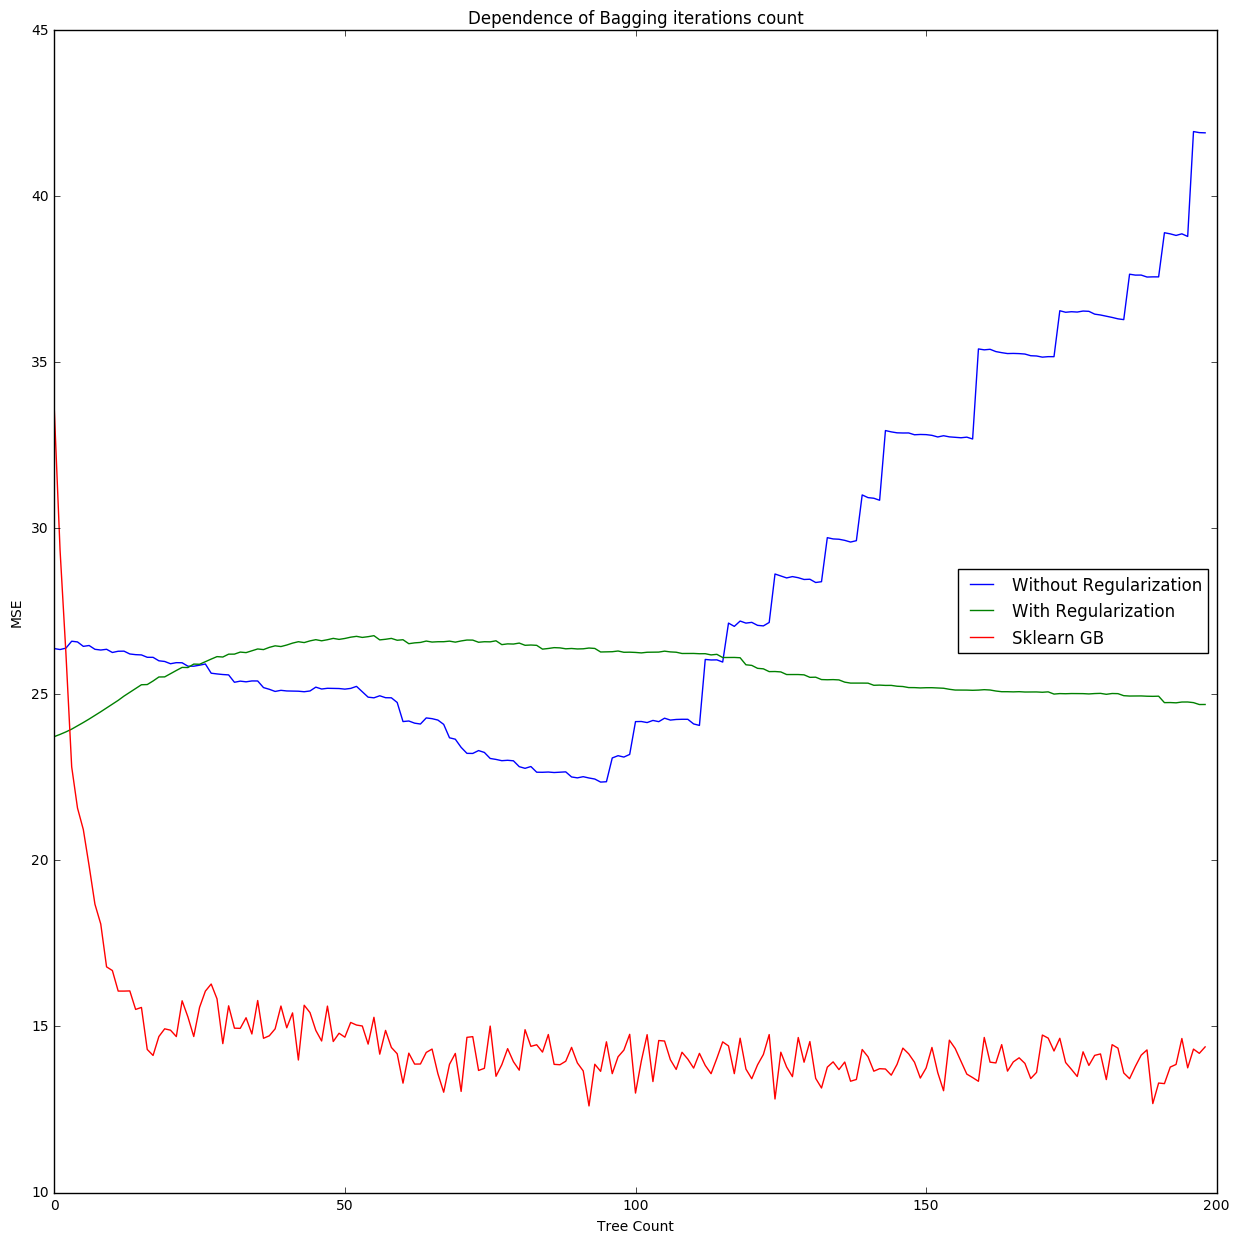

In [140]:
fig, ax = plt.subplots(figsize = (15, 15))
# for k in error_stat.keys():
    
#     plt.plot(range(0, 150), error_stat[k], label='BagBoo, N_Boo = ' + str(k) + \
#                                                  ', max_depth = 3, bagging_ratio=0.2')
    
plt.plot(range(0, 199), error_without_reg_house, label='Without Regularization')
plt.plot(range(0, 199), error_with_reg_house, label='With Regularization')
plt.plot(range(0, 199), skl_error_house, label='Sklearn GB')

ax.legend(loc='right')
ax.set_title('Dependence of Bagging iterations count')
ax.set_xlabel('Tree Count')
ax.set_ylabel('MSE')

In [304]:
%%time
tree_house = ObliviousTree().fit(house_data[:300], house_target[:300])
tree_house.score(house_data[300:392], house_target[300:392])

deep
Search_best_split_of_feat
	nodes_list 1
	X_list [array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00, ...,
          1.53000000e+01,   3.96900000e+02,   4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.96900000e+02,   9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.92830000e+02,   4.03000000e+00],
       ..., 
       [  1.41030000e-01,   0.00000000e+00,   1.39200000e+01, ...,
          1.60000000e+01,   3.96900000e+02,   1.58400000e+01],
       [  6.46600000e-02,   7.00000000e+01,   2.24000000e+00, ...,
          1.48000000e+01,   3.68240000e+02,   4.97000000e+00],
       [  5.56100000e-02,   7.00000000e+01,   2.24000000e+00, ...,
          1.48000000e+01,   3.71580000e+02,   4.74000000e+00]])]
	Y_list [array([ 24. ,  21.6,  34.7,  33.4,  36.2,  28.7,  22.9,  27.1,  16.5,
        18.9,  15. ,  18.9,  21.7,  20.4,  18.2,  19.9,  23.1,  17.5,
  

In [305]:
tree_house.print_tree()

2: 4.0?
	 T->
0: 0.52014?
	 T->
21.5184615385
	 F->
23.4147239264
	 F->
0: 0.52014?
	 T->
38.025
	 F->
32.8966666667


In [356]:
sk_house = DecisionTreeRegressor(max_depth=4).fit(house_data[:300], house_target[:300])
skl_predict = sk_house.predict(house_data[300:392])
print ((skl_predict - house_target[300:392])**2 / float(len(skl_predict))).sum()

55.02303951


In [367]:
%%time
gb_house = Gradient_Boosting(n_estimators=101, max_depth=3, shrinkage=0.1)    
gb_house.fit(house_data[:400], house_target[:400])

print "MSE Error on train dataset: ", MSE(gb_house.predict(house_data[:400]), house_target[:400])
print "MSE Error on test dataset: ", MSE(gb_house.predict(house_data[400:506]), house_target[400:506])

Number of learning estimator: 0; MSE error on train dataset:  2558.21747067
Number of learning estimator:  10 ; MSE error on train dataset:  1744.14453063
Number of learning estimator:  20 ; MSE error on train dataset:  1308.94369915
Number of learning estimator:  30 ; MSE error on train dataset:  1037.5467406
Number of learning estimator:  40 ; MSE error on train dataset:  848.176763415
Number of learning estimator:  50 ; MSE error on train dataset:  718.57484164
Number of learning estimator:  60 ; MSE error on train dataset:  615.749565531
Number of learning estimator:  70 ; MSE error on train dataset:  528.983190297
Number of learning estimator:  80 ; MSE error on train dataset:  473.463570747
Number of learning estimator:  90 ; MSE error on train dataset:  423.31122444
Number of learning estimator:  100 ; MSE error on train dataset:  383.96837126
MSE Error on train dataset:  383.96837126
MSE Error on test dataset:  2019.41281341
CPU times: user 55.3 s, sys: 48 ms, total: 55.4 s
Wal

In [364]:
%%time
skl_gb_house = GradientBoostingRegressor(criterion='mse', min_impurity_split=0)
skl_gb_house.fit(house_data[:400], house_target[:400])
print "MSE Error on train dataset: ", MSE(skl_gb_house.predict(house_data[:400]), house_target[:400])
print "MSE Error on test dataset: ", MSE( skl_gb_house.predict(house_data[400:506]), house_target[400:506])

MSE Error on train dataset:  320.259854388
MSE Error on test dataset:  671.613810248
CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 104 ms


## Computer Hardware

In [350]:
machine = pd.read_csv("./data/machine.data.csv", sep=',',header=None)
machine = machine.values
print machine.shape
print machine
machine_data = machine[:, 2:9]
machine_target = machine[:, 9]
print machine_data[:10]
print machine_target[:10]

(209, 10)
[['adviser' '32/60' 125 ..., 128 198 199]
 ['amdahl' '470v/7' 29 ..., 32 269 253]
 ['amdahl' '470v/7a' 29 ..., 32 220 253]
 ..., 
 ['sratus' '32' 125 ..., 14 52 41]
 ['wang' 'vs-100' 480 ..., 0 67 47]
 ['wang' 'vs-90' 480 ..., 0 45 25]]
[[125 256 6000 256 16 128 198]
 [29 8000 32000 32 8 32 269]
 [29 8000 32000 32 8 32 220]
 [29 8000 32000 32 8 32 172]
 [29 8000 16000 32 8 16 132]
 [26 8000 32000 64 8 32 318]
 [23 16000 32000 64 16 32 367]
 [23 16000 32000 64 16 32 489]
 [23 16000 64000 64 16 32 636]
 [23 32000 64000 128 32 64 1144]]
[199 253 253 253 132 290 381 381 749 1238]


In [352]:
%%time
gb_house = Gradient_Boosting(n_estimators=200, max_depth=3, shrinkage=0.05)    
error_without_reg = gb_house.fit(house_train_data, house_train_target, 1, house_test_data,  \
                               house_test_target, leaf_regularization = False)

print "MSE Error on train dataset: ", MSE(gb_house.predict(house_train_data), house_train_target)
print "MSE Error on test dataset: ", MSE(gb_house.predict(house_test_data), house_test_target)

deep
deep
deep
deep
deep
deep
deep
CPU times: user 724 ms, sys: 0 ns, total: 724 ms
Wall time: 720 ms


In [113]:
%%time
gb_tr = Gradient_Boosting(max_depth=3)    
gb_tr.fit(machine_data[:30], machine_target[:30])

N_POINTS:  16
N_POINTS:  12
N_POINTS:  1
N_POINTS:  1
Number of learning estimator: 0
MSE error on train dataset:  73723.84375
Number of learning estimator:  1
N_POINTS:  30
0.0
set([-7.75, 46.25, 4.6875, 83.25, 33.6875, 8.6875, 14.6875, -15.3125, 0.0, 174.25, 9.6875, -7.3125, -6.3125, -136.75, -3.3125, -8.3125, -1.3125, -2.3125, -178.75, -82.75, -89.75, -9.3125, -74.75]) [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
MSE error on train dataset:  73723.84375
Number of learning estimator:  2
N_POINTS:  30
0.0
set([-7.75, 46.25, 4.6875, 83.25, 33.6875, 8.6875, 14.6875, -15.3125, 0.0, 174.25, 9.6875, -7.3125, -6.3125, -136.75, -3.3125, -8.3125, -1.3125, -2.3125, -178.75, -82.75, -89.75, -9.3125, -74.75]) [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
MSE error on train dataset:  73723.84375
Number of learning estimator:  3
N_POINTS:  30
0.0
set([-7.75, 46.25, 4.6875, 83.25, 33.6875, 8.6875, 14.6875, -15.3125, 0.0, 174.25, 9.6875, -7.3125, -6.3125, -136.75, -3.3125, -8.3125, -1.3125, -2.3125, -178.7

## Spam

In [141]:
spam_train = np.loadtxt("./data/spam.train.txt")
spam_test = np.loadtxt("./data/spam.test.txt")
spam_train_data = spam_train[0::, 1::]
spam_train_target = spam_train[0::, 0]
spam_test_data = spam_test[0::, 1::]
spam_test_target = spam_test[0::, 0]
print spam_train.shape
print spam_test.shape

(7093, 103)
(10056, 103)


In [10]:
%%time
tree_spam_obl = ObliviousTree().fit(spam_train_data, spam_train_target)

KeyboardInterrupt: 

In [226]:
tree_spam_obl.print_tree()

NameError: name 'tree_spam_obl' is not defined

In [12]:
tree_spam_obl.score(spam_test_data, spam_test_target)

NameError: name 'tree_spam_obl' is not defined

In [142]:
sk_spam = DecisionTreeRegressor(max_depth=4).fit(spam_train_data, spam_train_target)
skl_predict = sk_spam.predict(spam_test_data)
print ((skl_predict - spam_test_target)**2 / float(len(skl_predict))).sum()

0.137523696272


In [165]:
boo_list = range(1, 100, 1)
skl_error_spam = [MSE(GradientBoostingRegressor(criterion='mse', min_impurity_split=0,\
                                        learning_rate=0.1, max_depth=3, n_estimators=boo).fit(spam_train_data,\
                                                    spam_train_target).predict(spam_test_data),spam_test_target) \
            for boo in boo_list]

In [169]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=3, shrinkage=0.1)    
error_without_reg_spam = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = False)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.234503317655

MSE on test Dataset: 0.237553674092 Iteration of Boosting: 1
MSE on train Dataset: 0.234503317655 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.234294255594

MSE on test Dataset: 0.237427810134 Iteration of Boosting: 2
MSE on train Dataset: 0.234294255594 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.234150550366

MSE on test Dataset: 0.23731243049 Iteration of Boosting: 3
MSE on train Dataset: 0.234150550366 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.233955517957

MSE on test Dataset: 0.237378430967 Iteration of Boosting: 4
MSE on train Dataset: 0.233955517957 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.233810021373

MSE on test Dataset: 0.237326155988 Iteration of Boosting: 5
MSE on train Dataset: 0.233810021373 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.23370140562

MSE on test Dataset: 0.237344517804 Iteration of Boosting: 6
MSE on train Dataset: 0.23370140562 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.233510896232

MSE on test Dataset: 0.23726908303 Iteration of Boosting: 7
MSE on train Dataset: 0.233510896232 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.233356442974

MSE on test Dataset: 0.237344832839 Iteration of Boosting: 8
MSE on train Dataset: 0.233356442974 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.233202912157

MSE on test Dataset: 0.237283147056 Iteration of Boosting: 9
MSE on train Dataset: 0.233202912157 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.233097608372

MSE on test Dataset: 0.237272261104 Iteration of Boosting: 10
MSE on train Dataset: 0.233097608372 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.23297458999

MSE on test Dataset: 0.237356625144 Iteration of Boosting: 11
MSE on train Dataset: 0.23297458999 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.232894851099

MSE on test Dataset: 0.237489776946 Iteration of Boosting: 12
MSE on train Dataset: 0.232894851099 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.232757772152

MSE on test Dataset: 0.237340253622 Iteration of Boosting: 13
MSE on train Dataset: 0.232757772152 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.232675658356

MSE on test Dataset: 0.237352576965 Iteration of Boosting: 14
MSE on train Dataset: 0.232675658356 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.232580346165

MSE on test Dataset: 0.237295285199 Iteration of Boosting: 15
MSE on train Dataset: 0.232580346165 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.232516205454

MSE on test Dataset: 0.237427023781 Iteration of Boosting: 16
MSE on train Dataset: 0.232516205454 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.23239810641

MSE on test Dataset: 0.237304985489 Iteration of Boosting: 17
MSE on train Dataset: 0.23239810641 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.232344642544

MSE on test Dataset: 0.237288326377 Iteration of Boosting: 18
MSE on train Dataset: 0.232344642544 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.232268743686

MSE on test Dataset: 0.237248404102 Iteration of Boosting: 19
MSE on train Dataset: 0.232268743686 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.232170574794

MSE on test Dataset: 0.237326544687 Iteration of Boosting: 20
MSE on train Dataset: 0.232170574794 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.232120321722

MSE on test Dataset: 0.237351457343 Iteration of Boosting: 21
MSE on train Dataset: 0.232120321722 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.232032040736

MSE on test Dataset: 0.237244485546 Iteration of Boosting: 22
MSE on train Dataset: 0.232032040736 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.231744453277

MSE on test Dataset: 0.236937011122 Iteration of Boosting: 23
MSE on train Dataset: 0.231744453277 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.231685695703

MSE on test Dataset: 0.236932361953 Iteration of Boosting: 24
MSE on train Dataset: 0.231685695703 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.231646989964

MSE on test Dataset: 0.236952688587 Iteration of Boosting: 25
MSE on train Dataset: 0.231646989964 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.23157142416

MSE on test Dataset: 0.236879147291 Iteration of Boosting: 26
MSE on train Dataset: 0.23157142416 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.231483375226

MSE on test Dataset: 0.23697716407 Iteration of Boosting: 27
MSE on train Dataset: 0.231483375226 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.231358004375

MSE on test Dataset: 0.236770967734 Iteration of Boosting: 28
MSE on train Dataset: 0.231358004375 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.231299254151

MSE on test Dataset: 0.23675130567 Iteration of Boosting: 29
MSE on train Dataset: 0.231299254151 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.231227853175

MSE on test Dataset: 0.236871080601 Iteration of Boosting: 30
MSE on train Dataset: 0.231227853175 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.231107503221

MSE on test Dataset: 0.236687927314 Iteration of Boosting: 31
MSE on train Dataset: 0.231107503221 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.231070216317

MSE on test Dataset: 0.236781522881 Iteration of Boosting: 32
MSE on train Dataset: 0.231070216317 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.230931694927

MSE on test Dataset: 0.23652662459 Iteration of Boosting: 33
MSE on train Dataset: 0.230931694927 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.230899871128

MSE on test Dataset: 0.236620593548 Iteration of Boosting: 34
MSE on train Dataset: 0.230899871128 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.230806563966

MSE on test Dataset: 0.236483327456 Iteration of Boosting: 35
MSE on train Dataset: 0.230806563966 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.230708209722

MSE on test Dataset: 0.23633060988 Iteration of Boosting: 36
MSE on train Dataset: 0.230708209722 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.230628542785

MSE on test Dataset: 0.236215899634 Iteration of Boosting: 37
MSE on train Dataset: 0.230628542785 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.230580486792

MSE on test Dataset: 0.236201119524 Iteration of Boosting: 38
MSE on train Dataset: 0.230580486792 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.230541193889

MSE on test Dataset: 0.236197353929 Iteration of Boosting: 39
MSE on train Dataset: 0.230541193889 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.230476714592

MSE on test Dataset: 0.236111135971 Iteration of Boosting: 40
MSE on train Dataset: 0.230476714592 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.230361019333

MSE on test Dataset: 0.235908275975 Iteration of Boosting: 41
MSE on train Dataset: 0.230361019333 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.230334541657

MSE on test Dataset: 0.236000004696 Iteration of Boosting: 42
MSE on train Dataset: 0.230334541657 Iteration of Boosting: 42


Learning estimator number: 43/100; MSE error on train dataset: 0.230222845958

MSE on test Dataset: 0.235799580507 Iteration of Boosting: 43
MSE on train Dataset: 0.230222845958 Iteration of Boosting: 43


Learning estimator number: 44/100; MSE error on train dataset: 0.230173654938

MSE on test Dataset: 0.23592018273 Iteration of Boosting: 44
MSE on train Dataset: 0.230173654938 Iteration of Boosting: 44


Learning estimator number: 45/100; MSE error on train dataset: 0.230132610421

MSE on test Dataset: 0.235906303829 Iteration of Boosting: 45
MSE on train Dataset: 0.230132610421 Iteration of Boosting: 45


Learning estimator number: 46/100; MSE error on train dataset: 0.23001718915

MSE on test Dataset: 0.235726612711 Iteration of Boosting: 46
MSE on train Dataset: 0.23001718915 Iteration of Boosting: 46


Learning estimator number: 47/100; MSE error on train dataset: 0.229975288226

MSE on test Dataset: 0.235848126694 Iteration of Boosting: 47
MSE on train Dataset: 0.229975288226 Iteration of Boosting: 47


Learning estimator number: 48/100; MSE error on train dataset: 0.22995488736

MSE on test Dataset: 0.235936388791 Iteration of Boosting: 48
MSE on train Dataset: 0.22995488736 Iteration of Boosting: 48


Learning estimator number: 49/100; MSE error on train dataset: 0.229868033213

MSE on test Dataset: 0.235995672009 Iteration of Boosting: 49
MSE on train Dataset: 0.229868033213 Iteration of Boosting: 49


Learning estimator number: 50/100; MSE error on train dataset: 0.22983545238

MSE on test Dataset: 0.236055193417 Iteration of Boosting: 50
MSE on train Dataset: 0.22983545238 Iteration of Boosting: 50


Learning estimator number: 51/100; MSE error on train dataset: 0.229816988578

MSE on test Dataset: 0.236138321855 Iteration of Boosting: 51
MSE on train Dataset: 0.229816988578 Iteration of Boosting: 51


Learning estimator number: 52/100; MSE error on train dataset: 0.229752509754

MSE on test Dataset: 0.236016224532 Iteration of Boosting: 52
MSE on train Dataset: 0.229752509754 Iteration of Boosting: 52


Learning estimator number: 53/100; MSE error on train dataset: 0.229698695684

MSE on test Dataset: 0.235951558175 Iteration of Boosting: 53
MSE on train Dataset: 0.229698695684 Iteration of Boosting: 53


Learning estimator number: 54/100; MSE error on train dataset: 0.229659152276

MSE on test Dataset: 0.235951977005 Iteration of Boosting: 54
MSE on train Dataset: 0.229659152276 Iteration of Boosting: 54


Learning estimator number: 55/100; MSE error on train dataset: 0.229556692587

MSE on test Dataset: 0.235756678583 Iteration of Boosting: 55
MSE on train Dataset: 0.229556692587 Iteration of Boosting: 55


Learning estimator number: 56/100; MSE error on train dataset: 0.22951362001

MSE on test Dataset: 0.235856844818 Iteration of Boosting: 56
MSE on train Dataset: 0.22951362001 Iteration of Boosting: 56


Learning estimator number: 57/100; MSE error on train dataset: 0.229458657015

MSE on test Dataset: 0.2359434312 Iteration of Boosting: 57
MSE on train Dataset: 0.229458657015 Iteration of Boosting: 57


Learning estimator number: 58/100; MSE error on train dataset: 0.229385422694

MSE on test Dataset: 0.235782272432 Iteration of Boosting: 58
MSE on train Dataset: 0.229385422694 Iteration of Boosting: 58


Learning estimator number: 59/100; MSE error on train dataset: 0.229314499277

MSE on test Dataset: 0.235656107276 Iteration of Boosting: 59
MSE on train Dataset: 0.229314499277 Iteration of Boosting: 59


Learning estimator number: 60/100; MSE error on train dataset: 0.229291212261

MSE on test Dataset: 0.235716275216 Iteration of Boosting: 60
MSE on train Dataset: 0.229291212261 Iteration of Boosting: 60


Learning estimator number: 61/100; MSE error on train dataset: 0.229261067988

MSE on test Dataset: 0.235722088136 Iteration of Boosting: 61
MSE on train Dataset: 0.229261067988 Iteration of Boosting: 61


Learning estimator number: 62/100; MSE error on train dataset: 0.229224067525

MSE on test Dataset: 0.23579112323 Iteration of Boosting: 62
MSE on train Dataset: 0.229224067525 Iteration of Boosting: 62


Learning estimator number: 63/100; MSE error on train dataset: 0.229184307795

MSE on test Dataset: 0.235856484971 Iteration of Boosting: 63
MSE on train Dataset: 0.229184307795 Iteration of Boosting: 63


Learning estimator number: 64/100; MSE error on train dataset: 0.229142363825

MSE on test Dataset: 0.23574298018 Iteration of Boosting: 64
MSE on train Dataset: 0.229142363825 Iteration of Boosting: 64


Learning estimator number: 65/100; MSE error on train dataset: 0.229098479477

MSE on test Dataset: 0.235697285798 Iteration of Boosting: 65
MSE on train Dataset: 0.229098479477 Iteration of Boosting: 65


Learning estimator number: 66/100; MSE error on train dataset: 0.229069261367

MSE on test Dataset: 0.235673209429 Iteration of Boosting: 66
MSE on train Dataset: 0.229069261367 Iteration of Boosting: 66


Learning estimator number: 67/100; MSE error on train dataset: 0.229042574027

MSE on test Dataset: 0.235720814982 Iteration of Boosting: 67
MSE on train Dataset: 0.229042574027 Iteration of Boosting: 67


Learning estimator number: 68/100; MSE error on train dataset: 0.228993844008

MSE on test Dataset: 0.235663592162 Iteration of Boosting: 68
MSE on train Dataset: 0.228993844008 Iteration of Boosting: 68


Learning estimator number: 69/100; MSE error on train dataset: 0.228941368676

MSE on test Dataset: 0.235517734715 Iteration of Boosting: 69
MSE on train Dataset: 0.228941368676 Iteration of Boosting: 69


Learning estimator number: 70/100; MSE error on train dataset: 0.228928823286

MSE on test Dataset: 0.235468124729 Iteration of Boosting: 70
MSE on train Dataset: 0.228928823286 Iteration of Boosting: 70


Learning estimator number: 71/100; MSE error on train dataset: 0.228880757484

MSE on test Dataset: 0.235417211245 Iteration of Boosting: 71
MSE on train Dataset: 0.228880757484 Iteration of Boosting: 71


Learning estimator number: 72/100; MSE error on train dataset: 0.228839174578

MSE on test Dataset: 0.235465834639 Iteration of Boosting: 72
MSE on train Dataset: 0.228839174578 Iteration of Boosting: 72


Learning estimator number: 73/100; MSE error on train dataset: 0.228780867631

MSE on test Dataset: 0.235563516303 Iteration of Boosting: 73
MSE on train Dataset: 0.228780867631 Iteration of Boosting: 73


Learning estimator number: 74/100; MSE error on train dataset: 0.228751770386

MSE on test Dataset: 0.235644828722 Iteration of Boosting: 74
MSE on train Dataset: 0.228751770386 Iteration of Boosting: 74


Learning estimator number: 75/100; MSE error on train dataset: 0.228728676259

MSE on test Dataset: 0.235697002063 Iteration of Boosting: 75
MSE on train Dataset: 0.228728676259 Iteration of Boosting: 75


Learning estimator number: 76/100; MSE error on train dataset: 0.228692307566

MSE on test Dataset: 0.235745066266 Iteration of Boosting: 76
MSE on train Dataset: 0.228692307566 Iteration of Boosting: 76


Learning estimator number: 77/100; MSE error on train dataset: 0.228645946391

MSE on test Dataset: 0.235824530186 Iteration of Boosting: 77
MSE on train Dataset: 0.228645946391 Iteration of Boosting: 77


Learning estimator number: 78/100; MSE error on train dataset: 0.228622283771

MSE on test Dataset: 0.235888638248 Iteration of Boosting: 78
MSE on train Dataset: 0.228622283771 Iteration of Boosting: 78


Learning estimator number: 79/100; MSE error on train dataset: 0.228595953126

MSE on test Dataset: 0.235919068973 Iteration of Boosting: 79
MSE on train Dataset: 0.228595953126 Iteration of Boosting: 79


Learning estimator number: 80/100; MSE error on train dataset: 0.228553189333

MSE on test Dataset: 0.236038146012 Iteration of Boosting: 80
MSE on train Dataset: 0.228553189333 Iteration of Boosting: 80


Learning estimator number: 81/100; MSE error on train dataset: 0.228537159851

MSE on test Dataset: 0.23608311207 Iteration of Boosting: 81
MSE on train Dataset: 0.228537159851 Iteration of Boosting: 81


Learning estimator number: 82/100; MSE error on train dataset: 0.228499511084

MSE on test Dataset: 0.236046507854 Iteration of Boosting: 82
MSE on train Dataset: 0.228499511084 Iteration of Boosting: 82


Learning estimator number: 83/100; MSE error on train dataset: 0.228469689071

MSE on test Dataset: 0.23599506496 Iteration of Boosting: 83
MSE on train Dataset: 0.228469689071 Iteration of Boosting: 83


Learning estimator number: 84/100; MSE error on train dataset: 0.228435185795

MSE on test Dataset: 0.235965858969 Iteration of Boosting: 84
MSE on train Dataset: 0.228435185795 Iteration of Boosting: 84


Learning estimator number: 85/100; MSE error on train dataset: 0.228416226158

MSE on test Dataset: 0.23603949645 Iteration of Boosting: 85
MSE on train Dataset: 0.228416226158 Iteration of Boosting: 85


Learning estimator number: 86/100; MSE error on train dataset: 0.228386766979

MSE on test Dataset: 0.236074764169 Iteration of Boosting: 86
MSE on train Dataset: 0.228386766979 Iteration of Boosting: 86


Learning estimator number: 87/100; MSE error on train dataset: 0.228351528895

MSE on test Dataset: 0.23599896964 Iteration of Boosting: 87
MSE on train Dataset: 0.228351528895 Iteration of Boosting: 87


Learning estimator number: 88/100; MSE error on train dataset: 0.228320048749

MSE on test Dataset: 0.236012454985 Iteration of Boosting: 88
MSE on train Dataset: 0.228320048749 Iteration of Boosting: 88


Learning estimator number: 89/100; MSE error on train dataset: 0.228296901254

MSE on test Dataset: 0.236017688983 Iteration of Boosting: 89
MSE on train Dataset: 0.228296901254 Iteration of Boosting: 89


Learning estimator number: 90/100; MSE error on train dataset: 0.228261383457

MSE on test Dataset: 0.236046300891 Iteration of Boosting: 90
MSE on train Dataset: 0.228261383457 Iteration of Boosting: 90


Learning estimator number: 91/100; MSE error on train dataset: 0.22822756286

MSE on test Dataset: 0.235954388665 Iteration of Boosting: 91
MSE on train Dataset: 0.22822756286 Iteration of Boosting: 91


Learning estimator number: 92/100; MSE error on train dataset: 0.228192117243

MSE on test Dataset: 0.236017015697 Iteration of Boosting: 92
MSE on train Dataset: 0.228192117243 Iteration of Boosting: 92


Learning estimator number: 93/100; MSE error on train dataset: 0.228156871641

MSE on test Dataset: 0.23599039036 Iteration of Boosting: 93
MSE on train Dataset: 0.228156871641 Iteration of Boosting: 93


Learning estimator number: 94/100; MSE error on train dataset: 0.228129308569

MSE on test Dataset: 0.235910399291 Iteration of Boosting: 94
MSE on train Dataset: 0.228129308569 Iteration of Boosting: 94


Learning estimator number: 95/100; MSE error on train dataset: 0.228107274105

MSE on test Dataset: 0.235898325479 Iteration of Boosting: 95
MSE on train Dataset: 0.228107274105 Iteration of Boosting: 95


Learning estimator number: 96/100; MSE error on train dataset: 0.228077695054

MSE on test Dataset: 0.235934073681 Iteration of Boosting: 96
MSE on train Dataset: 0.228077695054 Iteration of Boosting: 96


Learning estimator number: 97/100; MSE error on train dataset: 0.22806926624

MSE on test Dataset: 0.23590037874 Iteration of Boosting: 97
MSE on train Dataset: 0.22806926624 Iteration of Boosting: 97


Learning estimator number: 98/100; MSE error on train dataset: 0.228032698583

MSE on test Dataset: 0.235949504474 Iteration of Boosting: 98
MSE on train Dataset: 0.228032698583 Iteration of Boosting: 98


Learning estimator number: 99/100; MSE error on train dataset: 0.228007447652

MSE on test Dataset: 0.235959294943 Iteration of Boosting: 99
MSE on train Dataset: 0.228007447652 Iteration of Boosting: 99
MSE Error on train dataset:  0.228007447652
MSE Error on test dataset:  0.235959294943
CPU times: user 4min 51s, sys: 780 ms, total: 4min 52s
Wall time: 4min 51s


In [166]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=3, shrinkage=0.1)    
error_with_reg_spam = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.234662865203

MSE on test Dataset: 0.247006636182 Iteration of Boosting: 1
MSE on train Dataset: 0.234662865203 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.234464832541

MSE on test Dataset: 0.24616981596 Iteration of Boosting: 2
MSE on train Dataset: 0.234464832541 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.234318748009

MSE on test Dataset: 0.24539113239 Iteration of Boosting: 3
MSE on train Dataset: 0.234318748009 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.234199756378

MSE on test Dataset: 0.244806519726 Iteration of Boosting: 4
MSE on train Dataset: 0.234199756378 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.234007872203

MSE on test Dataset: 0.244334469123 Iteration of Boosting: 5
MSE on train Dataset: 0.234007872203 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.233900560777

MSE on test Dataset: 0.244010271835 Iteration of Boosting: 6
MSE on train Dataset: 0.233900560777 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.233758024385

MSE on test Dataset: 0.243452152233 Iteration of Boosting: 7
MSE on train Dataset: 0.233758024385 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.233655225137

MSE on test Dataset: 0.242991997671 Iteration of Boosting: 8
MSE on train Dataset: 0.233655225137 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.233543847193

MSE on test Dataset: 0.242605208928 Iteration of Boosting: 9
MSE on train Dataset: 0.233543847193 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.233396415666

MSE on test Dataset: 0.242200249326 Iteration of Boosting: 10
MSE on train Dataset: 0.233396415666 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.233306245269

MSE on test Dataset: 0.241900070122 Iteration of Boosting: 11
MSE on train Dataset: 0.233306245269 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.233168268636

MSE on test Dataset: 0.241712726233 Iteration of Boosting: 12
MSE on train Dataset: 0.233168268636 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.233105554876

MSE on test Dataset: 0.2416177279 Iteration of Boosting: 13
MSE on train Dataset: 0.233105554876 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.233008172125

MSE on test Dataset: 0.2413295363 Iteration of Boosting: 14
MSE on train Dataset: 0.233008172125 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.232871755756

MSE on test Dataset: 0.240982162566 Iteration of Boosting: 15
MSE on train Dataset: 0.232871755756 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.232759500415

MSE on test Dataset: 0.24055237215 Iteration of Boosting: 16
MSE on train Dataset: 0.232759500415 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.232648861228

MSE on test Dataset: 0.240488661922 Iteration of Boosting: 17
MSE on train Dataset: 0.232648861228 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.232598452808

MSE on test Dataset: 0.240478547302 Iteration of Boosting: 18
MSE on train Dataset: 0.232598452808 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.232492212142

MSE on test Dataset: 0.240210572511 Iteration of Boosting: 19
MSE on train Dataset: 0.232492212142 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.232446127779

MSE on test Dataset: 0.240079879484 Iteration of Boosting: 20
MSE on train Dataset: 0.232446127779 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.232406164513

MSE on test Dataset: 0.240004232106 Iteration of Boosting: 21
MSE on train Dataset: 0.232406164513 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.232333339396

MSE on test Dataset: 0.239869332915 Iteration of Boosting: 22
MSE on train Dataset: 0.232333339396 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.23224257143

MSE on test Dataset: 0.23986865656 Iteration of Boosting: 23
MSE on train Dataset: 0.23224257143 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.232208706145

MSE on test Dataset: 0.239818831743 Iteration of Boosting: 24
MSE on train Dataset: 0.232208706145 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.232131368315

MSE on test Dataset: 0.239708646607 Iteration of Boosting: 25
MSE on train Dataset: 0.232131368315 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.232054690025

MSE on test Dataset: 0.239530893434 Iteration of Boosting: 26
MSE on train Dataset: 0.232054690025 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.231792933896

MSE on test Dataset: 0.239169292453 Iteration of Boosting: 27
MSE on train Dataset: 0.231792933896 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.231760942673

MSE on test Dataset: 0.239202958338 Iteration of Boosting: 28
MSE on train Dataset: 0.231760942673 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.231719075739

MSE on test Dataset: 0.239139188364 Iteration of Boosting: 29
MSE on train Dataset: 0.231719075739 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.231691627997

MSE on test Dataset: 0.23917428224 Iteration of Boosting: 30
MSE on train Dataset: 0.231691627997 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.231633905736

MSE on test Dataset: 0.239106953406 Iteration of Boosting: 31
MSE on train Dataset: 0.231633905736 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.231533598283

MSE on test Dataset: 0.238936129969 Iteration of Boosting: 32
MSE on train Dataset: 0.231533598283 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.231466443429

MSE on test Dataset: 0.238815545985 Iteration of Boosting: 33
MSE on train Dataset: 0.231466443429 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.231378742375

MSE on test Dataset: 0.238711409958 Iteration of Boosting: 34
MSE on train Dataset: 0.231378742375 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.23133074648

MSE on test Dataset: 0.238663811303 Iteration of Boosting: 35
MSE on train Dataset: 0.23133074648 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.231264032941

MSE on test Dataset: 0.238756618619 Iteration of Boosting: 36
MSE on train Dataset: 0.231264032941 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.231178267716

MSE on test Dataset: 0.238624942397 Iteration of Boosting: 37
MSE on train Dataset: 0.231178267716 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.231154906964

MSE on test Dataset: 0.238503562706 Iteration of Boosting: 38
MSE on train Dataset: 0.231154906964 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.231097578472

MSE on test Dataset: 0.238598978862 Iteration of Boosting: 39
MSE on train Dataset: 0.231097578472 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.230991173062

MSE on test Dataset: 0.238440280105 Iteration of Boosting: 40
MSE on train Dataset: 0.230991173062 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.230958781687

MSE on test Dataset: 0.238418604436 Iteration of Boosting: 41
MSE on train Dataset: 0.230958781687 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.230884530842

MSE on test Dataset: 0.238314301187 Iteration of Boosting: 42
MSE on train Dataset: 0.230884530842 Iteration of Boosting: 42


Learning estimator number: 43/100; MSE error on train dataset: 0.230843697482

MSE on test Dataset: 0.238274304424 Iteration of Boosting: 43
MSE on train Dataset: 0.230843697482 Iteration of Boosting: 43


Learning estimator number: 44/100; MSE error on train dataset: 0.230822481171

MSE on test Dataset: 0.238353313125 Iteration of Boosting: 44
MSE on train Dataset: 0.230822481171 Iteration of Boosting: 44


Learning estimator number: 45/100; MSE error on train dataset: 0.230693059164

MSE on test Dataset: 0.238099599664 Iteration of Boosting: 45
MSE on train Dataset: 0.230693059164 Iteration of Boosting: 45


Learning estimator number: 46/100; MSE error on train dataset: 0.230628498827

MSE on test Dataset: 0.238018726356 Iteration of Boosting: 46
MSE on train Dataset: 0.230628498827 Iteration of Boosting: 46


Learning estimator number: 47/100; MSE error on train dataset: 0.230614624066

MSE on test Dataset: 0.238032096985 Iteration of Boosting: 47
MSE on train Dataset: 0.230614624066 Iteration of Boosting: 47


Learning estimator number: 48/100; MSE error on train dataset: 0.230506402071

MSE on test Dataset: 0.237827050761 Iteration of Boosting: 48
MSE on train Dataset: 0.230506402071 Iteration of Boosting: 48


Learning estimator number: 49/100; MSE error on train dataset: 0.230463626615

MSE on test Dataset: 0.237936368242 Iteration of Boosting: 49
MSE on train Dataset: 0.230463626615 Iteration of Boosting: 49


Learning estimator number: 50/100; MSE error on train dataset: 0.230427084951

MSE on test Dataset: 0.237874821698 Iteration of Boosting: 50
MSE on train Dataset: 0.230427084951 Iteration of Boosting: 50


Learning estimator number: 51/100; MSE error on train dataset: 0.230364657114

MSE on test Dataset: 0.237791382501 Iteration of Boosting: 51
MSE on train Dataset: 0.230364657114 Iteration of Boosting: 51


Learning estimator number: 52/100; MSE error on train dataset: 0.230277798279

MSE on test Dataset: 0.237593308918 Iteration of Boosting: 52
MSE on train Dataset: 0.230277798279 Iteration of Boosting: 52


Learning estimator number: 53/100; MSE error on train dataset: 0.230242817441

MSE on test Dataset: 0.237696882888 Iteration of Boosting: 53
MSE on train Dataset: 0.230242817441 Iteration of Boosting: 53


Learning estimator number: 54/100; MSE error on train dataset: 0.230175400039

MSE on test Dataset: 0.237561238375 Iteration of Boosting: 54
MSE on train Dataset: 0.230175400039 Iteration of Boosting: 54


Learning estimator number: 55/100; MSE error on train dataset: 0.230158993839

MSE on test Dataset: 0.237488785205 Iteration of Boosting: 55
MSE on train Dataset: 0.230158993839 Iteration of Boosting: 55


Learning estimator number: 56/100; MSE error on train dataset: 0.230101123833

MSE on test Dataset: 0.2374306432 Iteration of Boosting: 56
MSE on train Dataset: 0.230101123833 Iteration of Boosting: 56


Learning estimator number: 57/100; MSE error on train dataset: 0.230057284605

MSE on test Dataset: 0.237499233043 Iteration of Boosting: 57
MSE on train Dataset: 0.230057284605 Iteration of Boosting: 57


Learning estimator number: 58/100; MSE error on train dataset: 0.230026461373

MSE on test Dataset: 0.23745001597 Iteration of Boosting: 58
MSE on train Dataset: 0.230026461373 Iteration of Boosting: 58


Learning estimator number: 59/100; MSE error on train dataset: 0.229996974284

MSE on test Dataset: 0.237520654089 Iteration of Boosting: 59
MSE on train Dataset: 0.229996974284 Iteration of Boosting: 59


Learning estimator number: 60/100; MSE error on train dataset: 0.229884571009

MSE on test Dataset: 0.237412285764 Iteration of Boosting: 60
MSE on train Dataset: 0.229884571009 Iteration of Boosting: 60


Learning estimator number: 61/100; MSE error on train dataset: 0.229837866999

MSE on test Dataset: 0.237359214899 Iteration of Boosting: 61
MSE on train Dataset: 0.229837866999 Iteration of Boosting: 61


Learning estimator number: 62/100; MSE error on train dataset: 0.229810992399

MSE on test Dataset: 0.237430557668 Iteration of Boosting: 62
MSE on train Dataset: 0.229810992399 Iteration of Boosting: 62


Learning estimator number: 63/100; MSE error on train dataset: 0.229786491546

MSE on test Dataset: 0.237426135422 Iteration of Boosting: 63
MSE on train Dataset: 0.229786491546 Iteration of Boosting: 63


Learning estimator number: 64/100; MSE error on train dataset: 0.229761762613

MSE on test Dataset: 0.237385916514 Iteration of Boosting: 64
MSE on train Dataset: 0.229761762613 Iteration of Boosting: 64


Learning estimator number: 65/100; MSE error on train dataset: 0.229740336623

MSE on test Dataset: 0.237380898768 Iteration of Boosting: 65
MSE on train Dataset: 0.229740336623 Iteration of Boosting: 65


Learning estimator number: 66/100; MSE error on train dataset: 0.229665177669

MSE on test Dataset: 0.237454987339 Iteration of Boosting: 66
MSE on train Dataset: 0.229665177669 Iteration of Boosting: 66


Learning estimator number: 67/100; MSE error on train dataset: 0.229644095575

MSE on test Dataset: 0.237434805454 Iteration of Boosting: 67
MSE on train Dataset: 0.229644095575 Iteration of Boosting: 67


Learning estimator number: 68/100; MSE error on train dataset: 0.22961663807

MSE on test Dataset: 0.237529372983 Iteration of Boosting: 68
MSE on train Dataset: 0.22961663807 Iteration of Boosting: 68


Learning estimator number: 69/100; MSE error on train dataset: 0.229565613911

MSE on test Dataset: 0.237409950142 Iteration of Boosting: 69
MSE on train Dataset: 0.229565613911 Iteration of Boosting: 69


Learning estimator number: 70/100; MSE error on train dataset: 0.229503243058

MSE on test Dataset: 0.237482154981 Iteration of Boosting: 70
MSE on train Dataset: 0.229503243058 Iteration of Boosting: 70


Learning estimator number: 71/100; MSE error on train dataset: 0.229482966829

MSE on test Dataset: 0.237532740483 Iteration of Boosting: 71
MSE on train Dataset: 0.229482966829 Iteration of Boosting: 71


Learning estimator number: 72/100; MSE error on train dataset: 0.229464676604

MSE on test Dataset: 0.237534331602 Iteration of Boosting: 72
MSE on train Dataset: 0.229464676604 Iteration of Boosting: 72


Learning estimator number: 73/100; MSE error on train dataset: 0.229377354494

MSE on test Dataset: 0.23735479685 Iteration of Boosting: 73
MSE on train Dataset: 0.229377354494 Iteration of Boosting: 73


Learning estimator number: 74/100; MSE error on train dataset: 0.229329793289

MSE on test Dataset: 0.237307586568 Iteration of Boosting: 74
MSE on train Dataset: 0.229329793289 Iteration of Boosting: 74


Learning estimator number: 75/100; MSE error on train dataset: 0.229309554755

MSE on test Dataset: 0.237336358223 Iteration of Boosting: 75
MSE on train Dataset: 0.229309554755 Iteration of Boosting: 75


Learning estimator number: 76/100; MSE error on train dataset: 0.229269130448

MSE on test Dataset: 0.237301423281 Iteration of Boosting: 76
MSE on train Dataset: 0.229269130448 Iteration of Boosting: 76


Learning estimator number: 77/100; MSE error on train dataset: 0.229205455756

MSE on test Dataset: 0.23715030769 Iteration of Boosting: 77
MSE on train Dataset: 0.229205455756 Iteration of Boosting: 77


Learning estimator number: 78/100; MSE error on train dataset: 0.229189344794

MSE on test Dataset: 0.237153951466 Iteration of Boosting: 78
MSE on train Dataset: 0.229189344794 Iteration of Boosting: 78


Learning estimator number: 79/100; MSE error on train dataset: 0.229171569474

MSE on test Dataset: 0.237212433647 Iteration of Boosting: 79
MSE on train Dataset: 0.229171569474 Iteration of Boosting: 79


Learning estimator number: 80/100; MSE error on train dataset: 0.229117445315

MSE on test Dataset: 0.237094660154 Iteration of Boosting: 80
MSE on train Dataset: 0.229117445315 Iteration of Boosting: 80


Learning estimator number: 81/100; MSE error on train dataset: 0.229051004039

MSE on test Dataset: 0.237032736878 Iteration of Boosting: 81
MSE on train Dataset: 0.229051004039 Iteration of Boosting: 81


Learning estimator number: 82/100; MSE error on train dataset: 0.229027561564

MSE on test Dataset: 0.237108579628 Iteration of Boosting: 82
MSE on train Dataset: 0.229027561564 Iteration of Boosting: 82


Learning estimator number: 83/100; MSE error on train dataset: 0.229014650578

MSE on test Dataset: 0.237092647601 Iteration of Boosting: 83
MSE on train Dataset: 0.229014650578 Iteration of Boosting: 83


Learning estimator number: 84/100; MSE error on train dataset: 0.228988995219

MSE on test Dataset: 0.237162953936 Iteration of Boosting: 84
MSE on train Dataset: 0.228988995219 Iteration of Boosting: 84


Learning estimator number: 85/100; MSE error on train dataset: 0.228970814097

MSE on test Dataset: 0.237196423199 Iteration of Boosting: 85
MSE on train Dataset: 0.228970814097 Iteration of Boosting: 85


Learning estimator number: 86/100; MSE error on train dataset: 0.228961781873

MSE on test Dataset: 0.237222034281 Iteration of Boosting: 86
MSE on train Dataset: 0.228961781873 Iteration of Boosting: 86


Learning estimator number: 87/100; MSE error on train dataset: 0.228946478566

MSE on test Dataset: 0.237285489229 Iteration of Boosting: 87
MSE on train Dataset: 0.228946478566 Iteration of Boosting: 87


Learning estimator number: 88/100; MSE error on train dataset: 0.228926775136

MSE on test Dataset: 0.237305462662 Iteration of Boosting: 88
MSE on train Dataset: 0.228926775136 Iteration of Boosting: 88


Learning estimator number: 89/100; MSE error on train dataset: 0.228873429917

MSE on test Dataset: 0.237248151674 Iteration of Boosting: 89
MSE on train Dataset: 0.228873429917 Iteration of Boosting: 89


Learning estimator number: 90/100; MSE error on train dataset: 0.228855310014

MSE on test Dataset: 0.237298377895 Iteration of Boosting: 90
MSE on train Dataset: 0.228855310014 Iteration of Boosting: 90


Learning estimator number: 91/100; MSE error on train dataset: 0.228811036494

MSE on test Dataset: 0.237380974515 Iteration of Boosting: 91
MSE on train Dataset: 0.228811036494 Iteration of Boosting: 91


Learning estimator number: 92/100; MSE error on train dataset: 0.228779765027

MSE on test Dataset: 0.237346530048 Iteration of Boosting: 92
MSE on train Dataset: 0.228779765027 Iteration of Boosting: 92


Learning estimator number: 93/100; MSE error on train dataset: 0.228767915938

MSE on test Dataset: 0.237325031922 Iteration of Boosting: 93
MSE on train Dataset: 0.228767915938 Iteration of Boosting: 93


Learning estimator number: 94/100; MSE error on train dataset: 0.228742127043

MSE on test Dataset: 0.23737662209 Iteration of Boosting: 94
MSE on train Dataset: 0.228742127043 Iteration of Boosting: 94


Learning estimator number: 95/100; MSE error on train dataset: 0.22872198758

MSE on test Dataset: 0.237453990328 Iteration of Boosting: 95
MSE on train Dataset: 0.22872198758 Iteration of Boosting: 95


Learning estimator number: 96/100; MSE error on train dataset: 0.228683742904

MSE on test Dataset: 0.237390130576 Iteration of Boosting: 96
MSE on train Dataset: 0.228683742904 Iteration of Boosting: 96


Learning estimator number: 97/100; MSE error on train dataset: 0.228674643198

MSE on test Dataset: 0.237345043493 Iteration of Boosting: 97
MSE on train Dataset: 0.228674643198 Iteration of Boosting: 97


Learning estimator number: 98/100; MSE error on train dataset: 0.228658678991

MSE on test Dataset: 0.237412613999 Iteration of Boosting: 98
MSE on train Dataset: 0.228658678991 Iteration of Boosting: 98


Learning estimator number: 99/100; MSE error on train dataset: 0.228644286293

MSE on test Dataset: 0.237462955944 Iteration of Boosting: 99
MSE on train Dataset: 0.228644286293 Iteration of Boosting: 99
MSE Error on train dataset:  0.228644286293
MSE Error on test dataset:  0.237462955944
CPU times: user 4min 51s, sys: 1.02 s, total: 4min 52s
Wall time: 4min 51s


In [ ]:
%%time
gb_spam = Gradient_Boosting(n_estimators=300, max_depth=2, shrinkage=0.1)    
error_with_reg_spam = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

In [179]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=3, shrinkage=0.2)    
error_with_reg_spam2 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.234446572696

MSE on test Dataset: 0.246081787055 Iteration of Boosting: 1
MSE on train Dataset: 0.234446572696 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.234172390128

MSE on test Dataset: 0.24455998262 Iteration of Boosting: 2
MSE on train Dataset: 0.234172390128 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.233964238004

MSE on test Dataset: 0.243539584117 Iteration of Boosting: 3
MSE on train Dataset: 0.233964238004 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.233615611218

MSE on test Dataset: 0.242842180727 Iteration of Boosting: 4
MSE on train Dataset: 0.233615611218 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.233451683712

MSE on test Dataset: 0.242456250454 Iteration of Boosting: 5
MSE on train Dataset: 0.233451683712 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.233142100458

MSE on test Dataset: 0.241638734741 Iteration of Boosting: 6
MSE on train Dataset: 0.233142100458 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.2329016894

MSE on test Dataset: 0.240868574002 Iteration of Boosting: 7
MSE on train Dataset: 0.2329016894 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.232734900215

MSE on test Dataset: 0.240515369942 Iteration of Boosting: 8
MSE on train Dataset: 0.232734900215 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.232632848055

MSE on test Dataset: 0.240492854579 Iteration of Boosting: 9
MSE on train Dataset: 0.232632848055 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.232463445312

MSE on test Dataset: 0.240155219107 Iteration of Boosting: 10
MSE on train Dataset: 0.232463445312 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.232318116327

MSE on test Dataset: 0.239903215812 Iteration of Boosting: 11
MSE on train Dataset: 0.232318116327 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.232115374079

MSE on test Dataset: 0.239913810029 Iteration of Boosting: 12
MSE on train Dataset: 0.232115374079 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.23203944351

MSE on test Dataset: 0.239771540874 Iteration of Boosting: 13
MSE on train Dataset: 0.23203944351 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.231971421569

MSE on test Dataset: 0.239412515271 Iteration of Boosting: 14
MSE on train Dataset: 0.231971421569 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.231467934226

MSE on test Dataset: 0.238586423185 Iteration of Boosting: 15
MSE on train Dataset: 0.231467934226 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.231421290742

MSE on test Dataset: 0.238583907169 Iteration of Boosting: 16
MSE on train Dataset: 0.231421290742 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.231346996815

MSE on test Dataset: 0.238500591736 Iteration of Boosting: 17
MSE on train Dataset: 0.231346996815 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.231156322423

MSE on test Dataset: 0.238193556327 Iteration of Boosting: 18
MSE on train Dataset: 0.231156322423 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.2310567521

MSE on test Dataset: 0.238150853879 Iteration of Boosting: 19
MSE on train Dataset: 0.2310567521 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.230905317796

MSE on test Dataset: 0.238026221124 Iteration of Boosting: 20
MSE on train Dataset: 0.230905317796 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.23087175153

MSE on test Dataset: 0.238060710406 Iteration of Boosting: 21
MSE on train Dataset: 0.23087175153 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.230759377503

MSE on test Dataset: 0.237906376178 Iteration of Boosting: 22
MSE on train Dataset: 0.230759377503 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.230641967089

MSE on test Dataset: 0.238123174332 Iteration of Boosting: 23
MSE on train Dataset: 0.230641967089 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.230507233061

MSE on test Dataset: 0.23793659777 Iteration of Boosting: 24
MSE on train Dataset: 0.230507233061 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.23035891119

MSE on test Dataset: 0.237660836931 Iteration of Boosting: 25
MSE on train Dataset: 0.23035891119 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.230260866248

MSE on test Dataset: 0.237556506293 Iteration of Boosting: 26
MSE on train Dataset: 0.230260866248 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.230194269704

MSE on test Dataset: 0.237682248256 Iteration of Boosting: 27
MSE on train Dataset: 0.230194269704 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.230161999338

MSE on test Dataset: 0.237842887764 Iteration of Boosting: 28
MSE on train Dataset: 0.230161999338 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.23010732853

MSE on test Dataset: 0.237765881402 Iteration of Boosting: 29
MSE on train Dataset: 0.23010732853 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.22990691211

MSE on test Dataset: 0.237354912457 Iteration of Boosting: 30
MSE on train Dataset: 0.22990691211 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.229702641353

MSE on test Dataset: 0.237158487033 Iteration of Boosting: 31
MSE on train Dataset: 0.229702641353 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.229591812877

MSE on test Dataset: 0.237057621089 Iteration of Boosting: 32
MSE on train Dataset: 0.229591812877 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.229569746974

MSE on test Dataset: 0.237053323495 Iteration of Boosting: 33
MSE on train Dataset: 0.229569746974 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.229509065409

MSE on test Dataset: 0.237254033092 Iteration of Boosting: 34
MSE on train Dataset: 0.229509065409 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.229356360378

MSE on test Dataset: 0.236907323574 Iteration of Boosting: 35
MSE on train Dataset: 0.229356360378 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.229298475688

MSE on test Dataset: 0.237078951357 Iteration of Boosting: 36
MSE on train Dataset: 0.229298475688 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.229170190036

MSE on test Dataset: 0.237238440905 Iteration of Boosting: 37
MSE on train Dataset: 0.229170190036 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.229082789509

MSE on test Dataset: 0.237272305745 Iteration of Boosting: 38
MSE on train Dataset: 0.229082789509 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.229042163568

MSE on test Dataset: 0.237382938899 Iteration of Boosting: 39
MSE on train Dataset: 0.229042163568 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.228977562693

MSE on test Dataset: 0.237183133671 Iteration of Boosting: 40
MSE on train Dataset: 0.228977562693 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.228928316744

MSE on test Dataset: 0.237234810029 Iteration of Boosting: 41
MSE on train Dataset: 0.228928316744 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.228856917047

MSE on test Dataset: 0.237363090342 Iteration of Boosting: 42
MSE on train Dataset: 0.228856917047 Iteration of Boosting: 42


Learning estimator number: 43/100; MSE error on train dataset: 0.228838569858

MSE on test Dataset: 0.237281204301 Iteration of Boosting: 43
MSE on train Dataset: 0.228838569858 Iteration of Boosting: 43


Learning estimator number: 44/100; MSE error on train dataset: 0.228809372691

MSE on test Dataset: 0.237218793924 Iteration of Boosting: 44
MSE on train Dataset: 0.228809372691 Iteration of Boosting: 44


Learning estimator number: 45/100; MSE error on train dataset: 0.228775378886

MSE on test Dataset: 0.237283116835 Iteration of Boosting: 45
MSE on train Dataset: 0.228775378886 Iteration of Boosting: 45


Learning estimator number: 46/100; MSE error on train dataset: 0.228691169208

MSE on test Dataset: 0.237462731172 Iteration of Boosting: 46
MSE on train Dataset: 0.228691169208 Iteration of Boosting: 46


Learning estimator number: 47/100; MSE error on train dataset: 0.228619130539

MSE on test Dataset: 0.237420951537 Iteration of Boosting: 47
MSE on train Dataset: 0.228619130539 Iteration of Boosting: 47


Learning estimator number: 48/100; MSE error on train dataset: 0.228567881185

MSE on test Dataset: 0.237584236939 Iteration of Boosting: 48
MSE on train Dataset: 0.228567881185 Iteration of Boosting: 48


Learning estimator number: 49/100; MSE error on train dataset: 0.228488456869

MSE on test Dataset: 0.237457363232 Iteration of Boosting: 49
MSE on train Dataset: 0.228488456869 Iteration of Boosting: 49


Learning estimator number: 50/100; MSE error on train dataset: 0.228438676684

MSE on test Dataset: 0.237559443613 Iteration of Boosting: 50
MSE on train Dataset: 0.228438676684 Iteration of Boosting: 50


Learning estimator number: 51/100; MSE error on train dataset: 0.228397416127

MSE on test Dataset: 0.237721349721 Iteration of Boosting: 51
MSE on train Dataset: 0.228397416127 Iteration of Boosting: 51


Learning estimator number: 52/100; MSE error on train dataset: 0.228323430116

MSE on test Dataset: 0.237724234328 Iteration of Boosting: 52
MSE on train Dataset: 0.228323430116 Iteration of Boosting: 52


Learning estimator number: 53/100; MSE error on train dataset: 0.228299824929

MSE on test Dataset: 0.237707400889 Iteration of Boosting: 53
MSE on train Dataset: 0.228299824929 Iteration of Boosting: 53


Learning estimator number: 54/100; MSE error on train dataset: 0.228274639461

MSE on test Dataset: 0.237722360904 Iteration of Boosting: 54
MSE on train Dataset: 0.228274639461 Iteration of Boosting: 54


Learning estimator number: 55/100; MSE error on train dataset: 0.228232276247

MSE on test Dataset: 0.237773114651 Iteration of Boosting: 55
MSE on train Dataset: 0.228232276247 Iteration of Boosting: 55


Learning estimator number: 56/100; MSE error on train dataset: 0.228167278808

MSE on test Dataset: 0.23765289999 Iteration of Boosting: 56
MSE on train Dataset: 0.228167278808 Iteration of Boosting: 56


Learning estimator number: 57/100; MSE error on train dataset: 0.228097214835

MSE on test Dataset: 0.23763943285 Iteration of Boosting: 57
MSE on train Dataset: 0.228097214835 Iteration of Boosting: 57


Learning estimator number: 58/100; MSE error on train dataset: 0.228082880256

MSE on test Dataset: 0.237740438501 Iteration of Boosting: 58
MSE on train Dataset: 0.228082880256 Iteration of Boosting: 58


Learning estimator number: 59/100; MSE error on train dataset: 0.228034016645

MSE on test Dataset: 0.237709291093 Iteration of Boosting: 59
MSE on train Dataset: 0.228034016645 Iteration of Boosting: 59


Learning estimator number: 60/100; MSE error on train dataset: 0.227983082248

MSE on test Dataset: 0.237643020951 Iteration of Boosting: 60
MSE on train Dataset: 0.227983082248 Iteration of Boosting: 60


Learning estimator number: 61/100; MSE error on train dataset: 0.227949013339

MSE on test Dataset: 0.237674328246 Iteration of Boosting: 61
MSE on train Dataset: 0.227949013339 Iteration of Boosting: 61


Learning estimator number: 62/100; MSE error on train dataset: 0.227874393007

MSE on test Dataset: 0.237854426025 Iteration of Boosting: 62
MSE on train Dataset: 0.227874393007 Iteration of Boosting: 62


Learning estimator number: 63/100; MSE error on train dataset: 0.227816998632

MSE on test Dataset: 0.237789770506 Iteration of Boosting: 63
MSE on train Dataset: 0.227816998632 Iteration of Boosting: 63


Learning estimator number: 64/100; MSE error on train dataset: 0.227774184203

MSE on test Dataset: 0.237783798604 Iteration of Boosting: 64
MSE on train Dataset: 0.227774184203 Iteration of Boosting: 64


Learning estimator number: 65/100; MSE error on train dataset: 0.227749894015

MSE on test Dataset: 0.237848618884 Iteration of Boosting: 65
MSE on train Dataset: 0.227749894015 Iteration of Boosting: 65


Learning estimator number: 66/100; MSE error on train dataset: 0.227727624868

MSE on test Dataset: 0.237753613456 Iteration of Boosting: 66
MSE on train Dataset: 0.227727624868 Iteration of Boosting: 66


Learning estimator number: 67/100; MSE error on train dataset: 0.227719525358

MSE on test Dataset: 0.237884171635 Iteration of Boosting: 67
MSE on train Dataset: 0.227719525358 Iteration of Boosting: 67


Learning estimator number: 68/100; MSE error on train dataset: 0.22766892457

MSE on test Dataset: 0.237940742183 Iteration of Boosting: 68
MSE on train Dataset: 0.22766892457 Iteration of Boosting: 68


Learning estimator number: 69/100; MSE error on train dataset: 0.227643391934

MSE on test Dataset: 0.238055905813 Iteration of Boosting: 69
MSE on train Dataset: 0.227643391934 Iteration of Boosting: 69


Learning estimator number: 70/100; MSE error on train dataset: 0.227592423786

MSE on test Dataset: 0.237967110981 Iteration of Boosting: 70
MSE on train Dataset: 0.227592423786 Iteration of Boosting: 70


Learning estimator number: 71/100; MSE error on train dataset: 0.227554083716

MSE on test Dataset: 0.238104183753 Iteration of Boosting: 71
MSE on train Dataset: 0.227554083716 Iteration of Boosting: 71


Learning estimator number: 72/100; MSE error on train dataset: 0.227533072705

MSE on test Dataset: 0.238161482022 Iteration of Boosting: 72
MSE on train Dataset: 0.227533072705 Iteration of Boosting: 72


Learning estimator number: 73/100; MSE error on train dataset: 0.22748830847

MSE on test Dataset: 0.238292387254 Iteration of Boosting: 73
MSE on train Dataset: 0.22748830847 Iteration of Boosting: 73


Learning estimator number: 74/100; MSE error on train dataset: 0.227467263127

MSE on test Dataset: 0.238237881615 Iteration of Boosting: 74
MSE on train Dataset: 0.227467263127 Iteration of Boosting: 74


Learning estimator number: 75/100; MSE error on train dataset: 0.227424326252

MSE on test Dataset: 0.238259399519 Iteration of Boosting: 75
MSE on train Dataset: 0.227424326252 Iteration of Boosting: 75


Learning estimator number: 76/100; MSE error on train dataset: 0.227409764007

MSE on test Dataset: 0.238240813407 Iteration of Boosting: 76
MSE on train Dataset: 0.227409764007 Iteration of Boosting: 76


Learning estimator number: 77/100; MSE error on train dataset: 0.227403376217

MSE on test Dataset: 0.238335586064 Iteration of Boosting: 77
MSE on train Dataset: 0.227403376217 Iteration of Boosting: 77


Learning estimator number: 78/100; MSE error on train dataset: 0.227387057263

MSE on test Dataset: 0.238407587528 Iteration of Boosting: 78
MSE on train Dataset: 0.227387057263 Iteration of Boosting: 78


Learning estimator number: 79/100; MSE error on train dataset: 0.227360224267

MSE on test Dataset: 0.238374685078 Iteration of Boosting: 79
MSE on train Dataset: 0.227360224267 Iteration of Boosting: 79


Learning estimator number: 80/100; MSE error on train dataset: 0.227347439763

MSE on test Dataset: 0.238349919262 Iteration of Boosting: 80
MSE on train Dataset: 0.227347439763 Iteration of Boosting: 80


Learning estimator number: 81/100; MSE error on train dataset: 0.22733879675

MSE on test Dataset: 0.238432412075 Iteration of Boosting: 81
MSE on train Dataset: 0.22733879675 Iteration of Boosting: 81


Learning estimator number: 82/100; MSE error on train dataset: 0.227299139307

MSE on test Dataset: 0.238404914357 Iteration of Boosting: 82
MSE on train Dataset: 0.227299139307 Iteration of Boosting: 82


Learning estimator number: 83/100; MSE error on train dataset: 0.227270897174

MSE on test Dataset: 0.238571979315 Iteration of Boosting: 83
MSE on train Dataset: 0.227270897174 Iteration of Boosting: 83


Learning estimator number: 84/100; MSE error on train dataset: 0.227220520892

MSE on test Dataset: 0.238356461969 Iteration of Boosting: 84
MSE on train Dataset: 0.227220520892 Iteration of Boosting: 84


Learning estimator number: 85/100; MSE error on train dataset: 0.227209506363

MSE on test Dataset: 0.23833625239 Iteration of Boosting: 85
MSE on train Dataset: 0.227209506363 Iteration of Boosting: 85


Learning estimator number: 86/100; MSE error on train dataset: 0.227166304886

MSE on test Dataset: 0.238432814985 Iteration of Boosting: 86
MSE on train Dataset: 0.227166304886 Iteration of Boosting: 86


Learning estimator number: 87/100; MSE error on train dataset: 0.227127413377

MSE on test Dataset: 0.238374194395 Iteration of Boosting: 87
MSE on train Dataset: 0.227127413377 Iteration of Boosting: 87


Learning estimator number: 88/100; MSE error on train dataset: 0.227086490169

MSE on test Dataset: 0.238535999229 Iteration of Boosting: 88
MSE on train Dataset: 0.227086490169 Iteration of Boosting: 88


Learning estimator number: 89/100; MSE error on train dataset: 0.227082955951

MSE on test Dataset: 0.238535910079 Iteration of Boosting: 89
MSE on train Dataset: 0.227082955951 Iteration of Boosting: 89


Learning estimator number: 90/100; MSE error on train dataset: 0.227066338618

MSE on test Dataset: 0.238532237868 Iteration of Boosting: 90
MSE on train Dataset: 0.227066338618 Iteration of Boosting: 90


Learning estimator number: 91/100; MSE error on train dataset: 0.227054066097

MSE on test Dataset: 0.238619233618 Iteration of Boosting: 91
MSE on train Dataset: 0.227054066097 Iteration of Boosting: 91


Learning estimator number: 92/100; MSE error on train dataset: 0.227022541979

MSE on test Dataset: 0.238680421062 Iteration of Boosting: 92
MSE on train Dataset: 0.227022541979 Iteration of Boosting: 92


Learning estimator number: 93/100; MSE error on train dataset: 0.226995428059

MSE on test Dataset: 0.238725362586 Iteration of Boosting: 93
MSE on train Dataset: 0.226995428059 Iteration of Boosting: 93


Learning estimator number: 94/100; MSE error on train dataset: 0.226976101589

MSE on test Dataset: 0.238867789715 Iteration of Boosting: 94
MSE on train Dataset: 0.226976101589 Iteration of Boosting: 94


Learning estimator number: 95/100; MSE error on train dataset: 0.226938008095

MSE on test Dataset: 0.238690293843 Iteration of Boosting: 95
MSE on train Dataset: 0.226938008095 Iteration of Boosting: 95


Learning estimator number: 96/100; MSE error on train dataset: 0.226928637013

MSE on test Dataset: 0.23866223002 Iteration of Boosting: 96
MSE on train Dataset: 0.226928637013 Iteration of Boosting: 96


Learning estimator number: 97/100; MSE error on train dataset: 0.226902658906

MSE on test Dataset: 0.238648231978 Iteration of Boosting: 97
MSE on train Dataset: 0.226902658906 Iteration of Boosting: 97


Learning estimator number: 98/100; MSE error on train dataset: 0.226879443677

MSE on test Dataset: 0.23864103914 Iteration of Boosting: 98
MSE on train Dataset: 0.226879443677 Iteration of Boosting: 98


Learning estimator number: 99/100; MSE error on train dataset: 0.226851108568

MSE on test Dataset: 0.238605196592 Iteration of Boosting: 99
MSE on train Dataset: 0.226851108568 Iteration of Boosting: 99
MSE Error on train dataset:  0.226851108568
MSE Error on test dataset:  0.238605196592
CPU times: user 4min 55s, sys: 1.29 s, total: 4min 56s
Wall time: 4min 56s


In [178]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=8, shrinkage=0.2)    
error_with_reg_spam2 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.23264530861

MSE on test Dataset: 0.515449580699 Iteration of Boosting: 1
MSE on train Dataset: 0.23264530861 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.23188400569

MSE on test Dataset: 0.512362515574 Iteration of Boosting: 2
MSE on train Dataset: 0.23188400569 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.231618119011

MSE on test Dataset: 0.510517738668 Iteration of Boosting: 3
MSE on train Dataset: 0.231618119011 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.231385099735

MSE on test Dataset: 0.509337771198 Iteration of Boosting: 4
MSE on train Dataset: 0.231385099735 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.231202102652

MSE on test Dataset: 0.507470769771 Iteration of Boosting: 5
MSE on train Dataset: 0.231202102652 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.230752832599

MSE on test Dataset: 0.506830809183 Iteration of Boosting: 6
MSE on train Dataset: 0.230752832599 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.230154939738

MSE on test Dataset: 0.504602217221 Iteration of Boosting: 7
MSE on train Dataset: 0.230154939738 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.230044248896

MSE on test Dataset: 0.503755880758 Iteration of Boosting: 8
MSE on train Dataset: 0.230044248896 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.229791949732

MSE on test Dataset: 0.503089230272 Iteration of Boosting: 9
MSE on train Dataset: 0.229791949732 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.229591375463

MSE on test Dataset: 0.503000242092 Iteration of Boosting: 10
MSE on train Dataset: 0.229591375463 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.22941604098

MSE on test Dataset: 0.501971237222 Iteration of Boosting: 11
MSE on train Dataset: 0.22941604098 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.229173224477

MSE on test Dataset: 0.502439955724 Iteration of Boosting: 12
MSE on train Dataset: 0.229173224477 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.229083570779

MSE on test Dataset: 0.502143968058 Iteration of Boosting: 13
MSE on train Dataset: 0.229083570779 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.228702171671

MSE on test Dataset: 0.50266499199 Iteration of Boosting: 14
MSE on train Dataset: 0.228702171671 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.228433483914

MSE on test Dataset: 0.501761699111 Iteration of Boosting: 15
MSE on train Dataset: 0.228433483914 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.228260832669

MSE on test Dataset: 0.501656482828 Iteration of Boosting: 16
MSE on train Dataset: 0.228260832669 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.227995976525

MSE on test Dataset: 0.50205322013 Iteration of Boosting: 17
MSE on train Dataset: 0.227995976525 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.227824013211

MSE on test Dataset: 0.502050737269 Iteration of Boosting: 18
MSE on train Dataset: 0.227824013211 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.227650782747

MSE on test Dataset: 0.492593032827 Iteration of Boosting: 19
MSE on train Dataset: 0.227650782747 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.2275240536

MSE on test Dataset: 0.492508381514 Iteration of Boosting: 20
MSE on train Dataset: 0.2275240536 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.227376757298

MSE on test Dataset: 0.49261579156 Iteration of Boosting: 21
MSE on train Dataset: 0.227376757298 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.227310852451

MSE on test Dataset: 0.492563071223 Iteration of Boosting: 22
MSE on train Dataset: 0.227310852451 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.2272161818

MSE on test Dataset: 0.493021961775 Iteration of Boosting: 23
MSE on train Dataset: 0.2272161818 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.227168797393

MSE on test Dataset: 0.492909117424 Iteration of Boosting: 24
MSE on train Dataset: 0.227168797393 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.226966273995

MSE on test Dataset: 0.492372598045 Iteration of Boosting: 25
MSE on train Dataset: 0.226966273995 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.226872387888

MSE on test Dataset: 0.490535281299 Iteration of Boosting: 26
MSE on train Dataset: 0.226872387888 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.226707968651

MSE on test Dataset: 0.490844516997 Iteration of Boosting: 27
MSE on train Dataset: 0.226707968651 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.226587791823

MSE on test Dataset: 0.490752298541 Iteration of Boosting: 28
MSE on train Dataset: 0.226587791823 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.226513939961

MSE on test Dataset: 0.489175117051 Iteration of Boosting: 29
MSE on train Dataset: 0.226513939961 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.226348993382

MSE on test Dataset: 0.489461161963 Iteration of Boosting: 30
MSE on train Dataset: 0.226348993382 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.22625066379

MSE on test Dataset: 0.489649107992 Iteration of Boosting: 31
MSE on train Dataset: 0.22625066379 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.226193608737

MSE on test Dataset: 0.488590686707 Iteration of Boosting: 32
MSE on train Dataset: 0.226193608737 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.226073837703

MSE on test Dataset: 0.489148522615 Iteration of Boosting: 33
MSE on train Dataset: 0.226073837703 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.22600780555

MSE on test Dataset: 0.489279466938 Iteration of Boosting: 34
MSE on train Dataset: 0.22600780555 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.225829240772

MSE on test Dataset: 0.489518520243 Iteration of Boosting: 35
MSE on train Dataset: 0.225829240772 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.225721393843

MSE on test Dataset: 0.489854936274 Iteration of Boosting: 36
MSE on train Dataset: 0.225721393843 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.225688443329

MSE on test Dataset: 0.496297026079 Iteration of Boosting: 37
MSE on train Dataset: 0.225688443329 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.22562528951

MSE on test Dataset: 0.496330459411 Iteration of Boosting: 38
MSE on train Dataset: 0.22562528951 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.225605952155

MSE on test Dataset: 0.496459145904 Iteration of Boosting: 39
MSE on train Dataset: 0.225605952155 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.225494682702

MSE on test Dataset: 0.496519967548 Iteration of Boosting: 40
MSE on train Dataset: 0.225494682702 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.225452331848

MSE on test Dataset: 0.496976048088 Iteration of Boosting: 41
MSE on train Dataset: 0.225452331848 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.225403757319

MSE on test Dataset: 0.497077756492 Iteration of Boosting: 42
MSE on train Dataset: 0.225403757319 Iteration of Boosting: 42


KeyboardInterrupt: 

In [198]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=3, shrinkage=0.5)
new_error_with_reg_spam3 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.286369072485

MSE on test Dataset: 0.383413151789 Iteration of Boosting: 1
MSE on train Dataset: 0.286369072485 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.263946465573

MSE on test Dataset: 0.333458422555 Iteration of Boosting: 2
MSE on train Dataset: 0.263946465573 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.250897871579

MSE on test Dataset: 0.306265649562 Iteration of Boosting: 3
MSE on train Dataset: 0.250897871579 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.243337744021

MSE on test Dataset: 0.285514043948 Iteration of Boosting: 4
MSE on train Dataset: 0.243337744021 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.238852512379

MSE on test Dataset: 0.267928365921 Iteration of Boosting: 5
MSE on train Dataset: 0.238852512379 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.236384836528

MSE on test Dataset: 0.255845485543 Iteration of Boosting: 6
MSE on train Dataset: 0.236384836528 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.234788563696

MSE on test Dataset: 0.247254120951 Iteration of Boosting: 7
MSE on train Dataset: 0.234788563696 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.233700046819

MSE on test Dataset: 0.240651722966 Iteration of Boosting: 8
MSE on train Dataset: 0.233700046819 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.233012263741

MSE on test Dataset: 0.2377281979 Iteration of Boosting: 9
MSE on train Dataset: 0.233012263741 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.232508198087

MSE on test Dataset: 0.234479593876 Iteration of Boosting: 10
MSE on train Dataset: 0.232508198087 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.232283695086

MSE on test Dataset: 0.231813276557 Iteration of Boosting: 11
MSE on train Dataset: 0.232283695086 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.231933590939

MSE on test Dataset: 0.230115866791 Iteration of Boosting: 12
MSE on train Dataset: 0.231933590939 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.231776394122

MSE on test Dataset: 0.228682719428 Iteration of Boosting: 13
MSE on train Dataset: 0.231776394122 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.231616973748

MSE on test Dataset: 0.228850051017 Iteration of Boosting: 14
MSE on train Dataset: 0.231616973748 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.231531715532

MSE on test Dataset: 0.227878306699 Iteration of Boosting: 15
MSE on train Dataset: 0.231531715532 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.231421712684

MSE on test Dataset: 0.227251542394 Iteration of Boosting: 16
MSE on train Dataset: 0.231421712684 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.231366568885

MSE on test Dataset: 0.226812962739 Iteration of Boosting: 17
MSE on train Dataset: 0.231366568885 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.231279554607

MSE on test Dataset: 0.227542882922 Iteration of Boosting: 18
MSE on train Dataset: 0.231279554607 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.231141978606

MSE on test Dataset: 0.227523632182 Iteration of Boosting: 19
MSE on train Dataset: 0.231141978606 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.231102452706

MSE on test Dataset: 0.227352114115 Iteration of Boosting: 20
MSE on train Dataset: 0.231102452706 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.23092896092

MSE on test Dataset: 0.22707349935 Iteration of Boosting: 21
MSE on train Dataset: 0.23092896092 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.230729685909

MSE on test Dataset: 0.227178542355 Iteration of Boosting: 22
MSE on train Dataset: 0.230729685909 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.230696602066

MSE on test Dataset: 0.227597278193 Iteration of Boosting: 23
MSE on train Dataset: 0.230696602066 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.230517329247

MSE on test Dataset: 0.227653161198 Iteration of Boosting: 24
MSE on train Dataset: 0.230517329247 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.230440445587

MSE on test Dataset: 0.227794527989 Iteration of Boosting: 25
MSE on train Dataset: 0.230440445587 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.230359769187

MSE on test Dataset: 0.227728283628 Iteration of Boosting: 26
MSE on train Dataset: 0.230359769187 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.229911402213

MSE on test Dataset: 0.227206052546 Iteration of Boosting: 27
MSE on train Dataset: 0.229911402213 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.229880387091

MSE on test Dataset: 0.227318165803 Iteration of Boosting: 28
MSE on train Dataset: 0.229880387091 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.229856206302

MSE on test Dataset: 0.227898187935 Iteration of Boosting: 29
MSE on train Dataset: 0.229856206302 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.229799981695

MSE on test Dataset: 0.227879825346 Iteration of Boosting: 30
MSE on train Dataset: 0.229799981695 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.229737597471

MSE on test Dataset: 0.227759155088 Iteration of Boosting: 31
MSE on train Dataset: 0.229737597471 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.229670211072

MSE on test Dataset: 0.227743924652 Iteration of Boosting: 32
MSE on train Dataset: 0.229670211072 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.22965535175

MSE on test Dataset: 0.228055287808 Iteration of Boosting: 33
MSE on train Dataset: 0.22965535175 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.22961967913

MSE on test Dataset: 0.228021961014 Iteration of Boosting: 34
MSE on train Dataset: 0.22961967913 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.229593741651

MSE on test Dataset: 0.228002311651 Iteration of Boosting: 35
MSE on train Dataset: 0.229593741651 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.229487883193

MSE on test Dataset: 0.228000695675 Iteration of Boosting: 36
MSE on train Dataset: 0.229487883193 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.229466863552

MSE on test Dataset: 0.227967667927 Iteration of Boosting: 37
MSE on train Dataset: 0.229466863552 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.229358538097

MSE on test Dataset: 0.227843410478 Iteration of Boosting: 38
MSE on train Dataset: 0.229358538097 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.229187322739

MSE on test Dataset: 0.227385520039 Iteration of Boosting: 39
MSE on train Dataset: 0.229187322739 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.229165889756

MSE on test Dataset: 0.227496329735 Iteration of Boosting: 40
MSE on train Dataset: 0.229165889756 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.229153522222

MSE on test Dataset: 0.227827121547 Iteration of Boosting: 41
MSE on train Dataset: 0.229153522222 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.229080915774

MSE on test Dataset: 0.227882753034 Iteration of Boosting: 42
MSE on train Dataset: 0.229080915774 Iteration of Boosting: 42


Learning estimator number: 43/100; MSE error on train dataset: 0.228979683713

MSE on test Dataset: 0.227662651746 Iteration of Boosting: 43
MSE on train Dataset: 0.228979683713 Iteration of Boosting: 43


Learning estimator number: 44/100; MSE error on train dataset: 0.22890950404

MSE on test Dataset: 0.227993634809 Iteration of Boosting: 44
MSE on train Dataset: 0.22890950404 Iteration of Boosting: 44


Learning estimator number: 45/100; MSE error on train dataset: 0.228870411296

MSE on test Dataset: 0.228079186447 Iteration of Boosting: 45
MSE on train Dataset: 0.228870411296 Iteration of Boosting: 45


Learning estimator number: 46/100; MSE error on train dataset: 0.22882567197

MSE on test Dataset: 0.228130596326 Iteration of Boosting: 46
MSE on train Dataset: 0.22882567197 Iteration of Boosting: 46


Learning estimator number: 47/100; MSE error on train dataset: 0.228785989039

MSE on test Dataset: 0.228065697096 Iteration of Boosting: 47
MSE on train Dataset: 0.228785989039 Iteration of Boosting: 47


Learning estimator number: 48/100; MSE error on train dataset: 0.22877077243

MSE on test Dataset: 0.228069248815 Iteration of Boosting: 48
MSE on train Dataset: 0.22877077243 Iteration of Boosting: 48


Learning estimator number: 49/100; MSE error on train dataset: 0.228662289577

MSE on test Dataset: 0.228283423882 Iteration of Boosting: 49
MSE on train Dataset: 0.228662289577 Iteration of Boosting: 49


Learning estimator number: 50/100; MSE error on train dataset: 0.228559490095

MSE on test Dataset: 0.228220612776 Iteration of Boosting: 50
MSE on train Dataset: 0.228559490095 Iteration of Boosting: 50


Learning estimator number: 51/100; MSE error on train dataset: 0.228516336172

MSE on test Dataset: 0.228308868335 Iteration of Boosting: 51
MSE on train Dataset: 0.228516336172 Iteration of Boosting: 51


Learning estimator number: 52/100; MSE error on train dataset: 0.228489585196

MSE on test Dataset: 0.228487756645 Iteration of Boosting: 52
MSE on train Dataset: 0.228489585196 Iteration of Boosting: 52


Learning estimator number: 53/100; MSE error on train dataset: 0.228449772722

MSE on test Dataset: 0.228549282928 Iteration of Boosting: 53
MSE on train Dataset: 0.228449772722 Iteration of Boosting: 53


Learning estimator number: 54/100; MSE error on train dataset: 0.22841541763

MSE on test Dataset: 0.228627377374 Iteration of Boosting: 54
MSE on train Dataset: 0.22841541763 Iteration of Boosting: 54


Learning estimator number: 55/100; MSE error on train dataset: 0.228400122491

MSE on test Dataset: 0.228722937831 Iteration of Boosting: 55
MSE on train Dataset: 0.228400122491 Iteration of Boosting: 55


Learning estimator number: 56/100; MSE error on train dataset: 0.228328658144

MSE on test Dataset: 0.228740160818 Iteration of Boosting: 56
MSE on train Dataset: 0.228328658144 Iteration of Boosting: 56


Learning estimator number: 57/100; MSE error on train dataset: 0.228279633664

MSE on test Dataset: 0.228704225995 Iteration of Boosting: 57
MSE on train Dataset: 0.228279633664 Iteration of Boosting: 57


Learning estimator number: 58/100; MSE error on train dataset: 0.228207070818

MSE on test Dataset: 0.228745514551 Iteration of Boosting: 58
MSE on train Dataset: 0.228207070818 Iteration of Boosting: 58


Learning estimator number: 59/100; MSE error on train dataset: 0.228145497551

MSE on test Dataset: 0.228935932203 Iteration of Boosting: 59
MSE on train Dataset: 0.228145497551 Iteration of Boosting: 59


Learning estimator number: 60/100; MSE error on train dataset: 0.228075249379

MSE on test Dataset: 0.228897353523 Iteration of Boosting: 60
MSE on train Dataset: 0.228075249379 Iteration of Boosting: 60


Learning estimator number: 61/100; MSE error on train dataset: 0.228062235862

MSE on test Dataset: 0.228909930232 Iteration of Boosting: 61
MSE on train Dataset: 0.228062235862 Iteration of Boosting: 61


Learning estimator number: 62/100; MSE error on train dataset: 0.227971976958

MSE on test Dataset: 0.229470502438 Iteration of Boosting: 62
MSE on train Dataset: 0.227971976958 Iteration of Boosting: 62


Learning estimator number: 63/100; MSE error on train dataset: 0.22794613528

MSE on test Dataset: 0.229524260472 Iteration of Boosting: 63
MSE on train Dataset: 0.22794613528 Iteration of Boosting: 63


Learning estimator number: 64/100; MSE error on train dataset: 0.227902312526

MSE on test Dataset: 0.229550840206 Iteration of Boosting: 64
MSE on train Dataset: 0.227902312526 Iteration of Boosting: 64


Learning estimator number: 65/100; MSE error on train dataset: 0.227822665326

MSE on test Dataset: 0.229595931059 Iteration of Boosting: 65
MSE on train Dataset: 0.227822665326 Iteration of Boosting: 65


Learning estimator number: 66/100; MSE error on train dataset: 0.227816479935

MSE on test Dataset: 0.229691538978 Iteration of Boosting: 66
MSE on train Dataset: 0.227816479935 Iteration of Boosting: 66


Learning estimator number: 67/100; MSE error on train dataset: 0.227752177317

MSE on test Dataset: 0.230220887635 Iteration of Boosting: 67
MSE on train Dataset: 0.227752177317 Iteration of Boosting: 67


Learning estimator number: 68/100; MSE error on train dataset: 0.227745582769

MSE on test Dataset: 0.230303121626 Iteration of Boosting: 68
MSE on train Dataset: 0.227745582769 Iteration of Boosting: 68


Learning estimator number: 69/100; MSE error on train dataset: 0.227700858523

MSE on test Dataset: 0.230338224111 Iteration of Boosting: 69
MSE on train Dataset: 0.227700858523 Iteration of Boosting: 69


Learning estimator number: 70/100; MSE error on train dataset: 0.227625693035

MSE on test Dataset: 0.23017210422 Iteration of Boosting: 70
MSE on train Dataset: 0.227625693035 Iteration of Boosting: 70


Learning estimator number: 71/100; MSE error on train dataset: 0.227613727476

MSE on test Dataset: 0.230226672858 Iteration of Boosting: 71
MSE on train Dataset: 0.227613727476 Iteration of Boosting: 71


Learning estimator number: 72/100; MSE error on train dataset: 0.227574176427

MSE on test Dataset: 0.230290230741 Iteration of Boosting: 72
MSE on train Dataset: 0.227574176427 Iteration of Boosting: 72


Learning estimator number: 73/100; MSE error on train dataset: 0.227557182665

MSE on test Dataset: 0.230365814182 Iteration of Boosting: 73
MSE on train Dataset: 0.227557182665 Iteration of Boosting: 73


Learning estimator number: 74/100; MSE error on train dataset: 0.227543484054

MSE on test Dataset: 0.230365187984 Iteration of Boosting: 74
MSE on train Dataset: 0.227543484054 Iteration of Boosting: 74


Learning estimator number: 75/100; MSE error on train dataset: 0.227469692069

MSE on test Dataset: 0.230384748147 Iteration of Boosting: 75
MSE on train Dataset: 0.227469692069 Iteration of Boosting: 75


Learning estimator number: 76/100; MSE error on train dataset: 0.22744722217

MSE on test Dataset: 0.230437543266 Iteration of Boosting: 76
MSE on train Dataset: 0.22744722217 Iteration of Boosting: 76


Learning estimator number: 77/100; MSE error on train dataset: 0.227412151406

MSE on test Dataset: 0.230829077177 Iteration of Boosting: 77
MSE on train Dataset: 0.227412151406 Iteration of Boosting: 77


Learning estimator number: 78/100; MSE error on train dataset: 0.227389336447

MSE on test Dataset: 0.230965889026 Iteration of Boosting: 78
MSE on train Dataset: 0.227389336447 Iteration of Boosting: 78


Learning estimator number: 79/100; MSE error on train dataset: 0.227354285073

MSE on test Dataset: 0.230902393427 Iteration of Boosting: 79
MSE on train Dataset: 0.227354285073 Iteration of Boosting: 79


Learning estimator number: 80/100; MSE error on train dataset: 0.227347233891

MSE on test Dataset: 0.230858929942 Iteration of Boosting: 80
MSE on train Dataset: 0.227347233891 Iteration of Boosting: 80


Learning estimator number: 81/100; MSE error on train dataset: 0.227316710785

MSE on test Dataset: 0.230868155765 Iteration of Boosting: 81
MSE on train Dataset: 0.227316710785 Iteration of Boosting: 81


Learning estimator number: 82/100; MSE error on train dataset: 0.227308638307

MSE on test Dataset: 0.230884320985 Iteration of Boosting: 82
MSE on train Dataset: 0.227308638307 Iteration of Boosting: 82


Learning estimator number: 83/100; MSE error on train dataset: 0.227289364857

MSE on test Dataset: 0.230930458107 Iteration of Boosting: 83
MSE on train Dataset: 0.227289364857 Iteration of Boosting: 83


Learning estimator number: 84/100; MSE error on train dataset: 0.227233401331

MSE on test Dataset: 0.231005178239 Iteration of Boosting: 84
MSE on train Dataset: 0.227233401331 Iteration of Boosting: 84


Learning estimator number: 85/100; MSE error on train dataset: 0.227223847861

MSE on test Dataset: 0.231054377125 Iteration of Boosting: 85
MSE on train Dataset: 0.227223847861 Iteration of Boosting: 85


Learning estimator number: 86/100; MSE error on train dataset: 0.227199988987

MSE on test Dataset: 0.231111705313 Iteration of Boosting: 86
MSE on train Dataset: 0.227199988987 Iteration of Boosting: 86


Learning estimator number: 87/100; MSE error on train dataset: 0.227190579159

MSE on test Dataset: 0.231065285989 Iteration of Boosting: 87
MSE on train Dataset: 0.227190579159 Iteration of Boosting: 87


Learning estimator number: 88/100; MSE error on train dataset: 0.22714667835

MSE on test Dataset: 0.231222854883 Iteration of Boosting: 88
MSE on train Dataset: 0.22714667835 Iteration of Boosting: 88


Learning estimator number: 89/100; MSE error on train dataset: 0.22712491594

MSE on test Dataset: 0.231215598288 Iteration of Boosting: 89
MSE on train Dataset: 0.22712491594 Iteration of Boosting: 89


Learning estimator number: 90/100; MSE error on train dataset: 0.227113576693

MSE on test Dataset: 0.231266322159 Iteration of Boosting: 90
MSE on train Dataset: 0.227113576693 Iteration of Boosting: 90


Learning estimator number: 91/100; MSE error on train dataset: 0.22709663186

MSE on test Dataset: 0.231297938337 Iteration of Boosting: 91
MSE on train Dataset: 0.22709663186 Iteration of Boosting: 91


Learning estimator number: 92/100; MSE error on train dataset: 0.227020781903

MSE on test Dataset: 0.231007519056 Iteration of Boosting: 92
MSE on train Dataset: 0.227020781903 Iteration of Boosting: 92


Learning estimator number: 93/100; MSE error on train dataset: 0.226982594828

MSE on test Dataset: 0.230943597751 Iteration of Boosting: 93
MSE on train Dataset: 0.226982594828 Iteration of Boosting: 93


Learning estimator number: 94/100; MSE error on train dataset: 0.226975550174

MSE on test Dataset: 0.230953037707 Iteration of Boosting: 94
MSE on train Dataset: 0.226975550174 Iteration of Boosting: 94


Learning estimator number: 95/100; MSE error on train dataset: 0.22691655124

MSE on test Dataset: 0.231050823901 Iteration of Boosting: 95
MSE on train Dataset: 0.22691655124 Iteration of Boosting: 95


Learning estimator number: 96/100; MSE error on train dataset: 0.226868338842

MSE on test Dataset: 0.230951960296 Iteration of Boosting: 96
MSE on train Dataset: 0.226868338842 Iteration of Boosting: 96


Learning estimator number: 97/100; MSE error on train dataset: 0.226854634352

MSE on test Dataset: 0.230903768803 Iteration of Boosting: 97
MSE on train Dataset: 0.226854634352 Iteration of Boosting: 97


Learning estimator number: 98/100; MSE error on train dataset: 0.226847948414

MSE on test Dataset: 0.230971983116 Iteration of Boosting: 98
MSE on train Dataset: 0.226847948414 Iteration of Boosting: 98


Learning estimator number: 99/100; MSE error on train dataset: 0.226778685731

MSE on test Dataset: 0.230901553209 Iteration of Boosting: 99
MSE on train Dataset: 0.226778685731 Iteration of Boosting: 99
MSE Error on train dataset:  0.226778685731
MSE Error on test dataset:  0.230901553209
CPU times: user 5min 17s, sys: 500 ms, total: 5min 17s
Wall time: 5min 17s


In [234]:
%%time
gb_spam = Gradient_Boosting(n_estimators=200, max_depth=3, shrinkage=3)
new_error_with_reg_spam3_res = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/200; MSE error on train dataset: 0.255787432073

MSE on test Dataset: 0.164478859888 Iteration of Boosting: 1
MSE on train Dataset: 0.255787432073 Iteration of Boosting: 1


Learning estimator number: 2/200; MSE error on train dataset: 0.23893185453

MSE on test Dataset: 0.258160935171 Iteration of Boosting: 2
MSE on train Dataset: 0.23893185453 Iteration of Boosting: 2


Learning estimator number: 3/200; MSE error on train dataset: 0.234202818643

MSE on test Dataset: 0.211761551044 Iteration of Boosting: 3
MSE on train Dataset: 0.234202818643 Iteration of Boosting: 3


Learning estimator number: 4/200; MSE error on train dataset: 0.23264735175

MSE on test Dataset: 0.239888287163 Iteration of Boosting: 4
MSE on train Dataset: 0.23264735175 Iteration of Boosting: 4


Learning estimator number: 5/200; MSE error on train dataset: 0.231553552037

MSE on test Dataset: 0.227853205025 Iteration of Boosting: 5
MSE on train Dataset: 0.231553552037 Iteration of Boosting: 5


Learning estimator number: 6/200; MSE error on train dataset: 0.230955013695

MSE on test Dataset: 0.234228930585 Iteration of Boosting: 6
MSE on train Dataset: 0.230955013695 Iteration of Boosting: 6


Learning estimator number: 7/200; MSE error on train dataset: 0.230600422288

MSE on test Dataset: 0.225424608479 Iteration of Boosting: 7
MSE on train Dataset: 0.230600422288 Iteration of Boosting: 7


Learning estimator number: 8/200; MSE error on train dataset: 0.230402545713

MSE on test Dataset: 0.229104067337 Iteration of Boosting: 8
MSE on train Dataset: 0.230402545713 Iteration of Boosting: 8


Learning estimator number: 9/200; MSE error on train dataset: 0.230067735514

MSE on test Dataset: 0.229953028696 Iteration of Boosting: 9
MSE on train Dataset: 0.230067735514 Iteration of Boosting: 9


Learning estimator number: 10/200; MSE error on train dataset: 0.229815083125

MSE on test Dataset: 0.227219216971 Iteration of Boosting: 10
MSE on train Dataset: 0.229815083125 Iteration of Boosting: 10


Learning estimator number: 11/200; MSE error on train dataset: 0.229500625642

MSE on test Dataset: 0.227754937168 Iteration of Boosting: 11
MSE on train Dataset: 0.229500625642 Iteration of Boosting: 11


Learning estimator number: 12/200; MSE error on train dataset: 0.229239702222

MSE on test Dataset: 0.228272333522 Iteration of Boosting: 12
MSE on train Dataset: 0.229239702222 Iteration of Boosting: 12


Learning estimator number: 13/200; MSE error on train dataset: 0.22885972734

MSE on test Dataset: 0.222661351617 Iteration of Boosting: 13
MSE on train Dataset: 0.22885972734 Iteration of Boosting: 13


Learning estimator number: 14/200; MSE error on train dataset: 0.228583910295

MSE on test Dataset: 0.222776379119 Iteration of Boosting: 14
MSE on train Dataset: 0.228583910295 Iteration of Boosting: 14


Learning estimator number: 15/200; MSE error on train dataset: 0.228410697031

MSE on test Dataset: 0.223223361313 Iteration of Boosting: 15
MSE on train Dataset: 0.228410697031 Iteration of Boosting: 15


Learning estimator number: 16/200; MSE error on train dataset: 0.228122789412

MSE on test Dataset: 0.222788693538 Iteration of Boosting: 16
MSE on train Dataset: 0.228122789412 Iteration of Boosting: 16


Learning estimator number: 17/200; MSE error on train dataset: 0.227910865628

MSE on test Dataset: 0.222907092905 Iteration of Boosting: 17
MSE on train Dataset: 0.227910865628 Iteration of Boosting: 17


Learning estimator number: 18/200; MSE error on train dataset: 0.227728809112

MSE on test Dataset: 0.223597390292 Iteration of Boosting: 18
MSE on train Dataset: 0.227728809112 Iteration of Boosting: 18


Learning estimator number: 19/200; MSE error on train dataset: 0.227571097679

MSE on test Dataset: 0.224526662751 Iteration of Boosting: 19
MSE on train Dataset: 0.227571097679 Iteration of Boosting: 19


Learning estimator number: 20/200; MSE error on train dataset: 0.22741633073

MSE on test Dataset: 0.224873911675 Iteration of Boosting: 20
MSE on train Dataset: 0.22741633073 Iteration of Boosting: 20


Learning estimator number: 21/200; MSE error on train dataset: 0.227230770973

MSE on test Dataset: 0.223553632458 Iteration of Boosting: 21
MSE on train Dataset: 0.227230770973 Iteration of Boosting: 21


Learning estimator number: 22/200; MSE error on train dataset: 0.226962557956

MSE on test Dataset: 0.207919460161 Iteration of Boosting: 22
MSE on train Dataset: 0.226962557956 Iteration of Boosting: 22


Learning estimator number: 23/200; MSE error on train dataset: 0.22684648812

MSE on test Dataset: 0.210126523957 Iteration of Boosting: 23
MSE on train Dataset: 0.22684648812 Iteration of Boosting: 23


Learning estimator number: 24/200; MSE error on train dataset: 0.226734016003

MSE on test Dataset: 0.20955389886 Iteration of Boosting: 24
MSE on train Dataset: 0.226734016003 Iteration of Boosting: 24


Learning estimator number: 25/200; MSE error on train dataset: 0.226696441476

MSE on test Dataset: 0.209564685392 Iteration of Boosting: 25
MSE on train Dataset: 0.226696441476 Iteration of Boosting: 25


Learning estimator number: 26/200; MSE error on train dataset: 0.22648345522

MSE on test Dataset: 0.208567939219 Iteration of Boosting: 26
MSE on train Dataset: 0.22648345522 Iteration of Boosting: 26


Learning estimator number: 27/200; MSE error on train dataset: 0.22630669404

MSE on test Dataset: 0.211348711808 Iteration of Boosting: 27
MSE on train Dataset: 0.22630669404 Iteration of Boosting: 27


Learning estimator number: 28/200; MSE error on train dataset: 0.226169437796

MSE on test Dataset: 0.210536972637 Iteration of Boosting: 28
MSE on train Dataset: 0.226169437796 Iteration of Boosting: 28


Learning estimator number: 29/200; MSE error on train dataset: 0.226049588271

MSE on test Dataset: 0.214166437559 Iteration of Boosting: 29
MSE on train Dataset: 0.226049588271 Iteration of Boosting: 29


Learning estimator number: 30/200; MSE error on train dataset: 0.225905555387

MSE on test Dataset: 0.212361477415 Iteration of Boosting: 30
MSE on train Dataset: 0.225905555387 Iteration of Boosting: 30


Learning estimator number: 31/200; MSE error on train dataset: 0.225855631919

MSE on test Dataset: 0.213947867847 Iteration of Boosting: 31
MSE on train Dataset: 0.225855631919 Iteration of Boosting: 31


Learning estimator number: 32/200; MSE error on train dataset: 0.225723023725

MSE on test Dataset: 0.213313927677 Iteration of Boosting: 32
MSE on train Dataset: 0.225723023725 Iteration of Boosting: 32


Learning estimator number: 33/200; MSE error on train dataset: 0.225676931272

MSE on test Dataset: 0.213861743677 Iteration of Boosting: 33
MSE on train Dataset: 0.225676931272 Iteration of Boosting: 33


Learning estimator number: 34/200; MSE error on train dataset: 0.225553611954

MSE on test Dataset: 0.211839985829 Iteration of Boosting: 34
MSE on train Dataset: 0.225553611954 Iteration of Boosting: 34


Learning estimator number: 35/200; MSE error on train dataset: 0.225463202775

MSE on test Dataset: 0.21432244309 Iteration of Boosting: 35
MSE on train Dataset: 0.225463202775 Iteration of Boosting: 35


Learning estimator number: 36/200; MSE error on train dataset: 0.225378345516

MSE on test Dataset: 0.214314209467 Iteration of Boosting: 36
MSE on train Dataset: 0.225378345516 Iteration of Boosting: 36


Learning estimator number: 37/200; MSE error on train dataset: 0.225325371456

MSE on test Dataset: 0.213056054597 Iteration of Boosting: 37
MSE on train Dataset: 0.225325371456 Iteration of Boosting: 37


Learning estimator number: 38/200; MSE error on train dataset: 0.225257527184

MSE on test Dataset: 0.213153285877 Iteration of Boosting: 38
MSE on train Dataset: 0.225257527184 Iteration of Boosting: 38


Learning estimator number: 39/200; MSE error on train dataset: 0.225188587318

MSE on test Dataset: 0.213398675033 Iteration of Boosting: 39
MSE on train Dataset: 0.225188587318 Iteration of Boosting: 39


Learning estimator number: 40/200; MSE error on train dataset: 0.224982705641

MSE on test Dataset: 0.213675932631 Iteration of Boosting: 40
MSE on train Dataset: 0.224982705641 Iteration of Boosting: 40


Learning estimator number: 41/200; MSE error on train dataset: 0.224849955407

MSE on test Dataset: 0.214194865468 Iteration of Boosting: 41
MSE on train Dataset: 0.224849955407 Iteration of Boosting: 41


Learning estimator number: 42/200; MSE error on train dataset: 0.224737313312

MSE on test Dataset: 0.213744196181 Iteration of Boosting: 42
MSE on train Dataset: 0.224737313312 Iteration of Boosting: 42


Learning estimator number: 43/200; MSE error on train dataset: 0.224673748776

MSE on test Dataset: 0.214267590477 Iteration of Boosting: 43
MSE on train Dataset: 0.224673748776 Iteration of Boosting: 43


Learning estimator number: 44/200; MSE error on train dataset: 0.224621302263

MSE on test Dataset: 0.214102529582 Iteration of Boosting: 44
MSE on train Dataset: 0.224621302263 Iteration of Boosting: 44


Learning estimator number: 45/200; MSE error on train dataset: 0.22456848414

MSE on test Dataset: 0.212983577282 Iteration of Boosting: 45
MSE on train Dataset: 0.22456848414 Iteration of Boosting: 45


Learning estimator number: 46/200; MSE error on train dataset: 0.224536042101

MSE on test Dataset: 0.212821733196 Iteration of Boosting: 46
MSE on train Dataset: 0.224536042101 Iteration of Boosting: 46


Learning estimator number: 47/200; MSE error on train dataset: 0.224454692641

MSE on test Dataset: 0.213241457303 Iteration of Boosting: 47
MSE on train Dataset: 0.224454692641 Iteration of Boosting: 47


Learning estimator number: 48/200; MSE error on train dataset: 0.224388462869

MSE on test Dataset: 0.215028509876 Iteration of Boosting: 48
MSE on train Dataset: 0.224388462869 Iteration of Boosting: 48


Learning estimator number: 49/200; MSE error on train dataset: 0.224345312974

MSE on test Dataset: 0.214148807259 Iteration of Boosting: 49
MSE on train Dataset: 0.224345312974 Iteration of Boosting: 49


Learning estimator number: 50/200; MSE error on train dataset: 0.224211060509

MSE on test Dataset: 0.215141365796 Iteration of Boosting: 50
MSE on train Dataset: 0.224211060509 Iteration of Boosting: 50


Learning estimator number: 51/200; MSE error on train dataset: 0.224158108468

MSE on test Dataset: 0.215033164097 Iteration of Boosting: 51
MSE on train Dataset: 0.224158108468 Iteration of Boosting: 51


Learning estimator number: 52/200; MSE error on train dataset: 0.224115269687

MSE on test Dataset: 0.215028601842 Iteration of Boosting: 52
MSE on train Dataset: 0.224115269687 Iteration of Boosting: 52


Learning estimator number: 53/200; MSE error on train dataset: 0.224083912452

MSE on test Dataset: 0.21385187468 Iteration of Boosting: 53
MSE on train Dataset: 0.224083912452 Iteration of Boosting: 53


Learning estimator number: 54/200; MSE error on train dataset: 0.224040174015

MSE on test Dataset: 0.215147091217 Iteration of Boosting: 54
MSE on train Dataset: 0.224040174015 Iteration of Boosting: 54


Learning estimator number: 55/200; MSE error on train dataset: 0.223880130187

MSE on test Dataset: 0.214646291289 Iteration of Boosting: 55
MSE on train Dataset: 0.223880130187 Iteration of Boosting: 55


Learning estimator number: 56/200; MSE error on train dataset: 0.223791912341

MSE on test Dataset: 0.215700173268 Iteration of Boosting: 56
MSE on train Dataset: 0.223791912341 Iteration of Boosting: 56


Learning estimator number: 57/200; MSE error on train dataset: 0.223725760434

MSE on test Dataset: 0.21507958512 Iteration of Boosting: 57
MSE on train Dataset: 0.223725760434 Iteration of Boosting: 57


Learning estimator number: 58/200; MSE error on train dataset: 0.223644963175

MSE on test Dataset: 0.217908832319 Iteration of Boosting: 58
MSE on train Dataset: 0.223644963175 Iteration of Boosting: 58


Learning estimator number: 59/200; MSE error on train dataset: 0.223561625396

MSE on test Dataset: 0.216223004153 Iteration of Boosting: 59
MSE on train Dataset: 0.223561625396 Iteration of Boosting: 59


Learning estimator number: 60/200; MSE error on train dataset: 0.223532933838

MSE on test Dataset: 0.216291895379 Iteration of Boosting: 60
MSE on train Dataset: 0.223532933838 Iteration of Boosting: 60


Learning estimator number: 61/200; MSE error on train dataset: 0.22347765868

MSE on test Dataset: 0.215516970479 Iteration of Boosting: 61
MSE on train Dataset: 0.22347765868 Iteration of Boosting: 61


Learning estimator number: 62/200; MSE error on train dataset: 0.22340539186

MSE on test Dataset: 0.216145709943 Iteration of Boosting: 62
MSE on train Dataset: 0.22340539186 Iteration of Boosting: 62


Learning estimator number: 63/200; MSE error on train dataset: 0.223347150152

MSE on test Dataset: 0.215353598111 Iteration of Boosting: 63
MSE on train Dataset: 0.223347150152 Iteration of Boosting: 63


Learning estimator number: 64/200; MSE error on train dataset: 0.223307830629

MSE on test Dataset: 0.216718870857 Iteration of Boosting: 64
MSE on train Dataset: 0.223307830629 Iteration of Boosting: 64


Learning estimator number: 65/200; MSE error on train dataset: 0.223258590081

MSE on test Dataset: 0.215690591069 Iteration of Boosting: 65
MSE on train Dataset: 0.223258590081 Iteration of Boosting: 65


Learning estimator number: 66/200; MSE error on train dataset: 0.223227738831

MSE on test Dataset: 0.216366860728 Iteration of Boosting: 66
MSE on train Dataset: 0.223227738831 Iteration of Boosting: 66


Learning estimator number: 67/200; MSE error on train dataset: 0.223176957883

MSE on test Dataset: 0.215704837599 Iteration of Boosting: 67
MSE on train Dataset: 0.223176957883 Iteration of Boosting: 67


Learning estimator number: 68/200; MSE error on train dataset: 0.223157599791

MSE on test Dataset: 0.216404975968 Iteration of Boosting: 68
MSE on train Dataset: 0.223157599791 Iteration of Boosting: 68


Learning estimator number: 69/200; MSE error on train dataset: 0.223103212123

MSE on test Dataset: 0.217306626095 Iteration of Boosting: 69
MSE on train Dataset: 0.223103212123 Iteration of Boosting: 69


Learning estimator number: 70/200; MSE error on train dataset: 0.223072915088

MSE on test Dataset: 0.215795891393 Iteration of Boosting: 70
MSE on train Dataset: 0.223072915088 Iteration of Boosting: 70


Learning estimator number: 71/200; MSE error on train dataset: 0.22303195725

MSE on test Dataset: 0.21677680651 Iteration of Boosting: 71
MSE on train Dataset: 0.22303195725 Iteration of Boosting: 71


Learning estimator number: 72/200; MSE error on train dataset: 0.223009936539

MSE on test Dataset: 0.217307761471 Iteration of Boosting: 72
MSE on train Dataset: 0.223009936539 Iteration of Boosting: 72


Learning estimator number: 73/200; MSE error on train dataset: 0.222932593657

MSE on test Dataset: 0.21603096924 Iteration of Boosting: 73
MSE on train Dataset: 0.222932593657 Iteration of Boosting: 73


Learning estimator number: 74/200; MSE error on train dataset: 0.222864913132

MSE on test Dataset: 0.217336530855 Iteration of Boosting: 74
MSE on train Dataset: 0.222864913132 Iteration of Boosting: 74


Learning estimator number: 75/200; MSE error on train dataset: 0.222833140104

MSE on test Dataset: 0.216010292457 Iteration of Boosting: 75
MSE on train Dataset: 0.222833140104 Iteration of Boosting: 75


Learning estimator number: 76/200; MSE error on train dataset: 0.22271665319

MSE on test Dataset: 0.217203902667 Iteration of Boosting: 76
MSE on train Dataset: 0.22271665319 Iteration of Boosting: 76


Learning estimator number: 77/200; MSE error on train dataset: 0.222600134339

MSE on test Dataset: 0.217418873815 Iteration of Boosting: 77
MSE on train Dataset: 0.222600134339 Iteration of Boosting: 77


Learning estimator number: 78/200; MSE error on train dataset: 0.222551354915

MSE on test Dataset: 0.21592903183 Iteration of Boosting: 78
MSE on train Dataset: 0.222551354915 Iteration of Boosting: 78


Learning estimator number: 79/200; MSE error on train dataset: 0.222396464684

MSE on test Dataset: 0.216880324014 Iteration of Boosting: 79
MSE on train Dataset: 0.222396464684 Iteration of Boosting: 79


Learning estimator number: 80/200; MSE error on train dataset: 0.222367586217

MSE on test Dataset: 0.215664779418 Iteration of Boosting: 80
MSE on train Dataset: 0.222367586217 Iteration of Boosting: 80


Learning estimator number: 81/200; MSE error on train dataset: 0.222308357829

MSE on test Dataset: 0.215276593761 Iteration of Boosting: 81
MSE on train Dataset: 0.222308357829 Iteration of Boosting: 81


Learning estimator number: 82/200; MSE error on train dataset: 0.22224372026

MSE on test Dataset: 0.214472371022 Iteration of Boosting: 82
MSE on train Dataset: 0.22224372026 Iteration of Boosting: 82


Learning estimator number: 83/200; MSE error on train dataset: 0.222213204752

MSE on test Dataset: 0.215185360146 Iteration of Boosting: 83
MSE on train Dataset: 0.222213204752 Iteration of Boosting: 83


Learning estimator number: 84/200; MSE error on train dataset: 0.222174292717

MSE on test Dataset: 0.215588788688 Iteration of Boosting: 84
MSE on train Dataset: 0.222174292717 Iteration of Boosting: 84


Learning estimator number: 85/200; MSE error on train dataset: 0.222130448671

MSE on test Dataset: 0.214914864726 Iteration of Boosting: 85
MSE on train Dataset: 0.222130448671 Iteration of Boosting: 85


Learning estimator number: 86/200; MSE error on train dataset: 0.22211075344

MSE on test Dataset: 0.215562357366 Iteration of Boosting: 86
MSE on train Dataset: 0.22211075344 Iteration of Boosting: 86


Learning estimator number: 87/200; MSE error on train dataset: 0.2220800438

MSE on test Dataset: 0.215622939631 Iteration of Boosting: 87
MSE on train Dataset: 0.2220800438 Iteration of Boosting: 87


Learning estimator number: 88/200; MSE error on train dataset: 0.22204431552

MSE on test Dataset: 0.216138698986 Iteration of Boosting: 88
MSE on train Dataset: 0.22204431552 Iteration of Boosting: 88


Learning estimator number: 89/200; MSE error on train dataset: 0.222000728441

MSE on test Dataset: 0.216037604537 Iteration of Boosting: 89
MSE on train Dataset: 0.222000728441 Iteration of Boosting: 89


Learning estimator number: 90/200; MSE error on train dataset: 0.221982725752

MSE on test Dataset: 0.216044332186 Iteration of Boosting: 90
MSE on train Dataset: 0.221982725752 Iteration of Boosting: 90


Learning estimator number: 91/200; MSE error on train dataset: 0.221960016464

MSE on test Dataset: 0.214718872582 Iteration of Boosting: 91
MSE on train Dataset: 0.221960016464 Iteration of Boosting: 91


Learning estimator number: 92/200; MSE error on train dataset: 0.221952526822

MSE on test Dataset: 0.214823016976 Iteration of Boosting: 92
MSE on train Dataset: 0.221952526822 Iteration of Boosting: 92


Learning estimator number: 93/200; MSE error on train dataset: 0.221930578255

MSE on test Dataset: 0.215213062875 Iteration of Boosting: 93
MSE on train Dataset: 0.221930578255 Iteration of Boosting: 93


Learning estimator number: 94/200; MSE error on train dataset: 0.221908497285

MSE on test Dataset: 0.214955858972 Iteration of Boosting: 94
MSE on train Dataset: 0.221908497285 Iteration of Boosting: 94


Learning estimator number: 95/200; MSE error on train dataset: 0.221896262399

MSE on test Dataset: 0.214708687964 Iteration of Boosting: 95
MSE on train Dataset: 0.221896262399 Iteration of Boosting: 95


Learning estimator number: 96/200; MSE error on train dataset: 0.221878189449

MSE on test Dataset: 0.216374223243 Iteration of Boosting: 96
MSE on train Dataset: 0.221878189449 Iteration of Boosting: 96


Learning estimator number: 97/200; MSE error on train dataset: 0.22186050514

MSE on test Dataset: 0.216269221858 Iteration of Boosting: 97
MSE on train Dataset: 0.22186050514 Iteration of Boosting: 97


Learning estimator number: 98/200; MSE error on train dataset: 0.221844413298

MSE on test Dataset: 0.21640356884 Iteration of Boosting: 98
MSE on train Dataset: 0.221844413298 Iteration of Boosting: 98


Learning estimator number: 99/200; MSE error on train dataset: 0.221824289855

MSE on test Dataset: 0.21594583825 Iteration of Boosting: 99
MSE on train Dataset: 0.221824289855 Iteration of Boosting: 99


Learning estimator number: 100/200; MSE error on train dataset: 0.221813448423

MSE on test Dataset: 0.21679771357 Iteration of Boosting: 100
MSE on train Dataset: 0.221813448423 Iteration of Boosting: 100


Learning estimator number: 101/200; MSE error on train dataset: 0.221793500793

MSE on test Dataset: 0.222274588951 Iteration of Boosting: 101
MSE on train Dataset: 0.221793500793 Iteration of Boosting: 101


Learning estimator number: 102/200; MSE error on train dataset: 0.221776404151

MSE on test Dataset: 0.223034620772 Iteration of Boosting: 102
MSE on train Dataset: 0.221776404151 Iteration of Boosting: 102


Learning estimator number: 103/200; MSE error on train dataset: 0.221749111934

MSE on test Dataset: 0.223201319405 Iteration of Boosting: 103
MSE on train Dataset: 0.221749111934 Iteration of Boosting: 103


Learning estimator number: 104/200; MSE error on train dataset: 0.221741643219

MSE on test Dataset: 0.223028271278 Iteration of Boosting: 104
MSE on train Dataset: 0.221741643219 Iteration of Boosting: 104


Learning estimator number: 105/200; MSE error on train dataset: 0.22173320813

MSE on test Dataset: 0.223071381704 Iteration of Boosting: 105
MSE on train Dataset: 0.22173320813 Iteration of Boosting: 105


Learning estimator number: 106/200; MSE error on train dataset: 0.221708989085

MSE on test Dataset: 0.223085212649 Iteration of Boosting: 106
MSE on train Dataset: 0.221708989085 Iteration of Boosting: 106


Learning estimator number: 107/200; MSE error on train dataset: 0.221701266799

MSE on test Dataset: 0.2230095466 Iteration of Boosting: 107
MSE on train Dataset: 0.221701266799 Iteration of Boosting: 107


Learning estimator number: 108/200; MSE error on train dataset: 0.221683612478

MSE on test Dataset: 0.223329959074 Iteration of Boosting: 108
MSE on train Dataset: 0.221683612478 Iteration of Boosting: 108


Learning estimator number: 109/200; MSE error on train dataset: 0.221662071503

MSE on test Dataset: 0.223347553263 Iteration of Boosting: 109
MSE on train Dataset: 0.221662071503 Iteration of Boosting: 109


Learning estimator number: 110/200; MSE error on train dataset: 0.221651384703

MSE on test Dataset: 0.223303428125 Iteration of Boosting: 110
MSE on train Dataset: 0.221651384703 Iteration of Boosting: 110


Learning estimator number: 111/200; MSE error on train dataset: 0.221643470643

MSE on test Dataset: 0.223723472599 Iteration of Boosting: 111
MSE on train Dataset: 0.221643470643 Iteration of Boosting: 111


Learning estimator number: 112/200; MSE error on train dataset: 0.221636369844

MSE on test Dataset: 0.223447460758 Iteration of Boosting: 112
MSE on train Dataset: 0.221636369844 Iteration of Boosting: 112


Learning estimator number: 113/200; MSE error on train dataset: 0.221629367531

MSE on test Dataset: 0.223930467204 Iteration of Boosting: 113
MSE on train Dataset: 0.221629367531 Iteration of Boosting: 113


Learning estimator number: 114/200; MSE error on train dataset: 0.22161066078

MSE on test Dataset: 0.223905932631 Iteration of Boosting: 114
MSE on train Dataset: 0.22161066078 Iteration of Boosting: 114


Learning estimator number: 115/200; MSE error on train dataset: 0.221589956275

MSE on test Dataset: 0.223783683202 Iteration of Boosting: 115
MSE on train Dataset: 0.221589956275 Iteration of Boosting: 115


Learning estimator number: 116/200; MSE error on train dataset: 0.22158074622

MSE on test Dataset: 0.22355553445 Iteration of Boosting: 116
MSE on train Dataset: 0.22158074622 Iteration of Boosting: 116


Learning estimator number: 117/200; MSE error on train dataset: 0.221571794717

MSE on test Dataset: 0.223599388625 Iteration of Boosting: 117
MSE on train Dataset: 0.221571794717 Iteration of Boosting: 117


Learning estimator number: 118/200; MSE error on train dataset: 0.221564721621

MSE on test Dataset: 0.223368150878 Iteration of Boosting: 118
MSE on train Dataset: 0.221564721621 Iteration of Boosting: 118


Learning estimator number: 119/200; MSE error on train dataset: 0.221551818931

MSE on test Dataset: 0.22377717775 Iteration of Boosting: 119
MSE on train Dataset: 0.221551818931 Iteration of Boosting: 119


Learning estimator number: 120/200; MSE error on train dataset: 0.221546126754

MSE on test Dataset: 0.223222987223 Iteration of Boosting: 120
MSE on train Dataset: 0.221546126754 Iteration of Boosting: 120


Learning estimator number: 121/200; MSE error on train dataset: 0.221539447459

MSE on test Dataset: 0.223636089249 Iteration of Boosting: 121
MSE on train Dataset: 0.221539447459 Iteration of Boosting: 121


Learning estimator number: 122/200; MSE error on train dataset: 0.221515283978

MSE on test Dataset: 0.223577609659 Iteration of Boosting: 122
MSE on train Dataset: 0.221515283978 Iteration of Boosting: 122


Learning estimator number: 123/200; MSE error on train dataset: 0.221502512833

MSE on test Dataset: 0.222961723523 Iteration of Boosting: 123
MSE on train Dataset: 0.221502512833 Iteration of Boosting: 123


Learning estimator number: 124/200; MSE error on train dataset: 0.221488361827

MSE on test Dataset: 0.223406428698 Iteration of Boosting: 124
MSE on train Dataset: 0.221488361827 Iteration of Boosting: 124


Learning estimator number: 125/200; MSE error on train dataset: 0.221485820401

MSE on test Dataset: 0.223626223399 Iteration of Boosting: 125
MSE on train Dataset: 0.221485820401 Iteration of Boosting: 125


Learning estimator number: 126/200; MSE error on train dataset: 0.22147065155

MSE on test Dataset: 0.22353114078 Iteration of Boosting: 126
MSE on train Dataset: 0.22147065155 Iteration of Boosting: 126


Learning estimator number: 127/200; MSE error on train dataset: 0.22146330593

MSE on test Dataset: 0.224075398202 Iteration of Boosting: 127
MSE on train Dataset: 0.22146330593 Iteration of Boosting: 127


Learning estimator number: 128/200; MSE error on train dataset: 0.221457686203

MSE on test Dataset: 0.224192068852 Iteration of Boosting: 128
MSE on train Dataset: 0.221457686203 Iteration of Boosting: 128


Learning estimator number: 129/200; MSE error on train dataset: 0.221446995423

MSE on test Dataset: 0.224347352759 Iteration of Boosting: 129
MSE on train Dataset: 0.221446995423 Iteration of Boosting: 129


Learning estimator number: 130/200; MSE error on train dataset: 0.221438524392

MSE on test Dataset: 0.224907877224 Iteration of Boosting: 130
MSE on train Dataset: 0.221438524392 Iteration of Boosting: 130


Learning estimator number: 131/200; MSE error on train dataset: 0.22142453482

MSE on test Dataset: 0.224230101467 Iteration of Boosting: 131
MSE on train Dataset: 0.22142453482 Iteration of Boosting: 131


Learning estimator number: 132/200; MSE error on train dataset: 0.221404303222

MSE on test Dataset: 0.224401993911 Iteration of Boosting: 132
MSE on train Dataset: 0.221404303222 Iteration of Boosting: 132


Learning estimator number: 133/200; MSE error on train dataset: 0.221383219136

MSE on test Dataset: 0.224047238548 Iteration of Boosting: 133
MSE on train Dataset: 0.221383219136 Iteration of Boosting: 133


Learning estimator number: 134/200; MSE error on train dataset: 0.221341997992

MSE on test Dataset: 0.224545759938 Iteration of Boosting: 134
MSE on train Dataset: 0.221341997992 Iteration of Boosting: 134


Learning estimator number: 135/200; MSE error on train dataset: 0.221331845339

MSE on test Dataset: 0.224336623812 Iteration of Boosting: 135
MSE on train Dataset: 0.221331845339 Iteration of Boosting: 135


Learning estimator number: 136/200; MSE error on train dataset: 0.221326844631

MSE on test Dataset: 0.224120429199 Iteration of Boosting: 136
MSE on train Dataset: 0.221326844631 Iteration of Boosting: 136


Learning estimator number: 137/200; MSE error on train dataset: 0.221318116186

MSE on test Dataset: 0.223881899062 Iteration of Boosting: 137
MSE on train Dataset: 0.221318116186 Iteration of Boosting: 137


Learning estimator number: 138/200; MSE error on train dataset: 0.221310495312

MSE on test Dataset: 0.224583795746 Iteration of Boosting: 138
MSE on train Dataset: 0.221310495312 Iteration of Boosting: 138


Learning estimator number: 139/200; MSE error on train dataset: 0.221299887343

MSE on test Dataset: 0.224381143661 Iteration of Boosting: 139
MSE on train Dataset: 0.221299887343 Iteration of Boosting: 139


Learning estimator number: 140/200; MSE error on train dataset: 0.22128863387

MSE on test Dataset: 0.22469092332 Iteration of Boosting: 140
MSE on train Dataset: 0.22128863387 Iteration of Boosting: 140


Learning estimator number: 141/200; MSE error on train dataset: 0.221280353778

MSE on test Dataset: 0.224069369024 Iteration of Boosting: 141
MSE on train Dataset: 0.221280353778 Iteration of Boosting: 141


Learning estimator number: 142/200; MSE error on train dataset: 0.221270569537

MSE on test Dataset: 0.224743009522 Iteration of Boosting: 142
MSE on train Dataset: 0.221270569537 Iteration of Boosting: 142


Learning estimator number: 143/200; MSE error on train dataset: 0.221264115636

MSE on test Dataset: 0.224307148333 Iteration of Boosting: 143
MSE on train Dataset: 0.221264115636 Iteration of Boosting: 143


Learning estimator number: 144/200; MSE error on train dataset: 0.221260009711

MSE on test Dataset: 0.224018058645 Iteration of Boosting: 144
MSE on train Dataset: 0.221260009711 Iteration of Boosting: 144


Learning estimator number: 145/200; MSE error on train dataset: 0.22125669531

MSE on test Dataset: 0.223655970084 Iteration of Boosting: 145
MSE on train Dataset: 0.22125669531 Iteration of Boosting: 145


Learning estimator number: 146/200; MSE error on train dataset: 0.221250292462

MSE on test Dataset: 0.224409315815 Iteration of Boosting: 146
MSE on train Dataset: 0.221250292462 Iteration of Boosting: 146


Learning estimator number: 147/200; MSE error on train dataset: 0.221246265652

MSE on test Dataset: 0.224219018944 Iteration of Boosting: 147
MSE on train Dataset: 0.221246265652 Iteration of Boosting: 147


Learning estimator number: 148/200; MSE error on train dataset: 0.221235160763

MSE on test Dataset: 0.22427691419 Iteration of Boosting: 148
MSE on train Dataset: 0.221235160763 Iteration of Boosting: 148


Learning estimator number: 149/200; MSE error on train dataset: 0.221230602636

MSE on test Dataset: 0.224200221646 Iteration of Boosting: 149
MSE on train Dataset: 0.221230602636 Iteration of Boosting: 149


Learning estimator number: 150/200; MSE error on train dataset: 0.221227056432

MSE on test Dataset: 0.224643720563 Iteration of Boosting: 150
MSE on train Dataset: 0.221227056432 Iteration of Boosting: 150


Learning estimator number: 151/200; MSE error on train dataset: 0.221217700955

MSE on test Dataset: 0.224608803346 Iteration of Boosting: 151
MSE on train Dataset: 0.221217700955 Iteration of Boosting: 151


Learning estimator number: 152/200; MSE error on train dataset: 0.221207679624

MSE on test Dataset: 0.224389030807 Iteration of Boosting: 152
MSE on train Dataset: 0.221207679624 Iteration of Boosting: 152


Learning estimator number: 153/200; MSE error on train dataset: 0.221192908371

MSE on test Dataset: 0.224545941506 Iteration of Boosting: 153
MSE on train Dataset: 0.221192908371 Iteration of Boosting: 153


Learning estimator number: 154/200; MSE error on train dataset: 0.22118724507

MSE on test Dataset: 0.224273742536 Iteration of Boosting: 154
MSE on train Dataset: 0.22118724507 Iteration of Boosting: 154


Learning estimator number: 155/200; MSE error on train dataset: 0.221179506339

MSE on test Dataset: 0.224440980745 Iteration of Boosting: 155
MSE on train Dataset: 0.221179506339 Iteration of Boosting: 155


Learning estimator number: 156/200; MSE error on train dataset: 0.22117555484

MSE on test Dataset: 0.224408928071 Iteration of Boosting: 156
MSE on train Dataset: 0.22117555484 Iteration of Boosting: 156


Learning estimator number: 157/200; MSE error on train dataset: 0.221171929247

MSE on test Dataset: 0.224710162583 Iteration of Boosting: 157
MSE on train Dataset: 0.221171929247 Iteration of Boosting: 157


Learning estimator number: 158/200; MSE error on train dataset: 0.221168720598

MSE on test Dataset: 0.224254008431 Iteration of Boosting: 158
MSE on train Dataset: 0.221168720598 Iteration of Boosting: 158


Learning estimator number: 159/200; MSE error on train dataset: 0.221167548047

MSE on test Dataset: 0.224647252248 Iteration of Boosting: 159
MSE on train Dataset: 0.221167548047 Iteration of Boosting: 159


Learning estimator number: 160/200; MSE error on train dataset: 0.221164252175

MSE on test Dataset: 0.224838633973 Iteration of Boosting: 160
MSE on train Dataset: 0.221164252175 Iteration of Boosting: 160


Learning estimator number: 161/200; MSE error on train dataset: 0.221156030145

MSE on test Dataset: 0.224712539254 Iteration of Boosting: 161
MSE on train Dataset: 0.221156030145 Iteration of Boosting: 161


Learning estimator number: 162/200; MSE error on train dataset: 0.22114768122

MSE on test Dataset: 0.225139537946 Iteration of Boosting: 162
MSE on train Dataset: 0.22114768122 Iteration of Boosting: 162


Learning estimator number: 163/200; MSE error on train dataset: 0.221139183114

MSE on test Dataset: 0.224789526321 Iteration of Boosting: 163
MSE on train Dataset: 0.221139183114 Iteration of Boosting: 163


Learning estimator number: 164/200; MSE error on train dataset: 0.221135258887

MSE on test Dataset: 0.224817974296 Iteration of Boosting: 164
MSE on train Dataset: 0.221135258887 Iteration of Boosting: 164


Learning estimator number: 165/200; MSE error on train dataset: 0.221133076448

MSE on test Dataset: 0.224762153638 Iteration of Boosting: 165
MSE on train Dataset: 0.221133076448 Iteration of Boosting: 165


Learning estimator number: 166/200; MSE error on train dataset: 0.221127939879

MSE on test Dataset: 0.224728846817 Iteration of Boosting: 166
MSE on train Dataset: 0.221127939879 Iteration of Boosting: 166


Learning estimator number: 167/200; MSE error on train dataset: 0.22112316848

MSE on test Dataset: 0.225021702197 Iteration of Boosting: 167
MSE on train Dataset: 0.22112316848 Iteration of Boosting: 167


Learning estimator number: 168/200; MSE error on train dataset: 0.221113872524

MSE on test Dataset: 0.225170295093 Iteration of Boosting: 168
MSE on train Dataset: 0.221113872524 Iteration of Boosting: 168


Learning estimator number: 169/200; MSE error on train dataset: 0.221109525016

MSE on test Dataset: 0.225382204753 Iteration of Boosting: 169
MSE on train Dataset: 0.221109525016 Iteration of Boosting: 169


Learning estimator number: 170/200; MSE error on train dataset: 0.221108243088

MSE on test Dataset: 0.225017917231 Iteration of Boosting: 170
MSE on train Dataset: 0.221108243088 Iteration of Boosting: 170


Learning estimator number: 171/200; MSE error on train dataset: 0.221104665532

MSE on test Dataset: 0.225474831392 Iteration of Boosting: 171
MSE on train Dataset: 0.221104665532 Iteration of Boosting: 171


Learning estimator number: 172/200; MSE error on train dataset: 0.221097505077

MSE on test Dataset: 0.225235907394 Iteration of Boosting: 172
MSE on train Dataset: 0.221097505077 Iteration of Boosting: 172


Learning estimator number: 173/200; MSE error on train dataset: 0.221095979234

MSE on test Dataset: 0.225450108654 Iteration of Boosting: 173
MSE on train Dataset: 0.221095979234 Iteration of Boosting: 173


Learning estimator number: 174/200; MSE error on train dataset: 0.221091854788

MSE on test Dataset: 0.225275470309 Iteration of Boosting: 174
MSE on train Dataset: 0.221091854788 Iteration of Boosting: 174


Learning estimator number: 175/200; MSE error on train dataset: 0.221082908313

MSE on test Dataset: 0.225279875966 Iteration of Boosting: 175
MSE on train Dataset: 0.221082908313 Iteration of Boosting: 175


Learning estimator number: 176/200; MSE error on train dataset: 0.221075509379

MSE on test Dataset: 0.225470439772 Iteration of Boosting: 176
MSE on train Dataset: 0.221075509379 Iteration of Boosting: 176


Learning estimator number: 177/200; MSE error on train dataset: 0.221069577557

MSE on test Dataset: 0.225192285575 Iteration of Boosting: 177
MSE on train Dataset: 0.221069577557 Iteration of Boosting: 177


Learning estimator number: 178/200; MSE error on train dataset: 0.221066987305

MSE on test Dataset: 0.225521809353 Iteration of Boosting: 178
MSE on train Dataset: 0.221066987305 Iteration of Boosting: 178


Learning estimator number: 179/200; MSE error on train dataset: 0.221062355905

MSE on test Dataset: 0.22495174877 Iteration of Boosting: 179
MSE on train Dataset: 0.221062355905 Iteration of Boosting: 179


Learning estimator number: 180/200; MSE error on train dataset: 0.221058317366

MSE on test Dataset: 0.225371140892 Iteration of Boosting: 180
MSE on train Dataset: 0.221058317366 Iteration of Boosting: 180


Learning estimator number: 181/200; MSE error on train dataset: 0.221054534123

MSE on test Dataset: 0.225289439207 Iteration of Boosting: 181
MSE on train Dataset: 0.221054534123 Iteration of Boosting: 181


Learning estimator number: 182/200; MSE error on train dataset: 0.221051928406

MSE on test Dataset: 0.225245645868 Iteration of Boosting: 182
MSE on train Dataset: 0.221051928406 Iteration of Boosting: 182


Learning estimator number: 183/200; MSE error on train dataset: 0.221048691556

MSE on test Dataset: 0.225409022258 Iteration of Boosting: 183
MSE on train Dataset: 0.221048691556 Iteration of Boosting: 183


Learning estimator number: 184/200; MSE error on train dataset: 0.221044362463

MSE on test Dataset: 0.225201319703 Iteration of Boosting: 184
MSE on train Dataset: 0.221044362463 Iteration of Boosting: 184


Learning estimator number: 185/200; MSE error on train dataset: 0.221042611581

MSE on test Dataset: 0.225285776689 Iteration of Boosting: 185
MSE on train Dataset: 0.221042611581 Iteration of Boosting: 185


Learning estimator number: 186/200; MSE error on train dataset: 0.221040901166

MSE on test Dataset: 0.225075298601 Iteration of Boosting: 186
MSE on train Dataset: 0.221040901166 Iteration of Boosting: 186


Learning estimator number: 187/200; MSE error on train dataset: 0.221037610452

MSE on test Dataset: 0.225305345824 Iteration of Boosting: 187
MSE on train Dataset: 0.221037610452 Iteration of Boosting: 187


Learning estimator number: 188/200; MSE error on train dataset: 0.221031809199

MSE on test Dataset: 0.224937340824 Iteration of Boosting: 188
MSE on train Dataset: 0.221031809199 Iteration of Boosting: 188


Learning estimator number: 189/200; MSE error on train dataset: 0.221029783515

MSE on test Dataset: 0.225190414506 Iteration of Boosting: 189
MSE on train Dataset: 0.221029783515 Iteration of Boosting: 189


Learning estimator number: 190/200; MSE error on train dataset: 0.221022133487

MSE on test Dataset: 0.225058835178 Iteration of Boosting: 190
MSE on train Dataset: 0.221022133487 Iteration of Boosting: 190


Learning estimator number: 191/200; MSE error on train dataset: 0.221018509196

MSE on test Dataset: 0.225177564081 Iteration of Boosting: 191
MSE on train Dataset: 0.221018509196 Iteration of Boosting: 191


Learning estimator number: 192/200; MSE error on train dataset: 0.221017935163

MSE on test Dataset: 0.225201844931 Iteration of Boosting: 192
MSE on train Dataset: 0.221017935163 Iteration of Boosting: 192


Learning estimator number: 193/200; MSE error on train dataset: 0.221014970988

MSE on test Dataset: 0.225348285161 Iteration of Boosting: 193
MSE on train Dataset: 0.221014970988 Iteration of Boosting: 193


Learning estimator number: 194/200; MSE error on train dataset: 0.221007691285

MSE on test Dataset: 0.225249523351 Iteration of Boosting: 194
MSE on train Dataset: 0.221007691285 Iteration of Boosting: 194


Learning estimator number: 195/200; MSE error on train dataset: 0.221002324902

MSE on test Dataset: 0.225400634233 Iteration of Boosting: 195
MSE on train Dataset: 0.221002324902 Iteration of Boosting: 195


Learning estimator number: 196/200; MSE error on train dataset: 0.221000669789

MSE on test Dataset: 0.225334810037 Iteration of Boosting: 196
MSE on train Dataset: 0.221000669789 Iteration of Boosting: 196


Learning estimator number: 197/200; MSE error on train dataset: 0.220998006001

MSE on test Dataset: 0.225265782038 Iteration of Boosting: 197
MSE on train Dataset: 0.220998006001 Iteration of Boosting: 197


Learning estimator number: 198/200; MSE error on train dataset: 0.220996289573

MSE on test Dataset: 0.225328733192 Iteration of Boosting: 198
MSE on train Dataset: 0.220996289573 Iteration of Boosting: 198


Learning estimator number: 199/200; MSE error on train dataset: 0.220994484122

MSE on test Dataset: 0.225482014927 Iteration of Boosting: 199
MSE on train Dataset: 0.220994484122 Iteration of Boosting: 199
MSE Error on train dataset:  0.220994484122
MSE Error on test dataset:  0.225482014927
CPU times: user 10min 48s, sys: 5.04 s, total: 10min 53s
Wall time: 10min 52s


In [201]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=6, shrinkage=0.2)
new_error_with_reg_spam6 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.308098604073

MSE on test Dataset: 0.429472320397 Iteration of Boosting: 1
MSE on train Dataset: 0.308098604073 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.294119886198

MSE on test Dataset: 0.401900474785 Iteration of Boosting: 2
MSE on train Dataset: 0.294119886198 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.28267987011

MSE on test Dataset: 0.378653074114 Iteration of Boosting: 3
MSE on train Dataset: 0.28267987011 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.273301656211

MSE on test Dataset: 0.358515250728 Iteration of Boosting: 4
MSE on train Dataset: 0.273301656211 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.265478360071

MSE on test Dataset: 0.342379119715 Iteration of Boosting: 5
MSE on train Dataset: 0.265478360071 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.259124688363

MSE on test Dataset: 0.32830751546 Iteration of Boosting: 6
MSE on train Dataset: 0.259124688363 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.253882661251

MSE on test Dataset: 0.316219093696 Iteration of Boosting: 7
MSE on train Dataset: 0.253882661251 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.249762920689

MSE on test Dataset: 0.312579931207 Iteration of Boosting: 8
MSE on train Dataset: 0.249762920689 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.246396382282

MSE on test Dataset: 0.302310128373 Iteration of Boosting: 9
MSE on train Dataset: 0.246396382282 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.243480173528

MSE on test Dataset: 0.29414265416 Iteration of Boosting: 10
MSE on train Dataset: 0.243480173528 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.241218434953

MSE on test Dataset: 0.286179179689 Iteration of Boosting: 11
MSE on train Dataset: 0.241218434953 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.239373066291

MSE on test Dataset: 0.279198475785 Iteration of Boosting: 12
MSE on train Dataset: 0.239373066291 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.237737610378

MSE on test Dataset: 0.272983202557 Iteration of Boosting: 13
MSE on train Dataset: 0.237737610378 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.236401260755

MSE on test Dataset: 0.268159460535 Iteration of Boosting: 14
MSE on train Dataset: 0.236401260755 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.235373334501

MSE on test Dataset: 0.263643291881 Iteration of Boosting: 15
MSE on train Dataset: 0.235373334501 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.234435360085

MSE on test Dataset: 0.259333013133 Iteration of Boosting: 16
MSE on train Dataset: 0.234435360085 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.233663473086

MSE on test Dataset: 0.256073437351 Iteration of Boosting: 17
MSE on train Dataset: 0.233663473086 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.2330822702

MSE on test Dataset: 0.252967483635 Iteration of Boosting: 18
MSE on train Dataset: 0.2330822702 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.232530866135

MSE on test Dataset: 0.24993381724 Iteration of Boosting: 19
MSE on train Dataset: 0.232530866135 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.23207409262

MSE on test Dataset: 0.24780541953 Iteration of Boosting: 20
MSE on train Dataset: 0.23207409262 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.231659295066

MSE on test Dataset: 0.245592688433 Iteration of Boosting: 21
MSE on train Dataset: 0.231659295066 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.231332186283

MSE on test Dataset: 0.243447869864 Iteration of Boosting: 22
MSE on train Dataset: 0.231332186283 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.231044929992

MSE on test Dataset: 0.242008510285 Iteration of Boosting: 23
MSE on train Dataset: 0.231044929992 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.230808170507

MSE on test Dataset: 0.240738785136 Iteration of Boosting: 24
MSE on train Dataset: 0.230808170507 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.230564043785

MSE on test Dataset: 0.239489459636 Iteration of Boosting: 25
MSE on train Dataset: 0.230564043785 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.230387175488

MSE on test Dataset: 0.238165838326 Iteration of Boosting: 26
MSE on train Dataset: 0.230387175488 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.230202275015

MSE on test Dataset: 0.237400117207 Iteration of Boosting: 27
MSE on train Dataset: 0.230202275015 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.229987267061

MSE on test Dataset: 0.236466354127 Iteration of Boosting: 28
MSE on train Dataset: 0.229987267061 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.229879145058

MSE on test Dataset: 0.235382035744 Iteration of Boosting: 29
MSE on train Dataset: 0.229879145058 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.229733232385

MSE on test Dataset: 0.234503957042 Iteration of Boosting: 30
MSE on train Dataset: 0.229733232385 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.22966481986

MSE on test Dataset: 0.233725720289 Iteration of Boosting: 31
MSE on train Dataset: 0.22966481986 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.229572547307

MSE on test Dataset: 0.233430697954 Iteration of Boosting: 32
MSE on train Dataset: 0.229572547307 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.229519073147

MSE on test Dataset: 0.232798026877 Iteration of Boosting: 33
MSE on train Dataset: 0.229519073147 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.229352345496

MSE on test Dataset: 0.232228635071 Iteration of Boosting: 34
MSE on train Dataset: 0.229352345496 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.229310697345

MSE on test Dataset: 0.231724881279 Iteration of Boosting: 35
MSE on train Dataset: 0.229310697345 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.229162318631

MSE on test Dataset: 0.231408345321 Iteration of Boosting: 36
MSE on train Dataset: 0.229162318631 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.229128413986

MSE on test Dataset: 0.230996393705 Iteration of Boosting: 37
MSE on train Dataset: 0.229128413986 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.22903342174

MSE on test Dataset: 0.230746040492 Iteration of Boosting: 38
MSE on train Dataset: 0.22903342174 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.228984618808

MSE on test Dataset: 0.230754473565 Iteration of Boosting: 39
MSE on train Dataset: 0.228984618808 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.228955996986

MSE on test Dataset: 0.230422258644 Iteration of Boosting: 40
MSE on train Dataset: 0.228955996986 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.228839193533

MSE on test Dataset: 0.230252776952 Iteration of Boosting: 41
MSE on train Dataset: 0.228839193533 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.22877311624

MSE on test Dataset: 0.230011431115 Iteration of Boosting: 42
MSE on train Dataset: 0.22877311624 Iteration of Boosting: 42


Learning estimator number: 43/100; MSE error on train dataset: 0.228747235794

MSE on test Dataset: 0.229760525325 Iteration of Boosting: 43
MSE on train Dataset: 0.228747235794 Iteration of Boosting: 43


Learning estimator number: 44/100; MSE error on train dataset: 0.228655055728

MSE on test Dataset: 0.229689691197 Iteration of Boosting: 44
MSE on train Dataset: 0.228655055728 Iteration of Boosting: 44


Learning estimator number: 45/100; MSE error on train dataset: 0.228632406016

MSE on test Dataset: 0.229479052918 Iteration of Boosting: 45
MSE on train Dataset: 0.228632406016 Iteration of Boosting: 45


Learning estimator number: 46/100; MSE error on train dataset: 0.228580921805

MSE on test Dataset: 0.229305086595 Iteration of Boosting: 46
MSE on train Dataset: 0.228580921805 Iteration of Boosting: 46


Learning estimator number: 47/100; MSE error on train dataset: 0.228541660945

MSE on test Dataset: 0.229466974358 Iteration of Boosting: 47
MSE on train Dataset: 0.228541660945 Iteration of Boosting: 47


Learning estimator number: 48/100; MSE error on train dataset: 0.228449036128

MSE on test Dataset: 0.229424120906 Iteration of Boosting: 48
MSE on train Dataset: 0.228449036128 Iteration of Boosting: 48


Learning estimator number: 49/100; MSE error on train dataset: 0.228371650359

MSE on test Dataset: 0.229389366585 Iteration of Boosting: 49
MSE on train Dataset: 0.228371650359 Iteration of Boosting: 49


Learning estimator number: 50/100; MSE error on train dataset: 0.228324607241

MSE on test Dataset: 0.229261037248 Iteration of Boosting: 50
MSE on train Dataset: 0.228324607241 Iteration of Boosting: 50


Learning estimator number: 51/100; MSE error on train dataset: 0.228250162627

MSE on test Dataset: 0.229173272225 Iteration of Boosting: 51
MSE on train Dataset: 0.228250162627 Iteration of Boosting: 51


Learning estimator number: 52/100; MSE error on train dataset: 0.228150688963

MSE on test Dataset: 0.229162318181 Iteration of Boosting: 52
MSE on train Dataset: 0.228150688963 Iteration of Boosting: 52


Learning estimator number: 53/100; MSE error on train dataset: 0.22813228872

MSE on test Dataset: 0.229056261406 Iteration of Boosting: 53
MSE on train Dataset: 0.22813228872 Iteration of Boosting: 53


Learning estimator number: 54/100; MSE error on train dataset: 0.228118746128

MSE on test Dataset: 0.228658869135 Iteration of Boosting: 54
MSE on train Dataset: 0.228118746128 Iteration of Boosting: 54


Learning estimator number: 55/100; MSE error on train dataset: 0.228070000607

MSE on test Dataset: 0.228598587091 Iteration of Boosting: 55
MSE on train Dataset: 0.228070000607 Iteration of Boosting: 55


Learning estimator number: 56/100; MSE error on train dataset: 0.22803696368

MSE on test Dataset: 0.228744707469 Iteration of Boosting: 56
MSE on train Dataset: 0.22803696368 Iteration of Boosting: 56


Learning estimator number: 57/100; MSE error on train dataset: 0.227987635217

MSE on test Dataset: 0.228669894569 Iteration of Boosting: 57
MSE on train Dataset: 0.227987635217 Iteration of Boosting: 57


Learning estimator number: 58/100; MSE error on train dataset: 0.22794542727

MSE on test Dataset: 0.22862179228 Iteration of Boosting: 58
MSE on train Dataset: 0.22794542727 Iteration of Boosting: 58


Learning estimator number: 59/100; MSE error on train dataset: 0.227866724318

MSE on test Dataset: 0.228659114967 Iteration of Boosting: 59
MSE on train Dataset: 0.227866724318 Iteration of Boosting: 59


Learning estimator number: 60/100; MSE error on train dataset: 0.227843606347

MSE on test Dataset: 0.228680978662 Iteration of Boosting: 60
MSE on train Dataset: 0.227843606347 Iteration of Boosting: 60


Learning estimator number: 61/100; MSE error on train dataset: 0.227807770216

MSE on test Dataset: 0.228647031781 Iteration of Boosting: 61
MSE on train Dataset: 0.227807770216 Iteration of Boosting: 61


Learning estimator number: 62/100; MSE error on train dataset: 0.227764121664

MSE on test Dataset: 0.228598395356 Iteration of Boosting: 62
MSE on train Dataset: 0.227764121664 Iteration of Boosting: 62


Learning estimator number: 63/100; MSE error on train dataset: 0.227736938425

MSE on test Dataset: 0.228750492799 Iteration of Boosting: 63
MSE on train Dataset: 0.227736938425 Iteration of Boosting: 63


Learning estimator number: 64/100; MSE error on train dataset: 0.22772372228

MSE on test Dataset: 0.22870820625 Iteration of Boosting: 64
MSE on train Dataset: 0.22772372228 Iteration of Boosting: 64


Learning estimator number: 65/100; MSE error on train dataset: 0.227692018597

MSE on test Dataset: 0.228686862198 Iteration of Boosting: 65
MSE on train Dataset: 0.227692018597 Iteration of Boosting: 65


Learning estimator number: 66/100; MSE error on train dataset: 0.227661738389

MSE on test Dataset: 0.228635448343 Iteration of Boosting: 66
MSE on train Dataset: 0.227661738389 Iteration of Boosting: 66


Learning estimator number: 67/100; MSE error on train dataset: 0.227638393574

MSE on test Dataset: 0.228783678826 Iteration of Boosting: 67
MSE on train Dataset: 0.227638393574 Iteration of Boosting: 67


Learning estimator number: 68/100; MSE error on train dataset: 0.227614156572

MSE on test Dataset: 0.228818796946 Iteration of Boosting: 68
MSE on train Dataset: 0.227614156572 Iteration of Boosting: 68


Learning estimator number: 69/100; MSE error on train dataset: 0.227583666202

MSE on test Dataset: 0.228813231927 Iteration of Boosting: 69
MSE on train Dataset: 0.227583666202 Iteration of Boosting: 69


Learning estimator number: 70/100; MSE error on train dataset: 0.227557022223

MSE on test Dataset: 0.228766351179 Iteration of Boosting: 70
MSE on train Dataset: 0.227557022223 Iteration of Boosting: 70


Learning estimator number: 71/100; MSE error on train dataset: 0.227471202597

MSE on test Dataset: 0.228715860577 Iteration of Boosting: 71
MSE on train Dataset: 0.227471202597 Iteration of Boosting: 71


Learning estimator number: 72/100; MSE error on train dataset: 0.227450761661

MSE on test Dataset: 0.228751936692 Iteration of Boosting: 72
MSE on train Dataset: 0.227450761661 Iteration of Boosting: 72


Learning estimator number: 73/100; MSE error on train dataset: 0.227395738522

MSE on test Dataset: 0.228766278878 Iteration of Boosting: 73
MSE on train Dataset: 0.227395738522 Iteration of Boosting: 73


Learning estimator number: 74/100; MSE error on train dataset: 0.227371591158

MSE on test Dataset: 0.228724280659 Iteration of Boosting: 74
MSE on train Dataset: 0.227371591158 Iteration of Boosting: 74


Learning estimator number: 75/100; MSE error on train dataset: 0.227333025204

MSE on test Dataset: 0.228665499465 Iteration of Boosting: 75
MSE on train Dataset: 0.227333025204 Iteration of Boosting: 75


Learning estimator number: 76/100; MSE error on train dataset: 0.227314089386

MSE on test Dataset: 0.2287018825 Iteration of Boosting: 76
MSE on train Dataset: 0.227314089386 Iteration of Boosting: 76


Learning estimator number: 77/100; MSE error on train dataset: 0.227280628285

MSE on test Dataset: 0.228641454339 Iteration of Boosting: 77
MSE on train Dataset: 0.227280628285 Iteration of Boosting: 77


Learning estimator number: 78/100; MSE error on train dataset: 0.227272171562

MSE on test Dataset: 0.228631584095 Iteration of Boosting: 78
MSE on train Dataset: 0.227272171562 Iteration of Boosting: 78


Learning estimator number: 79/100; MSE error on train dataset: 0.22723456639

MSE on test Dataset: 0.228745605979 Iteration of Boosting: 79
MSE on train Dataset: 0.22723456639 Iteration of Boosting: 79


Learning estimator number: 80/100; MSE error on train dataset: 0.227213489775

MSE on test Dataset: 0.228597737204 Iteration of Boosting: 80
MSE on train Dataset: 0.227213489775 Iteration of Boosting: 80


Learning estimator number: 81/100; MSE error on train dataset: 0.22718716015

MSE on test Dataset: 0.228631622076 Iteration of Boosting: 81
MSE on train Dataset: 0.22718716015 Iteration of Boosting: 81


Learning estimator number: 82/100; MSE error on train dataset: 0.227112384189

MSE on test Dataset: 0.228600328638 Iteration of Boosting: 82
MSE on train Dataset: 0.227112384189 Iteration of Boosting: 82


Learning estimator number: 83/100; MSE error on train dataset: 0.227065933901

MSE on test Dataset: 0.228578525039 Iteration of Boosting: 83
MSE on train Dataset: 0.227065933901 Iteration of Boosting: 83


Learning estimator number: 84/100; MSE error on train dataset: 0.227039032762

MSE on test Dataset: 0.228527071209 Iteration of Boosting: 84
MSE on train Dataset: 0.227039032762 Iteration of Boosting: 84


Learning estimator number: 85/100; MSE error on train dataset: 0.227021957097

MSE on test Dataset: 0.228669973358 Iteration of Boosting: 85
MSE on train Dataset: 0.227021957097 Iteration of Boosting: 85


Learning estimator number: 86/100; MSE error on train dataset: 0.22700602484

MSE on test Dataset: 0.228700309625 Iteration of Boosting: 86
MSE on train Dataset: 0.22700602484 Iteration of Boosting: 86


Learning estimator number: 87/100; MSE error on train dataset: 0.226988505609

MSE on test Dataset: 0.228705797968 Iteration of Boosting: 87
MSE on train Dataset: 0.226988505609 Iteration of Boosting: 87


Learning estimator number: 88/100; MSE error on train dataset: 0.22696529036

MSE on test Dataset: 0.228660959748 Iteration of Boosting: 88
MSE on train Dataset: 0.22696529036 Iteration of Boosting: 88


Learning estimator number: 89/100; MSE error on train dataset: 0.226950815481

MSE on test Dataset: 0.228690458605 Iteration of Boosting: 89
MSE on train Dataset: 0.226950815481 Iteration of Boosting: 89


Learning estimator number: 90/100; MSE error on train dataset: 0.226922851544

MSE on test Dataset: 0.228706177088 Iteration of Boosting: 90
MSE on train Dataset: 0.226922851544 Iteration of Boosting: 90


Learning estimator number: 91/100; MSE error on train dataset: 0.226882085033

MSE on test Dataset: 0.228690562214 Iteration of Boosting: 91
MSE on train Dataset: 0.226882085033 Iteration of Boosting: 91


Learning estimator number: 92/100; MSE error on train dataset: 0.226825778949

MSE on test Dataset: 0.228625380373 Iteration of Boosting: 92
MSE on train Dataset: 0.226825778949 Iteration of Boosting: 92


Learning estimator number: 93/100; MSE error on train dataset: 0.226803907008

MSE on test Dataset: 0.228660575184 Iteration of Boosting: 93
MSE on train Dataset: 0.226803907008 Iteration of Boosting: 93


Learning estimator number: 94/100; MSE error on train dataset: 0.226764963231

MSE on test Dataset: 0.228674323181 Iteration of Boosting: 94
MSE on train Dataset: 0.226764963231 Iteration of Boosting: 94


Learning estimator number: 95/100; MSE error on train dataset: 0.226709992499

MSE on test Dataset: 0.228762845983 Iteration of Boosting: 95
MSE on train Dataset: 0.226709992499 Iteration of Boosting: 95


Learning estimator number: 96/100; MSE error on train dataset: 0.226670005306

MSE on test Dataset: 0.228757953732 Iteration of Boosting: 96
MSE on train Dataset: 0.226670005306 Iteration of Boosting: 96


Learning estimator number: 97/100; MSE error on train dataset: 0.226651025742

MSE on test Dataset: 0.228717903074 Iteration of Boosting: 97
MSE on train Dataset: 0.226651025742 Iteration of Boosting: 97


Learning estimator number: 98/100; MSE error on train dataset: 0.226627361299

MSE on test Dataset: 0.228740332013 Iteration of Boosting: 98
MSE on train Dataset: 0.226627361299 Iteration of Boosting: 98


Learning estimator number: 99/100; MSE error on train dataset: 0.226582316936

MSE on test Dataset: 0.228700293652 Iteration of Boosting: 99
MSE on train Dataset: 0.226582316936 Iteration of Boosting: 99
MSE Error on train dataset:  0.226582316936
MSE Error on test dataset:  0.228700293652
CPU times: user 12min 24s, sys: 1.56 s, total: 12min 25s
Wall time: 12min 25s


In [204]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=6, shrinkage=1)
new_error_with_reg_spam6_1 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.256678484086

MSE on test Dataset: 0.321928707953 Iteration of Boosting: 1
MSE on train Dataset: 0.256678484086 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.237590122331

MSE on test Dataset: 0.270892985985 Iteration of Boosting: 2
MSE on train Dataset: 0.237590122331 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.232323202528

MSE on test Dataset: 0.246112464734 Iteration of Boosting: 3
MSE on train Dataset: 0.232323202528 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.230683452136

MSE on test Dataset: 0.234938580333 Iteration of Boosting: 4
MSE on train Dataset: 0.230683452136 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.23008279494

MSE on test Dataset: 0.22934012802 Iteration of Boosting: 5
MSE on train Dataset: 0.23008279494 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.229426985512

MSE on test Dataset: 0.226762626439 Iteration of Boosting: 6
MSE on train Dataset: 0.229426985512 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.229170572085

MSE on test Dataset: 0.227697065068 Iteration of Boosting: 7
MSE on train Dataset: 0.229170572085 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.229050007108

MSE on test Dataset: 0.226831101195 Iteration of Boosting: 8
MSE on train Dataset: 0.229050007108 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.228754676346

MSE on test Dataset: 0.226412983387 Iteration of Boosting: 9
MSE on train Dataset: 0.228754676346 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.22832724135

MSE on test Dataset: 0.226950904935 Iteration of Boosting: 10
MSE on train Dataset: 0.22832724135 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.228147858804

MSE on test Dataset: 0.226593861525 Iteration of Boosting: 11
MSE on train Dataset: 0.228147858804 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.227817165753

MSE on test Dataset: 0.226462789865 Iteration of Boosting: 12
MSE on train Dataset: 0.227817165753 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.227428247458

MSE on test Dataset: 0.225578083942 Iteration of Boosting: 13
MSE on train Dataset: 0.227428247458 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.227255700805

MSE on test Dataset: 0.226214165032 Iteration of Boosting: 14
MSE on train Dataset: 0.227255700805 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.227204849451

MSE on test Dataset: 0.226250550625 Iteration of Boosting: 15
MSE on train Dataset: 0.227204849451 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.227009030794

MSE on test Dataset: 0.227573269489 Iteration of Boosting: 16
MSE on train Dataset: 0.227009030794 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.226801504228

MSE on test Dataset: 0.227571758038 Iteration of Boosting: 17
MSE on train Dataset: 0.226801504228 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.226644863993

MSE on test Dataset: 0.22749305353 Iteration of Boosting: 18
MSE on train Dataset: 0.226644863993 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.226506221813

MSE on test Dataset: 0.227778275081 Iteration of Boosting: 19
MSE on train Dataset: 0.226506221813 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.226274840753

MSE on test Dataset: 0.227142983633 Iteration of Boosting: 20
MSE on train Dataset: 0.226274840753 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.226148479944

MSE on test Dataset: 0.227144648665 Iteration of Boosting: 21
MSE on train Dataset: 0.226148479944 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.226103997741

MSE on test Dataset: 0.2272910461 Iteration of Boosting: 22
MSE on train Dataset: 0.226103997741 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.226029216818

MSE on test Dataset: 0.227879087758 Iteration of Boosting: 23
MSE on train Dataset: 0.226029216818 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.225929967475

MSE on test Dataset: 0.2277993529 Iteration of Boosting: 24
MSE on train Dataset: 0.225929967475 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.22585101952

MSE on test Dataset: 0.227749578545 Iteration of Boosting: 25
MSE on train Dataset: 0.22585101952 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.225780901043

MSE on test Dataset: 0.227950330622 Iteration of Boosting: 26
MSE on train Dataset: 0.225780901043 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.225621059107

MSE on test Dataset: 0.227307062284 Iteration of Boosting: 27
MSE on train Dataset: 0.225621059107 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.225539637606

MSE on test Dataset: 0.227168749127 Iteration of Boosting: 28
MSE on train Dataset: 0.225539637606 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.225442176175

MSE on test Dataset: 0.227232666008 Iteration of Boosting: 29
MSE on train Dataset: 0.225442176175 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.22535153314

MSE on test Dataset: 0.22717865876 Iteration of Boosting: 30
MSE on train Dataset: 0.22535153314 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.225185949461

MSE on test Dataset: 0.226914113511 Iteration of Boosting: 31
MSE on train Dataset: 0.225185949461 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.225136024491

MSE on test Dataset: 0.22667540821 Iteration of Boosting: 32
MSE on train Dataset: 0.225136024491 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.225029791638

MSE on test Dataset: 0.226740160354 Iteration of Boosting: 33
MSE on train Dataset: 0.225029791638 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.224881344098

MSE on test Dataset: 0.227136026722 Iteration of Boosting: 34
MSE on train Dataset: 0.224881344098 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.224827974647

MSE on test Dataset: 0.206316535643 Iteration of Boosting: 35
MSE on train Dataset: 0.224827974647 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.224798050451

MSE on test Dataset: 0.206246099801 Iteration of Boosting: 36
MSE on train Dataset: 0.224798050451 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.224667929794

MSE on test Dataset: 0.206352198241 Iteration of Boosting: 37
MSE on train Dataset: 0.224667929794 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.224606451305

MSE on test Dataset: 0.191780966231 Iteration of Boosting: 38
MSE on train Dataset: 0.224606451305 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.224587599597

MSE on test Dataset: 0.191746909948 Iteration of Boosting: 39
MSE on train Dataset: 0.224587599597 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.22451160976

MSE on test Dataset: 0.191788718877 Iteration of Boosting: 40
MSE on train Dataset: 0.22451160976 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.224453280942

MSE on test Dataset: 0.191778925641 Iteration of Boosting: 41
MSE on train Dataset: 0.224453280942 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.224255224962

MSE on test Dataset: 0.192196184489 Iteration of Boosting: 42
MSE on train Dataset: 0.224255224962 Iteration of Boosting: 42


Learning estimator number: 43/100; MSE error on train dataset: 0.22420697372

MSE on test Dataset: 0.1923839376 Iteration of Boosting: 43
MSE on train Dataset: 0.22420697372 Iteration of Boosting: 43


Learning estimator number: 44/100; MSE error on train dataset: 0.224080485187

MSE on test Dataset: 0.19257329781 Iteration of Boosting: 44
MSE on train Dataset: 0.224080485187 Iteration of Boosting: 44


Learning estimator number: 45/100; MSE error on train dataset: 0.224003923672

MSE on test Dataset: 0.194668537866 Iteration of Boosting: 45
MSE on train Dataset: 0.224003923672 Iteration of Boosting: 45


Learning estimator number: 46/100; MSE error on train dataset: 0.223928034046

MSE on test Dataset: 0.194481331529 Iteration of Boosting: 46
MSE on train Dataset: 0.223928034046 Iteration of Boosting: 46


Learning estimator number: 47/100; MSE error on train dataset: 0.223888085582

MSE on test Dataset: 0.194455062827 Iteration of Boosting: 47
MSE on train Dataset: 0.223888085582 Iteration of Boosting: 47


Learning estimator number: 48/100; MSE error on train dataset: 0.223791773323

MSE on test Dataset: 0.194394966066 Iteration of Boosting: 48
MSE on train Dataset: 0.223791773323 Iteration of Boosting: 48


Learning estimator number: 49/100; MSE error on train dataset: 0.22376504622

MSE on test Dataset: 0.193829898464 Iteration of Boosting: 49
MSE on train Dataset: 0.22376504622 Iteration of Boosting: 49


Learning estimator number: 50/100; MSE error on train dataset: 0.223630231561

MSE on test Dataset: 0.193797167228 Iteration of Boosting: 50
MSE on train Dataset: 0.223630231561 Iteration of Boosting: 50


Learning estimator number: 51/100; MSE error on train dataset: 0.22359272307

MSE on test Dataset: 0.195191167264 Iteration of Boosting: 51
MSE on train Dataset: 0.22359272307 Iteration of Boosting: 51


Learning estimator number: 52/100; MSE error on train dataset: 0.223560020648

MSE on test Dataset: 0.19522076263 Iteration of Boosting: 52
MSE on train Dataset: 0.223560020648 Iteration of Boosting: 52


Learning estimator number: 53/100; MSE error on train dataset: 0.223507842258

MSE on test Dataset: 0.195414183424 Iteration of Boosting: 53
MSE on train Dataset: 0.223507842258 Iteration of Boosting: 53


Learning estimator number: 54/100; MSE error on train dataset: 0.223477344274

MSE on test Dataset: 0.194540207588 Iteration of Boosting: 54
MSE on train Dataset: 0.223477344274 Iteration of Boosting: 54


Learning estimator number: 55/100; MSE error on train dataset: 0.223439688253

MSE on test Dataset: 0.19438643285 Iteration of Boosting: 55
MSE on train Dataset: 0.223439688253 Iteration of Boosting: 55


Learning estimator number: 56/100; MSE error on train dataset: 0.223397393392

MSE on test Dataset: 0.194440636871 Iteration of Boosting: 56
MSE on train Dataset: 0.223397393392 Iteration of Boosting: 56


Learning estimator number: 57/100; MSE error on train dataset: 0.223358077827

MSE on test Dataset: 0.194380962421 Iteration of Boosting: 57
MSE on train Dataset: 0.223358077827 Iteration of Boosting: 57


Learning estimator number: 58/100; MSE error on train dataset: 0.223317268898

MSE on test Dataset: 0.194435959399 Iteration of Boosting: 58
MSE on train Dataset: 0.223317268898 Iteration of Boosting: 58


Learning estimator number: 59/100; MSE error on train dataset: 0.223253777481

MSE on test Dataset: 0.194519127854 Iteration of Boosting: 59
MSE on train Dataset: 0.223253777481 Iteration of Boosting: 59


Learning estimator number: 60/100; MSE error on train dataset: 0.223232102714

MSE on test Dataset: 0.194568330819 Iteration of Boosting: 60
MSE on train Dataset: 0.223232102714 Iteration of Boosting: 60


Learning estimator number: 61/100; MSE error on train dataset: 0.223210984713

MSE on test Dataset: 0.194477030922 Iteration of Boosting: 61
MSE on train Dataset: 0.223210984713 Iteration of Boosting: 61


Learning estimator number: 62/100; MSE error on train dataset: 0.223186973122

MSE on test Dataset: 0.185819720814 Iteration of Boosting: 62
MSE on train Dataset: 0.223186973122 Iteration of Boosting: 62


Learning estimator number: 63/100; MSE error on train dataset: 0.223146929169

MSE on test Dataset: 0.185855946031 Iteration of Boosting: 63
MSE on train Dataset: 0.223146929169 Iteration of Boosting: 63


Learning estimator number: 64/100; MSE error on train dataset: 0.223120230302

MSE on test Dataset: 0.177810941425 Iteration of Boosting: 64
MSE on train Dataset: 0.223120230302 Iteration of Boosting: 64


Learning estimator number: 65/100; MSE error on train dataset: 0.223066779611

MSE on test Dataset: 0.177888997455 Iteration of Boosting: 65
MSE on train Dataset: 0.223066779611 Iteration of Boosting: 65


Learning estimator number: 66/100; MSE error on train dataset: 0.223050151647

MSE on test Dataset: 0.175865935762 Iteration of Boosting: 66
MSE on train Dataset: 0.223050151647 Iteration of Boosting: 66


Learning estimator number: 67/100; MSE error on train dataset: 0.223027501534

MSE on test Dataset: 0.17590117825 Iteration of Boosting: 67
MSE on train Dataset: 0.223027501534 Iteration of Boosting: 67


Learning estimator number: 68/100; MSE error on train dataset: 0.222980696367

MSE on test Dataset: 0.175915240784 Iteration of Boosting: 68
MSE on train Dataset: 0.222980696367 Iteration of Boosting: 68


Learning estimator number: 69/100; MSE error on train dataset: 0.222937998871

MSE on test Dataset: 0.175987759547 Iteration of Boosting: 69
MSE on train Dataset: 0.222937998871 Iteration of Boosting: 69


Learning estimator number: 70/100; MSE error on train dataset: 0.222910287993

MSE on test Dataset: 0.176017948335 Iteration of Boosting: 70
MSE on train Dataset: 0.222910287993 Iteration of Boosting: 70


Learning estimator number: 71/100; MSE error on train dataset: 0.22285492626

MSE on test Dataset: 0.176009956086 Iteration of Boosting: 71
MSE on train Dataset: 0.22285492626 Iteration of Boosting: 71


Learning estimator number: 72/100; MSE error on train dataset: 0.22284061243

MSE on test Dataset: 0.176297015779 Iteration of Boosting: 72
MSE on train Dataset: 0.22284061243 Iteration of Boosting: 72


Learning estimator number: 73/100; MSE error on train dataset: 0.222822006136

MSE on test Dataset: 0.176402646547 Iteration of Boosting: 73
MSE on train Dataset: 0.222822006136 Iteration of Boosting: 73


Learning estimator number: 74/100; MSE error on train dataset: 0.222809217106

MSE on test Dataset: 0.177050677408 Iteration of Boosting: 74
MSE on train Dataset: 0.222809217106 Iteration of Boosting: 74


Learning estimator number: 75/100; MSE error on train dataset: 0.222788084463

MSE on test Dataset: 0.177189776094 Iteration of Boosting: 75
MSE on train Dataset: 0.222788084463 Iteration of Boosting: 75


Learning estimator number: 76/100; MSE error on train dataset: 0.222734779786

MSE on test Dataset: 0.177157013195 Iteration of Boosting: 76
MSE on train Dataset: 0.222734779786 Iteration of Boosting: 76


Learning estimator number: 77/100; MSE error on train dataset: 0.222682644304

MSE on test Dataset: 0.177173306802 Iteration of Boosting: 77
MSE on train Dataset: 0.222682644304 Iteration of Boosting: 77


Learning estimator number: 78/100; MSE error on train dataset: 0.222646688105

MSE on test Dataset: 0.177245215961 Iteration of Boosting: 78
MSE on train Dataset: 0.222646688105 Iteration of Boosting: 78


Learning estimator number: 79/100; MSE error on train dataset: 0.222604781592

MSE on test Dataset: 0.177247120002 Iteration of Boosting: 79
MSE on train Dataset: 0.222604781592 Iteration of Boosting: 79


Learning estimator number: 80/100; MSE error on train dataset: 0.222562807823

MSE on test Dataset: 0.177302033598 Iteration of Boosting: 80
MSE on train Dataset: 0.222562807823 Iteration of Boosting: 80


Learning estimator number: 81/100; MSE error on train dataset: 0.2225451949

MSE on test Dataset: 0.178488674394 Iteration of Boosting: 81
MSE on train Dataset: 0.2225451949 Iteration of Boosting: 81


Learning estimator number: 82/100; MSE error on train dataset: 0.222515310074

MSE on test Dataset: 0.178567472978 Iteration of Boosting: 82
MSE on train Dataset: 0.222515310074 Iteration of Boosting: 82


Learning estimator number: 83/100; MSE error on train dataset: 0.222497936929

MSE on test Dataset: 0.178749859815 Iteration of Boosting: 83
MSE on train Dataset: 0.222497936929 Iteration of Boosting: 83


Learning estimator number: 84/100; MSE error on train dataset: 0.222487846756

MSE on test Dataset: 0.183008384743 Iteration of Boosting: 84
MSE on train Dataset: 0.222487846756 Iteration of Boosting: 84


Learning estimator number: 85/100; MSE error on train dataset: 0.222466682243

MSE on test Dataset: 0.183096292724 Iteration of Boosting: 85
MSE on train Dataset: 0.222466682243 Iteration of Boosting: 85


Learning estimator number: 86/100; MSE error on train dataset: 0.222442798062

MSE on test Dataset: 0.183124135542 Iteration of Boosting: 86
MSE on train Dataset: 0.222442798062 Iteration of Boosting: 86


Learning estimator number: 87/100; MSE error on train dataset: 0.222429004518

MSE on test Dataset: 0.18313907764 Iteration of Boosting: 87
MSE on train Dataset: 0.222429004518 Iteration of Boosting: 87


Learning estimator number: 88/100; MSE error on train dataset: 0.22242042363

MSE on test Dataset: 0.183129946611 Iteration of Boosting: 88
MSE on train Dataset: 0.22242042363 Iteration of Boosting: 88


Learning estimator number: 89/100; MSE error on train dataset: 0.222384943663

MSE on test Dataset: 0.183097028903 Iteration of Boosting: 89
MSE on train Dataset: 0.222384943663 Iteration of Boosting: 89


Learning estimator number: 90/100; MSE error on train dataset: 0.222371913751

MSE on test Dataset: 0.183110301389 Iteration of Boosting: 90
MSE on train Dataset: 0.222371913751 Iteration of Boosting: 90


Learning estimator number: 91/100; MSE error on train dataset: 0.222363695908

MSE on test Dataset: 0.183106030993 Iteration of Boosting: 91
MSE on train Dataset: 0.222363695908 Iteration of Boosting: 91


Learning estimator number: 92/100; MSE error on train dataset: 0.222307016145

MSE on test Dataset: 0.183156607777 Iteration of Boosting: 92
MSE on train Dataset: 0.222307016145 Iteration of Boosting: 92


Learning estimator number: 93/100; MSE error on train dataset: 0.222298486363

MSE on test Dataset: 0.183190175859 Iteration of Boosting: 93
MSE on train Dataset: 0.222298486363 Iteration of Boosting: 93


Learning estimator number: 94/100; MSE error on train dataset: 0.222277359882

MSE on test Dataset: 0.183169429759 Iteration of Boosting: 94
MSE on train Dataset: 0.222277359882 Iteration of Boosting: 94


Learning estimator number: 95/100; MSE error on train dataset: 0.222250351342

MSE on test Dataset: 0.183183320548 Iteration of Boosting: 95
MSE on train Dataset: 0.222250351342 Iteration of Boosting: 95


Learning estimator number: 96/100; MSE error on train dataset: 0.222238523169

MSE on test Dataset: 0.183397699166 Iteration of Boosting: 96
MSE on train Dataset: 0.222238523169 Iteration of Boosting: 96


Learning estimator number: 97/100; MSE error on train dataset: 0.222205980602

MSE on test Dataset: 0.183518315411 Iteration of Boosting: 97
MSE on train Dataset: 0.222205980602 Iteration of Boosting: 97


Learning estimator number: 98/100; MSE error on train dataset: 0.222195413776

MSE on test Dataset: 0.183487196413 Iteration of Boosting: 98
MSE on train Dataset: 0.222195413776 Iteration of Boosting: 98


Learning estimator number: 99/100; MSE error on train dataset: 0.222170323895

MSE on test Dataset: 0.183554096609 Iteration of Boosting: 99
MSE on train Dataset: 0.222170323895 Iteration of Boosting: 99
MSE Error on train dataset:  0.222170323895
MSE Error on test dataset:  0.183554096609
CPU times: user 11min 29s, sys: 904 ms, total: 11min 30s
Wall time: 11min 30s


In [211]:
%%time
gb_spam = Gradient_Boosting(n_estimators=150, max_depth=3, shrinkage=0.8)
new_error_with_reg_spam3_1 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/150; MSE error on train dataset: 0.268087025672

MSE on test Dataset: 0.342662281034 Iteration of Boosting: 1
MSE on train Dataset: 0.268087025672 Iteration of Boosting: 1


Learning estimator number: 2/150; MSE error on train dataset: 0.246500108409

MSE on test Dataset: 0.285617687837 Iteration of Boosting: 2
MSE on train Dataset: 0.246500108409 Iteration of Boosting: 2


Learning estimator number: 3/150; MSE error on train dataset: 0.238080111142

MSE on test Dataset: 0.262409366552 Iteration of Boosting: 3
MSE on train Dataset: 0.238080111142 Iteration of Boosting: 3


Learning estimator number: 4/150; MSE error on train dataset: 0.234639399791

MSE on test Dataset: 0.249108375297 Iteration of Boosting: 4
MSE on train Dataset: 0.234639399791 Iteration of Boosting: 4


Learning estimator number: 5/150; MSE error on train dataset: 0.23313822287

MSE on test Dataset: 0.239351823264 Iteration of Boosting: 5
MSE on train Dataset: 0.23313822287 Iteration of Boosting: 5


Learning estimator number: 6/150; MSE error on train dataset: 0.232584120229

MSE on test Dataset: 0.233470581543 Iteration of Boosting: 6
MSE on train Dataset: 0.232584120229 Iteration of Boosting: 6


Learning estimator number: 7/150; MSE error on train dataset: 0.23193242154

MSE on test Dataset: 0.229720617103 Iteration of Boosting: 7
MSE on train Dataset: 0.23193242154 Iteration of Boosting: 7


Learning estimator number: 8/150; MSE error on train dataset: 0.231718661665

MSE on test Dataset: 0.227749165436 Iteration of Boosting: 8
MSE on train Dataset: 0.231718661665 Iteration of Boosting: 8


Learning estimator number: 9/150; MSE error on train dataset: 0.231516507158

MSE on test Dataset: 0.228626333618 Iteration of Boosting: 9
MSE on train Dataset: 0.231516507158 Iteration of Boosting: 9


Learning estimator number: 10/150; MSE error on train dataset: 0.231149934286

MSE on test Dataset: 0.227947835819 Iteration of Boosting: 10
MSE on train Dataset: 0.231149934286 Iteration of Boosting: 10


Learning estimator number: 11/150; MSE error on train dataset: 0.231052697446

MSE on test Dataset: 0.227217813806 Iteration of Boosting: 11
MSE on train Dataset: 0.231052697446 Iteration of Boosting: 11


Learning estimator number: 12/150; MSE error on train dataset: 0.230979398412

MSE on test Dataset: 0.22846941229 Iteration of Boosting: 12
MSE on train Dataset: 0.230979398412 Iteration of Boosting: 12


Learning estimator number: 13/150; MSE error on train dataset: 0.230830329423

MSE on test Dataset: 0.228053803886 Iteration of Boosting: 13
MSE on train Dataset: 0.230830329423 Iteration of Boosting: 13


Learning estimator number: 14/150; MSE error on train dataset: 0.230669165491

MSE on test Dataset: 0.227783855432 Iteration of Boosting: 14
MSE on train Dataset: 0.230669165491 Iteration of Boosting: 14


Learning estimator number: 15/150; MSE error on train dataset: 0.2304787011

MSE on test Dataset: 0.227219654209 Iteration of Boosting: 15
MSE on train Dataset: 0.2304787011 Iteration of Boosting: 15


Learning estimator number: 16/150; MSE error on train dataset: 0.230149005745

MSE on test Dataset: 0.227523726818 Iteration of Boosting: 16
MSE on train Dataset: 0.230149005745 Iteration of Boosting: 16


Learning estimator number: 17/150; MSE error on train dataset: 0.230102420794

MSE on test Dataset: 0.228612897174 Iteration of Boosting: 17
MSE on train Dataset: 0.230102420794 Iteration of Boosting: 17


Learning estimator number: 18/150; MSE error on train dataset: 0.22972930562

MSE on test Dataset: 0.228006301472 Iteration of Boosting: 18
MSE on train Dataset: 0.22972930562 Iteration of Boosting: 18


Learning estimator number: 19/150; MSE error on train dataset: 0.229645763565

MSE on test Dataset: 0.228122554193 Iteration of Boosting: 19
MSE on train Dataset: 0.229645763565 Iteration of Boosting: 19


Learning estimator number: 20/150; MSE error on train dataset: 0.229515138015

MSE on test Dataset: 0.228545582192 Iteration of Boosting: 20
MSE on train Dataset: 0.229515138015 Iteration of Boosting: 20


Learning estimator number: 21/150; MSE error on train dataset: 0.229315043821

MSE on test Dataset: 0.228164424101 Iteration of Boosting: 21
MSE on train Dataset: 0.229315043821 Iteration of Boosting: 21


Learning estimator number: 22/150; MSE error on train dataset: 0.22922913326

MSE on test Dataset: 0.228457641106 Iteration of Boosting: 22
MSE on train Dataset: 0.22922913326 Iteration of Boosting: 22


Learning estimator number: 23/150; MSE error on train dataset: 0.2291580192

MSE on test Dataset: 0.228369576031 Iteration of Boosting: 23
MSE on train Dataset: 0.2291580192 Iteration of Boosting: 23


Learning estimator number: 24/150; MSE error on train dataset: 0.229123564547

MSE on test Dataset: 0.22842582064 Iteration of Boosting: 24
MSE on train Dataset: 0.229123564547 Iteration of Boosting: 24


Learning estimator number: 25/150; MSE error on train dataset: 0.22908933313

MSE on test Dataset: 0.228619907665 Iteration of Boosting: 25
MSE on train Dataset: 0.22908933313 Iteration of Boosting: 25


Learning estimator number: 26/150; MSE error on train dataset: 0.229002092817

MSE on test Dataset: 0.228449989965 Iteration of Boosting: 26
MSE on train Dataset: 0.229002092817 Iteration of Boosting: 26


Learning estimator number: 27/150; MSE error on train dataset: 0.228929817185

MSE on test Dataset: 0.228558265902 Iteration of Boosting: 27
MSE on train Dataset: 0.228929817185 Iteration of Boosting: 27


Learning estimator number: 28/150; MSE error on train dataset: 0.228869148629

MSE on test Dataset: 0.228653698259 Iteration of Boosting: 28
MSE on train Dataset: 0.228869148629 Iteration of Boosting: 28


Learning estimator number: 29/150; MSE error on train dataset: 0.228806018297

MSE on test Dataset: 0.229012085147 Iteration of Boosting: 29
MSE on train Dataset: 0.228806018297 Iteration of Boosting: 29


Learning estimator number: 30/150; MSE error on train dataset: 0.22875099974

MSE on test Dataset: 0.229182137076 Iteration of Boosting: 30
MSE on train Dataset: 0.22875099974 Iteration of Boosting: 30


Learning estimator number: 31/150; MSE error on train dataset: 0.228692430382

MSE on test Dataset: 0.229303391629 Iteration of Boosting: 31
MSE on train Dataset: 0.228692430382 Iteration of Boosting: 31


Learning estimator number: 32/150; MSE error on train dataset: 0.228668983955

MSE on test Dataset: 0.22932090527 Iteration of Boosting: 32
MSE on train Dataset: 0.228668983955 Iteration of Boosting: 32


Learning estimator number: 33/150; MSE error on train dataset: 0.228584538821

MSE on test Dataset: 0.229580629642 Iteration of Boosting: 33
MSE on train Dataset: 0.228584538821 Iteration of Boosting: 33


Learning estimator number: 34/150; MSE error on train dataset: 0.228516397599

MSE on test Dataset: 0.229596499671 Iteration of Boosting: 34
MSE on train Dataset: 0.228516397599 Iteration of Boosting: 34


Learning estimator number: 35/150; MSE error on train dataset: 0.228444423288

MSE on test Dataset: 0.229545162638 Iteration of Boosting: 35
MSE on train Dataset: 0.228444423288 Iteration of Boosting: 35


Learning estimator number: 36/150; MSE error on train dataset: 0.228315618906

MSE on test Dataset: 0.229590329158 Iteration of Boosting: 36
MSE on train Dataset: 0.228315618906 Iteration of Boosting: 36


Learning estimator number: 37/150; MSE error on train dataset: 0.228219127958

MSE on test Dataset: 0.229612929285 Iteration of Boosting: 37
MSE on train Dataset: 0.228219127958 Iteration of Boosting: 37


Learning estimator number: 38/150; MSE error on train dataset: 0.228185258446

MSE on test Dataset: 0.229784255604 Iteration of Boosting: 38
MSE on train Dataset: 0.228185258446 Iteration of Boosting: 38


Learning estimator number: 39/150; MSE error on train dataset: 0.228150944463

MSE on test Dataset: 0.22993580498 Iteration of Boosting: 39
MSE on train Dataset: 0.228150944463 Iteration of Boosting: 39


Learning estimator number: 40/150; MSE error on train dataset: 0.228141957184

MSE on test Dataset: 0.230051299135 Iteration of Boosting: 40
MSE on train Dataset: 0.228141957184 Iteration of Boosting: 40


Learning estimator number: 41/150; MSE error on train dataset: 0.228109774648

MSE on test Dataset: 0.230148330794 Iteration of Boosting: 41
MSE on train Dataset: 0.228109774648 Iteration of Boosting: 41


Learning estimator number: 42/150; MSE error on train dataset: 0.228101890379

MSE on test Dataset: 0.230072570568 Iteration of Boosting: 42
MSE on train Dataset: 0.228101890379 Iteration of Boosting: 42


Learning estimator number: 43/150; MSE error on train dataset: 0.22796617425

MSE on test Dataset: 0.230108354931 Iteration of Boosting: 43
MSE on train Dataset: 0.22796617425 Iteration of Boosting: 43


Learning estimator number: 44/150; MSE error on train dataset: 0.227957575431

MSE on test Dataset: 0.230084931474 Iteration of Boosting: 44
MSE on train Dataset: 0.227957575431 Iteration of Boosting: 44


Learning estimator number: 45/150; MSE error on train dataset: 0.227905432467

MSE on test Dataset: 0.230102741239 Iteration of Boosting: 45
MSE on train Dataset: 0.227905432467 Iteration of Boosting: 45


Learning estimator number: 46/150; MSE error on train dataset: 0.227801936842

MSE on test Dataset: 0.230208454783 Iteration of Boosting: 46
MSE on train Dataset: 0.227801936842 Iteration of Boosting: 46


Learning estimator number: 47/150; MSE error on train dataset: 0.227790920754

MSE on test Dataset: 0.230681963292 Iteration of Boosting: 47
MSE on train Dataset: 0.227790920754 Iteration of Boosting: 47


Learning estimator number: 48/150; MSE error on train dataset: 0.227734704768

MSE on test Dataset: 0.230664375498 Iteration of Boosting: 48
MSE on train Dataset: 0.227734704768 Iteration of Boosting: 48


Learning estimator number: 49/150; MSE error on train dataset: 0.227722250597

MSE on test Dataset: 0.230505923821 Iteration of Boosting: 49
MSE on train Dataset: 0.227722250597 Iteration of Boosting: 49


Learning estimator number: 50/150; MSE error on train dataset: 0.227646724514

MSE on test Dataset: 0.230390790367 Iteration of Boosting: 50
MSE on train Dataset: 0.227646724514 Iteration of Boosting: 50


Learning estimator number: 51/150; MSE error on train dataset: 0.227485212084

MSE on test Dataset: 0.231382378649 Iteration of Boosting: 51
MSE on train Dataset: 0.227485212084 Iteration of Boosting: 51


Learning estimator number: 52/150; MSE error on train dataset: 0.227422525891

MSE on test Dataset: 0.231714674552 Iteration of Boosting: 52
MSE on train Dataset: 0.227422525891 Iteration of Boosting: 52


Learning estimator number: 53/150; MSE error on train dataset: 0.227385654179

MSE on test Dataset: 0.231709764531 Iteration of Boosting: 53
MSE on train Dataset: 0.227385654179 Iteration of Boosting: 53


Learning estimator number: 54/150; MSE error on train dataset: 0.227195033433

MSE on test Dataset: 0.231199911105 Iteration of Boosting: 54
MSE on train Dataset: 0.227195033433 Iteration of Boosting: 54


Learning estimator number: 55/150; MSE error on train dataset: 0.227159141781

MSE on test Dataset: 0.231269488766 Iteration of Boosting: 55
MSE on train Dataset: 0.227159141781 Iteration of Boosting: 55


Learning estimator number: 56/150; MSE error on train dataset: 0.227024053726

MSE on test Dataset: 0.231596512628 Iteration of Boosting: 56
MSE on train Dataset: 0.227024053726 Iteration of Boosting: 56


Learning estimator number: 57/150; MSE error on train dataset: 0.22697400811

MSE on test Dataset: 0.23165529347 Iteration of Boosting: 57
MSE on train Dataset: 0.22697400811 Iteration of Boosting: 57


Learning estimator number: 58/150; MSE error on train dataset: 0.226942503914

MSE on test Dataset: 0.231764704571 Iteration of Boosting: 58
MSE on train Dataset: 0.226942503914 Iteration of Boosting: 58


Learning estimator number: 59/150; MSE error on train dataset: 0.226913217697

MSE on test Dataset: 0.231768615796 Iteration of Boosting: 59
MSE on train Dataset: 0.226913217697 Iteration of Boosting: 59


Learning estimator number: 60/150; MSE error on train dataset: 0.226835897692

MSE on test Dataset: 0.231928187522 Iteration of Boosting: 60
MSE on train Dataset: 0.226835897692 Iteration of Boosting: 60


Learning estimator number: 61/150; MSE error on train dataset: 0.226631614783

MSE on test Dataset: 0.231382580476 Iteration of Boosting: 61
MSE on train Dataset: 0.226631614783 Iteration of Boosting: 61


Learning estimator number: 62/150; MSE error on train dataset: 0.226616056125

MSE on test Dataset: 0.231423656951 Iteration of Boosting: 62
MSE on train Dataset: 0.226616056125 Iteration of Boosting: 62


Learning estimator number: 63/150; MSE error on train dataset: 0.226540063548

MSE on test Dataset: 0.231268743066 Iteration of Boosting: 63
MSE on train Dataset: 0.226540063548 Iteration of Boosting: 63


Learning estimator number: 64/150; MSE error on train dataset: 0.226500370827

MSE on test Dataset: 0.23133230147 Iteration of Boosting: 64
MSE on train Dataset: 0.226500370827 Iteration of Boosting: 64


Learning estimator number: 65/150; MSE error on train dataset: 0.226487307281

MSE on test Dataset: 0.231426286529 Iteration of Boosting: 65
MSE on train Dataset: 0.226487307281 Iteration of Boosting: 65


Learning estimator number: 66/150; MSE error on train dataset: 0.226416421546

MSE on test Dataset: 0.231218044059 Iteration of Boosting: 66
MSE on train Dataset: 0.226416421546 Iteration of Boosting: 66


Learning estimator number: 67/150; MSE error on train dataset: 0.226343567723

MSE on test Dataset: 0.231170146673 Iteration of Boosting: 67
MSE on train Dataset: 0.226343567723 Iteration of Boosting: 67


Learning estimator number: 68/150; MSE error on train dataset: 0.226304594144

MSE on test Dataset: 0.23113024475 Iteration of Boosting: 68
MSE on train Dataset: 0.226304594144 Iteration of Boosting: 68


Learning estimator number: 69/150; MSE error on train dataset: 0.226285946158

MSE on test Dataset: 0.231165551135 Iteration of Boosting: 69
MSE on train Dataset: 0.226285946158 Iteration of Boosting: 69


Learning estimator number: 70/150; MSE error on train dataset: 0.226247375238

MSE on test Dataset: 0.231213290426 Iteration of Boosting: 70
MSE on train Dataset: 0.226247375238 Iteration of Boosting: 70


Learning estimator number: 71/150; MSE error on train dataset: 0.226224711475

MSE on test Dataset: 0.231305033505 Iteration of Boosting: 71
MSE on train Dataset: 0.226224711475 Iteration of Boosting: 71


Learning estimator number: 72/150; MSE error on train dataset: 0.226211683667

MSE on test Dataset: 0.23131344909 Iteration of Boosting: 72
MSE on train Dataset: 0.226211683667 Iteration of Boosting: 72


Learning estimator number: 73/150; MSE error on train dataset: 0.226197507134

MSE on test Dataset: 0.231313345601 Iteration of Boosting: 73
MSE on train Dataset: 0.226197507134 Iteration of Boosting: 73


Learning estimator number: 74/150; MSE error on train dataset: 0.226143968688

MSE on test Dataset: 0.231211886978 Iteration of Boosting: 74
MSE on train Dataset: 0.226143968688 Iteration of Boosting: 74


Learning estimator number: 75/150; MSE error on train dataset: 0.226089588382

MSE on test Dataset: 0.231432793579 Iteration of Boosting: 75
MSE on train Dataset: 0.226089588382 Iteration of Boosting: 75


Learning estimator number: 76/150; MSE error on train dataset: 0.226046615881

MSE on test Dataset: 0.231323207812 Iteration of Boosting: 76
MSE on train Dataset: 0.226046615881 Iteration of Boosting: 76


Learning estimator number: 77/150; MSE error on train dataset: 0.226017045649

MSE on test Dataset: 0.231226361445 Iteration of Boosting: 77
MSE on train Dataset: 0.226017045649 Iteration of Boosting: 77


Learning estimator number: 78/150; MSE error on train dataset: 0.225934603007

MSE on test Dataset: 0.230960068247 Iteration of Boosting: 78
MSE on train Dataset: 0.225934603007 Iteration of Boosting: 78


Learning estimator number: 79/150; MSE error on train dataset: 0.225924575265

MSE on test Dataset: 0.231014098015 Iteration of Boosting: 79
MSE on train Dataset: 0.225924575265 Iteration of Boosting: 79


Learning estimator number: 80/150; MSE error on train dataset: 0.225876343093

MSE on test Dataset: 0.23099382807 Iteration of Boosting: 80
MSE on train Dataset: 0.225876343093 Iteration of Boosting: 80


Learning estimator number: 81/150; MSE error on train dataset: 0.225850013158

MSE on test Dataset: 0.23093318609 Iteration of Boosting: 81
MSE on train Dataset: 0.225850013158 Iteration of Boosting: 81


Learning estimator number: 82/150; MSE error on train dataset: 0.225810739352

MSE on test Dataset: 0.231157755038 Iteration of Boosting: 82
MSE on train Dataset: 0.225810739352 Iteration of Boosting: 82


Learning estimator number: 83/150; MSE error on train dataset: 0.225761680714

MSE on test Dataset: 0.23119379541 Iteration of Boosting: 83
MSE on train Dataset: 0.225761680714 Iteration of Boosting: 83


Learning estimator number: 84/150; MSE error on train dataset: 0.225759707973

MSE on test Dataset: 0.231242820766 Iteration of Boosting: 84
MSE on train Dataset: 0.225759707973 Iteration of Boosting: 84


Learning estimator number: 85/150; MSE error on train dataset: 0.225717485397

MSE on test Dataset: 0.231236300451 Iteration of Boosting: 85
MSE on train Dataset: 0.225717485397 Iteration of Boosting: 85


Learning estimator number: 86/150; MSE error on train dataset: 0.225692077197

MSE on test Dataset: 0.231231064568 Iteration of Boosting: 86
MSE on train Dataset: 0.225692077197 Iteration of Boosting: 86


Learning estimator number: 87/150; MSE error on train dataset: 0.225689243463

MSE on test Dataset: 0.231306562286 Iteration of Boosting: 87
MSE on train Dataset: 0.225689243463 Iteration of Boosting: 87


Learning estimator number: 88/150; MSE error on train dataset: 0.225646120094

MSE on test Dataset: 0.231226457629 Iteration of Boosting: 88
MSE on train Dataset: 0.225646120094 Iteration of Boosting: 88


Learning estimator number: 89/150; MSE error on train dataset: 0.225614119163

MSE on test Dataset: 0.231281341963 Iteration of Boosting: 89
MSE on train Dataset: 0.225614119163 Iteration of Boosting: 89


Learning estimator number: 90/150; MSE error on train dataset: 0.225610077578

MSE on test Dataset: 0.231613766588 Iteration of Boosting: 90
MSE on train Dataset: 0.225610077578 Iteration of Boosting: 90


Learning estimator number: 91/150; MSE error on train dataset: 0.225593811638

MSE on test Dataset: 0.231581481726 Iteration of Boosting: 91
MSE on train Dataset: 0.225593811638 Iteration of Boosting: 91


Learning estimator number: 92/150; MSE error on train dataset: 0.225570861068

MSE on test Dataset: 0.231598197433 Iteration of Boosting: 92
MSE on train Dataset: 0.225570861068 Iteration of Boosting: 92


Learning estimator number: 93/150; MSE error on train dataset: 0.225547290818

MSE on test Dataset: 0.231668866573 Iteration of Boosting: 93
MSE on train Dataset: 0.225547290818 Iteration of Boosting: 93


Learning estimator number: 94/150; MSE error on train dataset: 0.225541995861

MSE on test Dataset: 0.231739894171 Iteration of Boosting: 94
MSE on train Dataset: 0.225541995861 Iteration of Boosting: 94


Learning estimator number: 95/150; MSE error on train dataset: 0.225504070903

MSE on test Dataset: 0.231525836536 Iteration of Boosting: 95
MSE on train Dataset: 0.225504070903 Iteration of Boosting: 95


Learning estimator number: 96/150; MSE error on train dataset: 0.225471567663

MSE on test Dataset: 0.231626627988 Iteration of Boosting: 96
MSE on train Dataset: 0.225471567663 Iteration of Boosting: 96


Learning estimator number: 97/150; MSE error on train dataset: 0.225466619126

MSE on test Dataset: 0.231557376279 Iteration of Boosting: 97
MSE on train Dataset: 0.225466619126 Iteration of Boosting: 97


Learning estimator number: 98/150; MSE error on train dataset: 0.225441207931

MSE on test Dataset: 0.231661693371 Iteration of Boosting: 98
MSE on train Dataset: 0.225441207931 Iteration of Boosting: 98


Learning estimator number: 99/150; MSE error on train dataset: 0.22542346421

MSE on test Dataset: 0.231415306147 Iteration of Boosting: 99
MSE on train Dataset: 0.22542346421 Iteration of Boosting: 99


Learning estimator number: 100/150; MSE error on train dataset: 0.22538175923

MSE on test Dataset: 0.23132084237 Iteration of Boosting: 100
MSE on train Dataset: 0.22538175923 Iteration of Boosting: 100


Learning estimator number: 101/150; MSE error on train dataset: 0.225353518672

MSE on test Dataset: 0.231524721886 Iteration of Boosting: 101
MSE on train Dataset: 0.225353518672 Iteration of Boosting: 101


Learning estimator number: 102/150; MSE error on train dataset: 0.225328027106

MSE on test Dataset: 0.231626507132 Iteration of Boosting: 102
MSE on train Dataset: 0.225328027106 Iteration of Boosting: 102


Learning estimator number: 103/150; MSE error on train dataset: 0.225315879161

MSE on test Dataset: 0.231393396125 Iteration of Boosting: 103
MSE on train Dataset: 0.225315879161 Iteration of Boosting: 103


Learning estimator number: 104/150; MSE error on train dataset: 0.225293974665

MSE on test Dataset: 0.231340374821 Iteration of Boosting: 104
MSE on train Dataset: 0.225293974665 Iteration of Boosting: 104


Learning estimator number: 105/150; MSE error on train dataset: 0.225276029688

MSE on test Dataset: 0.231273337362 Iteration of Boosting: 105
MSE on train Dataset: 0.225276029688 Iteration of Boosting: 105


Learning estimator number: 106/150; MSE error on train dataset: 0.225198295669

MSE on test Dataset: 0.231301371932 Iteration of Boosting: 106
MSE on train Dataset: 0.225198295669 Iteration of Boosting: 106


Learning estimator number: 107/150; MSE error on train dataset: 0.225128022851

MSE on test Dataset: 0.231300549806 Iteration of Boosting: 107
MSE on train Dataset: 0.225128022851 Iteration of Boosting: 107


Learning estimator number: 108/150; MSE error on train dataset: 0.22509830254

MSE on test Dataset: 0.231265640108 Iteration of Boosting: 108
MSE on train Dataset: 0.22509830254 Iteration of Boosting: 108


Learning estimator number: 109/150; MSE error on train dataset: 0.22508165206

MSE on test Dataset: 0.231235344974 Iteration of Boosting: 109
MSE on train Dataset: 0.22508165206 Iteration of Boosting: 109


Learning estimator number: 110/150; MSE error on train dataset: 0.225067131447

MSE on test Dataset: 0.231391468273 Iteration of Boosting: 110
MSE on train Dataset: 0.225067131447 Iteration of Boosting: 110


Learning estimator number: 111/150; MSE error on train dataset: 0.225059872998

MSE on test Dataset: 0.231506947952 Iteration of Boosting: 111
MSE on train Dataset: 0.225059872998 Iteration of Boosting: 111


Learning estimator number: 112/150; MSE error on train dataset: 0.225029875801

MSE on test Dataset: 0.231501204899 Iteration of Boosting: 112
MSE on train Dataset: 0.225029875801 Iteration of Boosting: 112


Learning estimator number: 113/150; MSE error on train dataset: 0.22501331126

MSE on test Dataset: 0.231600270521 Iteration of Boosting: 113
MSE on train Dataset: 0.22501331126 Iteration of Boosting: 113


Learning estimator number: 114/150; MSE error on train dataset: 0.22499672137

MSE on test Dataset: 0.231655778329 Iteration of Boosting: 114
MSE on train Dataset: 0.22499672137 Iteration of Boosting: 114


Learning estimator number: 115/150; MSE error on train dataset: 0.224981644051

MSE on test Dataset: 0.23168960609 Iteration of Boosting: 115
MSE on train Dataset: 0.224981644051 Iteration of Boosting: 115


Learning estimator number: 116/150; MSE error on train dataset: 0.224966530765

MSE on test Dataset: 0.231843797223 Iteration of Boosting: 116
MSE on train Dataset: 0.224966530765 Iteration of Boosting: 116


Learning estimator number: 117/150; MSE error on train dataset: 0.224944694804

MSE on test Dataset: 0.231726945742 Iteration of Boosting: 117
MSE on train Dataset: 0.224944694804 Iteration of Boosting: 117


Learning estimator number: 118/150; MSE error on train dataset: 0.2249288484

MSE on test Dataset: 0.231729413754 Iteration of Boosting: 118
MSE on train Dataset: 0.2249288484 Iteration of Boosting: 118


Learning estimator number: 119/150; MSE error on train dataset: 0.224913282715

MSE on test Dataset: 0.231815220475 Iteration of Boosting: 119
MSE on train Dataset: 0.224913282715 Iteration of Boosting: 119


Learning estimator number: 120/150; MSE error on train dataset: 0.224903485665

MSE on test Dataset: 0.231816803614 Iteration of Boosting: 120
MSE on train Dataset: 0.224903485665 Iteration of Boosting: 120


Learning estimator number: 121/150; MSE error on train dataset: 0.224895817422

MSE on test Dataset: 0.23187548246 Iteration of Boosting: 121
MSE on train Dataset: 0.224895817422 Iteration of Boosting: 121


Learning estimator number: 122/150; MSE error on train dataset: 0.224859001553

MSE on test Dataset: 0.231886606269 Iteration of Boosting: 122
MSE on train Dataset: 0.224859001553 Iteration of Boosting: 122


Learning estimator number: 123/150; MSE error on train dataset: 0.22484639579

MSE on test Dataset: 0.23191695166 Iteration of Boosting: 123
MSE on train Dataset: 0.22484639579 Iteration of Boosting: 123


Learning estimator number: 124/150; MSE error on train dataset: 0.224822596465

MSE on test Dataset: 0.231887777436 Iteration of Boosting: 124
MSE on train Dataset: 0.224822596465 Iteration of Boosting: 124


Learning estimator number: 125/150; MSE error on train dataset: 0.224810843665

MSE on test Dataset: 0.231886951884 Iteration of Boosting: 125
MSE on train Dataset: 0.224810843665 Iteration of Boosting: 125


Learning estimator number: 126/150; MSE error on train dataset: 0.224801197002

MSE on test Dataset: 0.231870258433 Iteration of Boosting: 126
MSE on train Dataset: 0.224801197002 Iteration of Boosting: 126


Learning estimator number: 127/150; MSE error on train dataset: 0.224793350799

MSE on test Dataset: 0.231874186261 Iteration of Boosting: 127
MSE on train Dataset: 0.224793350799 Iteration of Boosting: 127


Learning estimator number: 128/150; MSE error on train dataset: 0.224786844279

MSE on test Dataset: 0.231865993434 Iteration of Boosting: 128
MSE on train Dataset: 0.224786844279 Iteration of Boosting: 128


Learning estimator number: 129/150; MSE error on train dataset: 0.224780842617

MSE on test Dataset: 0.231905974799 Iteration of Boosting: 129
MSE on train Dataset: 0.224780842617 Iteration of Boosting: 129


Learning estimator number: 130/150; MSE error on train dataset: 0.224737382185

MSE on test Dataset: 0.23180173296 Iteration of Boosting: 130
MSE on train Dataset: 0.224737382185 Iteration of Boosting: 130


Learning estimator number: 131/150; MSE error on train dataset: 0.224698870883

MSE on test Dataset: 0.231885507179 Iteration of Boosting: 131
MSE on train Dataset: 0.224698870883 Iteration of Boosting: 131


Learning estimator number: 132/150; MSE error on train dataset: 0.224665104539

MSE on test Dataset: 0.231928416442 Iteration of Boosting: 132
MSE on train Dataset: 0.224665104539 Iteration of Boosting: 132


Learning estimator number: 133/150; MSE error on train dataset: 0.224636757157

MSE on test Dataset: 0.231932020559 Iteration of Boosting: 133
MSE on train Dataset: 0.224636757157 Iteration of Boosting: 133


Learning estimator number: 134/150; MSE error on train dataset: 0.224606950584

MSE on test Dataset: 0.231970050227 Iteration of Boosting: 134
MSE on train Dataset: 0.224606950584 Iteration of Boosting: 134


Learning estimator number: 135/150; MSE error on train dataset: 0.224569353624

MSE on test Dataset: 0.231613854868 Iteration of Boosting: 135
MSE on train Dataset: 0.224569353624 Iteration of Boosting: 135


Learning estimator number: 136/150; MSE error on train dataset: 0.22455032205

MSE on test Dataset: 0.231605399897 Iteration of Boosting: 136
MSE on train Dataset: 0.22455032205 Iteration of Boosting: 136


Learning estimator number: 137/150; MSE error on train dataset: 0.224504763098

MSE on test Dataset: 0.231576178871 Iteration of Boosting: 137
MSE on train Dataset: 0.224504763098 Iteration of Boosting: 137


Learning estimator number: 138/150; MSE error on train dataset: 0.224496869223

MSE on test Dataset: 0.231630478788 Iteration of Boosting: 138
MSE on train Dataset: 0.224496869223 Iteration of Boosting: 138


Learning estimator number: 139/150; MSE error on train dataset: 0.224484575693

MSE on test Dataset: 0.231627711752 Iteration of Boosting: 139
MSE on train Dataset: 0.224484575693 Iteration of Boosting: 139


Learning estimator number: 140/150; MSE error on train dataset: 0.224473528733

MSE on test Dataset: 0.231617776449 Iteration of Boosting: 140
MSE on train Dataset: 0.224473528733 Iteration of Boosting: 140


Learning estimator number: 141/150; MSE error on train dataset: 0.224457508775

MSE on test Dataset: 0.231606016525 Iteration of Boosting: 141
MSE on train Dataset: 0.224457508775 Iteration of Boosting: 141


Learning estimator number: 142/150; MSE error on train dataset: 0.224426697093

MSE on test Dataset: 0.231520659122 Iteration of Boosting: 142
MSE on train Dataset: 0.224426697093 Iteration of Boosting: 142


Learning estimator number: 143/150; MSE error on train dataset: 0.224420491879

MSE on test Dataset: 0.231537169286 Iteration of Boosting: 143
MSE on train Dataset: 0.224420491879 Iteration of Boosting: 143


Learning estimator number: 144/150; MSE error on train dataset: 0.224403159028

MSE on test Dataset: 0.231598058191 Iteration of Boosting: 144
MSE on train Dataset: 0.224403159028 Iteration of Boosting: 144


Learning estimator number: 145/150; MSE error on train dataset: 0.224389123157

MSE on test Dataset: 0.231832263876 Iteration of Boosting: 145
MSE on train Dataset: 0.224389123157 Iteration of Boosting: 145


Learning estimator number: 146/150; MSE error on train dataset: 0.224384126871

MSE on test Dataset: 0.231785475514 Iteration of Boosting: 146
MSE on train Dataset: 0.224384126871 Iteration of Boosting: 146


Learning estimator number: 147/150; MSE error on train dataset: 0.224380201657

MSE on test Dataset: 0.231811825396 Iteration of Boosting: 147
MSE on train Dataset: 0.224380201657 Iteration of Boosting: 147


Learning estimator number: 148/150; MSE error on train dataset: 0.224355300152

MSE on test Dataset: 0.231823857537 Iteration of Boosting: 148
MSE on train Dataset: 0.224355300152 Iteration of Boosting: 148


Learning estimator number: 149/150; MSE error on train dataset: 0.224347401506

MSE on test Dataset: 0.231815873115 Iteration of Boosting: 149
MSE on train Dataset: 0.224347401506 Iteration of Boosting: 149
MSE Error on train dataset:  0.224347401506
MSE Error on test dataset:  0.231815873115
CPU times: user 7min 22s, sys: 2.12 s, total: 7min 24s
Wall time: 7min 23s


In [206]:
%%time
gb_spam = Gradient_Boosting(n_estimators=100, max_depth=2, shrinkage=1)
new_error_with_reg_spam2_1 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/100; MSE error on train dataset: 0.259082503465

MSE on test Dataset: 0.335436391599 Iteration of Boosting: 1
MSE on train Dataset: 0.259082503465 Iteration of Boosting: 1


Learning estimator number: 2/100; MSE error on train dataset: 0.24109657637

MSE on test Dataset: 0.277166301806 Iteration of Boosting: 2
MSE on train Dataset: 0.24109657637 Iteration of Boosting: 2


Learning estimator number: 3/100; MSE error on train dataset: 0.236062855104

MSE on test Dataset: 0.257393874167 Iteration of Boosting: 3
MSE on train Dataset: 0.236062855104 Iteration of Boosting: 3


Learning estimator number: 4/100; MSE error on train dataset: 0.234709262699

MSE on test Dataset: 0.245762863109 Iteration of Boosting: 4
MSE on train Dataset: 0.234709262699 Iteration of Boosting: 4


Learning estimator number: 5/100; MSE error on train dataset: 0.233936855086

MSE on test Dataset: 0.239708900511 Iteration of Boosting: 5
MSE on train Dataset: 0.233936855086 Iteration of Boosting: 5


Learning estimator number: 6/100; MSE error on train dataset: 0.233222810087

MSE on test Dataset: 0.23539307532 Iteration of Boosting: 6
MSE on train Dataset: 0.233222810087 Iteration of Boosting: 6


Learning estimator number: 7/100; MSE error on train dataset: 0.23298222524

MSE on test Dataset: 0.23354966291 Iteration of Boosting: 7
MSE on train Dataset: 0.23298222524 Iteration of Boosting: 7


Learning estimator number: 8/100; MSE error on train dataset: 0.232771532446

MSE on test Dataset: 0.234863156073 Iteration of Boosting: 8
MSE on train Dataset: 0.232771532446 Iteration of Boosting: 8


Learning estimator number: 9/100; MSE error on train dataset: 0.232517458147

MSE on test Dataset: 0.235148368483 Iteration of Boosting: 9
MSE on train Dataset: 0.232517458147 Iteration of Boosting: 9


Learning estimator number: 10/100; MSE error on train dataset: 0.232421120108

MSE on test Dataset: 0.235044330911 Iteration of Boosting: 10
MSE on train Dataset: 0.232421120108 Iteration of Boosting: 10


Learning estimator number: 11/100; MSE error on train dataset: 0.232164977782

MSE on test Dataset: 0.234833184366 Iteration of Boosting: 11
MSE on train Dataset: 0.232164977782 Iteration of Boosting: 11


Learning estimator number: 12/100; MSE error on train dataset: 0.231987966763

MSE on test Dataset: 0.234710382658 Iteration of Boosting: 12
MSE on train Dataset: 0.231987966763 Iteration of Boosting: 12


Learning estimator number: 13/100; MSE error on train dataset: 0.231922613136

MSE on test Dataset: 0.234786183514 Iteration of Boosting: 13
MSE on train Dataset: 0.231922613136 Iteration of Boosting: 13


Learning estimator number: 14/100; MSE error on train dataset: 0.231360492655

MSE on test Dataset: 0.233424742404 Iteration of Boosting: 14
MSE on train Dataset: 0.231360492655 Iteration of Boosting: 14


Learning estimator number: 15/100; MSE error on train dataset: 0.23128488449

MSE on test Dataset: 0.233387761421 Iteration of Boosting: 15
MSE on train Dataset: 0.23128488449 Iteration of Boosting: 15


Learning estimator number: 16/100; MSE error on train dataset: 0.231221612004

MSE on test Dataset: 0.235340721499 Iteration of Boosting: 16
MSE on train Dataset: 0.231221612004 Iteration of Boosting: 16


Learning estimator number: 17/100; MSE error on train dataset: 0.231055004435

MSE on test Dataset: 0.234720853448 Iteration of Boosting: 17
MSE on train Dataset: 0.231055004435 Iteration of Boosting: 17


Learning estimator number: 18/100; MSE error on train dataset: 0.230854065527

MSE on test Dataset: 0.235533083161 Iteration of Boosting: 18
MSE on train Dataset: 0.230854065527 Iteration of Boosting: 18


Learning estimator number: 19/100; MSE error on train dataset: 0.230610840365

MSE on test Dataset: 0.234995109014 Iteration of Boosting: 19
MSE on train Dataset: 0.230610840365 Iteration of Boosting: 19


Learning estimator number: 20/100; MSE error on train dataset: 0.230523156329

MSE on test Dataset: 0.235491401367 Iteration of Boosting: 20
MSE on train Dataset: 0.230523156329 Iteration of Boosting: 20


Learning estimator number: 21/100; MSE error on train dataset: 0.230295126364

MSE on test Dataset: 0.235745592462 Iteration of Boosting: 21
MSE on train Dataset: 0.230295126364 Iteration of Boosting: 21


Learning estimator number: 22/100; MSE error on train dataset: 0.230203546613

MSE on test Dataset: 0.235690825306 Iteration of Boosting: 22
MSE on train Dataset: 0.230203546613 Iteration of Boosting: 22


Learning estimator number: 23/100; MSE error on train dataset: 0.230099761331

MSE on test Dataset: 0.235902772642 Iteration of Boosting: 23
MSE on train Dataset: 0.230099761331 Iteration of Boosting: 23


Learning estimator number: 24/100; MSE error on train dataset: 0.230080181413

MSE on test Dataset: 0.236767759998 Iteration of Boosting: 24
MSE on train Dataset: 0.230080181413 Iteration of Boosting: 24


Learning estimator number: 25/100; MSE error on train dataset: 0.230061449919

MSE on test Dataset: 0.236419750118 Iteration of Boosting: 25
MSE on train Dataset: 0.230061449919 Iteration of Boosting: 25


Learning estimator number: 26/100; MSE error on train dataset: 0.229842122926

MSE on test Dataset: 0.237177531235 Iteration of Boosting: 26
MSE on train Dataset: 0.229842122926 Iteration of Boosting: 26


Learning estimator number: 27/100; MSE error on train dataset: 0.229777797489

MSE on test Dataset: 0.237334366215 Iteration of Boosting: 27
MSE on train Dataset: 0.229777797489 Iteration of Boosting: 27


Learning estimator number: 28/100; MSE error on train dataset: 0.229761779453

MSE on test Dataset: 0.237317870617 Iteration of Boosting: 28
MSE on train Dataset: 0.229761779453 Iteration of Boosting: 28


Learning estimator number: 29/100; MSE error on train dataset: 0.229755655926

MSE on test Dataset: 0.23732650015 Iteration of Boosting: 29
MSE on train Dataset: 0.229755655926 Iteration of Boosting: 29


Learning estimator number: 30/100; MSE error on train dataset: 0.229728985223

MSE on test Dataset: 0.237031834294 Iteration of Boosting: 30
MSE on train Dataset: 0.229728985223 Iteration of Boosting: 30


Learning estimator number: 31/100; MSE error on train dataset: 0.229653184125

MSE on test Dataset: 0.237196957235 Iteration of Boosting: 31
MSE on train Dataset: 0.229653184125 Iteration of Boosting: 31


Learning estimator number: 32/100; MSE error on train dataset: 0.229605656325

MSE on test Dataset: 0.237678704238 Iteration of Boosting: 32
MSE on train Dataset: 0.229605656325 Iteration of Boosting: 32


Learning estimator number: 33/100; MSE error on train dataset: 0.22953432069

MSE on test Dataset: 0.23788427745 Iteration of Boosting: 33
MSE on train Dataset: 0.22953432069 Iteration of Boosting: 33


Learning estimator number: 34/100; MSE error on train dataset: 0.229488166724

MSE on test Dataset: 0.238132589174 Iteration of Boosting: 34
MSE on train Dataset: 0.229488166724 Iteration of Boosting: 34


Learning estimator number: 35/100; MSE error on train dataset: 0.229430413785

MSE on test Dataset: 0.238099201905 Iteration of Boosting: 35
MSE on train Dataset: 0.229430413785 Iteration of Boosting: 35


Learning estimator number: 36/100; MSE error on train dataset: 0.229289944509

MSE on test Dataset: 0.237523216027 Iteration of Boosting: 36
MSE on train Dataset: 0.229289944509 Iteration of Boosting: 36


Learning estimator number: 37/100; MSE error on train dataset: 0.229177468345

MSE on test Dataset: 0.237664587418 Iteration of Boosting: 37
MSE on train Dataset: 0.229177468345 Iteration of Boosting: 37


Learning estimator number: 38/100; MSE error on train dataset: 0.229129911467

MSE on test Dataset: 0.237589914798 Iteration of Boosting: 38
MSE on train Dataset: 0.229129911467 Iteration of Boosting: 38


Learning estimator number: 39/100; MSE error on train dataset: 0.229044545712

MSE on test Dataset: 0.238191584304 Iteration of Boosting: 39
MSE on train Dataset: 0.229044545712 Iteration of Boosting: 39


Learning estimator number: 40/100; MSE error on train dataset: 0.228993041424

MSE on test Dataset: 0.238405496295 Iteration of Boosting: 40
MSE on train Dataset: 0.228993041424 Iteration of Boosting: 40


Learning estimator number: 41/100; MSE error on train dataset: 0.228916632482

MSE on test Dataset: 0.238267529822 Iteration of Boosting: 41
MSE on train Dataset: 0.228916632482 Iteration of Boosting: 41


Learning estimator number: 42/100; MSE error on train dataset: 0.228892634228

MSE on test Dataset: 0.238740314439 Iteration of Boosting: 42
MSE on train Dataset: 0.228892634228 Iteration of Boosting: 42


Learning estimator number: 43/100; MSE error on train dataset: 0.228848111974

MSE on test Dataset: 0.238763527631 Iteration of Boosting: 43
MSE on train Dataset: 0.228848111974 Iteration of Boosting: 43


Learning estimator number: 44/100; MSE error on train dataset: 0.228801382327

MSE on test Dataset: 0.238760816797 Iteration of Boosting: 44
MSE on train Dataset: 0.228801382327 Iteration of Boosting: 44


Learning estimator number: 45/100; MSE error on train dataset: 0.228733272189

MSE on test Dataset: 0.239037645396 Iteration of Boosting: 45
MSE on train Dataset: 0.228733272189 Iteration of Boosting: 45


Learning estimator number: 46/100; MSE error on train dataset: 0.228714835224

MSE on test Dataset: 0.239172367477 Iteration of Boosting: 46
MSE on train Dataset: 0.228714835224 Iteration of Boosting: 46


Learning estimator number: 47/100; MSE error on train dataset: 0.228658664331

MSE on test Dataset: 0.238909798794 Iteration of Boosting: 47
MSE on train Dataset: 0.228658664331 Iteration of Boosting: 47


Learning estimator number: 48/100; MSE error on train dataset: 0.22859877634

MSE on test Dataset: 0.239247770676 Iteration of Boosting: 48
MSE on train Dataset: 0.22859877634 Iteration of Boosting: 48


Learning estimator number: 49/100; MSE error on train dataset: 0.228557563037

MSE on test Dataset: 0.239127171275 Iteration of Boosting: 49
MSE on train Dataset: 0.228557563037 Iteration of Boosting: 49


Learning estimator number: 50/100; MSE error on train dataset: 0.228517567893

MSE on test Dataset: 0.239065419008 Iteration of Boosting: 50
MSE on train Dataset: 0.228517567893 Iteration of Boosting: 50


Learning estimator number: 51/100; MSE error on train dataset: 0.228461201285

MSE on test Dataset: 0.239114962885 Iteration of Boosting: 51
MSE on train Dataset: 0.228461201285 Iteration of Boosting: 51


Learning estimator number: 52/100; MSE error on train dataset: 0.228415585421

MSE on test Dataset: 0.239171137685 Iteration of Boosting: 52
MSE on train Dataset: 0.228415585421 Iteration of Boosting: 52


Learning estimator number: 53/100; MSE error on train dataset: 0.228407408618

MSE on test Dataset: 0.239285679882 Iteration of Boosting: 53
MSE on train Dataset: 0.228407408618 Iteration of Boosting: 53


Learning estimator number: 54/100; MSE error on train dataset: 0.228395898701

MSE on test Dataset: 0.239272017642 Iteration of Boosting: 54
MSE on train Dataset: 0.228395898701 Iteration of Boosting: 54


Learning estimator number: 55/100; MSE error on train dataset: 0.228305909098

MSE on test Dataset: 0.239578875153 Iteration of Boosting: 55
MSE on train Dataset: 0.228305909098 Iteration of Boosting: 55


Learning estimator number: 56/100; MSE error on train dataset: 0.228267827493

MSE on test Dataset: 0.239772646218 Iteration of Boosting: 56
MSE on train Dataset: 0.228267827493 Iteration of Boosting: 56


Learning estimator number: 57/100; MSE error on train dataset: 0.228216962977

MSE on test Dataset: 0.239613085895 Iteration of Boosting: 57
MSE on train Dataset: 0.228216962977 Iteration of Boosting: 57


Learning estimator number: 58/100; MSE error on train dataset: 0.228178850284

MSE on test Dataset: 0.239777228285 Iteration of Boosting: 58
MSE on train Dataset: 0.228178850284 Iteration of Boosting: 58


Learning estimator number: 59/100; MSE error on train dataset: 0.228154845881

MSE on test Dataset: 0.239859142421 Iteration of Boosting: 59
MSE on train Dataset: 0.228154845881 Iteration of Boosting: 59


Learning estimator number: 60/100; MSE error on train dataset: 0.228093565796

MSE on test Dataset: 0.239905014544 Iteration of Boosting: 60
MSE on train Dataset: 0.228093565796 Iteration of Boosting: 60


Learning estimator number: 61/100; MSE error on train dataset: 0.22802021679

MSE on test Dataset: 0.240007979636 Iteration of Boosting: 61
MSE on train Dataset: 0.22802021679 Iteration of Boosting: 61


Learning estimator number: 62/100; MSE error on train dataset: 0.227985101383

MSE on test Dataset: 0.240057801186 Iteration of Boosting: 62
MSE on train Dataset: 0.227985101383 Iteration of Boosting: 62


Learning estimator number: 63/100; MSE error on train dataset: 0.227939279714

MSE on test Dataset: 0.239902497985 Iteration of Boosting: 63
MSE on train Dataset: 0.227939279714 Iteration of Boosting: 63


Learning estimator number: 64/100; MSE error on train dataset: 0.227885323889

MSE on test Dataset: 0.240222475195 Iteration of Boosting: 64
MSE on train Dataset: 0.227885323889 Iteration of Boosting: 64


Learning estimator number: 65/100; MSE error on train dataset: 0.227871604279

MSE on test Dataset: 0.240267346555 Iteration of Boosting: 65
MSE on train Dataset: 0.227871604279 Iteration of Boosting: 65


Learning estimator number: 66/100; MSE error on train dataset: 0.227838828937

MSE on test Dataset: 0.240202086799 Iteration of Boosting: 66
MSE on train Dataset: 0.227838828937 Iteration of Boosting: 66


Learning estimator number: 67/100; MSE error on train dataset: 0.22782434921

MSE on test Dataset: 0.240171482317 Iteration of Boosting: 67
MSE on train Dataset: 0.22782434921 Iteration of Boosting: 67


Learning estimator number: 68/100; MSE error on train dataset: 0.227800057501

MSE on test Dataset: 0.240246825328 Iteration of Boosting: 68
MSE on train Dataset: 0.227800057501 Iteration of Boosting: 68


Learning estimator number: 69/100; MSE error on train dataset: 0.227795492755

MSE on test Dataset: 0.240166529196 Iteration of Boosting: 69
MSE on train Dataset: 0.227795492755 Iteration of Boosting: 69


Learning estimator number: 70/100; MSE error on train dataset: 0.22778861769

MSE on test Dataset: 0.240258711984 Iteration of Boosting: 70
MSE on train Dataset: 0.22778861769 Iteration of Boosting: 70


Learning estimator number: 71/100; MSE error on train dataset: 0.227765111531

MSE on test Dataset: 0.24015947462 Iteration of Boosting: 71
MSE on train Dataset: 0.227765111531 Iteration of Boosting: 71


Learning estimator number: 72/100; MSE error on train dataset: 0.227742449964

MSE on test Dataset: 0.240224775814 Iteration of Boosting: 72
MSE on train Dataset: 0.227742449964 Iteration of Boosting: 72


Learning estimator number: 73/100; MSE error on train dataset: 0.227722505536

MSE on test Dataset: 0.240109605228 Iteration of Boosting: 73
MSE on train Dataset: 0.227722505536 Iteration of Boosting: 73


Learning estimator number: 74/100; MSE error on train dataset: 0.227691170133

MSE on test Dataset: 0.239842421594 Iteration of Boosting: 74
MSE on train Dataset: 0.227691170133 Iteration of Boosting: 74


Learning estimator number: 75/100; MSE error on train dataset: 0.227676421786

MSE on test Dataset: 0.240135226548 Iteration of Boosting: 75
MSE on train Dataset: 0.227676421786 Iteration of Boosting: 75


Learning estimator number: 76/100; MSE error on train dataset: 0.227637288874

MSE on test Dataset: 0.2405319266 Iteration of Boosting: 76
MSE on train Dataset: 0.227637288874 Iteration of Boosting: 76


Learning estimator number: 77/100; MSE error on train dataset: 0.227622390738

MSE on test Dataset: 0.240591638009 Iteration of Boosting: 77
MSE on train Dataset: 0.227622390738 Iteration of Boosting: 77


Learning estimator number: 78/100; MSE error on train dataset: 0.227573502596

MSE on test Dataset: 0.240698054906 Iteration of Boosting: 78
MSE on train Dataset: 0.227573502596 Iteration of Boosting: 78


Learning estimator number: 79/100; MSE error on train dataset: 0.227557611433

MSE on test Dataset: 0.240731830658 Iteration of Boosting: 79
MSE on train Dataset: 0.227557611433 Iteration of Boosting: 79


Learning estimator number: 80/100; MSE error on train dataset: 0.227489036928

MSE on test Dataset: 0.240529736358 Iteration of Boosting: 80
MSE on train Dataset: 0.227489036928 Iteration of Boosting: 80


Learning estimator number: 81/100; MSE error on train dataset: 0.227462519106

MSE on test Dataset: 0.240518719376 Iteration of Boosting: 81
MSE on train Dataset: 0.227462519106 Iteration of Boosting: 81


Learning estimator number: 82/100; MSE error on train dataset: 0.22744680515

MSE on test Dataset: 0.240194270916 Iteration of Boosting: 82
MSE on train Dataset: 0.22744680515 Iteration of Boosting: 82


Learning estimator number: 83/100; MSE error on train dataset: 0.227384442722

MSE on test Dataset: 0.240284680066 Iteration of Boosting: 83
MSE on train Dataset: 0.227384442722 Iteration of Boosting: 83


Learning estimator number: 84/100; MSE error on train dataset: 0.227361948

MSE on test Dataset: 0.240214868771 Iteration of Boosting: 84
MSE on train Dataset: 0.227361948 Iteration of Boosting: 84


Learning estimator number: 85/100; MSE error on train dataset: 0.227347313968

MSE on test Dataset: 0.2402838719 Iteration of Boosting: 85
MSE on train Dataset: 0.227347313968 Iteration of Boosting: 85


Learning estimator number: 86/100; MSE error on train dataset: 0.227320531373

MSE on test Dataset: 0.240225164196 Iteration of Boosting: 86
MSE on train Dataset: 0.227320531373 Iteration of Boosting: 86


Learning estimator number: 87/100; MSE error on train dataset: 0.227306688408

MSE on test Dataset: 0.240291685614 Iteration of Boosting: 87
MSE on train Dataset: 0.227306688408 Iteration of Boosting: 87


Learning estimator number: 88/100; MSE error on train dataset: 0.227284260867

MSE on test Dataset: 0.240332405 Iteration of Boosting: 88
MSE on train Dataset: 0.227284260867 Iteration of Boosting: 88


Learning estimator number: 89/100; MSE error on train dataset: 0.227257937112

MSE on test Dataset: 0.240408125969 Iteration of Boosting: 89
MSE on train Dataset: 0.227257937112 Iteration of Boosting: 89


Learning estimator number: 90/100; MSE error on train dataset: 0.227250828486

MSE on test Dataset: 0.240467387815 Iteration of Boosting: 90
MSE on train Dataset: 0.227250828486 Iteration of Boosting: 90


Learning estimator number: 91/100; MSE error on train dataset: 0.227219318908

MSE on test Dataset: 0.240476686247 Iteration of Boosting: 91
MSE on train Dataset: 0.227219318908 Iteration of Boosting: 91


Learning estimator number: 92/100; MSE error on train dataset: 0.227201306642

MSE on test Dataset: 0.240246661931 Iteration of Boosting: 92
MSE on train Dataset: 0.227201306642 Iteration of Boosting: 92


Learning estimator number: 93/100; MSE error on train dataset: 0.227178659429

MSE on test Dataset: 0.240381472009 Iteration of Boosting: 93
MSE on train Dataset: 0.227178659429 Iteration of Boosting: 93


Learning estimator number: 94/100; MSE error on train dataset: 0.227155960307

MSE on test Dataset: 0.240532543496 Iteration of Boosting: 94
MSE on train Dataset: 0.227155960307 Iteration of Boosting: 94


Learning estimator number: 95/100; MSE error on train dataset: 0.227139327434

MSE on test Dataset: 0.24032136986 Iteration of Boosting: 95
MSE on train Dataset: 0.227139327434 Iteration of Boosting: 95


Learning estimator number: 96/100; MSE error on train dataset: 0.227120916101

MSE on test Dataset: 0.240265611609 Iteration of Boosting: 96
MSE on train Dataset: 0.227120916101 Iteration of Boosting: 96


Learning estimator number: 97/100; MSE error on train dataset: 0.227098017579

MSE on test Dataset: 0.240516881423 Iteration of Boosting: 97
MSE on train Dataset: 0.227098017579 Iteration of Boosting: 97


Learning estimator number: 98/100; MSE error on train dataset: 0.227094797297

MSE on test Dataset: 0.240421973692 Iteration of Boosting: 98
MSE on train Dataset: 0.227094797297 Iteration of Boosting: 98


Learning estimator number: 99/100; MSE error on train dataset: 0.227077777685

MSE on test Dataset: 0.24034556435 Iteration of Boosting: 99
MSE on train Dataset: 0.227077777685 Iteration of Boosting: 99
MSE Error on train dataset:  0.227077777685
MSE Error on test dataset:  0.24034556435
CPU times: user 3min 25s, sys: 784 ms, total: 3min 26s
Wall time: 3min 25s


In [214]:
%%time
gb_spam = Gradient_Boosting(n_estimators=200, max_depth=6, shrinkage=1)
new_error_with_reg_spam6_1_0 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/200; MSE error on train dataset: 0.256678484086

MSE on test Dataset: 0.321928707953 Iteration of Boosting: 1
MSE on train Dataset: 0.256678484086 Iteration of Boosting: 1


Learning estimator number: 2/200; MSE error on train dataset: 0.237590122331

MSE on test Dataset: 0.270892985985 Iteration of Boosting: 2
MSE on train Dataset: 0.237590122331 Iteration of Boosting: 2


Learning estimator number: 3/200; MSE error on train dataset: 0.232323202528

MSE on test Dataset: 0.246112464734 Iteration of Boosting: 3
MSE on train Dataset: 0.232323202528 Iteration of Boosting: 3


Learning estimator number: 4/200; MSE error on train dataset: 0.230683452136

MSE on test Dataset: 0.234938580333 Iteration of Boosting: 4
MSE on train Dataset: 0.230683452136 Iteration of Boosting: 4


Learning estimator number: 5/200; MSE error on train dataset: 0.23008279494

MSE on test Dataset: 0.22934012802 Iteration of Boosting: 5
MSE on train Dataset: 0.23008279494 Iteration of Boosting: 5


Learning estimator number: 6/200; MSE error on train dataset: 0.229426985512

MSE on test Dataset: 0.226762626439 Iteration of Boosting: 6
MSE on train Dataset: 0.229426985512 Iteration of Boosting: 6


Learning estimator number: 7/200; MSE error on train dataset: 0.229170572085

MSE on test Dataset: 0.227697065068 Iteration of Boosting: 7
MSE on train Dataset: 0.229170572085 Iteration of Boosting: 7


Learning estimator number: 8/200; MSE error on train dataset: 0.229050007108

MSE on test Dataset: 0.226831101195 Iteration of Boosting: 8
MSE on train Dataset: 0.229050007108 Iteration of Boosting: 8


Learning estimator number: 9/200; MSE error on train dataset: 0.228754676346

MSE on test Dataset: 0.226412983387 Iteration of Boosting: 9
MSE on train Dataset: 0.228754676346 Iteration of Boosting: 9


Learning estimator number: 10/200; MSE error on train dataset: 0.22832724135

MSE on test Dataset: 0.226950904935 Iteration of Boosting: 10
MSE on train Dataset: 0.22832724135 Iteration of Boosting: 10


Learning estimator number: 11/200; MSE error on train dataset: 0.228147858804

MSE on test Dataset: 0.226593861525 Iteration of Boosting: 11
MSE on train Dataset: 0.228147858804 Iteration of Boosting: 11


Learning estimator number: 12/200; MSE error on train dataset: 0.227817165753

MSE on test Dataset: 0.226462789865 Iteration of Boosting: 12
MSE on train Dataset: 0.227817165753 Iteration of Boosting: 12


Learning estimator number: 13/200; MSE error on train dataset: 0.227428247458

MSE on test Dataset: 0.225578083942 Iteration of Boosting: 13
MSE on train Dataset: 0.227428247458 Iteration of Boosting: 13


Learning estimator number: 14/200; MSE error on train dataset: 0.227255700805

MSE on test Dataset: 0.226214165032 Iteration of Boosting: 14
MSE on train Dataset: 0.227255700805 Iteration of Boosting: 14


Learning estimator number: 15/200; MSE error on train dataset: 0.227204849451

MSE on test Dataset: 0.226250550625 Iteration of Boosting: 15
MSE on train Dataset: 0.227204849451 Iteration of Boosting: 15


Learning estimator number: 16/200; MSE error on train dataset: 0.227009030794

MSE on test Dataset: 0.227573269489 Iteration of Boosting: 16
MSE on train Dataset: 0.227009030794 Iteration of Boosting: 16


Learning estimator number: 17/200; MSE error on train dataset: 0.226801504228

MSE on test Dataset: 0.227571758038 Iteration of Boosting: 17
MSE on train Dataset: 0.226801504228 Iteration of Boosting: 17


Learning estimator number: 18/200; MSE error on train dataset: 0.226644863993

MSE on test Dataset: 0.22749305353 Iteration of Boosting: 18
MSE on train Dataset: 0.226644863993 Iteration of Boosting: 18


Learning estimator number: 19/200; MSE error on train dataset: 0.226506221813

MSE on test Dataset: 0.227778275081 Iteration of Boosting: 19
MSE on train Dataset: 0.226506221813 Iteration of Boosting: 19


Learning estimator number: 20/200; MSE error on train dataset: 0.226274840753

MSE on test Dataset: 0.227142983633 Iteration of Boosting: 20
MSE on train Dataset: 0.226274840753 Iteration of Boosting: 20


Learning estimator number: 21/200; MSE error on train dataset: 0.226148479944

MSE on test Dataset: 0.227144648665 Iteration of Boosting: 21
MSE on train Dataset: 0.226148479944 Iteration of Boosting: 21


Learning estimator number: 22/200; MSE error on train dataset: 0.226103997741

MSE on test Dataset: 0.2272910461 Iteration of Boosting: 22
MSE on train Dataset: 0.226103997741 Iteration of Boosting: 22


Learning estimator number: 23/200; MSE error on train dataset: 0.226029216818

MSE on test Dataset: 0.227879087758 Iteration of Boosting: 23
MSE on train Dataset: 0.226029216818 Iteration of Boosting: 23


Learning estimator number: 24/200; MSE error on train dataset: 0.225929967475

MSE on test Dataset: 0.2277993529 Iteration of Boosting: 24
MSE on train Dataset: 0.225929967475 Iteration of Boosting: 24


Learning estimator number: 25/200; MSE error on train dataset: 0.22585101952

MSE on test Dataset: 0.227749578545 Iteration of Boosting: 25
MSE on train Dataset: 0.22585101952 Iteration of Boosting: 25


Learning estimator number: 26/200; MSE error on train dataset: 0.225780901043

MSE on test Dataset: 0.227950330622 Iteration of Boosting: 26
MSE on train Dataset: 0.225780901043 Iteration of Boosting: 26


Learning estimator number: 27/200; MSE error on train dataset: 0.225621059107

MSE on test Dataset: 0.227307062284 Iteration of Boosting: 27
MSE on train Dataset: 0.225621059107 Iteration of Boosting: 27


Learning estimator number: 28/200; MSE error on train dataset: 0.225539637606

MSE on test Dataset: 0.227168749127 Iteration of Boosting: 28
MSE on train Dataset: 0.225539637606 Iteration of Boosting: 28


Learning estimator number: 29/200; MSE error on train dataset: 0.225442176175

MSE on test Dataset: 0.227232666008 Iteration of Boosting: 29
MSE on train Dataset: 0.225442176175 Iteration of Boosting: 29


Learning estimator number: 30/200; MSE error on train dataset: 0.22535153314

MSE on test Dataset: 0.22717865876 Iteration of Boosting: 30
MSE on train Dataset: 0.22535153314 Iteration of Boosting: 30


Learning estimator number: 31/200; MSE error on train dataset: 0.225185949461

MSE on test Dataset: 0.226914113511 Iteration of Boosting: 31
MSE on train Dataset: 0.225185949461 Iteration of Boosting: 31


Learning estimator number: 32/200; MSE error on train dataset: 0.225136024491

MSE on test Dataset: 0.22667540821 Iteration of Boosting: 32
MSE on train Dataset: 0.225136024491 Iteration of Boosting: 32


Learning estimator number: 33/200; MSE error on train dataset: 0.225029791638

MSE on test Dataset: 0.226740160354 Iteration of Boosting: 33
MSE on train Dataset: 0.225029791638 Iteration of Boosting: 33


Learning estimator number: 34/200; MSE error on train dataset: 0.224881344098

MSE on test Dataset: 0.227136026722 Iteration of Boosting: 34
MSE on train Dataset: 0.224881344098 Iteration of Boosting: 34


Learning estimator number: 35/200; MSE error on train dataset: 0.224827974647

MSE on test Dataset: 0.206316535643 Iteration of Boosting: 35
MSE on train Dataset: 0.224827974647 Iteration of Boosting: 35


Learning estimator number: 36/200; MSE error on train dataset: 0.224798050451

MSE on test Dataset: 0.206246099801 Iteration of Boosting: 36
MSE on train Dataset: 0.224798050451 Iteration of Boosting: 36


Learning estimator number: 37/200; MSE error on train dataset: 0.224667929794

MSE on test Dataset: 0.206352198241 Iteration of Boosting: 37
MSE on train Dataset: 0.224667929794 Iteration of Boosting: 37


Learning estimator number: 38/200; MSE error on train dataset: 0.224606451305

MSE on test Dataset: 0.191780966231 Iteration of Boosting: 38
MSE on train Dataset: 0.224606451305 Iteration of Boosting: 38


Learning estimator number: 39/200; MSE error on train dataset: 0.224587599597

MSE on test Dataset: 0.191746909948 Iteration of Boosting: 39
MSE on train Dataset: 0.224587599597 Iteration of Boosting: 39


Learning estimator number: 40/200; MSE error on train dataset: 0.22451160976

MSE on test Dataset: 0.191788718877 Iteration of Boosting: 40
MSE on train Dataset: 0.22451160976 Iteration of Boosting: 40


Learning estimator number: 41/200; MSE error on train dataset: 0.224453280942

MSE on test Dataset: 0.191778925641 Iteration of Boosting: 41
MSE on train Dataset: 0.224453280942 Iteration of Boosting: 41


Learning estimator number: 42/200; MSE error on train dataset: 0.224255224962

MSE on test Dataset: 0.192196184489 Iteration of Boosting: 42
MSE on train Dataset: 0.224255224962 Iteration of Boosting: 42


Learning estimator number: 43/200; MSE error on train dataset: 0.22420697372

MSE on test Dataset: 0.1923839376 Iteration of Boosting: 43
MSE on train Dataset: 0.22420697372 Iteration of Boosting: 43


Learning estimator number: 44/200; MSE error on train dataset: 0.224080485187

MSE on test Dataset: 0.19257329781 Iteration of Boosting: 44
MSE on train Dataset: 0.224080485187 Iteration of Boosting: 44


Learning estimator number: 45/200; MSE error on train dataset: 0.224003923672

MSE on test Dataset: 0.194668537866 Iteration of Boosting: 45
MSE on train Dataset: 0.224003923672 Iteration of Boosting: 45


Learning estimator number: 46/200; MSE error on train dataset: 0.223928034046

MSE on test Dataset: 0.194481331529 Iteration of Boosting: 46
MSE on train Dataset: 0.223928034046 Iteration of Boosting: 46


Learning estimator number: 47/200; MSE error on train dataset: 0.223888085582

MSE on test Dataset: 0.194455062827 Iteration of Boosting: 47
MSE on train Dataset: 0.223888085582 Iteration of Boosting: 47


Learning estimator number: 48/200; MSE error on train dataset: 0.223791773323

MSE on test Dataset: 0.194394966066 Iteration of Boosting: 48
MSE on train Dataset: 0.223791773323 Iteration of Boosting: 48


Learning estimator number: 49/200; MSE error on train dataset: 0.22376504622

MSE on test Dataset: 0.193829898464 Iteration of Boosting: 49
MSE on train Dataset: 0.22376504622 Iteration of Boosting: 49


Learning estimator number: 50/200; MSE error on train dataset: 0.223630231561

MSE on test Dataset: 0.193797167228 Iteration of Boosting: 50
MSE on train Dataset: 0.223630231561 Iteration of Boosting: 50


Learning estimator number: 51/200; MSE error on train dataset: 0.22359272307

MSE on test Dataset: 0.195191167264 Iteration of Boosting: 51
MSE on train Dataset: 0.22359272307 Iteration of Boosting: 51


Learning estimator number: 52/200; MSE error on train dataset: 0.223560020648

MSE on test Dataset: 0.19522076263 Iteration of Boosting: 52
MSE on train Dataset: 0.223560020648 Iteration of Boosting: 52


Learning estimator number: 53/200; MSE error on train dataset: 0.223507842258

MSE on test Dataset: 0.195414183424 Iteration of Boosting: 53
MSE on train Dataset: 0.223507842258 Iteration of Boosting: 53


Learning estimator number: 54/200; MSE error on train dataset: 0.223477344274

MSE on test Dataset: 0.194540207588 Iteration of Boosting: 54
MSE on train Dataset: 0.223477344274 Iteration of Boosting: 54


Learning estimator number: 55/200; MSE error on train dataset: 0.223439688253

MSE on test Dataset: 0.19438643285 Iteration of Boosting: 55
MSE on train Dataset: 0.223439688253 Iteration of Boosting: 55


Learning estimator number: 56/200; MSE error on train dataset: 0.223397393392

MSE on test Dataset: 0.194440636871 Iteration of Boosting: 56
MSE on train Dataset: 0.223397393392 Iteration of Boosting: 56


Learning estimator number: 57/200; MSE error on train dataset: 0.223358077827

MSE on test Dataset: 0.194380962421 Iteration of Boosting: 57
MSE on train Dataset: 0.223358077827 Iteration of Boosting: 57


Learning estimator number: 58/200; MSE error on train dataset: 0.223317268898

MSE on test Dataset: 0.194435959399 Iteration of Boosting: 58
MSE on train Dataset: 0.223317268898 Iteration of Boosting: 58


Learning estimator number: 59/200; MSE error on train dataset: 0.223253777481

MSE on test Dataset: 0.194519127854 Iteration of Boosting: 59
MSE on train Dataset: 0.223253777481 Iteration of Boosting: 59


Learning estimator number: 60/200; MSE error on train dataset: 0.223232102714

MSE on test Dataset: 0.194568330819 Iteration of Boosting: 60
MSE on train Dataset: 0.223232102714 Iteration of Boosting: 60


Learning estimator number: 61/200; MSE error on train dataset: 0.223210984713

MSE on test Dataset: 0.194477030922 Iteration of Boosting: 61
MSE on train Dataset: 0.223210984713 Iteration of Boosting: 61


Learning estimator number: 62/200; MSE error on train dataset: 0.223186973122

MSE on test Dataset: 0.185819720814 Iteration of Boosting: 62
MSE on train Dataset: 0.223186973122 Iteration of Boosting: 62


Learning estimator number: 63/200; MSE error on train dataset: 0.223146929169

MSE on test Dataset: 0.185855946031 Iteration of Boosting: 63
MSE on train Dataset: 0.223146929169 Iteration of Boosting: 63


Learning estimator number: 64/200; MSE error on train dataset: 0.223120230302

MSE on test Dataset: 0.177810941425 Iteration of Boosting: 64
MSE on train Dataset: 0.223120230302 Iteration of Boosting: 64


Learning estimator number: 65/200; MSE error on train dataset: 0.223066779611

MSE on test Dataset: 0.177888997455 Iteration of Boosting: 65
MSE on train Dataset: 0.223066779611 Iteration of Boosting: 65


Learning estimator number: 66/200; MSE error on train dataset: 0.223050151647

MSE on test Dataset: 0.175865935762 Iteration of Boosting: 66
MSE on train Dataset: 0.223050151647 Iteration of Boosting: 66


Learning estimator number: 67/200; MSE error on train dataset: 0.223027501534

MSE on test Dataset: 0.17590117825 Iteration of Boosting: 67
MSE on train Dataset: 0.223027501534 Iteration of Boosting: 67


Learning estimator number: 68/200; MSE error on train dataset: 0.222980696367

MSE on test Dataset: 0.175915240784 Iteration of Boosting: 68
MSE on train Dataset: 0.222980696367 Iteration of Boosting: 68


Learning estimator number: 69/200; MSE error on train dataset: 0.222937998871

MSE on test Dataset: 0.175987759547 Iteration of Boosting: 69
MSE on train Dataset: 0.222937998871 Iteration of Boosting: 69


Learning estimator number: 70/200; MSE error on train dataset: 0.222910287993

MSE on test Dataset: 0.176017948335 Iteration of Boosting: 70
MSE on train Dataset: 0.222910287993 Iteration of Boosting: 70


Learning estimator number: 71/200; MSE error on train dataset: 0.22285492626

MSE on test Dataset: 0.176009956086 Iteration of Boosting: 71
MSE on train Dataset: 0.22285492626 Iteration of Boosting: 71


Learning estimator number: 72/200; MSE error on train dataset: 0.22284061243

MSE on test Dataset: 0.176297015779 Iteration of Boosting: 72
MSE on train Dataset: 0.22284061243 Iteration of Boosting: 72


Learning estimator number: 73/200; MSE error on train dataset: 0.222822006136

MSE on test Dataset: 0.176402646547 Iteration of Boosting: 73
MSE on train Dataset: 0.222822006136 Iteration of Boosting: 73


Learning estimator number: 74/200; MSE error on train dataset: 0.222809217106

MSE on test Dataset: 0.177050677408 Iteration of Boosting: 74
MSE on train Dataset: 0.222809217106 Iteration of Boosting: 74


Learning estimator number: 75/200; MSE error on train dataset: 0.222788084463

MSE on test Dataset: 0.177189776094 Iteration of Boosting: 75
MSE on train Dataset: 0.222788084463 Iteration of Boosting: 75


Learning estimator number: 76/200; MSE error on train dataset: 0.222734779786

MSE on test Dataset: 0.177157013195 Iteration of Boosting: 76
MSE on train Dataset: 0.222734779786 Iteration of Boosting: 76


Learning estimator number: 77/200; MSE error on train dataset: 0.222682644304

MSE on test Dataset: 0.177173306802 Iteration of Boosting: 77
MSE on train Dataset: 0.222682644304 Iteration of Boosting: 77


Learning estimator number: 78/200; MSE error on train dataset: 0.222646688105

MSE on test Dataset: 0.177245215961 Iteration of Boosting: 78
MSE on train Dataset: 0.222646688105 Iteration of Boosting: 78


Learning estimator number: 79/200; MSE error on train dataset: 0.222604781592

MSE on test Dataset: 0.177247120002 Iteration of Boosting: 79
MSE on train Dataset: 0.222604781592 Iteration of Boosting: 79


Learning estimator number: 80/200; MSE error on train dataset: 0.222562807823

MSE on test Dataset: 0.177302033598 Iteration of Boosting: 80
MSE on train Dataset: 0.222562807823 Iteration of Boosting: 80


Learning estimator number: 81/200; MSE error on train dataset: 0.2225451949

MSE on test Dataset: 0.178488674394 Iteration of Boosting: 81
MSE on train Dataset: 0.2225451949 Iteration of Boosting: 81


Learning estimator number: 82/200; MSE error on train dataset: 0.222515310074

MSE on test Dataset: 0.178567472978 Iteration of Boosting: 82
MSE on train Dataset: 0.222515310074 Iteration of Boosting: 82


Learning estimator number: 83/200; MSE error on train dataset: 0.222497936929

MSE on test Dataset: 0.178749859815 Iteration of Boosting: 83
MSE on train Dataset: 0.222497936929 Iteration of Boosting: 83


Learning estimator number: 84/200; MSE error on train dataset: 0.222487846756

MSE on test Dataset: 0.183008384743 Iteration of Boosting: 84
MSE on train Dataset: 0.222487846756 Iteration of Boosting: 84


Learning estimator number: 85/200; MSE error on train dataset: 0.222466682243

MSE on test Dataset: 0.183096292724 Iteration of Boosting: 85
MSE on train Dataset: 0.222466682243 Iteration of Boosting: 85


Learning estimator number: 86/200; MSE error on train dataset: 0.222442798062

MSE on test Dataset: 0.183124135542 Iteration of Boosting: 86
MSE on train Dataset: 0.222442798062 Iteration of Boosting: 86


Learning estimator number: 87/200; MSE error on train dataset: 0.222429004518

MSE on test Dataset: 0.18313907764 Iteration of Boosting: 87
MSE on train Dataset: 0.222429004518 Iteration of Boosting: 87


Learning estimator number: 88/200; MSE error on train dataset: 0.22242042363

MSE on test Dataset: 0.183129946611 Iteration of Boosting: 88
MSE on train Dataset: 0.22242042363 Iteration of Boosting: 88


Learning estimator number: 89/200; MSE error on train dataset: 0.222384943663

MSE on test Dataset: 0.183097028903 Iteration of Boosting: 89
MSE on train Dataset: 0.222384943663 Iteration of Boosting: 89


Learning estimator number: 90/200; MSE error on train dataset: 0.222371913751

MSE on test Dataset: 0.183110301389 Iteration of Boosting: 90
MSE on train Dataset: 0.222371913751 Iteration of Boosting: 90


Learning estimator number: 91/200; MSE error on train dataset: 0.222363695908

MSE on test Dataset: 0.183106030993 Iteration of Boosting: 91
MSE on train Dataset: 0.222363695908 Iteration of Boosting: 91


Learning estimator number: 92/200; MSE error on train dataset: 0.222307016145

MSE on test Dataset: 0.183156607777 Iteration of Boosting: 92
MSE on train Dataset: 0.222307016145 Iteration of Boosting: 92


Learning estimator number: 93/200; MSE error on train dataset: 0.222298486363

MSE on test Dataset: 0.183190175859 Iteration of Boosting: 93
MSE on train Dataset: 0.222298486363 Iteration of Boosting: 93


Learning estimator number: 94/200; MSE error on train dataset: 0.222277359882

MSE on test Dataset: 0.183169429759 Iteration of Boosting: 94
MSE on train Dataset: 0.222277359882 Iteration of Boosting: 94


Learning estimator number: 95/200; MSE error on train dataset: 0.222250351342

MSE on test Dataset: 0.183183320548 Iteration of Boosting: 95
MSE on train Dataset: 0.222250351342 Iteration of Boosting: 95


Learning estimator number: 96/200; MSE error on train dataset: 0.222238523169

MSE on test Dataset: 0.183397699166 Iteration of Boosting: 96
MSE on train Dataset: 0.222238523169 Iteration of Boosting: 96


Learning estimator number: 97/200; MSE error on train dataset: 0.222205980602

MSE on test Dataset: 0.183518315411 Iteration of Boosting: 97
MSE on train Dataset: 0.222205980602 Iteration of Boosting: 97


Learning estimator number: 98/200; MSE error on train dataset: 0.222195413776

MSE on test Dataset: 0.183487196413 Iteration of Boosting: 98
MSE on train Dataset: 0.222195413776 Iteration of Boosting: 98


Learning estimator number: 99/200; MSE error on train dataset: 0.222170323895

MSE on test Dataset: 0.183554096609 Iteration of Boosting: 99
MSE on train Dataset: 0.222170323895 Iteration of Boosting: 99


Learning estimator number: 100/200; MSE error on train dataset: 0.222122702698

MSE on test Dataset: 0.183683069453 Iteration of Boosting: 100
MSE on train Dataset: 0.222122702698 Iteration of Boosting: 100


Learning estimator number: 101/200; MSE error on train dataset: 0.222113168204

MSE on test Dataset: 0.178170980145 Iteration of Boosting: 101
MSE on train Dataset: 0.222113168204 Iteration of Boosting: 101


Learning estimator number: 102/200; MSE error on train dataset: 0.222106231504

MSE on test Dataset: 0.178115062772 Iteration of Boosting: 102
MSE on train Dataset: 0.222106231504 Iteration of Boosting: 102


Learning estimator number: 103/200; MSE error on train dataset: 0.222101112

MSE on test Dataset: 0.178688038371 Iteration of Boosting: 103
MSE on train Dataset: 0.222101112 Iteration of Boosting: 103


Learning estimator number: 104/200; MSE error on train dataset: 0.222093193767

MSE on test Dataset: 0.178725519132 Iteration of Boosting: 104
MSE on train Dataset: 0.222093193767 Iteration of Boosting: 104


Learning estimator number: 105/200; MSE error on train dataset: 0.222060067225

MSE on test Dataset: 0.178753205738 Iteration of Boosting: 105
MSE on train Dataset: 0.222060067225 Iteration of Boosting: 105


Learning estimator number: 106/200; MSE error on train dataset: 0.222059575695

MSE on test Dataset: 0.178785009219 Iteration of Boosting: 106
MSE on train Dataset: 0.222059575695 Iteration of Boosting: 106


Learning estimator number: 107/200; MSE error on train dataset: 0.222042875938

MSE on test Dataset: 0.178832763627 Iteration of Boosting: 107
MSE on train Dataset: 0.222042875938 Iteration of Boosting: 107


Learning estimator number: 108/200; MSE error on train dataset: 0.222037752138

MSE on test Dataset: 0.178855703297 Iteration of Boosting: 108
MSE on train Dataset: 0.222037752138 Iteration of Boosting: 108


Learning estimator number: 109/200; MSE error on train dataset: 0.222032347087

MSE on test Dataset: 0.178883538885 Iteration of Boosting: 109
MSE on train Dataset: 0.222032347087 Iteration of Boosting: 109


Learning estimator number: 110/200; MSE error on train dataset: 0.222028116508

MSE on test Dataset: 0.178710729899 Iteration of Boosting: 110
MSE on train Dataset: 0.222028116508 Iteration of Boosting: 110


Learning estimator number: 111/200; MSE error on train dataset: 0.222021405594

MSE on test Dataset: 0.178628424025 Iteration of Boosting: 111
MSE on train Dataset: 0.222021405594 Iteration of Boosting: 111


Learning estimator number: 112/200; MSE error on train dataset: 0.221991458409

MSE on test Dataset: 0.178635437344 Iteration of Boosting: 112
MSE on train Dataset: 0.221991458409 Iteration of Boosting: 112


Learning estimator number: 113/200; MSE error on train dataset: 0.221988123333

MSE on test Dataset: 0.178645413915 Iteration of Boosting: 113
MSE on train Dataset: 0.221988123333 Iteration of Boosting: 113


Learning estimator number: 114/200; MSE error on train dataset: 0.221971929216

MSE on test Dataset: 0.178610044365 Iteration of Boosting: 114
MSE on train Dataset: 0.221971929216 Iteration of Boosting: 114


Learning estimator number: 115/200; MSE error on train dataset: 0.221962998537

MSE on test Dataset: 0.17863187726 Iteration of Boosting: 115
MSE on train Dataset: 0.221962998537 Iteration of Boosting: 115


Learning estimator number: 116/200; MSE error on train dataset: 0.221942934395

MSE on test Dataset: 0.17866594555 Iteration of Boosting: 116
MSE on train Dataset: 0.221942934395 Iteration of Boosting: 116


Learning estimator number: 117/200; MSE error on train dataset: 0.221936426944

MSE on test Dataset: 0.178688758496 Iteration of Boosting: 117
MSE on train Dataset: 0.221936426944 Iteration of Boosting: 117


Learning estimator number: 118/200; MSE error on train dataset: 0.221879911753

MSE on test Dataset: 0.178681260405 Iteration of Boosting: 118
MSE on train Dataset: 0.221879911753 Iteration of Boosting: 118


Learning estimator number: 119/200; MSE error on train dataset: 0.221869428295

MSE on test Dataset: 0.178658690876 Iteration of Boosting: 119
MSE on train Dataset: 0.221869428295 Iteration of Boosting: 119


Learning estimator number: 120/200; MSE error on train dataset: 0.221866675909

MSE on test Dataset: 0.178666478819 Iteration of Boosting: 120
MSE on train Dataset: 0.221866675909 Iteration of Boosting: 120


Learning estimator number: 121/200; MSE error on train dataset: 0.221860650436

MSE on test Dataset: 0.178672949503 Iteration of Boosting: 121
MSE on train Dataset: 0.221860650436 Iteration of Boosting: 121


Learning estimator number: 122/200; MSE error on train dataset: 0.221845484589

MSE on test Dataset: 0.178689695564 Iteration of Boosting: 122
MSE on train Dataset: 0.221845484589 Iteration of Boosting: 122


Learning estimator number: 123/200; MSE error on train dataset: 0.221826261158

MSE on test Dataset: 0.178700054797 Iteration of Boosting: 123
MSE on train Dataset: 0.221826261158 Iteration of Boosting: 123


Learning estimator number: 124/200; MSE error on train dataset: 0.221808130729

MSE on test Dataset: 0.178734875833 Iteration of Boosting: 124
MSE on train Dataset: 0.221808130729 Iteration of Boosting: 124


Learning estimator number: 125/200; MSE error on train dataset: 0.221807032758

MSE on test Dataset: 0.178729038437 Iteration of Boosting: 125
MSE on train Dataset: 0.221807032758 Iteration of Boosting: 125


Learning estimator number: 126/200; MSE error on train dataset: 0.221783018015

MSE on test Dataset: 0.178488824324 Iteration of Boosting: 126
MSE on train Dataset: 0.221783018015 Iteration of Boosting: 126


Learning estimator number: 127/200; MSE error on train dataset: 0.22177768344

MSE on test Dataset: 0.178493791816 Iteration of Boosting: 127
MSE on train Dataset: 0.22177768344 Iteration of Boosting: 127


Learning estimator number: 128/200; MSE error on train dataset: 0.221764437888

MSE on test Dataset: 0.178476032811 Iteration of Boosting: 128
MSE on train Dataset: 0.221764437888 Iteration of Boosting: 128


Learning estimator number: 129/200; MSE error on train dataset: 0.221753900433

MSE on test Dataset: 0.178492513893 Iteration of Boosting: 129
MSE on train Dataset: 0.221753900433 Iteration of Boosting: 129


Learning estimator number: 130/200; MSE error on train dataset: 0.221748578528

MSE on test Dataset: 0.178520351379 Iteration of Boosting: 130
MSE on train Dataset: 0.221748578528 Iteration of Boosting: 130


Learning estimator number: 131/200; MSE error on train dataset: 0.221742632757

MSE on test Dataset: 0.178515871262 Iteration of Boosting: 131
MSE on train Dataset: 0.221742632757 Iteration of Boosting: 131


Learning estimator number: 132/200; MSE error on train dataset: 0.221724043231

MSE on test Dataset: 0.178523625557 Iteration of Boosting: 132
MSE on train Dataset: 0.221724043231 Iteration of Boosting: 132


Learning estimator number: 133/200; MSE error on train dataset: 0.221715382964

MSE on test Dataset: 0.17852614966 Iteration of Boosting: 133
MSE on train Dataset: 0.221715382964 Iteration of Boosting: 133


Learning estimator number: 134/200; MSE error on train dataset: 0.221705982544

MSE on test Dataset: 0.178535193684 Iteration of Boosting: 134
MSE on train Dataset: 0.221705982544 Iteration of Boosting: 134


Learning estimator number: 135/200; MSE error on train dataset: 0.221698723185

MSE on test Dataset: 0.178749664094 Iteration of Boosting: 135
MSE on train Dataset: 0.221698723185 Iteration of Boosting: 135


Learning estimator number: 136/200; MSE error on train dataset: 0.221665089988

MSE on test Dataset: 0.1788007263 Iteration of Boosting: 136
MSE on train Dataset: 0.221665089988 Iteration of Boosting: 136


Learning estimator number: 137/200; MSE error on train dataset: 0.221659782384

MSE on test Dataset: 0.178943591044 Iteration of Boosting: 137
MSE on train Dataset: 0.221659782384 Iteration of Boosting: 137


Learning estimator number: 138/200; MSE error on train dataset: 0.221653117038

MSE on test Dataset: 0.178903800964 Iteration of Boosting: 138
MSE on train Dataset: 0.221653117038 Iteration of Boosting: 138


Learning estimator number: 139/200; MSE error on train dataset: 0.221644443084

MSE on test Dataset: 0.178918126144 Iteration of Boosting: 139
MSE on train Dataset: 0.221644443084 Iteration of Boosting: 139


Learning estimator number: 140/200; MSE error on train dataset: 0.221626139182

MSE on test Dataset: 0.178951012936 Iteration of Boosting: 140
MSE on train Dataset: 0.221626139182 Iteration of Boosting: 140


Learning estimator number: 141/200; MSE error on train dataset: 0.221607818284

MSE on test Dataset: 0.178963294323 Iteration of Boosting: 141
MSE on train Dataset: 0.221607818284 Iteration of Boosting: 141


Learning estimator number: 142/200; MSE error on train dataset: 0.221604517896

MSE on test Dataset: 0.178960992809 Iteration of Boosting: 142
MSE on train Dataset: 0.221604517896 Iteration of Boosting: 142


Learning estimator number: 143/200; MSE error on train dataset: 0.221578733092

MSE on test Dataset: 0.178927622243 Iteration of Boosting: 143
MSE on train Dataset: 0.221578733092 Iteration of Boosting: 143


Learning estimator number: 144/200; MSE error on train dataset: 0.221578140556

MSE on test Dataset: 0.178897629266 Iteration of Boosting: 144
MSE on train Dataset: 0.221578140556 Iteration of Boosting: 144


Learning estimator number: 145/200; MSE error on train dataset: 0.221559971429

MSE on test Dataset: 0.178919586403 Iteration of Boosting: 145
MSE on train Dataset: 0.221559971429 Iteration of Boosting: 145


Learning estimator number: 146/200; MSE error on train dataset: 0.221549544572

MSE on test Dataset: 0.178908989858 Iteration of Boosting: 146
MSE on train Dataset: 0.221549544572 Iteration of Boosting: 146


Learning estimator number: 147/200; MSE error on train dataset: 0.22154436247

MSE on test Dataset: 0.178956770838 Iteration of Boosting: 147
MSE on train Dataset: 0.22154436247 Iteration of Boosting: 147


Learning estimator number: 148/200; MSE error on train dataset: 0.221520186519

MSE on test Dataset: 0.179000878784 Iteration of Boosting: 148
MSE on train Dataset: 0.221520186519 Iteration of Boosting: 148


Learning estimator number: 149/200; MSE error on train dataset: 0.221513974718

MSE on test Dataset: 0.179012168777 Iteration of Boosting: 149
MSE on train Dataset: 0.221513974718 Iteration of Boosting: 149


Learning estimator number: 150/200; MSE error on train dataset: 0.221511080976

MSE on test Dataset: 0.179074805124 Iteration of Boosting: 150
MSE on train Dataset: 0.221511080976 Iteration of Boosting: 150


Learning estimator number: 151/200; MSE error on train dataset: 0.221499951975

MSE on test Dataset: 0.17914909528 Iteration of Boosting: 151
MSE on train Dataset: 0.221499951975 Iteration of Boosting: 151


Learning estimator number: 152/200; MSE error on train dataset: 0.221490370054

MSE on test Dataset: 0.17919924522 Iteration of Boosting: 152
MSE on train Dataset: 0.221490370054 Iteration of Boosting: 152


Learning estimator number: 153/200; MSE error on train dataset: 0.221487845982

MSE on test Dataset: 0.179216716517 Iteration of Boosting: 153
MSE on train Dataset: 0.221487845982 Iteration of Boosting: 153


Learning estimator number: 154/200; MSE error on train dataset: 0.221484539285

MSE on test Dataset: 0.179245328106 Iteration of Boosting: 154
MSE on train Dataset: 0.221484539285 Iteration of Boosting: 154


Learning estimator number: 155/200; MSE error on train dataset: 0.221455226985

MSE on test Dataset: 0.179195126155 Iteration of Boosting: 155
MSE on train Dataset: 0.221455226985 Iteration of Boosting: 155


Learning estimator number: 156/200; MSE error on train dataset: 0.221438395971

MSE on test Dataset: 0.179259683769 Iteration of Boosting: 156
MSE on train Dataset: 0.221438395971 Iteration of Boosting: 156


Learning estimator number: 157/200; MSE error on train dataset: 0.221431234935

MSE on test Dataset: 0.17924675469 Iteration of Boosting: 157
MSE on train Dataset: 0.221431234935 Iteration of Boosting: 157


Learning estimator number: 158/200; MSE error on train dataset: 0.22142477393

MSE on test Dataset: 0.179241235485 Iteration of Boosting: 158
MSE on train Dataset: 0.22142477393 Iteration of Boosting: 158


Learning estimator number: 159/200; MSE error on train dataset: 0.221413254611

MSE on test Dataset: 0.179221822601 Iteration of Boosting: 159
MSE on train Dataset: 0.221413254611 Iteration of Boosting: 159


Learning estimator number: 160/200; MSE error on train dataset: 0.221405877249

MSE on test Dataset: 0.179196128548 Iteration of Boosting: 160
MSE on train Dataset: 0.221405877249 Iteration of Boosting: 160


Learning estimator number: 161/200; MSE error on train dataset: 0.221397797403

MSE on test Dataset: 0.179073414741 Iteration of Boosting: 161
MSE on train Dataset: 0.221397797403 Iteration of Boosting: 161


Learning estimator number: 162/200; MSE error on train dataset: 0.221392873549

MSE on test Dataset: 0.179093066008 Iteration of Boosting: 162
MSE on train Dataset: 0.221392873549 Iteration of Boosting: 162


Learning estimator number: 163/200; MSE error on train dataset: 0.221378636183

MSE on test Dataset: 0.179088858766 Iteration of Boosting: 163
MSE on train Dataset: 0.221378636183 Iteration of Boosting: 163


Learning estimator number: 164/200; MSE error on train dataset: 0.221371027403

MSE on test Dataset: 0.17908603029 Iteration of Boosting: 164
MSE on train Dataset: 0.221371027403 Iteration of Boosting: 164


Learning estimator number: 165/200; MSE error on train dataset: 0.221357537219

MSE on test Dataset: 0.179057645006 Iteration of Boosting: 165
MSE on train Dataset: 0.221357537219 Iteration of Boosting: 165


Learning estimator number: 166/200; MSE error on train dataset: 0.22135300265

MSE on test Dataset: 0.179039770981 Iteration of Boosting: 166
MSE on train Dataset: 0.22135300265 Iteration of Boosting: 166


Learning estimator number: 167/200; MSE error on train dataset: 0.221351385784

MSE on test Dataset: 0.179058817429 Iteration of Boosting: 167
MSE on train Dataset: 0.221351385784 Iteration of Boosting: 167


Learning estimator number: 168/200; MSE error on train dataset: 0.221309808474

MSE on test Dataset: 0.179087230864 Iteration of Boosting: 168
MSE on train Dataset: 0.221309808474 Iteration of Boosting: 168


Learning estimator number: 169/200; MSE error on train dataset: 0.221295674117

MSE on test Dataset: 0.179120753855 Iteration of Boosting: 169
MSE on train Dataset: 0.221295674117 Iteration of Boosting: 169


Learning estimator number: 170/200; MSE error on train dataset: 0.221288582923

MSE on test Dataset: 0.179024910105 Iteration of Boosting: 170
MSE on train Dataset: 0.221288582923 Iteration of Boosting: 170


Learning estimator number: 171/200; MSE error on train dataset: 0.221284581055

MSE on test Dataset: 0.181651158374 Iteration of Boosting: 171
MSE on train Dataset: 0.221284581055 Iteration of Boosting: 171


Learning estimator number: 172/200; MSE error on train dataset: 0.221272016797

MSE on test Dataset: 0.181756619417 Iteration of Boosting: 172
MSE on train Dataset: 0.221272016797 Iteration of Boosting: 172


Learning estimator number: 173/200; MSE error on train dataset: 0.221265572251

MSE on test Dataset: 0.181768361833 Iteration of Boosting: 173
MSE on train Dataset: 0.221265572251 Iteration of Boosting: 173


Learning estimator number: 174/200; MSE error on train dataset: 0.2212651726

MSE on test Dataset: 0.181777120366 Iteration of Boosting: 174
MSE on train Dataset: 0.2212651726 Iteration of Boosting: 174


Learning estimator number: 175/200; MSE error on train dataset: 0.221254995883

MSE on test Dataset: 0.181781897014 Iteration of Boosting: 175
MSE on train Dataset: 0.221254995883 Iteration of Boosting: 175


Learning estimator number: 176/200; MSE error on train dataset: 0.221243273201

MSE on test Dataset: 0.18181984808 Iteration of Boosting: 176
MSE on train Dataset: 0.221243273201 Iteration of Boosting: 176


Learning estimator number: 177/200; MSE error on train dataset: 0.221241736692

MSE on test Dataset: 0.181816892854 Iteration of Boosting: 177
MSE on train Dataset: 0.221241736692 Iteration of Boosting: 177


Learning estimator number: 178/200; MSE error on train dataset: 0.221231706512

MSE on test Dataset: 0.181850028683 Iteration of Boosting: 178
MSE on train Dataset: 0.221231706512 Iteration of Boosting: 178


Learning estimator number: 179/200; MSE error on train dataset: 0.221228118353

MSE on test Dataset: 0.181861263457 Iteration of Boosting: 179
MSE on train Dataset: 0.221228118353 Iteration of Boosting: 179


Learning estimator number: 180/200; MSE error on train dataset: 0.221226600594

MSE on test Dataset: 0.181857108057 Iteration of Boosting: 180
MSE on train Dataset: 0.221226600594 Iteration of Boosting: 180


Learning estimator number: 181/200; MSE error on train dataset: 0.221221252336

MSE on test Dataset: 0.181869731625 Iteration of Boosting: 181
MSE on train Dataset: 0.221221252336 Iteration of Boosting: 181


Learning estimator number: 182/200; MSE error on train dataset: 0.221218671943

MSE on test Dataset: 0.181875965306 Iteration of Boosting: 182
MSE on train Dataset: 0.221218671943 Iteration of Boosting: 182


Learning estimator number: 183/200; MSE error on train dataset: 0.22121724281

MSE on test Dataset: 0.181888549789 Iteration of Boosting: 183
MSE on train Dataset: 0.22121724281 Iteration of Boosting: 183


Learning estimator number: 184/200; MSE error on train dataset: 0.221204245483

MSE on test Dataset: 0.181914619387 Iteration of Boosting: 184
MSE on train Dataset: 0.221204245483 Iteration of Boosting: 184


Learning estimator number: 185/200; MSE error on train dataset: 0.221182610399

MSE on test Dataset: 0.181918564363 Iteration of Boosting: 185
MSE on train Dataset: 0.221182610399 Iteration of Boosting: 185


Learning estimator number: 186/200; MSE error on train dataset: 0.221176602433

MSE on test Dataset: 0.181978785154 Iteration of Boosting: 186
MSE on train Dataset: 0.221176602433 Iteration of Boosting: 186


Learning estimator number: 187/200; MSE error on train dataset: 0.22117572958

MSE on test Dataset: 0.181976661654 Iteration of Boosting: 187
MSE on train Dataset: 0.22117572958 Iteration of Boosting: 187


Learning estimator number: 188/200; MSE error on train dataset: 0.221171443175

MSE on test Dataset: 0.181939176523 Iteration of Boosting: 188
MSE on train Dataset: 0.221171443175 Iteration of Boosting: 188


Learning estimator number: 189/200; MSE error on train dataset: 0.221169174807

MSE on test Dataset: 0.181933304477 Iteration of Boosting: 189
MSE on train Dataset: 0.221169174807 Iteration of Boosting: 189


Learning estimator number: 190/200; MSE error on train dataset: 0.221167667149

MSE on test Dataset: 0.182702109942 Iteration of Boosting: 190
MSE on train Dataset: 0.221167667149 Iteration of Boosting: 190


Learning estimator number: 191/200; MSE error on train dataset: 0.221165330874

MSE on test Dataset: 0.182766670708 Iteration of Boosting: 191
MSE on train Dataset: 0.221165330874 Iteration of Boosting: 191


Learning estimator number: 192/200; MSE error on train dataset: 0.221156507908

MSE on test Dataset: 0.182751835041 Iteration of Boosting: 192
MSE on train Dataset: 0.221156507908 Iteration of Boosting: 192


Learning estimator number: 193/200; MSE error on train dataset: 0.221150752071

MSE on test Dataset: 0.182765703799 Iteration of Boosting: 193
MSE on train Dataset: 0.221150752071 Iteration of Boosting: 193


Learning estimator number: 194/200; MSE error on train dataset: 0.221142336338

MSE on test Dataset: 0.182775878124 Iteration of Boosting: 194
MSE on train Dataset: 0.221142336338 Iteration of Boosting: 194


Learning estimator number: 195/200; MSE error on train dataset: 0.221138663178

MSE on test Dataset: 0.182785247237 Iteration of Boosting: 195
MSE on train Dataset: 0.221138663178 Iteration of Boosting: 195


Learning estimator number: 196/200; MSE error on train dataset: 0.221137508036

MSE on test Dataset: 0.183505562177 Iteration of Boosting: 196
MSE on train Dataset: 0.221137508036 Iteration of Boosting: 196


Learning estimator number: 197/200; MSE error on train dataset: 0.221136672038

MSE on test Dataset: 0.183812675602 Iteration of Boosting: 197
MSE on train Dataset: 0.221136672038 Iteration of Boosting: 197


Learning estimator number: 198/200; MSE error on train dataset: 0.221131905122

MSE on test Dataset: 0.183840340677 Iteration of Boosting: 198
MSE on train Dataset: 0.221131905122 Iteration of Boosting: 198


Learning estimator number: 199/200; MSE error on train dataset: 0.221125588587

MSE on test Dataset: 0.183845547337 Iteration of Boosting: 199
MSE on train Dataset: 0.221125588587 Iteration of Boosting: 199
MSE Error on train dataset:  0.221125588587
MSE Error on test dataset:  0.183845547337
CPU times: user 23min 10s, sys: 7.99 s, total: 23min 18s
Wall time: 23min 17s


In [219]:
%%time
gb_spam = Gradient_Boosting(n_estimators=50, max_depth=10, shrinkage=1)
new_error_with_reg_spam10_1_0 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/50; MSE error on train dataset: 0.256288238397

MSE on test Dataset: 0.503922793029 Iteration of Boosting: 1
MSE on train Dataset: 0.256288238397 Iteration of Boosting: 1


Learning estimator number: 2/50; MSE error on train dataset: 0.237039241147

MSE on test Dataset: 0.42816644256 Iteration of Boosting: 2
MSE on train Dataset: 0.237039241147 Iteration of Boosting: 2


Learning estimator number: 3/50; MSE error on train dataset: 0.231872614517

MSE on test Dataset: 0.351613256474 Iteration of Boosting: 3
MSE on train Dataset: 0.231872614517 Iteration of Boosting: 3


Learning estimator number: 4/50; MSE error on train dataset: 0.230415643217

MSE on test Dataset: 0.296036734279 Iteration of Boosting: 4
MSE on train Dataset: 0.230415643217 Iteration of Boosting: 4


Learning estimator number: 5/50; MSE error on train dataset: 0.229819108164

MSE on test Dataset: 0.277333202103 Iteration of Boosting: 5
MSE on train Dataset: 0.229819108164 Iteration of Boosting: 5


Learning estimator number: 6/50; MSE error on train dataset: 0.228914067583

MSE on test Dataset: 0.274755289254 Iteration of Boosting: 6
MSE on train Dataset: 0.228914067583 Iteration of Boosting: 6


Learning estimator number: 7/50; MSE error on train dataset: 0.228202282795

MSE on test Dataset: 0.274323921251 Iteration of Boosting: 7
MSE on train Dataset: 0.228202282795 Iteration of Boosting: 7


Learning estimator number: 8/50; MSE error on train dataset: 0.227383972386

MSE on test Dataset: 0.27506505911 Iteration of Boosting: 8
MSE on train Dataset: 0.227383972386 Iteration of Boosting: 8


Learning estimator number: 9/50; MSE error on train dataset: 0.227249992277

MSE on test Dataset: 0.287378715449 Iteration of Boosting: 9
MSE on train Dataset: 0.227249992277 Iteration of Boosting: 9


Learning estimator number: 10/50; MSE error on train dataset: 0.227193954081

MSE on test Dataset: 0.283357892834 Iteration of Boosting: 10
MSE on train Dataset: 0.227193954081 Iteration of Boosting: 10


Learning estimator number: 11/50; MSE error on train dataset: 0.227130470854

MSE on test Dataset: 0.281821635435 Iteration of Boosting: 11
MSE on train Dataset: 0.227130470854 Iteration of Boosting: 11


Learning estimator number: 12/50; MSE error on train dataset: 0.226791664309

MSE on test Dataset: 0.281806910336 Iteration of Boosting: 12
MSE on train Dataset: 0.226791664309 Iteration of Boosting: 12


Learning estimator number: 13/50; MSE error on train dataset: 0.225908981915

MSE on test Dataset: 0.282848572956 Iteration of Boosting: 13
MSE on train Dataset: 0.225908981915 Iteration of Boosting: 13


Learning estimator number: 14/50; MSE error on train dataset: 0.225620866528

MSE on test Dataset: 0.278195542387 Iteration of Boosting: 14
MSE on train Dataset: 0.225620866528 Iteration of Boosting: 14


Learning estimator number: 15/50; MSE error on train dataset: 0.225354136034

MSE on test Dataset: 0.278375075003 Iteration of Boosting: 15
MSE on train Dataset: 0.225354136034 Iteration of Boosting: 15


Learning estimator number: 16/50; MSE error on train dataset: 0.224983957003

MSE on test Dataset: 0.27901377871 Iteration of Boosting: 16
MSE on train Dataset: 0.224983957003 Iteration of Boosting: 16


Learning estimator number: 17/50; MSE error on train dataset: 0.22491263398

MSE on test Dataset: 0.275007409516 Iteration of Boosting: 17
MSE on train Dataset: 0.22491263398 Iteration of Boosting: 17


Learning estimator number: 18/50; MSE error on train dataset: 0.224620267657

MSE on test Dataset: 0.276118252781 Iteration of Boosting: 18
MSE on train Dataset: 0.224620267657 Iteration of Boosting: 18


Learning estimator number: 19/50; MSE error on train dataset: 0.224456667632

MSE on test Dataset: 0.276198124322 Iteration of Boosting: 19
MSE on train Dataset: 0.224456667632 Iteration of Boosting: 19


Learning estimator number: 20/50; MSE error on train dataset: 0.224294037596

MSE on test Dataset: 0.275957516984 Iteration of Boosting: 20
MSE on train Dataset: 0.224294037596 Iteration of Boosting: 20


Learning estimator number: 21/50; MSE error on train dataset: 0.224139272675

MSE on test Dataset: 0.276148994989 Iteration of Boosting: 21
MSE on train Dataset: 0.224139272675 Iteration of Boosting: 21


Learning estimator number: 22/50; MSE error on train dataset: 0.223981004349

MSE on test Dataset: 0.276550359975 Iteration of Boosting: 22
MSE on train Dataset: 0.223981004349 Iteration of Boosting: 22


Learning estimator number: 23/50; MSE error on train dataset: 0.22378783993

MSE on test Dataset: 0.276897563251 Iteration of Boosting: 23
MSE on train Dataset: 0.22378783993 Iteration of Boosting: 23


Learning estimator number: 24/50; MSE error on train dataset: 0.223714466079

MSE on test Dataset: 0.276796269327 Iteration of Boosting: 24
MSE on train Dataset: 0.223714466079 Iteration of Boosting: 24


Learning estimator number: 25/50; MSE error on train dataset: 0.223575765641

MSE on test Dataset: 0.276745848214 Iteration of Boosting: 25
MSE on train Dataset: 0.223575765641 Iteration of Boosting: 25


Learning estimator number: 26/50; MSE error on train dataset: 0.223499491422

MSE on test Dataset: 0.278041978643 Iteration of Boosting: 26
MSE on train Dataset: 0.223499491422 Iteration of Boosting: 26


Learning estimator number: 27/50; MSE error on train dataset: 0.223447198743

MSE on test Dataset: 0.278213510563 Iteration of Boosting: 27
MSE on train Dataset: 0.223447198743 Iteration of Boosting: 27


Learning estimator number: 28/50; MSE error on train dataset: 0.223362432762

MSE on test Dataset: 0.278235343595 Iteration of Boosting: 28
MSE on train Dataset: 0.223362432762 Iteration of Boosting: 28


Learning estimator number: 29/50; MSE error on train dataset: 0.223238611386

MSE on test Dataset: 0.278433132729 Iteration of Boosting: 29
MSE on train Dataset: 0.223238611386 Iteration of Boosting: 29


Learning estimator number: 30/50; MSE error on train dataset: 0.223127492813

MSE on test Dataset: 0.275607228335 Iteration of Boosting: 30
MSE on train Dataset: 0.223127492813 Iteration of Boosting: 30


Learning estimator number: 31/50; MSE error on train dataset: 0.223055497352

MSE on test Dataset: 0.275933828708 Iteration of Boosting: 31
MSE on train Dataset: 0.223055497352 Iteration of Boosting: 31


Learning estimator number: 32/50; MSE error on train dataset: 0.222959522313

MSE on test Dataset: 0.276090562893 Iteration of Boosting: 32
MSE on train Dataset: 0.222959522313 Iteration of Boosting: 32


Learning estimator number: 33/50; MSE error on train dataset: 0.222944788361

MSE on test Dataset: 0.253744630992 Iteration of Boosting: 33
MSE on train Dataset: 0.222944788361 Iteration of Boosting: 33


Learning estimator number: 34/50; MSE error on train dataset: 0.222904507719

MSE on test Dataset: 0.254294700502 Iteration of Boosting: 34
MSE on train Dataset: 0.222904507719 Iteration of Boosting: 34


Learning estimator number: 35/50; MSE error on train dataset: 0.222840129304

MSE on test Dataset: 0.254252307019 Iteration of Boosting: 35
MSE on train Dataset: 0.222840129304 Iteration of Boosting: 35


Learning estimator number: 36/50; MSE error on train dataset: 0.222775382529

MSE on test Dataset: 0.254236026423 Iteration of Boosting: 36
MSE on train Dataset: 0.222775382529 Iteration of Boosting: 36


Learning estimator number: 37/50; MSE error on train dataset: 0.222715565105

MSE on test Dataset: 0.254159007739 Iteration of Boosting: 37
MSE on train Dataset: 0.222715565105 Iteration of Boosting: 37


Learning estimator number: 38/50; MSE error on train dataset: 0.22265446687

MSE on test Dataset: 0.254012375832 Iteration of Boosting: 38
MSE on train Dataset: 0.22265446687 Iteration of Boosting: 38


Learning estimator number: 39/50; MSE error on train dataset: 0.222543935836

MSE on test Dataset: 0.254153076262 Iteration of Boosting: 39
MSE on train Dataset: 0.222543935836 Iteration of Boosting: 39


Learning estimator number: 40/50; MSE error on train dataset: 0.222511626403

MSE on test Dataset: 0.255792392854 Iteration of Boosting: 40
MSE on train Dataset: 0.222511626403 Iteration of Boosting: 40


Learning estimator number: 41/50; MSE error on train dataset: 0.222489148354

MSE on test Dataset: 0.256882695016 Iteration of Boosting: 41
MSE on train Dataset: 0.222489148354 Iteration of Boosting: 41


Learning estimator number: 42/50; MSE error on train dataset: 0.222389340479

MSE on test Dataset: 0.25677570322 Iteration of Boosting: 42
MSE on train Dataset: 0.222389340479 Iteration of Boosting: 42


Learning estimator number: 43/50; MSE error on train dataset: 0.222372047103

MSE on test Dataset: 0.257292848167 Iteration of Boosting: 43
MSE on train Dataset: 0.222372047103 Iteration of Boosting: 43


Learning estimator number: 44/50; MSE error on train dataset: 0.222308661425

MSE on test Dataset: 0.25741462953 Iteration of Boosting: 44
MSE on train Dataset: 0.222308661425 Iteration of Boosting: 44


Learning estimator number: 45/50; MSE error on train dataset: 0.222277214125

MSE on test Dataset: 0.256902082973 Iteration of Boosting: 45
MSE on train Dataset: 0.222277214125 Iteration of Boosting: 45


Learning estimator number: 46/50; MSE error on train dataset: 0.22223618319

MSE on test Dataset: 0.256961425996 Iteration of Boosting: 46
MSE on train Dataset: 0.22223618319 Iteration of Boosting: 46


Learning estimator number: 47/50; MSE error on train dataset: 0.222200613193

MSE on test Dataset: 0.257020613527 Iteration of Boosting: 47
MSE on train Dataset: 0.222200613193 Iteration of Boosting: 47


Learning estimator number: 48/50; MSE error on train dataset: 0.222159981946

MSE on test Dataset: 0.257034726893 Iteration of Boosting: 48
MSE on train Dataset: 0.222159981946 Iteration of Boosting: 48


Learning estimator number: 49/50; MSE error on train dataset: 0.222082897185

MSE on test Dataset: 0.257202436935 Iteration of Boosting: 49
MSE on train Dataset: 0.222082897185 Iteration of Boosting: 49
MSE Error on train dataset:  0.222082897185
MSE Error on test dataset:  0.257202436935
CPU times: user 27min 35s, sys: 1.99 s, total: 27min 37s
Wall time: 27min 37s


In [228]:
%%time
gb_spam = Gradient_Boosting(n_estimators=150, max_depth=4, shrinkage=3)
new_error_with_reg_spam3_2_0 = gb_spam.fit(spam_train_data, spam_train_target ,1, spam_test_data,  \
                             spam_test_target, leaf_regularization = True)

print "MSE Error on train dataset: ", MSE(gb_spam.predict(spam_train_data), spam_train_target)
print "MSE Error on test dataset: ", MSE(gb_spam.predict(spam_test_data), spam_test_target)

Learning estimator number: 1/150; MSE error on train dataset: 0.252381169692

MSE on test Dataset: 0.167153068742 Iteration of Boosting: 1
MSE on train Dataset: 0.252381169692 Iteration of Boosting: 1


Learning estimator number: 2/150; MSE error on train dataset: 0.23583809294

MSE on test Dataset: 0.252721609671 Iteration of Boosting: 2
MSE on train Dataset: 0.23583809294 Iteration of Boosting: 2


Learning estimator number: 3/150; MSE error on train dataset: 0.231545587963

MSE on test Dataset: 0.216618661015 Iteration of Boosting: 3
MSE on train Dataset: 0.231545587963 Iteration of Boosting: 3


Learning estimator number: 4/150; MSE error on train dataset: 0.230426846644

MSE on test Dataset: 0.241157320763 Iteration of Boosting: 4
MSE on train Dataset: 0.230426846644 Iteration of Boosting: 4


Learning estimator number: 5/150; MSE error on train dataset: 0.229718104571

MSE on test Dataset: 0.227288111996 Iteration of Boosting: 5
MSE on train Dataset: 0.229718104571 Iteration of Boosting: 5


Learning estimator number: 6/150; MSE error on train dataset: 0.229301017628

MSE on test Dataset: 0.231392576148 Iteration of Boosting: 6
MSE on train Dataset: 0.229301017628 Iteration of Boosting: 6


Learning estimator number: 7/150; MSE error on train dataset: 0.228858238272

MSE on test Dataset: 0.227140869423 Iteration of Boosting: 7
MSE on train Dataset: 0.228858238272 Iteration of Boosting: 7


Learning estimator number: 8/150; MSE error on train dataset: 0.228458173487

MSE on test Dataset: 0.229498632263 Iteration of Boosting: 8
MSE on train Dataset: 0.228458173487 Iteration of Boosting: 8


Learning estimator number: 9/150; MSE error on train dataset: 0.228187184222

MSE on test Dataset: 0.226573266754 Iteration of Boosting: 9
MSE on train Dataset: 0.228187184222 Iteration of Boosting: 9


Learning estimator number: 10/150; MSE error on train dataset: 0.227985381831

MSE on test Dataset: 0.227668929137 Iteration of Boosting: 10
MSE on train Dataset: 0.227985381831 Iteration of Boosting: 10


Learning estimator number: 11/150; MSE error on train dataset: 0.227852000011

MSE on test Dataset: 0.225581575108 Iteration of Boosting: 11
MSE on train Dataset: 0.227852000011 Iteration of Boosting: 11


Learning estimator number: 12/150; MSE error on train dataset: 0.227590484228

MSE on test Dataset: 0.228110480504 Iteration of Boosting: 12
MSE on train Dataset: 0.227590484228 Iteration of Boosting: 12


Learning estimator number: 13/150; MSE error on train dataset: 0.227424682267

MSE on test Dataset: 0.226923940025 Iteration of Boosting: 13
MSE on train Dataset: 0.227424682267 Iteration of Boosting: 13


Learning estimator number: 14/150; MSE error on train dataset: 0.227015197019

MSE on test Dataset: 0.226979696314 Iteration of Boosting: 14
MSE on train Dataset: 0.227015197019 Iteration of Boosting: 14


Learning estimator number: 15/150; MSE error on train dataset: 0.226698092032

MSE on test Dataset: 0.225895284907 Iteration of Boosting: 15
MSE on train Dataset: 0.226698092032 Iteration of Boosting: 15


Learning estimator number: 16/150; MSE error on train dataset: 0.226448921171

MSE on test Dataset: 0.226101217873 Iteration of Boosting: 16
MSE on train Dataset: 0.226448921171 Iteration of Boosting: 16


Learning estimator number: 17/150; MSE error on train dataset: 0.226272823892

MSE on test Dataset: 0.226074214573 Iteration of Boosting: 17
MSE on train Dataset: 0.226272823892 Iteration of Boosting: 17


Learning estimator number: 18/150; MSE error on train dataset: 0.226065513186

MSE on test Dataset: 0.227289741965 Iteration of Boosting: 18
MSE on train Dataset: 0.226065513186 Iteration of Boosting: 18


Learning estimator number: 19/150; MSE error on train dataset: 0.225969271647

MSE on test Dataset: 0.226409879908 Iteration of Boosting: 19
MSE on train Dataset: 0.225969271647 Iteration of Boosting: 19


Learning estimator number: 20/150; MSE error on train dataset: 0.225691581067

MSE on test Dataset: 0.224912656494 Iteration of Boosting: 20
MSE on train Dataset: 0.225691581067 Iteration of Boosting: 20


Learning estimator number: 21/150; MSE error on train dataset: 0.225595708176

MSE on test Dataset: 0.224964873858 Iteration of Boosting: 21
MSE on train Dataset: 0.225595708176 Iteration of Boosting: 21


Learning estimator number: 22/150; MSE error on train dataset: 0.225514332712

MSE on test Dataset: 0.223693802093 Iteration of Boosting: 22
MSE on train Dataset: 0.225514332712 Iteration of Boosting: 22


Learning estimator number: 23/150; MSE error on train dataset: 0.22518971651

MSE on test Dataset: 0.22503119973 Iteration of Boosting: 23
MSE on train Dataset: 0.22518971651 Iteration of Boosting: 23


Learning estimator number: 24/150; MSE error on train dataset: 0.225083232062

MSE on test Dataset: 0.224194215691 Iteration of Boosting: 24
MSE on train Dataset: 0.225083232062 Iteration of Boosting: 24


Learning estimator number: 25/150; MSE error on train dataset: 0.22486733194

MSE on test Dataset: 0.224611115382 Iteration of Boosting: 25
MSE on train Dataset: 0.22486733194 Iteration of Boosting: 25


Learning estimator number: 26/150; MSE error on train dataset: 0.224562232148

MSE on test Dataset: 0.22465536644 Iteration of Boosting: 26
MSE on train Dataset: 0.224562232148 Iteration of Boosting: 26


Learning estimator number: 27/150; MSE error on train dataset: 0.224510843864

MSE on test Dataset: 0.217710255214 Iteration of Boosting: 27
MSE on train Dataset: 0.224510843864 Iteration of Boosting: 27


Learning estimator number: 28/150; MSE error on train dataset: 0.224219360654

MSE on test Dataset: 0.217108803816 Iteration of Boosting: 28
MSE on train Dataset: 0.224219360654 Iteration of Boosting: 28


Learning estimator number: 29/150; MSE error on train dataset: 0.224069761056

MSE on test Dataset: 0.217880458735 Iteration of Boosting: 29
MSE on train Dataset: 0.224069761056 Iteration of Boosting: 29


Learning estimator number: 30/150; MSE error on train dataset: 0.223983319634

MSE on test Dataset: 0.217779995138 Iteration of Boosting: 30
MSE on train Dataset: 0.223983319634 Iteration of Boosting: 30


Learning estimator number: 31/150; MSE error on train dataset: 0.223881222083

MSE on test Dataset: 0.218378304059 Iteration of Boosting: 31
MSE on train Dataset: 0.223881222083 Iteration of Boosting: 31


Learning estimator number: 32/150; MSE error on train dataset: 0.223784858862

MSE on test Dataset: 0.220781864961 Iteration of Boosting: 32
MSE on train Dataset: 0.223784858862 Iteration of Boosting: 32


Learning estimator number: 33/150; MSE error on train dataset: 0.223724663113

MSE on test Dataset: 0.220793416432 Iteration of Boosting: 33
MSE on train Dataset: 0.223724663113 Iteration of Boosting: 33


Learning estimator number: 34/150; MSE error on train dataset: 0.223683423449

MSE on test Dataset: 0.219593521987 Iteration of Boosting: 34
MSE on train Dataset: 0.223683423449 Iteration of Boosting: 34


Learning estimator number: 35/150; MSE error on train dataset: 0.223615147751

MSE on test Dataset: 0.219389641154 Iteration of Boosting: 35
MSE on train Dataset: 0.223615147751 Iteration of Boosting: 35


Learning estimator number: 36/150; MSE error on train dataset: 0.223556548121

MSE on test Dataset: 0.219614787385 Iteration of Boosting: 36
MSE on train Dataset: 0.223556548121 Iteration of Boosting: 36


Learning estimator number: 37/150; MSE error on train dataset: 0.223491881211

MSE on test Dataset: 0.219922326919 Iteration of Boosting: 37
MSE on train Dataset: 0.223491881211 Iteration of Boosting: 37


Learning estimator number: 38/150; MSE error on train dataset: 0.223480432279

MSE on test Dataset: 0.220477708034 Iteration of Boosting: 38
MSE on train Dataset: 0.223480432279 Iteration of Boosting: 38


Learning estimator number: 39/150; MSE error on train dataset: 0.223440338679

MSE on test Dataset: 0.220682949313 Iteration of Boosting: 39
MSE on train Dataset: 0.223440338679 Iteration of Boosting: 39


Learning estimator number: 40/150; MSE error on train dataset: 0.223303080636

MSE on test Dataset: 0.220456734029 Iteration of Boosting: 40
MSE on train Dataset: 0.223303080636 Iteration of Boosting: 40


Learning estimator number: 41/150; MSE error on train dataset: 0.223258336589

MSE on test Dataset: 0.220752827228 Iteration of Boosting: 41
MSE on train Dataset: 0.223258336589 Iteration of Boosting: 41


Learning estimator number: 42/150; MSE error on train dataset: 0.223213041377

MSE on test Dataset: 0.219850116855 Iteration of Boosting: 42
MSE on train Dataset: 0.223213041377 Iteration of Boosting: 42


Learning estimator number: 43/150; MSE error on train dataset: 0.223151855105

MSE on test Dataset: 0.220751593182 Iteration of Boosting: 43
MSE on train Dataset: 0.223151855105 Iteration of Boosting: 43


Learning estimator number: 44/150; MSE error on train dataset: 0.223113481379

MSE on test Dataset: 0.220375178563 Iteration of Boosting: 44
MSE on train Dataset: 0.223113481379 Iteration of Boosting: 44


Learning estimator number: 45/150; MSE error on train dataset: 0.223053792186

MSE on test Dataset: 0.22067867361 Iteration of Boosting: 45
MSE on train Dataset: 0.223053792186 Iteration of Boosting: 45


Learning estimator number: 46/150; MSE error on train dataset: 0.222966986302

MSE on test Dataset: 0.220110737621 Iteration of Boosting: 46
MSE on train Dataset: 0.222966986302 Iteration of Boosting: 46


Learning estimator number: 47/150; MSE error on train dataset: 0.222836767966

MSE on test Dataset: 0.220928391946 Iteration of Boosting: 47
MSE on train Dataset: 0.222836767966 Iteration of Boosting: 47


Learning estimator number: 48/150; MSE error on train dataset: 0.222747956076

MSE on test Dataset: 0.220557149002 Iteration of Boosting: 48
MSE on train Dataset: 0.222747956076 Iteration of Boosting: 48


Learning estimator number: 49/150; MSE error on train dataset: 0.222587506697

MSE on test Dataset: 0.221571726816 Iteration of Boosting: 49
MSE on train Dataset: 0.222587506697 Iteration of Boosting: 49


Learning estimator number: 50/150; MSE error on train dataset: 0.222535833475

MSE on test Dataset: 0.221140063922 Iteration of Boosting: 50
MSE on train Dataset: 0.222535833475 Iteration of Boosting: 50


Learning estimator number: 51/150; MSE error on train dataset: 0.222464244401

MSE on test Dataset: 0.221777431054 Iteration of Boosting: 51
MSE on train Dataset: 0.222464244401 Iteration of Boosting: 51


Learning estimator number: 52/150; MSE error on train dataset: 0.222345581363

MSE on test Dataset: 0.22174770352 Iteration of Boosting: 52
MSE on train Dataset: 0.222345581363 Iteration of Boosting: 52


Learning estimator number: 53/150; MSE error on train dataset: 0.222197701392

MSE on test Dataset: 0.221870563908 Iteration of Boosting: 53
MSE on train Dataset: 0.222197701392 Iteration of Boosting: 53


Learning estimator number: 54/150; MSE error on train dataset: 0.222163720811

MSE on test Dataset: 0.221988295341 Iteration of Boosting: 54
MSE on train Dataset: 0.222163720811 Iteration of Boosting: 54


Learning estimator number: 55/150; MSE error on train dataset: 0.222142579793

MSE on test Dataset: 0.22188650633 Iteration of Boosting: 55
MSE on train Dataset: 0.222142579793 Iteration of Boosting: 55


Learning estimator number: 56/150; MSE error on train dataset: 0.222091813212

MSE on test Dataset: 0.229646931415 Iteration of Boosting: 56
MSE on train Dataset: 0.222091813212 Iteration of Boosting: 56


Learning estimator number: 57/150; MSE error on train dataset: 0.22206353927

MSE on test Dataset: 0.230120598635 Iteration of Boosting: 57
MSE on train Dataset: 0.22206353927 Iteration of Boosting: 57


Learning estimator number: 58/150; MSE error on train dataset: 0.222033381049

MSE on test Dataset: 0.229767744379 Iteration of Boosting: 58
MSE on train Dataset: 0.222033381049 Iteration of Boosting: 58


Learning estimator number: 59/150; MSE error on train dataset: 0.22200671317

MSE on test Dataset: 0.229937831872 Iteration of Boosting: 59
MSE on train Dataset: 0.22200671317 Iteration of Boosting: 59


Learning estimator number: 60/150; MSE error on train dataset: 0.22195070296

MSE on test Dataset: 0.229879696766 Iteration of Boosting: 60
MSE on train Dataset: 0.22195070296 Iteration of Boosting: 60


Learning estimator number: 61/150; MSE error on train dataset: 0.221926931878

MSE on test Dataset: 0.229716660973 Iteration of Boosting: 61
MSE on train Dataset: 0.221926931878 Iteration of Boosting: 61


Learning estimator number: 62/150; MSE error on train dataset: 0.221886775697

MSE on test Dataset: 0.230362391467 Iteration of Boosting: 62
MSE on train Dataset: 0.221886775697 Iteration of Boosting: 62


Learning estimator number: 63/150; MSE error on train dataset: 0.221837763563

MSE on test Dataset: 0.230158701244 Iteration of Boosting: 63
MSE on train Dataset: 0.221837763563 Iteration of Boosting: 63


Learning estimator number: 64/150; MSE error on train dataset: 0.221814733615

MSE on test Dataset: 0.230434676243 Iteration of Boosting: 64
MSE on train Dataset: 0.221814733615 Iteration of Boosting: 64


Learning estimator number: 65/150; MSE error on train dataset: 0.221798952287

MSE on test Dataset: 0.230064182612 Iteration of Boosting: 65
MSE on train Dataset: 0.221798952287 Iteration of Boosting: 65


Learning estimator number: 66/150; MSE error on train dataset: 0.221787015495

MSE on test Dataset: 0.230436346999 Iteration of Boosting: 66
MSE on train Dataset: 0.221787015495 Iteration of Boosting: 66


Learning estimator number: 67/150; MSE error on train dataset: 0.22177158449

MSE on test Dataset: 0.230141515675 Iteration of Boosting: 67
MSE on train Dataset: 0.22177158449 Iteration of Boosting: 67


Learning estimator number: 68/150; MSE error on train dataset: 0.221738215056

MSE on test Dataset: 0.230949207304 Iteration of Boosting: 68
MSE on train Dataset: 0.221738215056 Iteration of Boosting: 68


Learning estimator number: 69/150; MSE error on train dataset: 0.221671989202

MSE on test Dataset: 0.230624716329 Iteration of Boosting: 69
MSE on train Dataset: 0.221671989202 Iteration of Boosting: 69


Learning estimator number: 70/150; MSE error on train dataset: 0.221656807622

MSE on test Dataset: 0.230810638587 Iteration of Boosting: 70
MSE on train Dataset: 0.221656807622 Iteration of Boosting: 70


Learning estimator number: 71/150; MSE error on train dataset: 0.221633851891

MSE on test Dataset: 0.232027565758 Iteration of Boosting: 71
MSE on train Dataset: 0.221633851891 Iteration of Boosting: 71


Learning estimator number: 72/150; MSE error on train dataset: 0.221596485398

MSE on test Dataset: 0.231425198817 Iteration of Boosting: 72
MSE on train Dataset: 0.221596485398 Iteration of Boosting: 72


Learning estimator number: 73/150; MSE error on train dataset: 0.221589387379

MSE on test Dataset: 0.231696119124 Iteration of Boosting: 73
MSE on train Dataset: 0.221589387379 Iteration of Boosting: 73


Learning estimator number: 74/150; MSE error on train dataset: 0.221582854071

MSE on test Dataset: 0.232054784864 Iteration of Boosting: 74
MSE on train Dataset: 0.221582854071 Iteration of Boosting: 74


Learning estimator number: 75/150; MSE error on train dataset: 0.221570942719

MSE on test Dataset: 0.232009939918 Iteration of Boosting: 75
MSE on train Dataset: 0.221570942719 Iteration of Boosting: 75


Learning estimator number: 76/150; MSE error on train dataset: 0.221558516534

MSE on test Dataset: 0.232113399153 Iteration of Boosting: 76
MSE on train Dataset: 0.221558516534 Iteration of Boosting: 76


Learning estimator number: 77/150; MSE error on train dataset: 0.221527864197

MSE on test Dataset: 0.232554984605 Iteration of Boosting: 77
MSE on train Dataset: 0.221527864197 Iteration of Boosting: 77


Learning estimator number: 78/150; MSE error on train dataset: 0.221503745782

MSE on test Dataset: 0.232439846336 Iteration of Boosting: 78
MSE on train Dataset: 0.221503745782 Iteration of Boosting: 78


Learning estimator number: 79/150; MSE error on train dataset: 0.221498844805

MSE on test Dataset: 0.232367885723 Iteration of Boosting: 79
MSE on train Dataset: 0.221498844805 Iteration of Boosting: 79


Learning estimator number: 80/150; MSE error on train dataset: 0.221480491548

MSE on test Dataset: 0.232507842625 Iteration of Boosting: 80
MSE on train Dataset: 0.221480491548 Iteration of Boosting: 80


Learning estimator number: 81/150; MSE error on train dataset: 0.221467704365

MSE on test Dataset: 0.232399291769 Iteration of Boosting: 81
MSE on train Dataset: 0.221467704365 Iteration of Boosting: 81


Learning estimator number: 82/150; MSE error on train dataset: 0.221459638308

MSE on test Dataset: 0.232579768322 Iteration of Boosting: 82
MSE on train Dataset: 0.221459638308 Iteration of Boosting: 82


Learning estimator number: 83/150; MSE error on train dataset: 0.221436100713

MSE on test Dataset: 0.232209509987 Iteration of Boosting: 83
MSE on train Dataset: 0.221436100713 Iteration of Boosting: 83


Learning estimator number: 84/150; MSE error on train dataset: 0.221416311513

MSE on test Dataset: 0.224264045398 Iteration of Boosting: 84
MSE on train Dataset: 0.221416311513 Iteration of Boosting: 84


Learning estimator number: 85/150; MSE error on train dataset: 0.221397076787

MSE on test Dataset: 0.224234411969 Iteration of Boosting: 85
MSE on train Dataset: 0.221397076787 Iteration of Boosting: 85


Learning estimator number: 86/150; MSE error on train dataset: 0.221390594957

MSE on test Dataset: 0.224106393349 Iteration of Boosting: 86
MSE on train Dataset: 0.221390594957 Iteration of Boosting: 86


Learning estimator number: 87/150; MSE error on train dataset: 0.221375999596

MSE on test Dataset: 0.22454465043 Iteration of Boosting: 87
MSE on train Dataset: 0.221375999596 Iteration of Boosting: 87


Learning estimator number: 88/150; MSE error on train dataset: 0.221354815408

MSE on test Dataset: 0.22432912743 Iteration of Boosting: 88
MSE on train Dataset: 0.221354815408 Iteration of Boosting: 88


Learning estimator number: 89/150; MSE error on train dataset: 0.221336036668

MSE on test Dataset: 0.223829038287 Iteration of Boosting: 89
MSE on train Dataset: 0.221336036668 Iteration of Boosting: 89


Learning estimator number: 90/150; MSE error on train dataset: 0.221333194083

MSE on test Dataset: 0.223860215055 Iteration of Boosting: 90
MSE on train Dataset: 0.221333194083 Iteration of Boosting: 90


Learning estimator number: 91/150; MSE error on train dataset: 0.221317650036

MSE on test Dataset: 0.223798333358 Iteration of Boosting: 91
MSE on train Dataset: 0.221317650036 Iteration of Boosting: 91


Learning estimator number: 92/150; MSE error on train dataset: 0.221310494589

MSE on test Dataset: 0.223900703289 Iteration of Boosting: 92
MSE on train Dataset: 0.221310494589 Iteration of Boosting: 92


Learning estimator number: 93/150; MSE error on train dataset: 0.221301141241

MSE on test Dataset: 0.223839921087 Iteration of Boosting: 93
MSE on train Dataset: 0.221301141241 Iteration of Boosting: 93


Learning estimator number: 94/150; MSE error on train dataset: 0.221287586242

MSE on test Dataset: 0.204821522151 Iteration of Boosting: 94
MSE on train Dataset: 0.221287586242 Iteration of Boosting: 94


Learning estimator number: 95/150; MSE error on train dataset: 0.221269201973

MSE on test Dataset: 0.204793046018 Iteration of Boosting: 95
MSE on train Dataset: 0.221269201973 Iteration of Boosting: 95


Learning estimator number: 96/150; MSE error on train dataset: 0.221258424418

MSE on test Dataset: 0.203402272381 Iteration of Boosting: 96
MSE on train Dataset: 0.221258424418 Iteration of Boosting: 96


Learning estimator number: 97/150; MSE error on train dataset: 0.221242826147

MSE on test Dataset: 0.203546345641 Iteration of Boosting: 97
MSE on train Dataset: 0.221242826147 Iteration of Boosting: 97


Learning estimator number: 98/150; MSE error on train dataset: 0.22123066877

MSE on test Dataset: 0.203598780283 Iteration of Boosting: 98
MSE on train Dataset: 0.22123066877 Iteration of Boosting: 98


Learning estimator number: 99/150; MSE error on train dataset: 0.221224167027

MSE on test Dataset: 0.203553250229 Iteration of Boosting: 99
MSE on train Dataset: 0.221224167027 Iteration of Boosting: 99


Learning estimator number: 100/150; MSE error on train dataset: 0.221216383198

MSE on test Dataset: 0.20366645442 Iteration of Boosting: 100
MSE on train Dataset: 0.221216383198 Iteration of Boosting: 100


Learning estimator number: 101/150; MSE error on train dataset: 0.221210671899

MSE on test Dataset: 0.203624523045 Iteration of Boosting: 101
MSE on train Dataset: 0.221210671899 Iteration of Boosting: 101


Learning estimator number: 102/150; MSE error on train dataset: 0.221185507034

KeyboardInterrupt: 

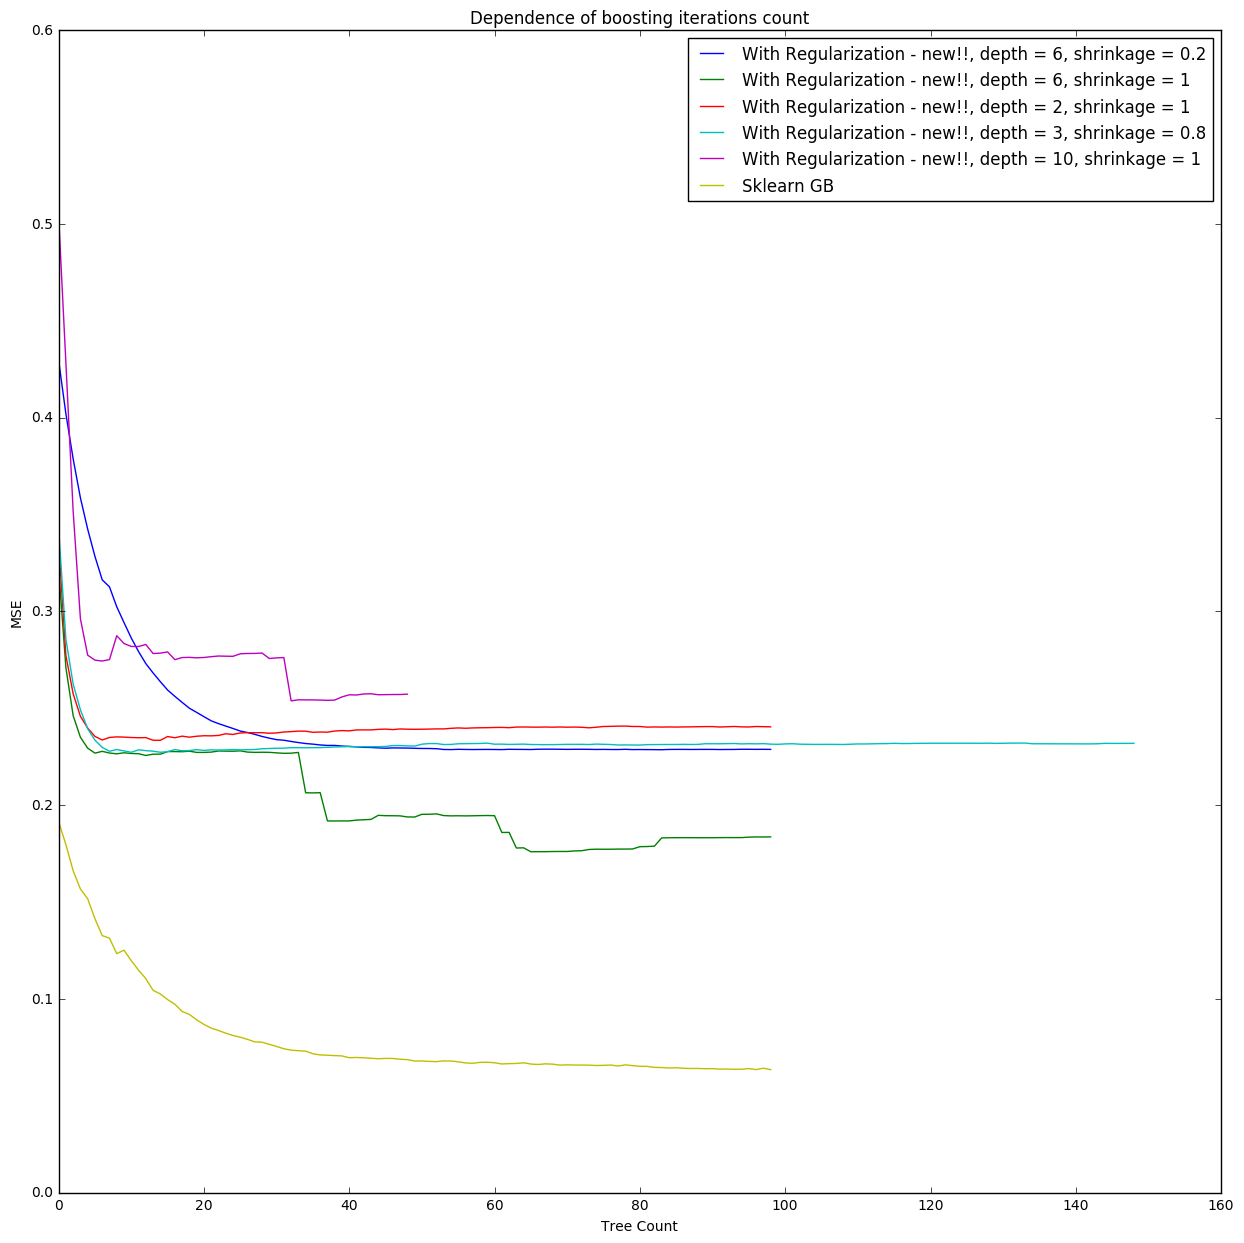

In [224]:
fig, ax = plt.subplots(figsize = (15, 15))
# for k in error_stat.keys():
    
#     plt.plot(range(0, 150), error_stat[k], label='BagBoo, N_Boo = ' + str(k) + \
#                                                  ', max_depth = 3, bagging_ratio=0.2')
    
# plt.plot(range(0, 99), error_without_reg_spam, label='Without Regularization, depth = 3, shrinkage = 0.1')
# plt.plot(range(0, 99), error_with_reg_spam, label='With Regularization, depth = 3, shrinkage = 0.1')
# plt.plot(range(0, 99), error_with_reg_spam2, label='With Regularization, depth = 3, shrinkage = 0.2')
plt.plot(range(0, 99), new_error_with_reg_spam6, label='With Regularization - new!!, depth = 6, shrinkage = 0.2')
plt.plot(range(0, 99), new_error_with_reg_spam6_1, label='With Regularization - new!!, depth = 6, shrinkage = 1')
# plt.plot(range(0, 199), new_error_with_reg_spam6_1_0, label='With Regularization - new!!, depth = 6, shrinkage = 1')
plt.plot(range(0, 99), new_error_with_reg_spam2_1, label='With Regularization - new!!, depth = 2, shrinkage = 1')
plt.plot(range(0, 149), new_error_with_reg_spam3_1, label='With Regularization - new!!, depth = 3, shrinkage = 0.8')
plt.plot(range(0, 49), new_error_with_reg_spam10_1_0, label='With Regularization - new!!, depth = 10, shrinkage = 1')
plt.plot(range(0, 99), skl_error_spam, label='Sklearn GB')

ax.legend(loc='best')
ax.set_title('Dependence of boosting iterations count')
ax.set_xlabel('Tree Count')
ax.set_ylabel('MSE')